## XgBoostRegressor

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import warnings

from pandas import DataFrame, Series
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
from hyperopt import hp, tpe, Trials, fmin

warnings.filterwarnings('ignore')

In [2]:
marketing_path = "dataset/marketing/marketing.csv"
titanic_train_path = "dataset/titanic/titanic_train.csv"
titanic_test_path = "dataset/titanic/titanic_test_gt.csv"

### common method
#### Data overview
- トレーニングデータがない場合、分割
- 型と欠損値の確認

In [3]:
def data_split(path, test_size=0.2):
    '''
    If the test data doesn't exist, the training data is divided to generate the test data.
    '''
    df_train, df_test = train_test_split(pd.read_csv(path), test_size=test_size, shuffle=True, random_state=42)
    print("Data Shapes")
    print("Train_data : {0}, Test_data : {1}".format(df_train.shape, df_test.shape))
    print("-"*20)
    print("Train_data head")
    display(df_train.head())
    print("Test_data head")
    display(df_test.head())
    
    return df_train, df_test

In [4]:
def display_missing_value(df):
    display(pd.concat([df.dtypes, df.isnull().sum()], axis=1).rename(columns={0:'dType', 1:'Missing-Values'}))

#### Preprocess
- カテゴリタイプ変換
- dMatrix変換

In [5]:
def transform_category(df):
    for col in df.describe(include='O').columns:
        df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
        df.drop(col, axis=1, inplace=True)
    display(df)
    
    return df

In [6]:
def transform_dmatrix(df, target_label):
    return xgb.DMatrix(df.drop(target_label, axis=1).values, label=df[target_label].values)

In [7]:
def train_valid_split_and_transform_dmatrix(df, test_size=0.2, shuffle=True, random_state=42):
    X_train, X_valid = train_test_split(df, test_size=test_size, shuffle=shuffle, random_state=random_state)
    dtrain = transform_dmatrix(X_train, target_variable)
    dvalid = transform_dmatrix(X_valid, target_variable)
    
    return dtrain, dvalid

#### Create model
- XGBoostの予測モデル構築
- 学習曲線

In [8]:
def create_xg_model(dtrain, dvalid, target_variable, params, num_round=100):
    evals = [(dtrain, 'train'), (dvalid, 'eval')]
    evals_result = {}
    model = xgb.train(params, dtrain, num_round, evals=evals, evals_result=evals_result)
    return model, evals_result

In [9]:
def model_learning_curve(model, dtest, evals_result):
    y_pred = model.predict(dtest)
    mse = mean_squared_error(dtest.get_label(), y_pred)
    print('RMSE:', np.sqrt(mse))
    
    train_metric = evals_result['train']['rmse']
    plt.plot(train_metric, label='train rmse')
    eval_metric = evals_result['eval']['rmse']
    plt.plot(eval_metric, label='eval rmse')
    plt.grid()
    plt.legend()
    plt.xlabel('rounds')
    plt.ylabel('rmse')
    plt.show()
    
    return np.sqrt(mse)

#### Paramater tuning

In [10]:
def evaluate_params(dtrain, dvalid, dtest, target_variable, params, p_list, p_label):
    d = {}
    params_choice = copy.deepcopy(params)
    for i in p_list:
        params_choice[p_label] = i
        evals_result = {}
        model, evals_result = create_xg_model(dtrain, dvalid, target_variable, params_choice)
        d[i] = model_learning_curve(model, dtest, evals_result)
        
    return min(d.items(), key=lambda x: x[1])

In [11]:
def tune_param(dtrain, dvalid, dtest, target_variable, params):
    d_param = {
               'max_depth': range(3, 10, 1),
               'colsample_bytree': np.arange(0.6, 1, 0.05),
               'min_child_weight': np.arange(0.1, 10.1, 0.1),
               'subsample': np.arange(0.6, 1, 0.05),
               'gamma': np.arange(1e-8, 0.4, 0.01)
              }
    d_result = {}
    for k, v in d_param.items():
        print("Tuning {} ...".format(k))
        d_result[k] = evaluate_params(dtrain, dvalid, dtest, target_variable, params, v, k)
    
    for k, v in d_result.items():
        print("{0} : {1}".format(k, v))
        print("-" * 30)

## 1.Marketing
### Data overview

In [12]:
df_train, df_test = data_split(marketing_path, test_size=0.2)

Data Shapes
Train_data : (36168, 17), Test_data : (9043, 17)
--------------------
Train_data head


age          job marital_status  education default  balance  \
3344    41  blue-collar        married    primary      no      849   
17965   49   technician        married    primary      no     1415   
18299   42       admin.        married  secondary      no     3842   
10221   37   management         single   tertiary      no     -119   
32192   56  blue-collar        married    primary      no     3498   

      housing_loan personal_loan contact_channel  last_contact_day  \
3344           yes            no         unknown                15   
17965          yes            no        cellular                30   
18299           no            no        cellular                31   
10221          yes            no         unknown                11   
32192           no            no        cellular                15   

      last_contact_month  contact_duration  campaign  gap_between_campaigns  \
3344                 may                72         1                     -1   
17965                jul               269         2                     -1   
18299                jul               130         4                     -1   
10221                jun               375        11                     -1   
32192                apr               264         2                     -1   

       previous outcome_previous_campaign  insurance_subscribe  
3344          0                   unknown                    0  
17965         0                   unknown                    0  
18299         0                   unknown                    0  
10221         0                   unknown                    0  
32192         0                   unknown                    1

Test_data head


age          job marital_status  education default  balance  \
3776    40  blue-collar        married  secondary      no      580   
9928    47     services         single  secondary      no     3644   
33409   25      student         single   tertiary      no      538   
31885   42   management        married   tertiary      no     1773   
15738   56   management        married   tertiary      no      217   

      housing_loan personal_loan contact_channel  last_contact_day  \
3776           yes            no         unknown                16   
9928            no            no         unknown                 9   
33409          yes            no        cellular                20   
31885           no            no        cellular                 9   
15738           no           yes        cellular                21   

      last_contact_month  contact_duration  campaign  gap_between_campaigns  \
3776                 may               192         1                     -1   
9928                 jun                83         2                     -1   
33409                apr               226         1                     -1   
31885                apr               311         1                    336   
15738                jul               121         2                     -1   

       previous outcome_previous_campaign  insurance_subscribe  
3776          0                   unknown                    0  
9928          0                   unknown                    0  
33409         0                   unknown                    0  
31885         1                   failure                    0  
15738         0                   unknown                    0

In [13]:
display_missing_value(df_train)
display_missing_value(df_test)

dType  Missing-Values
age                         int64               0
job                        object               0
marital_status             object               0
education                  object               0
default                    object               0
balance                     int64               0
housing_loan               object               0
personal_loan              object               0
contact_channel            object               0
last_contact_day            int64               0
last_contact_month         object               0
contact_duration            int64               0
campaign                    int64               0
gap_between_campaigns       int64               0
previous                    int64               0
outcome_previous_campaign  object               0
insurance_subscribe         int64               0

dType  Missing-Values
age                         int64               0
job                        object               0
marital_status             object               0
education                  object               0
default                    object               0
balance                     int64               0
housing_loan               object               0
personal_loan              object               0
contact_channel            object               0
last_contact_day            int64               0
last_contact_month         object               0
contact_duration            int64               0
campaign                    int64               0
gap_between_campaigns       int64               0
previous                    int64               0
outcome_previous_campaign  object               0
insurance_subscribe         int64               0

In [14]:
display(df_train.describe())
display(df_train.describe(include='O'))

age        balance  last_contact_day  contact_duration  \
count  36168.000000   36168.000000      36168.000000      36168.000000   
mean      40.930823    1361.046146         15.817739        256.891202   
std       10.618369    3023.083187          8.325860        256.884103   
min       18.000000   -8019.000000          1.000000          0.000000   
25%       33.000000      70.000000          8.000000        103.000000   
50%       39.000000     447.000000         16.000000        180.000000   
75%       48.000000    1429.000000         21.000000        318.000000   
max       95.000000  102127.000000         31.000000       4918.000000   

           campaign  gap_between_campaigns      previous  insurance_subscribe  
count  36168.000000           36168.000000  36168.000000         36168.000000  
mean       2.765649              40.180076      0.580264             0.116069  
std        3.120193             100.107617      2.370668             0.320313  
min        1.000000              -1.000000      0.000000             0.000000  
25%        1.000000              -1.000000      0.000000             0.000000  
50%        2.000000              -1.000000      0.000000             0.000000  
75%        3.000000              -1.000000      0.000000             0.000000  
max       63.000000             871.000000    275.000000             1.000000

job marital_status  education default housing_loan  \
count         36168          36168      36168   36168        36168   
unique           12              3          4       2            2   
top     blue-collar        married  secondary      no          yes   
freq           7806          21804      18670   35491        20135   

       personal_loan contact_channel last_contact_month  \
count          36168           36168              36168   
unique             2               3                 12   
top               no        cellular                may   
freq           30333           23464              10963   

       outcome_previous_campaign  
count                      36168  
unique                         4  
top                      unknown  
freq                       29560

### preprocess

XgBoostでは、StandardScalerが効果を発揮しないという内容を書籍で確認したので、採用しない。
XgBoostのデータ構造に変換するメソッドがあるようなので、そちらを試し見てることにする。
まずは単純にそちらを行い、one-hot-encodingを使用した場合と比較してみる。
→公式ドキュメントを読む限りone-hot-encodingは行ったほうがよさそう。。なので実施したデータのみで対応する。

In [15]:
# target_name
target_variable = "insurance_subscribe"
df_train = transform_category(df_train)
df_test = transform_category(df_test)

dtrain, dvalid = train_valid_split_and_transform_dmatrix(df_train, test_size=0.2, shuffle=True, random_state=42)
dtest = transform_dmatrix(df_test, target_variable)

age  balance  last_contact_day  contact_duration  campaign  \
3344    41      849                15                72         1   
17965   49     1415                30               269         2   
18299   42     3842                31               130         4   
10221   37     -119                11               375        11   
32192   56     3498                15               264         2   
...    ...      ...               ...               ...       ...   
11284   44     1059                18              2093         1   
44732   23      508                 8               210         1   
38158   34     1317                15               239         1   
860     33      165                 7               111         1   
15795   38      -41                21                68        10   

       gap_between_campaigns  previous  insurance_subscribe  job_admin.  \
3344                      -1         0                    0           0   
17965                     -1         0                    0           0   
18299                     -1         0                    0           1   
10221                     -1         0                    0           0   
32192                     -1         0                    1           0   
...                      ...       ...                  ...         ...   
11284                     -1         0                    1           0   
44732                     92         1                    0           0   
38158                     -1         0                    0           0   
860                       -1         0                    0           0   
15795                     -1         0                    0           0   

       job_blue-collar  ...  last_contact_month_jun  last_contact_month_mar  \
3344                 1  ...                       0                       0   
17965                0  ...                       0                       0   
18299                0  ...                       0                       0   
10221                0  ...                       1                       0   
32192                1  ...                       0                       0   
...                ...  ...                     ...                     ...   
11284                0  ...                       1                       0   
44732                0  ...                       0                       0   
38158                0  ...                       0                       0   
860                  0  ...                       0                       0   
15795                1  ...                       0                       0   

       last_contact_month_may  last_contact_month_nov  last_contact_month_oct  \
3344                        1                       0                       0   
17965                       0                       0                       0   
18299                       0                       0                       0   
10221                       0                       0                       0   
32192                       0                       0                       0   
...                       ...                     ...                     ...   
11284                       0                       0                       0   
44732                       0                       0                       0   
38158                       1                       0                       0   
860                         1                       0                       0   
15795                       0                       0                       0   

       last_contact_month_sep  outcome_previous_campaign_failure  \
3344                        0                                  0   
17965                       0                                  0   
18299                       0                                  0   
10221                       0                                  0   
32192          

age  balance  last_contact_day  contact_duration  campaign  \
3776    40      580                16               192         1   
9928    47     3644                 9                83         2   
33409   25      538                20               226         1   
31885   42     1773                 9               311         1   
15738   56      217                21               121         2   
...    ...      ...               ...               ...       ...   
13353   47     1890                 8               161         1   
38732   32      217                15               692         3   
5654    52        0                26               206         1   
3779    40      783                16               171         2   
11677   37     2209                20               167         2   

       gap_between_campaigns  previous  insurance_subscribe  job_admin.  \
3776                      -1         0                    0           0   
9928                      -1         0                    0           0   
33409                     -1         0                    0           0   
31885                    336         1                    0           0   
15738                     -1         0                    0           0   
...                      ...       ...                  ...         ...   
13353                     -1         0                    0           0   
38732                     -1         0                    1           0   
5654                      -1         0                    0           1   
3779                      -1         0                    0           1   
11677                     -1         0                    0           0   

       job_blue-collar  ...  last_contact_month_jun  last_contact_month_mar  \
3776                 1  ...                       0                       0   
9928                 0  ...                       1                       0   
33409                0  ...                       0                       0   
31885                0  ...                       0                       0   
15738                0  ...                       0                       0   
...                ...  ...                     ...                     ...   
13353                0  ...                       0                       0   
38732                1  ...                       0                       0   
5654                 0  ...                       0                       0   
3779                 0  ...                       0                       0   
11677                0  ...                       1                       0   

       last_contact_month_may  last_contact_month_nov  last_contact_month_oct  \
3776                        1                       0                       0   
9928                        0                       0                       0   
33409                       0                       0                       0   
31885                       0                       0                       0   
15738                       0                       0                       0   
...                       ...                     ...                     ...   
13353                       0                       0                       0   
38732                       1                       0                       0   
5654                        1                       0                       0   
3779                        1                       0                       0   
11677                       0                       0                       0   

       last_contact_month_sep  outcome_previous_campaign_failure  \
3776                        0                                  0   
9928                        0                                  0   
33409                       0                                  0   
31885                       0                                  1   
15738          

### create model

#### baseline-model (Marketing)

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298266
[11]	train-rmse:0.288763	eval-rmse:0.292698
[12]	train-rmse:0.283802	eval-rmse:0.28821
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279247
[15]	train-rmse:0.270322	eval-rmse:0.275395
[16]	train-rmse:0.267139	eval-rmse:0.272476
[17]	train-rmse:0.264225	eval-rmse:0.269729
[18]	train-rmse:0.261741	eval-rmse:0.267481
[19]	train-rmse:0.260096	eval-rmse:0.266138
[20]	train-rmse:0.258595	eval-rmse:0.264977
[21]	train-rmse:0.256972	eval-rmse:0.263583
[22]	train-rmse:0.255468	eval-rmse:0.262234


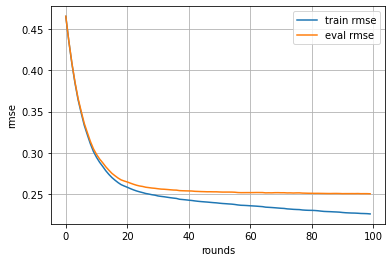

0.25301266

In [16]:
# ハイパーパラメータの設定
b_params = {
            'objective': 'reg:squarederror',
            'eta': 0.1,
            'gamma': 0.0,
            'alpha': 0.0,
            'lambda': 1.0,
            'eval_metric': 'rmse',
            'min_child_weight': 1,
            'max_depth': 5,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': 42
            }

base_model, evals_result = create_xg_model(dtrain, dvalid, target_variable, b_params, num_round=100)
model_learning_curve(base_model, dtest, evals_result)

#### Paramater tuning

Tuning max_depth ...
[0]	train-rmse:0.465855	eval-rmse:0.465957
[1]	train-rmse:0.436758	eval-rmse:0.436971
[2]	train-rmse:0.410825	eval-rmse:0.411163
[3]	train-rmse:0.388403	eval-rmse:0.388794
[4]	train-rmse:0.369271	eval-rmse:0.369825
[5]	train-rmse:0.353986	eval-rmse:0.354874
[6]	train-rmse:0.339743	eval-rmse:0.340756
[7]	train-rmse:0.328851	eval-rmse:0.330099
[8]	train-rmse:0.318521	eval-rmse:0.319701
[9]	train-rmse:0.309906	eval-rmse:0.31123
[10]	train-rmse:0.303322	eval-rmse:0.304868
[11]	train-rmse:0.297858	eval-rmse:0.299545
[12]	train-rmse:0.293221	eval-rmse:0.295189
[13]	train-rmse:0.288435	eval-rmse:0.290352
[14]	train-rmse:0.284472	eval-rmse:0.286354
[15]	train-rmse:0.281064	eval-rmse:0.282851
[16]	train-rmse:0.278209	eval-rmse:0.280023
[17]	train-rmse:0.275821	eval-rmse:0.277592
[18]	train-rmse:0.273779	eval-rmse:0.275562
[19]	train-rmse:0.272306	eval-rmse:0.274238
[20]	train-rmse:0.271077	eval-rmse:0.273118
[21]	train-rmse:0.269511	eval-rmse:0.271403
[22]	train-rmse:0.2681

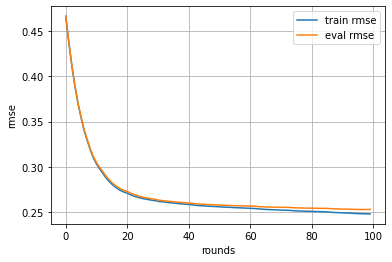

[0]	train-rmse:0.465377	eval-rmse:0.465543
[1]	train-rmse:0.435513	eval-rmse:0.435766
[2]	train-rmse:0.409107	eval-rmse:0.409572
[3]	train-rmse:0.386347	eval-rmse:0.386961
[4]	train-rmse:0.366773	eval-rmse:0.367627
[5]	train-rmse:0.351216	eval-rmse:0.35242
[6]	train-rmse:0.336584	eval-rmse:0.337871
[7]	train-rmse:0.325146	eval-rmse:0.326918
[8]	train-rmse:0.314412	eval-rmse:0.316211
[9]	train-rmse:0.305459	eval-rmse:0.30744
[10]	train-rmse:0.298524	eval-rmse:0.300795
[11]	train-rmse:0.29283	eval-rmse:0.295303
[12]	train-rmse:0.288045	eval-rmse:0.29092
[13]	train-rmse:0.28301	eval-rmse:0.285973
[14]	train-rmse:0.278706	eval-rmse:0.281759
[15]	train-rmse:0.27515	eval-rmse:0.278113
[16]	train-rmse:0.272166	eval-rmse:0.275339
[17]	train-rmse:0.269584	eval-rmse:0.272865
[18]	train-rmse:0.267449	eval-rmse:0.270652
[19]	train-rmse:0.265926	eval-rmse:0.269265
[20]	train-rmse:0.26444	eval-rmse:0.267874
[21]	train-rmse:0.262625	eval-rmse:0.26619
[22]	train-rmse:0.261275	eval-rmse:0.264824
[23]	t

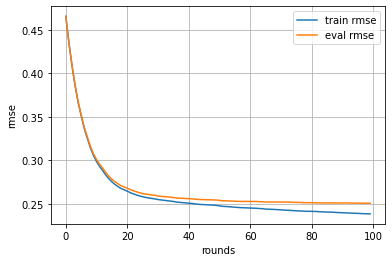

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298266
[11]	train-rmse:0.288763	eval-rmse:0.292698
[12]	train-rmse:0.283802	eval-rmse:0.28821
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279247
[15]	train-rmse:0.270322	eval-rmse:0.275395
[16]	train-rmse:0.267139	eval-rmse:0.272476
[17]	train-rmse:0.264225	eval-rmse:0.269729
[18]	train-rmse:0.261741	eval-rmse:0.267481
[19]	train-rmse:0.260096	eval-rmse:0.266138
[20]	train-rmse:0.258595	eval-rmse:0.264977
[21]	train-rmse:0.256972	eval-rmse:0.263583
[22]	train-rmse:0.255468	eval-rmse:0.262234


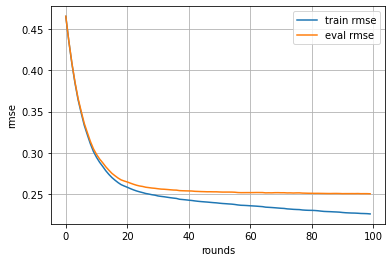

[0]	train-rmse:0.464377	eval-rmse:0.46467
[1]	train-rmse:0.433238	eval-rmse:0.433988
[2]	train-rmse:0.40609	eval-rmse:0.407259
[3]	train-rmse:0.382492	eval-rmse:0.384254
[4]	train-rmse:0.362033	eval-rmse:0.364313
[5]	train-rmse:0.345957	eval-rmse:0.34896
[6]	train-rmse:0.33073	eval-rmse:0.33413
[7]	train-rmse:0.319076	eval-rmse:0.323198
[8]	train-rmse:0.307563	eval-rmse:0.312047
[9]	train-rmse:0.297807	eval-rmse:0.302953
[10]	train-rmse:0.290342	eval-rmse:0.295987
[11]	train-rmse:0.284317	eval-rmse:0.29035
[12]	train-rmse:0.279197	eval-rmse:0.285659
[13]	train-rmse:0.273614	eval-rmse:0.28049
[14]	train-rmse:0.268922	eval-rmse:0.276281
[15]	train-rmse:0.264973	eval-rmse:0.272659
[16]	train-rmse:0.261607	eval-rmse:0.269859
[17]	train-rmse:0.258472	eval-rmse:0.267181
[18]	train-rmse:0.255727	eval-rmse:0.26488
[19]	train-rmse:0.254074	eval-rmse:0.26347
[20]	train-rmse:0.252344	eval-rmse:0.26226
[21]	train-rmse:0.250488	eval-rmse:0.260892
[22]	train-rmse:0.248816	eval-rmse:0.259451
[23]	tra

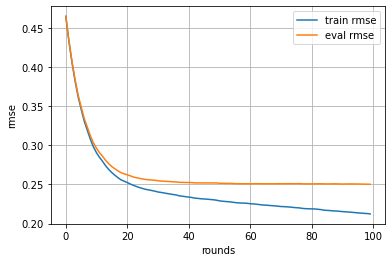

[0]	train-rmse:0.463739	eval-rmse:0.4643
[1]	train-rmse:0.431942	eval-rmse:0.433334
[2]	train-rmse:0.404155	eval-rmse:0.406368
[3]	train-rmse:0.379995	eval-rmse:0.383079
[4]	train-rmse:0.358991	eval-rmse:0.362949
[5]	train-rmse:0.34246	eval-rmse:0.34746
[6]	train-rmse:0.326648	eval-rmse:0.332344
[7]	train-rmse:0.314411	eval-rmse:0.321214
[8]	train-rmse:0.30239	eval-rmse:0.309994
[9]	train-rmse:0.2921	eval-rmse:0.300919
[10]	train-rmse:0.284488	eval-rmse:0.293889
[11]	train-rmse:0.278	eval-rmse:0.288239
[12]	train-rmse:0.272685	eval-rmse:0.283622
[13]	train-rmse:0.266752	eval-rmse:0.278569
[14]	train-rmse:0.26122	eval-rmse:0.274354
[15]	train-rmse:0.256877	eval-rmse:0.270843
[16]	train-rmse:0.252893	eval-rmse:0.267869
[17]	train-rmse:0.249595	eval-rmse:0.265327
[18]	train-rmse:0.246721	eval-rmse:0.263529
[19]	train-rmse:0.244811	eval-rmse:0.262145
[20]	train-rmse:0.242889	eval-rmse:0.261019
[21]	train-rmse:0.24053	eval-rmse:0.259727
[22]	train-rmse:0.238467	eval-rmse:0.25848
[23]	train-

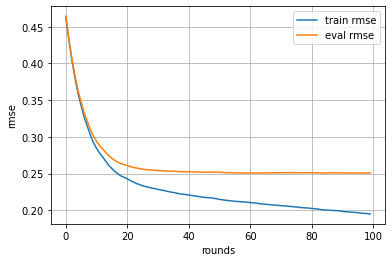

[0]	train-rmse:0.46303	eval-rmse:0.464099
[1]	train-rmse:0.43043	eval-rmse:0.432773
[2]	train-rmse:0.402016	eval-rmse:0.405549
[3]	train-rmse:0.377318	eval-rmse:0.382209
[4]	train-rmse:0.355801	eval-rmse:0.361835
[5]	train-rmse:0.338812	eval-rmse:0.346182
[6]	train-rmse:0.322478	eval-rmse:0.331083
[7]	train-rmse:0.309955	eval-rmse:0.31983
[8]	train-rmse:0.297218	eval-rmse:0.308767
[9]	train-rmse:0.286367	eval-rmse:0.299572
[10]	train-rmse:0.278421	eval-rmse:0.292646
[11]	train-rmse:0.271654	eval-rmse:0.28694
[12]	train-rmse:0.265942	eval-rmse:0.282058
[13]	train-rmse:0.259695	eval-rmse:0.277046
[14]	train-rmse:0.253819	eval-rmse:0.272717
[15]	train-rmse:0.248692	eval-rmse:0.269099
[16]	train-rmse:0.244536	eval-rmse:0.266214
[17]	train-rmse:0.240761	eval-rmse:0.263856
[18]	train-rmse:0.237422	eval-rmse:0.261788
[19]	train-rmse:0.235289	eval-rmse:0.26064
[20]	train-rmse:0.233161	eval-rmse:0.2596
[21]	train-rmse:0.230316	eval-rmse:0.258248
[22]	train-rmse:0.228045	eval-rmse:0.257032
[23]	

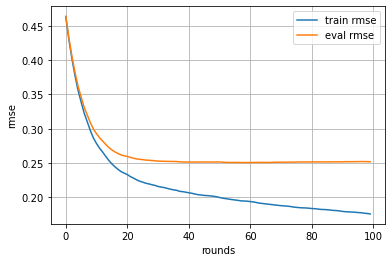

[0]	train-rmse:0.462396	eval-rmse:0.464034
[1]	train-rmse:0.429027	eval-rmse:0.432533
[2]	train-rmse:0.399914	eval-rmse:0.405104
[3]	train-rmse:0.374516	eval-rmse:0.381385
[4]	train-rmse:0.352405	eval-rmse:0.361173
[5]	train-rmse:0.334931	eval-rmse:0.34546
[6]	train-rmse:0.318095	eval-rmse:0.330272
[7]	train-rmse:0.305234	eval-rmse:0.319063
[8]	train-rmse:0.291864	eval-rmse:0.307932
[9]	train-rmse:0.280478	eval-rmse:0.298496
[10]	train-rmse:0.272297	eval-rmse:0.291633
[11]	train-rmse:0.264919	eval-rmse:0.285932
[12]	train-rmse:0.258941	eval-rmse:0.281106
[13]	train-rmse:0.252084	eval-rmse:0.276025
[14]	train-rmse:0.24557	eval-rmse:0.271894
[15]	train-rmse:0.240026	eval-rmse:0.268297
[16]	train-rmse:0.235327	eval-rmse:0.265415
[17]	train-rmse:0.231246	eval-rmse:0.26342
[18]	train-rmse:0.22771	eval-rmse:0.261398
[19]	train-rmse:0.225543	eval-rmse:0.260163
[20]	train-rmse:0.223293	eval-rmse:0.259178
[21]	train-rmse:0.220325	eval-rmse:0.257824
[22]	train-rmse:0.217723	eval-rmse:0.25671
[23

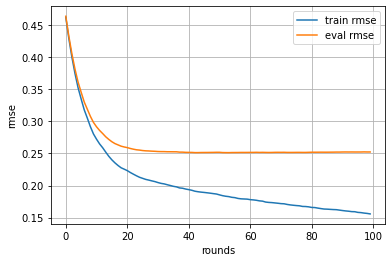

Tuning colsample_bytree ...
[0]	train-rmse:0.46492	eval-rmse:0.465138
[1]	train-rmse:0.434373	eval-rmse:0.434841
[2]	train-rmse:0.408495	eval-rmse:0.409035
[3]	train-rmse:0.387137	eval-rmse:0.388071
[4]	train-rmse:0.366721	eval-rmse:0.368072
[5]	train-rmse:0.351033	eval-rmse:0.35278
[6]	train-rmse:0.335809	eval-rmse:0.337727
[7]	train-rmse:0.324361	eval-rmse:0.326693
[8]	train-rmse:0.312957	eval-rmse:0.315484
[9]	train-rmse:0.304779	eval-rmse:0.307709
[10]	train-rmse:0.298021	eval-rmse:0.301175
[11]	train-rmse:0.292216	eval-rmse:0.295649
[12]	train-rmse:0.28757	eval-rmse:0.291145
[13]	train-rmse:0.281794	eval-rmse:0.285657
[14]	train-rmse:0.276919	eval-rmse:0.280898
[15]	train-rmse:0.273734	eval-rmse:0.278109
[16]	train-rmse:0.270107	eval-rmse:0.274668
[17]	train-rmse:0.267721	eval-rmse:0.272442
[18]	train-rmse:0.264702	eval-rmse:0.269543
[19]	train-rmse:0.263057	eval-rmse:0.268136
[20]	train-rmse:0.261541	eval-rmse:0.266968
[21]	train-rmse:0.259372	eval-rmse:0.264941
[22]	train-rmse:0

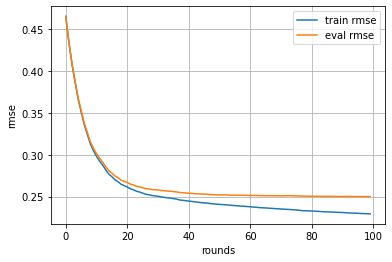

[0]	train-rmse:0.46492	eval-rmse:0.465138
[1]	train-rmse:0.434357	eval-rmse:0.434819
[2]	train-rmse:0.408486	eval-rmse:0.409016
[3]	train-rmse:0.387102	eval-rmse:0.388004
[4]	train-rmse:0.36661	eval-rmse:0.367987
[5]	train-rmse:0.350897	eval-rmse:0.352732
[6]	train-rmse:0.335714	eval-rmse:0.337843
[7]	train-rmse:0.324304	eval-rmse:0.326832
[8]	train-rmse:0.312948	eval-rmse:0.315623
[9]	train-rmse:0.303315	eval-rmse:0.306347
[10]	train-rmse:0.296548	eval-rmse:0.299871
[11]	train-rmse:0.290301	eval-rmse:0.294004
[12]	train-rmse:0.285293	eval-rmse:0.289256
[13]	train-rmse:0.279822	eval-rmse:0.28407
[14]	train-rmse:0.275183	eval-rmse:0.279601
[15]	train-rmse:0.272002	eval-rmse:0.276794
[16]	train-rmse:0.268606	eval-rmse:0.273758
[17]	train-rmse:0.265622	eval-rmse:0.27114
[18]	train-rmse:0.262932	eval-rmse:0.268564
[19]	train-rmse:0.26115	eval-rmse:0.267074
[20]	train-rmse:0.259659	eval-rmse:0.265877
[21]	train-rmse:0.257885	eval-rmse:0.264345
[22]	train-rmse:0.256776	eval-rmse:0.263529
[23

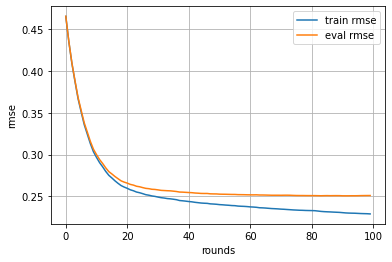

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434433	eval-rmse:0.434867
[2]	train-rmse:0.407657	eval-rmse:0.408408
[3]	train-rmse:0.386449	eval-rmse:0.387637
[4]	train-rmse:0.366177	eval-rmse:0.367794
[5]	train-rmse:0.350539	eval-rmse:0.352641
[6]	train-rmse:0.335399	eval-rmse:0.3377
[7]	train-rmse:0.323997	eval-rmse:0.326808
[8]	train-rmse:0.312701	eval-rmse:0.315689
[9]	train-rmse:0.3032	eval-rmse:0.306361
[10]	train-rmse:0.296434	eval-rmse:0.299772
[11]	train-rmse:0.290542	eval-rmse:0.294165
[12]	train-rmse:0.285496	eval-rmse:0.289473
[13]	train-rmse:0.280087	eval-rmse:0.284398
[14]	train-rmse:0.275399	eval-rmse:0.280097
[15]	train-rmse:0.271319	eval-rmse:0.276149
[16]	train-rmse:0.268065	eval-rmse:0.273127
[17]	train-rmse:0.265279	eval-rmse:0.27048
[18]	train-rmse:0.262766	eval-rmse:0.268327
[19]	train-rmse:0.260962	eval-rmse:0.26678
[20]	train-rmse:0.259418	eval-rmse:0.26553
[21]	train-rmse:0.257798	eval-rmse:0.26413
[22]	train-rmse:0.25663	eval-rmse:0.263246
[23]	tra

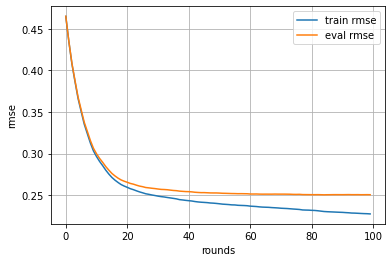

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434433	eval-rmse:0.434867
[2]	train-rmse:0.407604	eval-rmse:0.408368
[3]	train-rmse:0.384435	eval-rmse:0.385571
[4]	train-rmse:0.364428	eval-rmse:0.365986
[5]	train-rmse:0.348593	eval-rmse:0.350801
[6]	train-rmse:0.333688	eval-rmse:0.336151
[7]	train-rmse:0.322264	eval-rmse:0.325144
[8]	train-rmse:0.311218	eval-rmse:0.314351
[9]	train-rmse:0.301954	eval-rmse:0.30552
[10]	train-rmse:0.295051	eval-rmse:0.298792
[11]	train-rmse:0.289142	eval-rmse:0.293192
[12]	train-rmse:0.284051	eval-rmse:0.288581
[13]	train-rmse:0.27882	eval-rmse:0.283676
[14]	train-rmse:0.274378	eval-rmse:0.279455
[15]	train-rmse:0.270493	eval-rmse:0.275626
[16]	train-rmse:0.267279	eval-rmse:0.272579
[17]	train-rmse:0.264375	eval-rmse:0.269958
[18]	train-rmse:0.261921	eval-rmse:0.267769
[19]	train-rmse:0.2603	eval-rmse:0.266412
[20]	train-rmse:0.25877	eval-rmse:0.265202
[21]	train-rmse:0.2571	eval-rmse:0.263739
[22]	train-rmse:0.255583	eval-rmse:0.262427
[23]	t

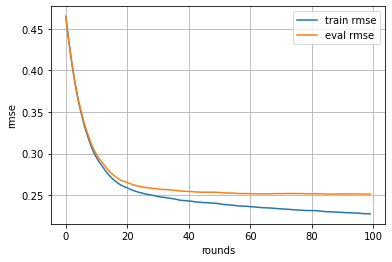

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298266
[11]	train-rmse:0.288763	eval-rmse:0.292698
[12]	train-rmse:0.283802	eval-rmse:0.28821
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279247
[15]	train-rmse:0.270322	eval-rmse:0.275395
[16]	train-rmse:0.267139	eval-rmse:0.272476
[17]	train-rmse:0.264225	eval-rmse:0.269729
[18]	train-rmse:0.261741	eval-rmse:0.267481
[19]	train-rmse:0.260096	eval-rmse:0.266138
[20]	train-rmse:0.258595	eval-rmse:0.264977
[21]	train-rmse:0.256972	eval-rmse:0.263583
[22]	train-rmse:0.255468	eval-rmse:0.262234


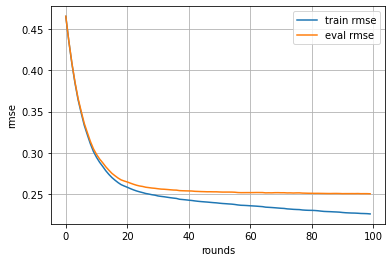

[0]	train-rmse:0.464874	eval-rmse:0.465084
[1]	train-rmse:0.434223	eval-rmse:0.434688
[2]	train-rmse:0.407457	eval-rmse:0.40827
[3]	train-rmse:0.384339	eval-rmse:0.385385
[4]	train-rmse:0.364361	eval-rmse:0.365726
[5]	train-rmse:0.348541	eval-rmse:0.350434
[6]	train-rmse:0.33355	eval-rmse:0.33585
[7]	train-rmse:0.322015	eval-rmse:0.32472
[8]	train-rmse:0.310955	eval-rmse:0.314051
[9]	train-rmse:0.301654	eval-rmse:0.30499
[10]	train-rmse:0.294751	eval-rmse:0.298486
[11]	train-rmse:0.288867	eval-rmse:0.292922
[12]	train-rmse:0.283914	eval-rmse:0.288354
[13]	train-rmse:0.278741	eval-rmse:0.283537
[14]	train-rmse:0.274271	eval-rmse:0.279236
[15]	train-rmse:0.270507	eval-rmse:0.275606
[16]	train-rmse:0.267385	eval-rmse:0.272779
[17]	train-rmse:0.26439	eval-rmse:0.269922
[18]	train-rmse:0.261978	eval-rmse:0.267766
[19]	train-rmse:0.260366	eval-rmse:0.266442
[20]	train-rmse:0.259013	eval-rmse:0.265409
[21]	train-rmse:0.257328	eval-rmse:0.26402
[22]	train-rmse:0.255711	eval-rmse:0.262591
[23]	

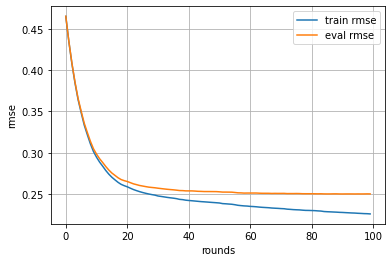

[0]	train-rmse:0.464878	eval-rmse:0.465119
[1]	train-rmse:0.434218	eval-rmse:0.434716
[2]	train-rmse:0.407474	eval-rmse:0.408325
[3]	train-rmse:0.384365	eval-rmse:0.385469
[4]	train-rmse:0.364389	eval-rmse:0.365815
[5]	train-rmse:0.34858	eval-rmse:0.350554
[6]	train-rmse:0.333597	eval-rmse:0.335991
[7]	train-rmse:0.322055	eval-rmse:0.32483
[8]	train-rmse:0.310978	eval-rmse:0.31413
[9]	train-rmse:0.301686	eval-rmse:0.305184
[10]	train-rmse:0.294756	eval-rmse:0.298687
[11]	train-rmse:0.28874	eval-rmse:0.292951
[12]	train-rmse:0.283782	eval-rmse:0.288395
[13]	train-rmse:0.278385	eval-rmse:0.283332
[14]	train-rmse:0.274011	eval-rmse:0.279141
[15]	train-rmse:0.270322	eval-rmse:0.275511
[16]	train-rmse:0.267225	eval-rmse:0.272608
[17]	train-rmse:0.264141	eval-rmse:0.269637
[18]	train-rmse:0.261443	eval-rmse:0.26731
[19]	train-rmse:0.259817	eval-rmse:0.26594
[20]	train-rmse:0.258317	eval-rmse:0.264739
[21]	train-rmse:0.256432	eval-rmse:0.263307
[22]	train-rmse:0.254731	eval-rmse:0.261917
[23]

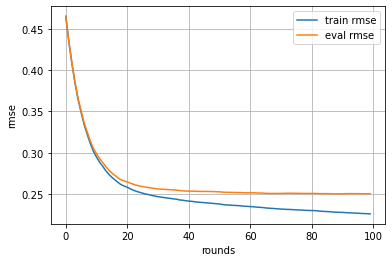

[0]	train-rmse:0.46486	eval-rmse:0.465099
[1]	train-rmse:0.434198	eval-rmse:0.434702
[2]	train-rmse:0.407442	eval-rmse:0.408171
[3]	train-rmse:0.384341	eval-rmse:0.385433
[4]	train-rmse:0.364243	eval-rmse:0.365601
[5]	train-rmse:0.348405	eval-rmse:0.350216
[6]	train-rmse:0.333559	eval-rmse:0.335653
[7]	train-rmse:0.322092	eval-rmse:0.324552
[8]	train-rmse:0.311081	eval-rmse:0.313763
[9]	train-rmse:0.301736	eval-rmse:0.304609
[10]	train-rmse:0.293853	eval-rmse:0.29711
[11]	train-rmse:0.287019	eval-rmse:0.290622
[12]	train-rmse:0.281475	eval-rmse:0.285359
[13]	train-rmse:0.276752	eval-rmse:0.280932
[14]	train-rmse:0.272694	eval-rmse:0.277034
[15]	train-rmse:0.269169	eval-rmse:0.273772
[16]	train-rmse:0.266242	eval-rmse:0.271143
[17]	train-rmse:0.263256	eval-rmse:0.268592
[18]	train-rmse:0.26065	eval-rmse:0.266146
[19]	train-rmse:0.258737	eval-rmse:0.264304
[20]	train-rmse:0.257087	eval-rmse:0.262709
[21]	train-rmse:0.255462	eval-rmse:0.261492
[22]	train-rmse:0.254016	eval-rmse:0.260157
[

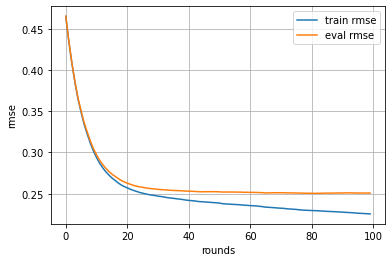

Tuning min_child_weight ...
[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298266
[11]	train-rmse:0.288763	eval-rmse:0.292698
[12]	train-rmse:0.283802	eval-rmse:0.28821
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279247
[15]	train-rmse:0.270322	eval-rmse:0.275395
[16]	train-rmse:0.267139	eval-rmse:0.272476
[17]	train-rmse:0.264225	eval-rmse:0.269729
[18]	train-rmse:0.261741	eval-rmse:0.267481
[19]	train-rmse:0.260096	eval-rmse:0.266138
[20]	train-rmse:0.258595	eval-rmse:0.264977
[21]	train-rmse:0.256972	eval-rmse:0.263583
[22]	train-rmse:

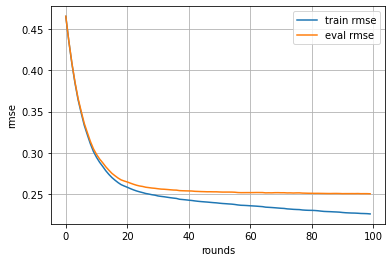

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298266
[11]	train-rmse:0.288763	eval-rmse:0.292698
[12]	train-rmse:0.283802	eval-rmse:0.28821
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279247
[15]	train-rmse:0.270322	eval-rmse:0.275395
[16]	train-rmse:0.267139	eval-rmse:0.272476
[17]	train-rmse:0.264225	eval-rmse:0.269729
[18]	train-rmse:0.261741	eval-rmse:0.267481
[19]	train-rmse:0.260096	eval-rmse:0.266138
[20]	train-rmse:0.258595	eval-rmse:0.264977
[21]	train-rmse:0.256972	eval-rmse:0.263583
[22]	train-rmse:0.255468	eval-rmse:0.262234


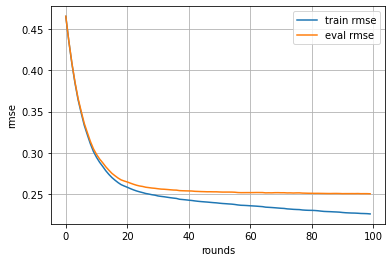

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298266
[11]	train-rmse:0.288763	eval-rmse:0.292698
[12]	train-rmse:0.283802	eval-rmse:0.28821
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279247
[15]	train-rmse:0.270322	eval-rmse:0.275395
[16]	train-rmse:0.267139	eval-rmse:0.272476
[17]	train-rmse:0.264225	eval-rmse:0.269729
[18]	train-rmse:0.261741	eval-rmse:0.267481
[19]	train-rmse:0.260096	eval-rmse:0.266138
[20]	train-rmse:0.258595	eval-rmse:0.264977
[21]	train-rmse:0.256972	eval-rmse:0.263583
[22]	train-rmse:0.255468	eval-rmse:0.262234


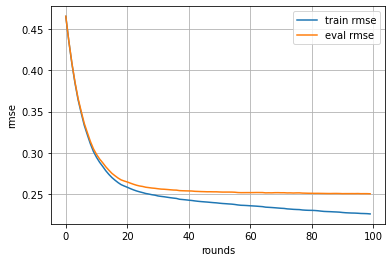

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298266
[11]	train-rmse:0.288763	eval-rmse:0.292698
[12]	train-rmse:0.283802	eval-rmse:0.28821
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279247
[15]	train-rmse:0.270322	eval-rmse:0.275395
[16]	train-rmse:0.267139	eval-rmse:0.272476
[17]	train-rmse:0.264225	eval-rmse:0.269729
[18]	train-rmse:0.261741	eval-rmse:0.267481
[19]	train-rmse:0.260096	eval-rmse:0.266138
[20]	train-rmse:0.258595	eval-rmse:0.264977
[21]	train-rmse:0.256972	eval-rmse:0.263583
[22]	train-rmse:0.255468	eval-rmse:0.262234


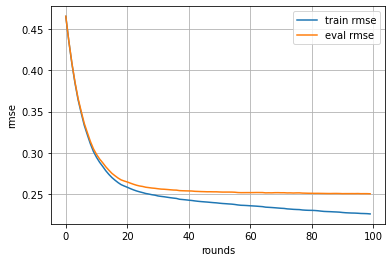

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298266
[11]	train-rmse:0.288763	eval-rmse:0.292698
[12]	train-rmse:0.283802	eval-rmse:0.28821
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279247
[15]	train-rmse:0.270322	eval-rmse:0.275395
[16]	train-rmse:0.267139	eval-rmse:0.272476
[17]	train-rmse:0.264225	eval-rmse:0.269729
[18]	train-rmse:0.261741	eval-rmse:0.267481
[19]	train-rmse:0.260096	eval-rmse:0.266138
[20]	train-rmse:0.258595	eval-rmse:0.264977
[21]	train-rmse:0.256972	eval-rmse:0.263583
[22]	train-rmse:0.255468	eval-rmse:0.262234


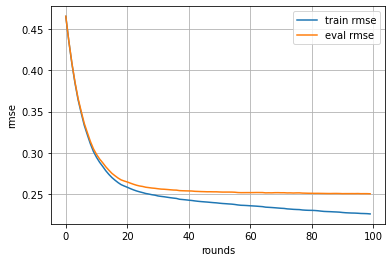

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298266
[11]	train-rmse:0.288763	eval-rmse:0.292698
[12]	train-rmse:0.283802	eval-rmse:0.28821
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279247
[15]	train-rmse:0.270322	eval-rmse:0.275395
[16]	train-rmse:0.267139	eval-rmse:0.272476
[17]	train-rmse:0.264225	eval-rmse:0.269729
[18]	train-rmse:0.261741	eval-rmse:0.267481
[19]	train-rmse:0.260096	eval-rmse:0.266138
[20]	train-rmse:0.258595	eval-rmse:0.264977
[21]	train-rmse:0.256972	eval-rmse:0.263583
[22]	train-rmse:0.255468	eval-rmse:0.262234


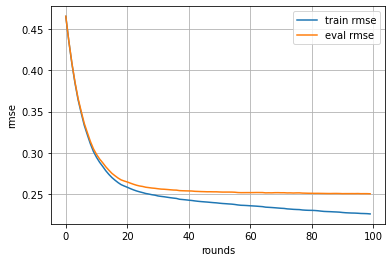

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298266
[11]	train-rmse:0.288763	eval-rmse:0.292698
[12]	train-rmse:0.283802	eval-rmse:0.28821
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279247
[15]	train-rmse:0.270322	eval-rmse:0.275395
[16]	train-rmse:0.267139	eval-rmse:0.272476
[17]	train-rmse:0.264225	eval-rmse:0.269729
[18]	train-rmse:0.261741	eval-rmse:0.267481
[19]	train-rmse:0.260096	eval-rmse:0.266138
[20]	train-rmse:0.258595	eval-rmse:0.264977
[21]	train-rmse:0.256972	eval-rmse:0.263583
[22]	train-rmse:0.255468	eval-rmse:0.262234


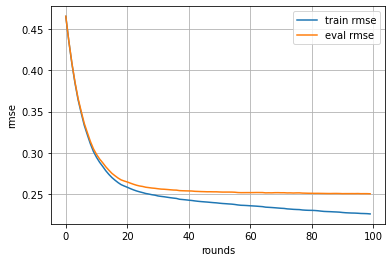

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298266
[11]	train-rmse:0.288763	eval-rmse:0.292698
[12]	train-rmse:0.283802	eval-rmse:0.28821
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279247
[15]	train-rmse:0.270322	eval-rmse:0.275395
[16]	train-rmse:0.267139	eval-rmse:0.272476
[17]	train-rmse:0.264225	eval-rmse:0.269729
[18]	train-rmse:0.261741	eval-rmse:0.267481
[19]	train-rmse:0.260096	eval-rmse:0.266138
[20]	train-rmse:0.258595	eval-rmse:0.264977
[21]	train-rmse:0.256972	eval-rmse:0.263583
[22]	train-rmse:0.255468	eval-rmse:0.262234


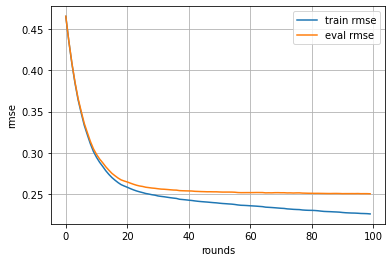

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298266
[11]	train-rmse:0.288763	eval-rmse:0.292698
[12]	train-rmse:0.283802	eval-rmse:0.28821
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279247
[15]	train-rmse:0.270322	eval-rmse:0.275395
[16]	train-rmse:0.267139	eval-rmse:0.272476
[17]	train-rmse:0.264225	eval-rmse:0.269729
[18]	train-rmse:0.261741	eval-rmse:0.267481
[19]	train-rmse:0.260096	eval-rmse:0.266138
[20]	train-rmse:0.258595	eval-rmse:0.264977
[21]	train-rmse:0.256972	eval-rmse:0.263583
[22]	train-rmse:0.255468	eval-rmse:0.262234


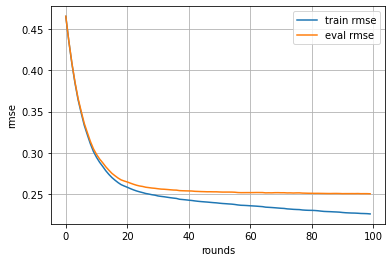

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298266
[11]	train-rmse:0.288763	eval-rmse:0.292698
[12]	train-rmse:0.283802	eval-rmse:0.28821
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279247
[15]	train-rmse:0.270322	eval-rmse:0.275395
[16]	train-rmse:0.267139	eval-rmse:0.272476
[17]	train-rmse:0.264225	eval-rmse:0.269729
[18]	train-rmse:0.261741	eval-rmse:0.267481
[19]	train-rmse:0.260096	eval-rmse:0.266138
[20]	train-rmse:0.258595	eval-rmse:0.264977
[21]	train-rmse:0.256972	eval-rmse:0.263583
[22]	train-rmse:0.255468	eval-rmse:0.262234


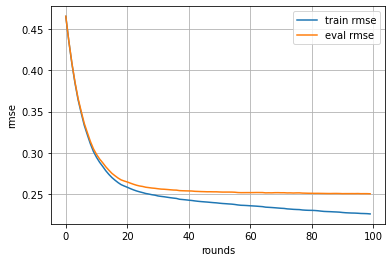

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384288	eval-rmse:0.385422
[4]	train-rmse:0.364282	eval-rmse:0.365842
[5]	train-rmse:0.348432	eval-rmse:0.350473
[6]	train-rmse:0.333495	eval-rmse:0.335769
[7]	train-rmse:0.322085	eval-rmse:0.324735
[8]	train-rmse:0.311047	eval-rmse:0.313931
[9]	train-rmse:0.301729	eval-rmse:0.30497
[10]	train-rmse:0.294721	eval-rmse:0.298283
[11]	train-rmse:0.288788	eval-rmse:0.292713
[12]	train-rmse:0.283831	eval-rmse:0.288224
[13]	train-rmse:0.278625	eval-rmse:0.28339
[14]	train-rmse:0.274211	eval-rmse:0.27926
[15]	train-rmse:0.270363	eval-rmse:0.275402
[16]	train-rmse:0.267186	eval-rmse:0.27248
[17]	train-rmse:0.264269	eval-rmse:0.26979
[18]	train-rmse:0.261789	eval-rmse:0.267557
[19]	train-rmse:0.260146	eval-rmse:0.266213
[20]	train-rmse:0.25861	eval-rmse:0.264967
[21]	train-rmse:0.256978	eval-rmse:0.263591
[22]	train-rmse:0.25546	eval-rmse:0.262249
[23]	t

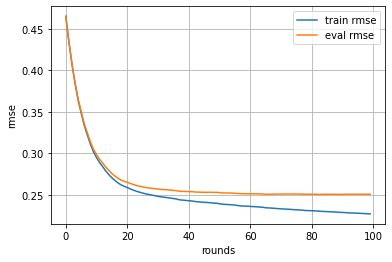

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384288	eval-rmse:0.385422
[4]	train-rmse:0.364282	eval-rmse:0.365842
[5]	train-rmse:0.348432	eval-rmse:0.350473
[6]	train-rmse:0.333495	eval-rmse:0.335769
[7]	train-rmse:0.322085	eval-rmse:0.324735
[8]	train-rmse:0.311047	eval-rmse:0.313931
[9]	train-rmse:0.301729	eval-rmse:0.30497
[10]	train-rmse:0.294721	eval-rmse:0.298283
[11]	train-rmse:0.288788	eval-rmse:0.292713
[12]	train-rmse:0.283831	eval-rmse:0.288224
[13]	train-rmse:0.278625	eval-rmse:0.28339
[14]	train-rmse:0.274211	eval-rmse:0.27926
[15]	train-rmse:0.270363	eval-rmse:0.275402
[16]	train-rmse:0.267186	eval-rmse:0.27248
[17]	train-rmse:0.264269	eval-rmse:0.26979
[18]	train-rmse:0.261789	eval-rmse:0.267557
[19]	train-rmse:0.260146	eval-rmse:0.266213
[20]	train-rmse:0.25861	eval-rmse:0.264967
[21]	train-rmse:0.256978	eval-rmse:0.263591
[22]	train-rmse:0.25546	eval-rmse:0.262249
[23]	t

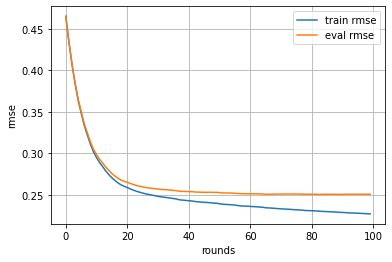

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384288	eval-rmse:0.385422
[4]	train-rmse:0.364282	eval-rmse:0.365842
[5]	train-rmse:0.348432	eval-rmse:0.350473
[6]	train-rmse:0.333495	eval-rmse:0.335769
[7]	train-rmse:0.322085	eval-rmse:0.324735
[8]	train-rmse:0.311047	eval-rmse:0.313931
[9]	train-rmse:0.301729	eval-rmse:0.30497
[10]	train-rmse:0.294721	eval-rmse:0.298283
[11]	train-rmse:0.288788	eval-rmse:0.292713
[12]	train-rmse:0.283831	eval-rmse:0.288224
[13]	train-rmse:0.278625	eval-rmse:0.28339
[14]	train-rmse:0.274211	eval-rmse:0.27926
[15]	train-rmse:0.270363	eval-rmse:0.275402
[16]	train-rmse:0.267186	eval-rmse:0.27248
[17]	train-rmse:0.264269	eval-rmse:0.26979
[18]	train-rmse:0.261789	eval-rmse:0.267557
[19]	train-rmse:0.260146	eval-rmse:0.266213
[20]	train-rmse:0.25861	eval-rmse:0.264967
[21]	train-rmse:0.256978	eval-rmse:0.263591
[22]	train-rmse:0.25546	eval-rmse:0.262249
[23]	t

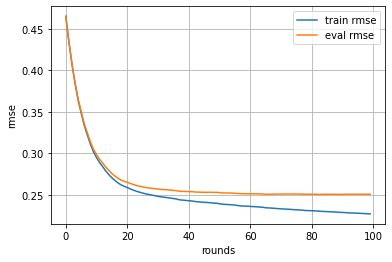

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384288	eval-rmse:0.385422
[4]	train-rmse:0.364282	eval-rmse:0.365842
[5]	train-rmse:0.348432	eval-rmse:0.350473
[6]	train-rmse:0.333495	eval-rmse:0.335769
[7]	train-rmse:0.322085	eval-rmse:0.324735
[8]	train-rmse:0.311047	eval-rmse:0.313931
[9]	train-rmse:0.301729	eval-rmse:0.30497
[10]	train-rmse:0.294721	eval-rmse:0.298283
[11]	train-rmse:0.288788	eval-rmse:0.292713
[12]	train-rmse:0.283831	eval-rmse:0.288224
[13]	train-rmse:0.278625	eval-rmse:0.28339
[14]	train-rmse:0.274211	eval-rmse:0.27926
[15]	train-rmse:0.270363	eval-rmse:0.275402
[16]	train-rmse:0.267186	eval-rmse:0.27248
[17]	train-rmse:0.264269	eval-rmse:0.26979
[18]	train-rmse:0.261789	eval-rmse:0.267557
[19]	train-rmse:0.260146	eval-rmse:0.266213
[20]	train-rmse:0.25861	eval-rmse:0.264967
[21]	train-rmse:0.256978	eval-rmse:0.263591
[22]	train-rmse:0.25546	eval-rmse:0.262249
[23]	t

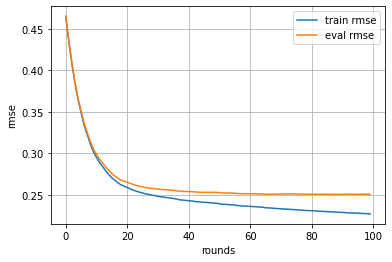

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384288	eval-rmse:0.385422
[4]	train-rmse:0.364282	eval-rmse:0.365842
[5]	train-rmse:0.348432	eval-rmse:0.350473
[6]	train-rmse:0.333495	eval-rmse:0.335769
[7]	train-rmse:0.322085	eval-rmse:0.324735
[8]	train-rmse:0.311047	eval-rmse:0.313931
[9]	train-rmse:0.301729	eval-rmse:0.30497
[10]	train-rmse:0.294721	eval-rmse:0.298283
[11]	train-rmse:0.288788	eval-rmse:0.292713
[12]	train-rmse:0.283831	eval-rmse:0.288224
[13]	train-rmse:0.278625	eval-rmse:0.28339
[14]	train-rmse:0.274211	eval-rmse:0.27926
[15]	train-rmse:0.270363	eval-rmse:0.275402
[16]	train-rmse:0.267186	eval-rmse:0.27248
[17]	train-rmse:0.264269	eval-rmse:0.26979
[18]	train-rmse:0.261789	eval-rmse:0.267557
[19]	train-rmse:0.260146	eval-rmse:0.266213
[20]	train-rmse:0.25861	eval-rmse:0.264967
[21]	train-rmse:0.256978	eval-rmse:0.263591
[22]	train-rmse:0.25546	eval-rmse:0.262249
[23]	t

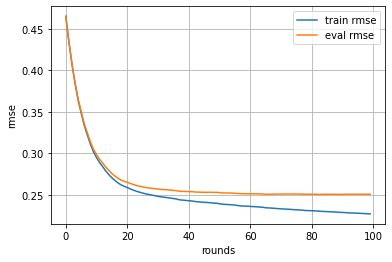

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384288	eval-rmse:0.385422
[4]	train-rmse:0.364282	eval-rmse:0.365842
[5]	train-rmse:0.348432	eval-rmse:0.350473
[6]	train-rmse:0.333495	eval-rmse:0.335769
[7]	train-rmse:0.322085	eval-rmse:0.324735
[8]	train-rmse:0.311047	eval-rmse:0.313931
[9]	train-rmse:0.301729	eval-rmse:0.30497
[10]	train-rmse:0.294721	eval-rmse:0.298283
[11]	train-rmse:0.288788	eval-rmse:0.292713
[12]	train-rmse:0.283831	eval-rmse:0.288224
[13]	train-rmse:0.278625	eval-rmse:0.28339
[14]	train-rmse:0.274211	eval-rmse:0.27926
[15]	train-rmse:0.270363	eval-rmse:0.275402
[16]	train-rmse:0.267186	eval-rmse:0.27248
[17]	train-rmse:0.264269	eval-rmse:0.26979
[18]	train-rmse:0.261789	eval-rmse:0.267557
[19]	train-rmse:0.260146	eval-rmse:0.266213
[20]	train-rmse:0.25861	eval-rmse:0.264967
[21]	train-rmse:0.256978	eval-rmse:0.263591
[22]	train-rmse:0.25546	eval-rmse:0.262249
[23]	t

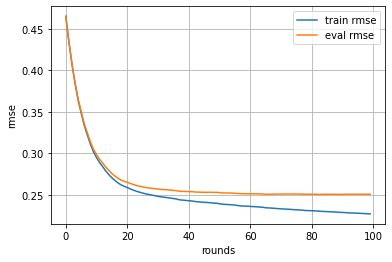

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384288	eval-rmse:0.385422
[4]	train-rmse:0.364282	eval-rmse:0.365842
[5]	train-rmse:0.348432	eval-rmse:0.350473
[6]	train-rmse:0.333495	eval-rmse:0.335769
[7]	train-rmse:0.322085	eval-rmse:0.324735
[8]	train-rmse:0.311047	eval-rmse:0.313931
[9]	train-rmse:0.301729	eval-rmse:0.30497
[10]	train-rmse:0.294721	eval-rmse:0.298283
[11]	train-rmse:0.288788	eval-rmse:0.292713
[12]	train-rmse:0.283831	eval-rmse:0.288224
[13]	train-rmse:0.278625	eval-rmse:0.28339
[14]	train-rmse:0.274211	eval-rmse:0.27926
[15]	train-rmse:0.270363	eval-rmse:0.275402
[16]	train-rmse:0.267186	eval-rmse:0.27248
[17]	train-rmse:0.264269	eval-rmse:0.26979
[18]	train-rmse:0.261789	eval-rmse:0.267557
[19]	train-rmse:0.260146	eval-rmse:0.266213
[20]	train-rmse:0.25861	eval-rmse:0.264967
[21]	train-rmse:0.256978	eval-rmse:0.263591
[22]	train-rmse:0.25546	eval-rmse:0.262249
[23]	t

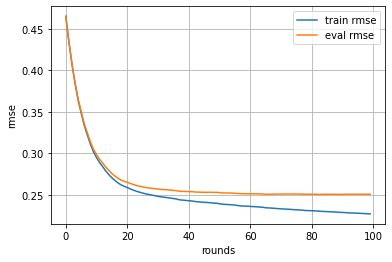

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384288	eval-rmse:0.385422
[4]	train-rmse:0.364282	eval-rmse:0.365842
[5]	train-rmse:0.348432	eval-rmse:0.350473
[6]	train-rmse:0.333495	eval-rmse:0.335769
[7]	train-rmse:0.322085	eval-rmse:0.324735
[8]	train-rmse:0.311047	eval-rmse:0.313931
[9]	train-rmse:0.301729	eval-rmse:0.30497
[10]	train-rmse:0.294721	eval-rmse:0.298283
[11]	train-rmse:0.288788	eval-rmse:0.292713
[12]	train-rmse:0.283831	eval-rmse:0.288224
[13]	train-rmse:0.278625	eval-rmse:0.28339
[14]	train-rmse:0.274211	eval-rmse:0.27926
[15]	train-rmse:0.270363	eval-rmse:0.275402
[16]	train-rmse:0.267186	eval-rmse:0.27248
[17]	train-rmse:0.264269	eval-rmse:0.26979
[18]	train-rmse:0.261789	eval-rmse:0.267557
[19]	train-rmse:0.260146	eval-rmse:0.266213
[20]	train-rmse:0.25861	eval-rmse:0.264967
[21]	train-rmse:0.256978	eval-rmse:0.263591
[22]	train-rmse:0.25546	eval-rmse:0.262249
[23]	t

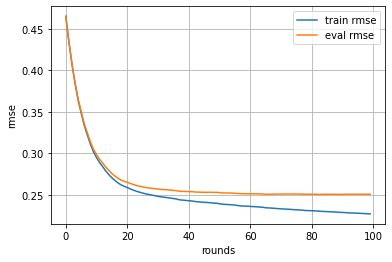

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384288	eval-rmse:0.385422
[4]	train-rmse:0.364282	eval-rmse:0.365842
[5]	train-rmse:0.348432	eval-rmse:0.350473
[6]	train-rmse:0.333495	eval-rmse:0.335769
[7]	train-rmse:0.322085	eval-rmse:0.324735
[8]	train-rmse:0.311047	eval-rmse:0.313931
[9]	train-rmse:0.301729	eval-rmse:0.30497
[10]	train-rmse:0.294721	eval-rmse:0.298283
[11]	train-rmse:0.288788	eval-rmse:0.292713
[12]	train-rmse:0.283831	eval-rmse:0.288224
[13]	train-rmse:0.278625	eval-rmse:0.28339
[14]	train-rmse:0.274211	eval-rmse:0.27926
[15]	train-rmse:0.270363	eval-rmse:0.275402
[16]	train-rmse:0.267186	eval-rmse:0.27248
[17]	train-rmse:0.264269	eval-rmse:0.26979
[18]	train-rmse:0.261789	eval-rmse:0.267557
[19]	train-rmse:0.260146	eval-rmse:0.266213
[20]	train-rmse:0.25861	eval-rmse:0.264967
[21]	train-rmse:0.256978	eval-rmse:0.263591
[22]	train-rmse:0.25546	eval-rmse:0.262249
[23]	t

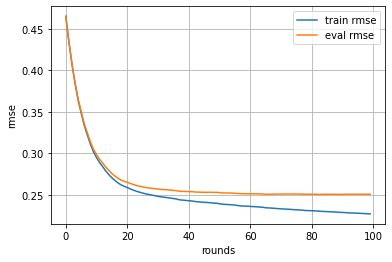

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384288	eval-rmse:0.385422
[4]	train-rmse:0.364282	eval-rmse:0.365842
[5]	train-rmse:0.348432	eval-rmse:0.350473
[6]	train-rmse:0.333495	eval-rmse:0.335769
[7]	train-rmse:0.322085	eval-rmse:0.324735
[8]	train-rmse:0.311047	eval-rmse:0.313931
[9]	train-rmse:0.301729	eval-rmse:0.30497
[10]	train-rmse:0.294721	eval-rmse:0.298283
[11]	train-rmse:0.288788	eval-rmse:0.292713
[12]	train-rmse:0.283831	eval-rmse:0.288224
[13]	train-rmse:0.278625	eval-rmse:0.28339
[14]	train-rmse:0.274211	eval-rmse:0.27926
[15]	train-rmse:0.270363	eval-rmse:0.275402
[16]	train-rmse:0.267186	eval-rmse:0.27248
[17]	train-rmse:0.264269	eval-rmse:0.26979
[18]	train-rmse:0.261789	eval-rmse:0.267557
[19]	train-rmse:0.260146	eval-rmse:0.266213
[20]	train-rmse:0.25861	eval-rmse:0.264967
[21]	train-rmse:0.256978	eval-rmse:0.263591
[22]	train-rmse:0.25546	eval-rmse:0.262249
[23]	t

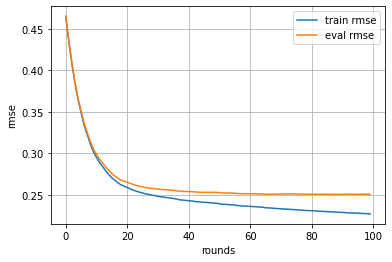

[0]	train-rmse:0.464882	eval-rmse:0.465115
[1]	train-rmse:0.434367	eval-rmse:0.434858
[2]	train-rmse:0.407523	eval-rmse:0.408341
[3]	train-rmse:0.384294	eval-rmse:0.385448
[4]	train-rmse:0.364282	eval-rmse:0.365863
[5]	train-rmse:0.348439	eval-rmse:0.350499
[6]	train-rmse:0.333501	eval-rmse:0.335794
[7]	train-rmse:0.322095	eval-rmse:0.324771
[8]	train-rmse:0.311053	eval-rmse:0.313968
[9]	train-rmse:0.30174	eval-rmse:0.305016
[10]	train-rmse:0.294744	eval-rmse:0.298334
[11]	train-rmse:0.288824	eval-rmse:0.292769
[12]	train-rmse:0.283861	eval-rmse:0.288252
[13]	train-rmse:0.278676	eval-rmse:0.283427
[14]	train-rmse:0.274268	eval-rmse:0.2793
[15]	train-rmse:0.270416	eval-rmse:0.275466
[16]	train-rmse:0.267259	eval-rmse:0.272552
[17]	train-rmse:0.264598	eval-rmse:0.27005
[18]	train-rmse:0.262113	eval-rmse:0.267808
[19]	train-rmse:0.260482	eval-rmse:0.266473
[20]	train-rmse:0.259005	eval-rmse:0.265287
[21]	train-rmse:0.2574	eval-rmse:0.263912
[22]	train-rmse:0.255877	eval-rmse:0.262633
[23]

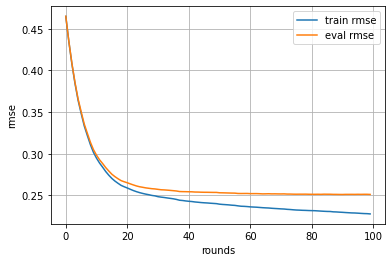

[0]	train-rmse:0.464882	eval-rmse:0.465115
[1]	train-rmse:0.434367	eval-rmse:0.434858
[2]	train-rmse:0.407523	eval-rmse:0.408341
[3]	train-rmse:0.384294	eval-rmse:0.385448
[4]	train-rmse:0.364282	eval-rmse:0.365863
[5]	train-rmse:0.348439	eval-rmse:0.350499
[6]	train-rmse:0.333501	eval-rmse:0.335794
[7]	train-rmse:0.322095	eval-rmse:0.324771
[8]	train-rmse:0.311053	eval-rmse:0.313968
[9]	train-rmse:0.30174	eval-rmse:0.305016
[10]	train-rmse:0.294744	eval-rmse:0.298334
[11]	train-rmse:0.288824	eval-rmse:0.292769
[12]	train-rmse:0.283861	eval-rmse:0.288252
[13]	train-rmse:0.278676	eval-rmse:0.283427
[14]	train-rmse:0.274268	eval-rmse:0.2793
[15]	train-rmse:0.270416	eval-rmse:0.275466
[16]	train-rmse:0.267259	eval-rmse:0.272552
[17]	train-rmse:0.264598	eval-rmse:0.27005
[18]	train-rmse:0.262113	eval-rmse:0.267808
[19]	train-rmse:0.260482	eval-rmse:0.266473
[20]	train-rmse:0.259005	eval-rmse:0.265287
[21]	train-rmse:0.2574	eval-rmse:0.263912
[22]	train-rmse:0.255877	eval-rmse:0.262633
[23]

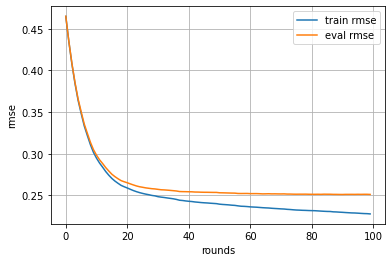

[0]	train-rmse:0.464882	eval-rmse:0.465115
[1]	train-rmse:0.434367	eval-rmse:0.434858
[2]	train-rmse:0.407523	eval-rmse:0.408341
[3]	train-rmse:0.384294	eval-rmse:0.385448
[4]	train-rmse:0.364282	eval-rmse:0.365863
[5]	train-rmse:0.348439	eval-rmse:0.350499
[6]	train-rmse:0.333501	eval-rmse:0.335794
[7]	train-rmse:0.322095	eval-rmse:0.324771
[8]	train-rmse:0.311053	eval-rmse:0.313968
[9]	train-rmse:0.30174	eval-rmse:0.305016
[10]	train-rmse:0.294744	eval-rmse:0.298334
[11]	train-rmse:0.288824	eval-rmse:0.292769
[12]	train-rmse:0.283861	eval-rmse:0.288252
[13]	train-rmse:0.278676	eval-rmse:0.283427
[14]	train-rmse:0.274268	eval-rmse:0.2793
[15]	train-rmse:0.270416	eval-rmse:0.275466
[16]	train-rmse:0.267259	eval-rmse:0.272552
[17]	train-rmse:0.264598	eval-rmse:0.27005
[18]	train-rmse:0.262113	eval-rmse:0.267808
[19]	train-rmse:0.260482	eval-rmse:0.266473
[20]	train-rmse:0.259005	eval-rmse:0.265287
[21]	train-rmse:0.2574	eval-rmse:0.263912
[22]	train-rmse:0.255877	eval-rmse:0.262633
[23]

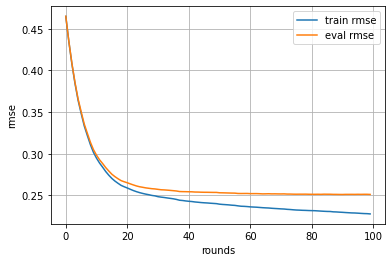

[0]	train-rmse:0.464882	eval-rmse:0.465115
[1]	train-rmse:0.434367	eval-rmse:0.434858
[2]	train-rmse:0.407523	eval-rmse:0.408341
[3]	train-rmse:0.384294	eval-rmse:0.385448
[4]	train-rmse:0.364282	eval-rmse:0.365863
[5]	train-rmse:0.348439	eval-rmse:0.350499
[6]	train-rmse:0.333501	eval-rmse:0.335794
[7]	train-rmse:0.322095	eval-rmse:0.324771
[8]	train-rmse:0.311053	eval-rmse:0.313968
[9]	train-rmse:0.30174	eval-rmse:0.305016
[10]	train-rmse:0.294744	eval-rmse:0.298334
[11]	train-rmse:0.288824	eval-rmse:0.292769
[12]	train-rmse:0.283861	eval-rmse:0.288252
[13]	train-rmse:0.278676	eval-rmse:0.283427
[14]	train-rmse:0.274267	eval-rmse:0.2793
[15]	train-rmse:0.270416	eval-rmse:0.275466
[16]	train-rmse:0.267259	eval-rmse:0.272552
[17]	train-rmse:0.264598	eval-rmse:0.27005
[18]	train-rmse:0.262113	eval-rmse:0.267808
[19]	train-rmse:0.260482	eval-rmse:0.266473
[20]	train-rmse:0.259005	eval-rmse:0.265287
[21]	train-rmse:0.2574	eval-rmse:0.263912
[22]	train-rmse:0.255877	eval-rmse:0.262633
[23]

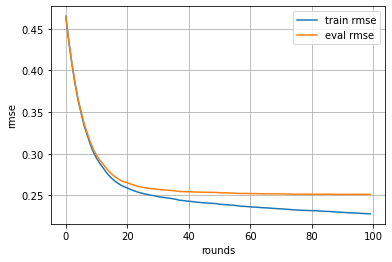

[0]	train-rmse:0.464882	eval-rmse:0.465115
[1]	train-rmse:0.434367	eval-rmse:0.434858
[2]	train-rmse:0.407523	eval-rmse:0.408341
[3]	train-rmse:0.384294	eval-rmse:0.385448
[4]	train-rmse:0.364282	eval-rmse:0.365863
[5]	train-rmse:0.348439	eval-rmse:0.350499
[6]	train-rmse:0.333501	eval-rmse:0.335794
[7]	train-rmse:0.322095	eval-rmse:0.324771
[8]	train-rmse:0.311053	eval-rmse:0.313968
[9]	train-rmse:0.30174	eval-rmse:0.305016
[10]	train-rmse:0.294744	eval-rmse:0.298334
[11]	train-rmse:0.288824	eval-rmse:0.292769
[12]	train-rmse:0.283861	eval-rmse:0.288252
[13]	train-rmse:0.278676	eval-rmse:0.283427
[14]	train-rmse:0.274267	eval-rmse:0.2793
[15]	train-rmse:0.270416	eval-rmse:0.275466
[16]	train-rmse:0.267259	eval-rmse:0.272552
[17]	train-rmse:0.264598	eval-rmse:0.27005
[18]	train-rmse:0.262113	eval-rmse:0.267808
[19]	train-rmse:0.260482	eval-rmse:0.266473
[20]	train-rmse:0.259005	eval-rmse:0.265287
[21]	train-rmse:0.2574	eval-rmse:0.263912
[22]	train-rmse:0.255877	eval-rmse:0.262633
[23]

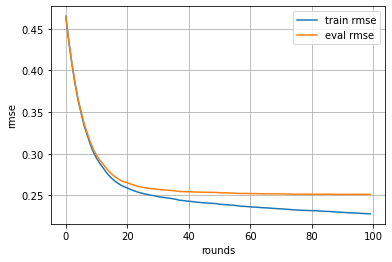

[0]	train-rmse:0.464882	eval-rmse:0.465115
[1]	train-rmse:0.434367	eval-rmse:0.434858
[2]	train-rmse:0.407523	eval-rmse:0.408341
[3]	train-rmse:0.384294	eval-rmse:0.385448
[4]	train-rmse:0.364282	eval-rmse:0.365863
[5]	train-rmse:0.348439	eval-rmse:0.350499
[6]	train-rmse:0.333501	eval-rmse:0.335794
[7]	train-rmse:0.322095	eval-rmse:0.324771
[8]	train-rmse:0.311053	eval-rmse:0.313968
[9]	train-rmse:0.30174	eval-rmse:0.305016
[10]	train-rmse:0.294744	eval-rmse:0.298334
[11]	train-rmse:0.288824	eval-rmse:0.292769
[12]	train-rmse:0.283861	eval-rmse:0.288252
[13]	train-rmse:0.278676	eval-rmse:0.283427
[14]	train-rmse:0.274267	eval-rmse:0.2793
[15]	train-rmse:0.270416	eval-rmse:0.275466
[16]	train-rmse:0.267259	eval-rmse:0.272552
[17]	train-rmse:0.264598	eval-rmse:0.27005
[18]	train-rmse:0.262113	eval-rmse:0.267808
[19]	train-rmse:0.260482	eval-rmse:0.266473
[20]	train-rmse:0.259005	eval-rmse:0.265287
[21]	train-rmse:0.2574	eval-rmse:0.263912
[22]	train-rmse:0.255877	eval-rmse:0.262633
[23]

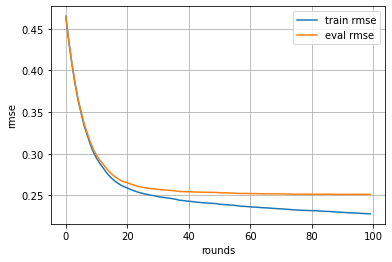

[0]	train-rmse:0.464882	eval-rmse:0.465115
[1]	train-rmse:0.434367	eval-rmse:0.434858
[2]	train-rmse:0.407523	eval-rmse:0.408341
[3]	train-rmse:0.384294	eval-rmse:0.385448
[4]	train-rmse:0.364282	eval-rmse:0.365863
[5]	train-rmse:0.348439	eval-rmse:0.350499
[6]	train-rmse:0.333501	eval-rmse:0.335794
[7]	train-rmse:0.322095	eval-rmse:0.324771
[8]	train-rmse:0.311053	eval-rmse:0.313968
[9]	train-rmse:0.30174	eval-rmse:0.305016
[10]	train-rmse:0.294744	eval-rmse:0.298334
[11]	train-rmse:0.288824	eval-rmse:0.292769
[12]	train-rmse:0.283861	eval-rmse:0.288252
[13]	train-rmse:0.278676	eval-rmse:0.283427
[14]	train-rmse:0.274267	eval-rmse:0.2793
[15]	train-rmse:0.270416	eval-rmse:0.275466
[16]	train-rmse:0.267259	eval-rmse:0.272552
[17]	train-rmse:0.264598	eval-rmse:0.27005
[18]	train-rmse:0.262113	eval-rmse:0.267808
[19]	train-rmse:0.260482	eval-rmse:0.266473
[20]	train-rmse:0.259005	eval-rmse:0.265287
[21]	train-rmse:0.2574	eval-rmse:0.263912
[22]	train-rmse:0.255877	eval-rmse:0.262633
[23]

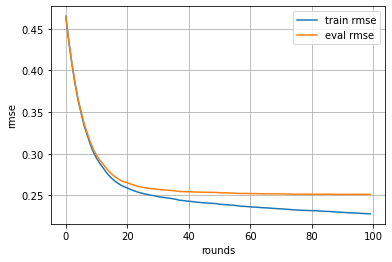

[0]	train-rmse:0.464882	eval-rmse:0.465115
[1]	train-rmse:0.434367	eval-rmse:0.434858
[2]	train-rmse:0.407523	eval-rmse:0.408341
[3]	train-rmse:0.384294	eval-rmse:0.385448
[4]	train-rmse:0.364282	eval-rmse:0.365863
[5]	train-rmse:0.348439	eval-rmse:0.350499
[6]	train-rmse:0.333501	eval-rmse:0.335794
[7]	train-rmse:0.322095	eval-rmse:0.324771
[8]	train-rmse:0.311053	eval-rmse:0.313968
[9]	train-rmse:0.30174	eval-rmse:0.305016
[10]	train-rmse:0.294744	eval-rmse:0.298334
[11]	train-rmse:0.288824	eval-rmse:0.292769
[12]	train-rmse:0.283861	eval-rmse:0.288252
[13]	train-rmse:0.278676	eval-rmse:0.283427
[14]	train-rmse:0.274268	eval-rmse:0.2793
[15]	train-rmse:0.270416	eval-rmse:0.275466
[16]	train-rmse:0.267259	eval-rmse:0.272552
[17]	train-rmse:0.264598	eval-rmse:0.27005
[18]	train-rmse:0.262113	eval-rmse:0.267808
[19]	train-rmse:0.260482	eval-rmse:0.266473
[20]	train-rmse:0.259005	eval-rmse:0.265287
[21]	train-rmse:0.2574	eval-rmse:0.263912
[22]	train-rmse:0.255877	eval-rmse:0.262633
[23]

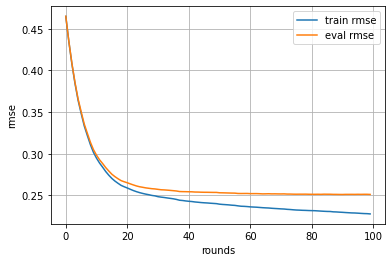

[0]	train-rmse:0.464882	eval-rmse:0.465115
[1]	train-rmse:0.434367	eval-rmse:0.434858
[2]	train-rmse:0.407523	eval-rmse:0.408341
[3]	train-rmse:0.384294	eval-rmse:0.385448
[4]	train-rmse:0.364282	eval-rmse:0.365863
[5]	train-rmse:0.348439	eval-rmse:0.350499
[6]	train-rmse:0.333501	eval-rmse:0.335794
[7]	train-rmse:0.322095	eval-rmse:0.324771
[8]	train-rmse:0.311053	eval-rmse:0.313968
[9]	train-rmse:0.30174	eval-rmse:0.305016
[10]	train-rmse:0.294744	eval-rmse:0.298334
[11]	train-rmse:0.288824	eval-rmse:0.292769
[12]	train-rmse:0.283861	eval-rmse:0.288252
[13]	train-rmse:0.278676	eval-rmse:0.283427
[14]	train-rmse:0.274267	eval-rmse:0.2793
[15]	train-rmse:0.270416	eval-rmse:0.275466
[16]	train-rmse:0.267259	eval-rmse:0.272552
[17]	train-rmse:0.264598	eval-rmse:0.27005
[18]	train-rmse:0.262113	eval-rmse:0.267808
[19]	train-rmse:0.260482	eval-rmse:0.266473
[20]	train-rmse:0.259005	eval-rmse:0.265287
[21]	train-rmse:0.2574	eval-rmse:0.263912
[22]	train-rmse:0.255877	eval-rmse:0.262633
[23]

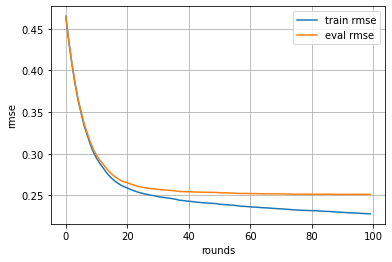

[0]	train-rmse:0.464882	eval-rmse:0.465115
[1]	train-rmse:0.434367	eval-rmse:0.434858
[2]	train-rmse:0.407523	eval-rmse:0.408341
[3]	train-rmse:0.384294	eval-rmse:0.385448
[4]	train-rmse:0.364282	eval-rmse:0.365863
[5]	train-rmse:0.348439	eval-rmse:0.350499
[6]	train-rmse:0.333501	eval-rmse:0.335794
[7]	train-rmse:0.322095	eval-rmse:0.324771
[8]	train-rmse:0.311053	eval-rmse:0.313968
[9]	train-rmse:0.30174	eval-rmse:0.305016
[10]	train-rmse:0.294744	eval-rmse:0.298334
[11]	train-rmse:0.288824	eval-rmse:0.292769
[12]	train-rmse:0.283861	eval-rmse:0.288252
[13]	train-rmse:0.278676	eval-rmse:0.283427
[14]	train-rmse:0.274267	eval-rmse:0.2793
[15]	train-rmse:0.270416	eval-rmse:0.275466
[16]	train-rmse:0.267259	eval-rmse:0.272552
[17]	train-rmse:0.264598	eval-rmse:0.27005
[18]	train-rmse:0.262113	eval-rmse:0.267808
[19]	train-rmse:0.260482	eval-rmse:0.266473
[20]	train-rmse:0.259005	eval-rmse:0.265287
[21]	train-rmse:0.2574	eval-rmse:0.263912
[22]	train-rmse:0.255877	eval-rmse:0.262633
[23]

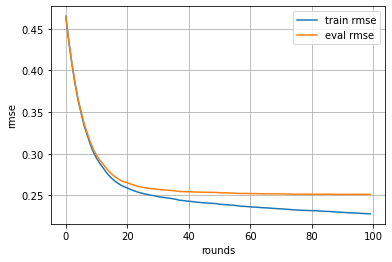

[0]	train-rmse:0.464887	eval-rmse:0.465106
[1]	train-rmse:0.434379	eval-rmse:0.434846
[2]	train-rmse:0.407536	eval-rmse:0.408335
[3]	train-rmse:0.384307	eval-rmse:0.385442
[4]	train-rmse:0.364296	eval-rmse:0.365878
[5]	train-rmse:0.348457	eval-rmse:0.350516
[6]	train-rmse:0.333527	eval-rmse:0.335811
[7]	train-rmse:0.322121	eval-rmse:0.324788
[8]	train-rmse:0.311079	eval-rmse:0.313985
[9]	train-rmse:0.301773	eval-rmse:0.305039
[10]	train-rmse:0.29478	eval-rmse:0.298408
[11]	train-rmse:0.28888	eval-rmse:0.292837
[12]	train-rmse:0.283957	eval-rmse:0.288349
[13]	train-rmse:0.278757	eval-rmse:0.283526
[14]	train-rmse:0.274356	eval-rmse:0.279387
[15]	train-rmse:0.270505	eval-rmse:0.275533
[16]	train-rmse:0.267345	eval-rmse:0.272635
[17]	train-rmse:0.264438	eval-rmse:0.269964
[18]	train-rmse:0.261986	eval-rmse:0.267749
[19]	train-rmse:0.260374	eval-rmse:0.266333
[20]	train-rmse:0.258919	eval-rmse:0.265109
[21]	train-rmse:0.257299	eval-rmse:0.263814
[22]	train-rmse:0.255765	eval-rmse:0.262513


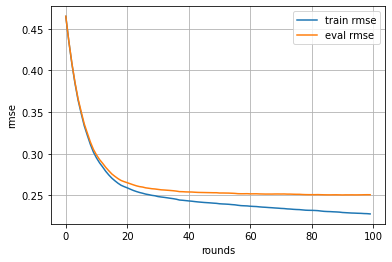

[0]	train-rmse:0.464887	eval-rmse:0.465106
[1]	train-rmse:0.434379	eval-rmse:0.434846
[2]	train-rmse:0.407536	eval-rmse:0.408335
[3]	train-rmse:0.384307	eval-rmse:0.385442
[4]	train-rmse:0.364296	eval-rmse:0.365878
[5]	train-rmse:0.348457	eval-rmse:0.350516
[6]	train-rmse:0.333527	eval-rmse:0.335811
[7]	train-rmse:0.322121	eval-rmse:0.324788
[8]	train-rmse:0.311079	eval-rmse:0.313985
[9]	train-rmse:0.301773	eval-rmse:0.305039
[10]	train-rmse:0.29478	eval-rmse:0.298408
[11]	train-rmse:0.28888	eval-rmse:0.292837
[12]	train-rmse:0.283957	eval-rmse:0.288349
[13]	train-rmse:0.278757	eval-rmse:0.283526
[14]	train-rmse:0.274356	eval-rmse:0.279387
[15]	train-rmse:0.270505	eval-rmse:0.275533
[16]	train-rmse:0.267345	eval-rmse:0.272635
[17]	train-rmse:0.264438	eval-rmse:0.269964
[18]	train-rmse:0.261986	eval-rmse:0.267749
[19]	train-rmse:0.260374	eval-rmse:0.266333
[20]	train-rmse:0.258919	eval-rmse:0.265109
[21]	train-rmse:0.257299	eval-rmse:0.263814
[22]	train-rmse:0.255765	eval-rmse:0.262513


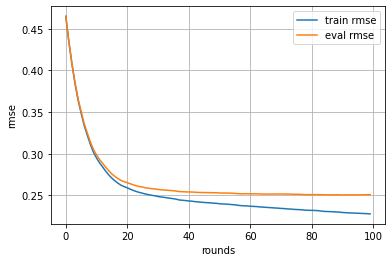

[0]	train-rmse:0.464887	eval-rmse:0.465106
[1]	train-rmse:0.434379	eval-rmse:0.434846
[2]	train-rmse:0.407536	eval-rmse:0.408335
[3]	train-rmse:0.384307	eval-rmse:0.385442
[4]	train-rmse:0.364296	eval-rmse:0.365878
[5]	train-rmse:0.348457	eval-rmse:0.350516
[6]	train-rmse:0.333527	eval-rmse:0.335811
[7]	train-rmse:0.322121	eval-rmse:0.324788
[8]	train-rmse:0.311079	eval-rmse:0.313985
[9]	train-rmse:0.301773	eval-rmse:0.305039
[10]	train-rmse:0.29478	eval-rmse:0.298408
[11]	train-rmse:0.28888	eval-rmse:0.292837
[12]	train-rmse:0.283957	eval-rmse:0.288349
[13]	train-rmse:0.278757	eval-rmse:0.283526
[14]	train-rmse:0.274356	eval-rmse:0.279387
[15]	train-rmse:0.270505	eval-rmse:0.275533
[16]	train-rmse:0.267345	eval-rmse:0.272635
[17]	train-rmse:0.264438	eval-rmse:0.269964
[18]	train-rmse:0.261986	eval-rmse:0.267749
[19]	train-rmse:0.260374	eval-rmse:0.266333
[20]	train-rmse:0.258919	eval-rmse:0.265109
[21]	train-rmse:0.257299	eval-rmse:0.263814
[22]	train-rmse:0.255765	eval-rmse:0.262513


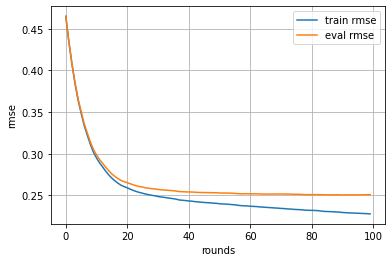

[0]	train-rmse:0.464887	eval-rmse:0.465106
[1]	train-rmse:0.434379	eval-rmse:0.434846
[2]	train-rmse:0.407536	eval-rmse:0.408335
[3]	train-rmse:0.384307	eval-rmse:0.385442
[4]	train-rmse:0.364296	eval-rmse:0.365878
[5]	train-rmse:0.348457	eval-rmse:0.350516
[6]	train-rmse:0.333527	eval-rmse:0.335811
[7]	train-rmse:0.322121	eval-rmse:0.324788
[8]	train-rmse:0.311079	eval-rmse:0.313985
[9]	train-rmse:0.301773	eval-rmse:0.305039
[10]	train-rmse:0.29478	eval-rmse:0.298408
[11]	train-rmse:0.28888	eval-rmse:0.292837
[12]	train-rmse:0.283957	eval-rmse:0.288349
[13]	train-rmse:0.278757	eval-rmse:0.283526
[14]	train-rmse:0.274356	eval-rmse:0.279387
[15]	train-rmse:0.270505	eval-rmse:0.275533
[16]	train-rmse:0.267345	eval-rmse:0.272635
[17]	train-rmse:0.264438	eval-rmse:0.269964
[18]	train-rmse:0.261986	eval-rmse:0.267749
[19]	train-rmse:0.260374	eval-rmse:0.266333
[20]	train-rmse:0.258919	eval-rmse:0.265109
[21]	train-rmse:0.257299	eval-rmse:0.263814
[22]	train-rmse:0.255765	eval-rmse:0.262513


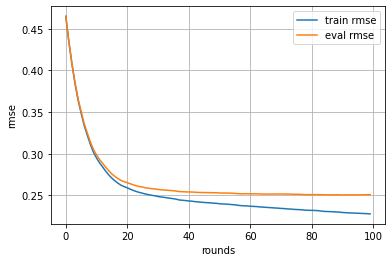

[0]	train-rmse:0.464887	eval-rmse:0.465106
[1]	train-rmse:0.434379	eval-rmse:0.434846
[2]	train-rmse:0.407536	eval-rmse:0.408335
[3]	train-rmse:0.384307	eval-rmse:0.385442
[4]	train-rmse:0.364296	eval-rmse:0.365878
[5]	train-rmse:0.348457	eval-rmse:0.350516
[6]	train-rmse:0.333527	eval-rmse:0.335811
[7]	train-rmse:0.322121	eval-rmse:0.324788
[8]	train-rmse:0.311079	eval-rmse:0.313985
[9]	train-rmse:0.301773	eval-rmse:0.305039
[10]	train-rmse:0.29478	eval-rmse:0.298408
[11]	train-rmse:0.28888	eval-rmse:0.292837
[12]	train-rmse:0.283957	eval-rmse:0.288349
[13]	train-rmse:0.278757	eval-rmse:0.283526
[14]	train-rmse:0.274356	eval-rmse:0.279387
[15]	train-rmse:0.270505	eval-rmse:0.275533
[16]	train-rmse:0.267345	eval-rmse:0.272635
[17]	train-rmse:0.264438	eval-rmse:0.269964
[18]	train-rmse:0.261986	eval-rmse:0.267749
[19]	train-rmse:0.260374	eval-rmse:0.266333
[20]	train-rmse:0.258919	eval-rmse:0.265109
[21]	train-rmse:0.257299	eval-rmse:0.263814
[22]	train-rmse:0.255765	eval-rmse:0.262513


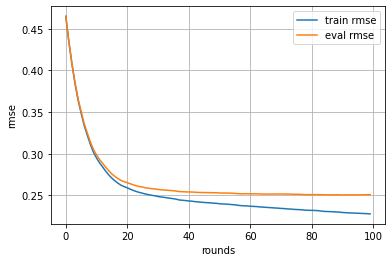

[0]	train-rmse:0.464887	eval-rmse:0.465106
[1]	train-rmse:0.434379	eval-rmse:0.434846
[2]	train-rmse:0.407536	eval-rmse:0.408335
[3]	train-rmse:0.384307	eval-rmse:0.385442
[4]	train-rmse:0.364296	eval-rmse:0.365878
[5]	train-rmse:0.348457	eval-rmse:0.350516
[6]	train-rmse:0.333527	eval-rmse:0.335811
[7]	train-rmse:0.322121	eval-rmse:0.324788
[8]	train-rmse:0.311079	eval-rmse:0.313985
[9]	train-rmse:0.301773	eval-rmse:0.305039
[10]	train-rmse:0.29478	eval-rmse:0.298408
[11]	train-rmse:0.28888	eval-rmse:0.292837
[12]	train-rmse:0.283957	eval-rmse:0.288349
[13]	train-rmse:0.278757	eval-rmse:0.283526
[14]	train-rmse:0.274356	eval-rmse:0.279387
[15]	train-rmse:0.270505	eval-rmse:0.275533
[16]	train-rmse:0.267345	eval-rmse:0.272635
[17]	train-rmse:0.264438	eval-rmse:0.269964
[18]	train-rmse:0.261986	eval-rmse:0.267749
[19]	train-rmse:0.260374	eval-rmse:0.266333
[20]	train-rmse:0.258919	eval-rmse:0.265109
[21]	train-rmse:0.257299	eval-rmse:0.263814
[22]	train-rmse:0.255765	eval-rmse:0.262513


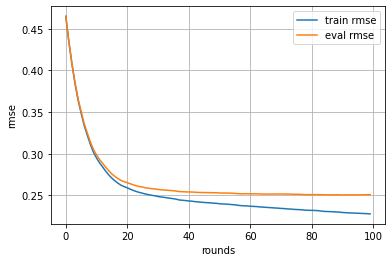

[0]	train-rmse:0.464887	eval-rmse:0.465106
[1]	train-rmse:0.434379	eval-rmse:0.434846
[2]	train-rmse:0.407536	eval-rmse:0.408335
[3]	train-rmse:0.384307	eval-rmse:0.385442
[4]	train-rmse:0.364296	eval-rmse:0.365878
[5]	train-rmse:0.348457	eval-rmse:0.350516
[6]	train-rmse:0.333527	eval-rmse:0.335811
[7]	train-rmse:0.322121	eval-rmse:0.324788
[8]	train-rmse:0.311079	eval-rmse:0.313985
[9]	train-rmse:0.301773	eval-rmse:0.305039
[10]	train-rmse:0.29478	eval-rmse:0.298408
[11]	train-rmse:0.28888	eval-rmse:0.292837
[12]	train-rmse:0.283957	eval-rmse:0.288349
[13]	train-rmse:0.278757	eval-rmse:0.283526
[14]	train-rmse:0.274356	eval-rmse:0.279387
[15]	train-rmse:0.270505	eval-rmse:0.275533
[16]	train-rmse:0.267345	eval-rmse:0.272635
[17]	train-rmse:0.264438	eval-rmse:0.269964
[18]	train-rmse:0.261986	eval-rmse:0.267749
[19]	train-rmse:0.260374	eval-rmse:0.266333
[20]	train-rmse:0.258919	eval-rmse:0.265109
[21]	train-rmse:0.257299	eval-rmse:0.263814
[22]	train-rmse:0.255765	eval-rmse:0.262513


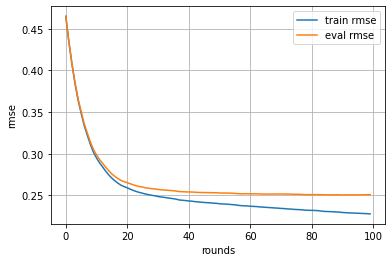

[0]	train-rmse:0.464887	eval-rmse:0.465106
[1]	train-rmse:0.434379	eval-rmse:0.434846
[2]	train-rmse:0.407536	eval-rmse:0.408335
[3]	train-rmse:0.384307	eval-rmse:0.385442
[4]	train-rmse:0.364296	eval-rmse:0.365878
[5]	train-rmse:0.348457	eval-rmse:0.350516
[6]	train-rmse:0.333527	eval-rmse:0.335811
[7]	train-rmse:0.322121	eval-rmse:0.324788
[8]	train-rmse:0.311079	eval-rmse:0.313985
[9]	train-rmse:0.301773	eval-rmse:0.305039
[10]	train-rmse:0.29478	eval-rmse:0.298408
[11]	train-rmse:0.28888	eval-rmse:0.292837
[12]	train-rmse:0.283957	eval-rmse:0.288349
[13]	train-rmse:0.278757	eval-rmse:0.283526
[14]	train-rmse:0.274356	eval-rmse:0.279387
[15]	train-rmse:0.270505	eval-rmse:0.275533
[16]	train-rmse:0.267345	eval-rmse:0.272635
[17]	train-rmse:0.264438	eval-rmse:0.269964
[18]	train-rmse:0.261986	eval-rmse:0.267749
[19]	train-rmse:0.260374	eval-rmse:0.266333
[20]	train-rmse:0.258919	eval-rmse:0.265109
[21]	train-rmse:0.257299	eval-rmse:0.263814
[22]	train-rmse:0.255765	eval-rmse:0.262513


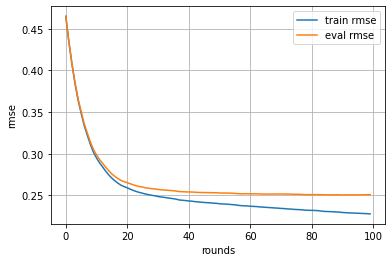

[0]	train-rmse:0.464887	eval-rmse:0.465106
[1]	train-rmse:0.434379	eval-rmse:0.434846
[2]	train-rmse:0.407536	eval-rmse:0.408335
[3]	train-rmse:0.384307	eval-rmse:0.385442
[4]	train-rmse:0.364296	eval-rmse:0.365878
[5]	train-rmse:0.348457	eval-rmse:0.350516
[6]	train-rmse:0.333527	eval-rmse:0.335811
[7]	train-rmse:0.322121	eval-rmse:0.324788
[8]	train-rmse:0.311079	eval-rmse:0.313985
[9]	train-rmse:0.301773	eval-rmse:0.305039
[10]	train-rmse:0.29478	eval-rmse:0.298408
[11]	train-rmse:0.28888	eval-rmse:0.292837
[12]	train-rmse:0.283957	eval-rmse:0.288349
[13]	train-rmse:0.278757	eval-rmse:0.283526
[14]	train-rmse:0.274356	eval-rmse:0.279387
[15]	train-rmse:0.270505	eval-rmse:0.275533
[16]	train-rmse:0.267345	eval-rmse:0.272635
[17]	train-rmse:0.264438	eval-rmse:0.269964
[18]	train-rmse:0.261986	eval-rmse:0.267749
[19]	train-rmse:0.260374	eval-rmse:0.266333
[20]	train-rmse:0.258919	eval-rmse:0.265109
[21]	train-rmse:0.257299	eval-rmse:0.263814
[22]	train-rmse:0.255765	eval-rmse:0.262513


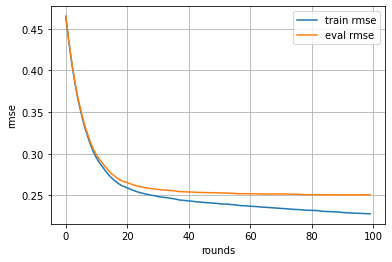

[0]	train-rmse:0.464887	eval-rmse:0.465106
[1]	train-rmse:0.434379	eval-rmse:0.434846
[2]	train-rmse:0.407536	eval-rmse:0.408335
[3]	train-rmse:0.384307	eval-rmse:0.385442
[4]	train-rmse:0.364296	eval-rmse:0.365878
[5]	train-rmse:0.348457	eval-rmse:0.350516
[6]	train-rmse:0.333527	eval-rmse:0.335811
[7]	train-rmse:0.322121	eval-rmse:0.324788
[8]	train-rmse:0.311079	eval-rmse:0.313985
[9]	train-rmse:0.301773	eval-rmse:0.305039
[10]	train-rmse:0.29478	eval-rmse:0.298408
[11]	train-rmse:0.28888	eval-rmse:0.292837
[12]	train-rmse:0.283957	eval-rmse:0.288349
[13]	train-rmse:0.278757	eval-rmse:0.283526
[14]	train-rmse:0.274356	eval-rmse:0.279387
[15]	train-rmse:0.270505	eval-rmse:0.275533
[16]	train-rmse:0.267345	eval-rmse:0.272635
[17]	train-rmse:0.264438	eval-rmse:0.269964
[18]	train-rmse:0.261986	eval-rmse:0.267749
[19]	train-rmse:0.260374	eval-rmse:0.266333
[20]	train-rmse:0.258919	eval-rmse:0.265109
[21]	train-rmse:0.257299	eval-rmse:0.263814
[22]	train-rmse:0.255765	eval-rmse:0.262513


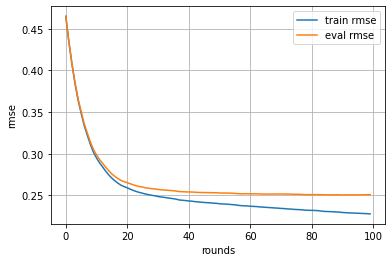

[0]	train-rmse:0.464886	eval-rmse:0.465104
[1]	train-rmse:0.43438	eval-rmse:0.434843
[2]	train-rmse:0.407539	eval-rmse:0.408342
[3]	train-rmse:0.384312	eval-rmse:0.385448
[4]	train-rmse:0.364309	eval-rmse:0.365896
[5]	train-rmse:0.348509	eval-rmse:0.35053
[6]	train-rmse:0.333585	eval-rmse:0.335841
[7]	train-rmse:0.322235	eval-rmse:0.324987
[8]	train-rmse:0.311191	eval-rmse:0.314181
[9]	train-rmse:0.301871	eval-rmse:0.305185
[10]	train-rmse:0.294894	eval-rmse:0.298514
[11]	train-rmse:0.288996	eval-rmse:0.292926
[12]	train-rmse:0.284083	eval-rmse:0.288444
[13]	train-rmse:0.278891	eval-rmse:0.283612
[14]	train-rmse:0.274491	eval-rmse:0.279474
[15]	train-rmse:0.270644	eval-rmse:0.275618
[16]	train-rmse:0.267485	eval-rmse:0.272693
[17]	train-rmse:0.264692	eval-rmse:0.270102
[18]	train-rmse:0.262199	eval-rmse:0.267819
[19]	train-rmse:0.260564	eval-rmse:0.266405
[20]	train-rmse:0.259093	eval-rmse:0.26515
[21]	train-rmse:0.257448	eval-rmse:0.263696
[22]	train-rmse:0.255893	eval-rmse:0.262317
[

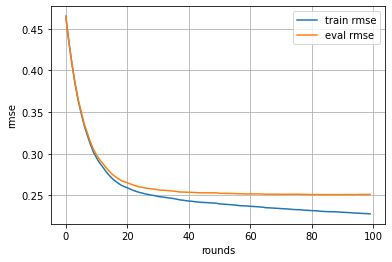

[0]	train-rmse:0.464886	eval-rmse:0.465104
[1]	train-rmse:0.43438	eval-rmse:0.434843
[2]	train-rmse:0.407539	eval-rmse:0.408342
[3]	train-rmse:0.384312	eval-rmse:0.385448
[4]	train-rmse:0.364309	eval-rmse:0.365896
[5]	train-rmse:0.348509	eval-rmse:0.35053
[6]	train-rmse:0.333585	eval-rmse:0.335841
[7]	train-rmse:0.322235	eval-rmse:0.324987
[8]	train-rmse:0.311191	eval-rmse:0.314181
[9]	train-rmse:0.301871	eval-rmse:0.305185
[10]	train-rmse:0.294894	eval-rmse:0.298514
[11]	train-rmse:0.288996	eval-rmse:0.292926
[12]	train-rmse:0.284083	eval-rmse:0.288444
[13]	train-rmse:0.278891	eval-rmse:0.283612
[14]	train-rmse:0.274491	eval-rmse:0.279474
[15]	train-rmse:0.270644	eval-rmse:0.275618
[16]	train-rmse:0.267485	eval-rmse:0.272693
[17]	train-rmse:0.264692	eval-rmse:0.270102
[18]	train-rmse:0.262199	eval-rmse:0.267819
[19]	train-rmse:0.260564	eval-rmse:0.266405
[20]	train-rmse:0.259093	eval-rmse:0.26515
[21]	train-rmse:0.257448	eval-rmse:0.263696
[22]	train-rmse:0.255893	eval-rmse:0.262317
[

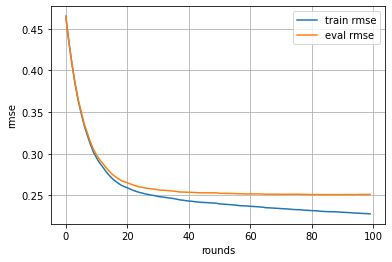

[0]	train-rmse:0.464886	eval-rmse:0.465104
[1]	train-rmse:0.43438	eval-rmse:0.434843
[2]	train-rmse:0.407539	eval-rmse:0.408342
[3]	train-rmse:0.384312	eval-rmse:0.385448
[4]	train-rmse:0.364309	eval-rmse:0.365896
[5]	train-rmse:0.348509	eval-rmse:0.35053
[6]	train-rmse:0.333585	eval-rmse:0.335841
[7]	train-rmse:0.322235	eval-rmse:0.324987
[8]	train-rmse:0.311191	eval-rmse:0.314181
[9]	train-rmse:0.301871	eval-rmse:0.305185
[10]	train-rmse:0.294894	eval-rmse:0.298514
[11]	train-rmse:0.288996	eval-rmse:0.292926
[12]	train-rmse:0.284083	eval-rmse:0.288444
[13]	train-rmse:0.278891	eval-rmse:0.283612
[14]	train-rmse:0.274491	eval-rmse:0.279474
[15]	train-rmse:0.270644	eval-rmse:0.275618
[16]	train-rmse:0.267485	eval-rmse:0.272693
[17]	train-rmse:0.264692	eval-rmse:0.270102
[18]	train-rmse:0.262199	eval-rmse:0.267819
[19]	train-rmse:0.260564	eval-rmse:0.266405
[20]	train-rmse:0.259093	eval-rmse:0.26515
[21]	train-rmse:0.257448	eval-rmse:0.263696
[22]	train-rmse:0.255893	eval-rmse:0.262317
[

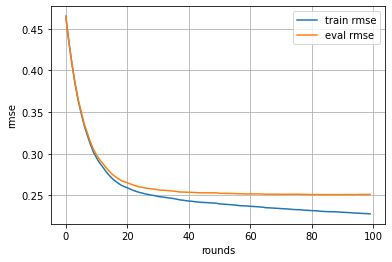

[0]	train-rmse:0.464886	eval-rmse:0.465104
[1]	train-rmse:0.43438	eval-rmse:0.434843
[2]	train-rmse:0.407539	eval-rmse:0.408342
[3]	train-rmse:0.384312	eval-rmse:0.385448
[4]	train-rmse:0.364309	eval-rmse:0.365896
[5]	train-rmse:0.348509	eval-rmse:0.35053
[6]	train-rmse:0.333585	eval-rmse:0.335841
[7]	train-rmse:0.322235	eval-rmse:0.324987
[8]	train-rmse:0.311191	eval-rmse:0.314181
[9]	train-rmse:0.301871	eval-rmse:0.305185
[10]	train-rmse:0.294894	eval-rmse:0.298514
[11]	train-rmse:0.288996	eval-rmse:0.292926
[12]	train-rmse:0.284083	eval-rmse:0.288444
[13]	train-rmse:0.278891	eval-rmse:0.283612
[14]	train-rmse:0.274491	eval-rmse:0.279474
[15]	train-rmse:0.270644	eval-rmse:0.275618
[16]	train-rmse:0.267485	eval-rmse:0.272693
[17]	train-rmse:0.264692	eval-rmse:0.270102
[18]	train-rmse:0.262199	eval-rmse:0.267819
[19]	train-rmse:0.260564	eval-rmse:0.266405
[20]	train-rmse:0.259093	eval-rmse:0.26515
[21]	train-rmse:0.257448	eval-rmse:0.263696
[22]	train-rmse:0.255893	eval-rmse:0.262317
[

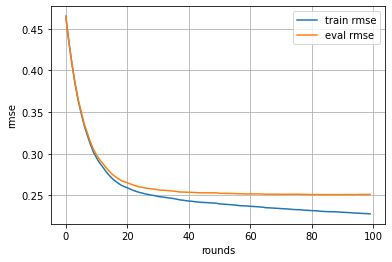

[0]	train-rmse:0.464886	eval-rmse:0.465104
[1]	train-rmse:0.43438	eval-rmse:0.434843
[2]	train-rmse:0.407539	eval-rmse:0.408342
[3]	train-rmse:0.384312	eval-rmse:0.385448
[4]	train-rmse:0.364309	eval-rmse:0.365896
[5]	train-rmse:0.348509	eval-rmse:0.35053
[6]	train-rmse:0.333585	eval-rmse:0.335841
[7]	train-rmse:0.322235	eval-rmse:0.324987
[8]	train-rmse:0.311191	eval-rmse:0.314181
[9]	train-rmse:0.301871	eval-rmse:0.305185
[10]	train-rmse:0.294894	eval-rmse:0.298514
[11]	train-rmse:0.288996	eval-rmse:0.292926
[12]	train-rmse:0.284083	eval-rmse:0.288444
[13]	train-rmse:0.278891	eval-rmse:0.283612
[14]	train-rmse:0.274491	eval-rmse:0.279474
[15]	train-rmse:0.270644	eval-rmse:0.275618
[16]	train-rmse:0.267485	eval-rmse:0.272693
[17]	train-rmse:0.264692	eval-rmse:0.270102
[18]	train-rmse:0.262199	eval-rmse:0.267819
[19]	train-rmse:0.260564	eval-rmse:0.266405
[20]	train-rmse:0.259093	eval-rmse:0.26515
[21]	train-rmse:0.257448	eval-rmse:0.263696
[22]	train-rmse:0.255893	eval-rmse:0.262317
[

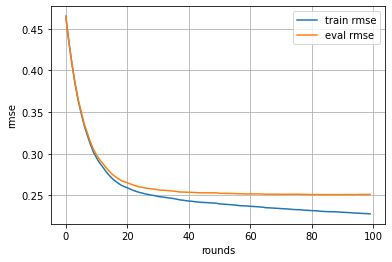

[0]	train-rmse:0.464886	eval-rmse:0.465104
[1]	train-rmse:0.43438	eval-rmse:0.434843
[2]	train-rmse:0.407539	eval-rmse:0.408342
[3]	train-rmse:0.384312	eval-rmse:0.385448
[4]	train-rmse:0.364309	eval-rmse:0.365896
[5]	train-rmse:0.348509	eval-rmse:0.35053
[6]	train-rmse:0.333585	eval-rmse:0.335841
[7]	train-rmse:0.322235	eval-rmse:0.324987
[8]	train-rmse:0.311191	eval-rmse:0.314181
[9]	train-rmse:0.301871	eval-rmse:0.305185
[10]	train-rmse:0.294894	eval-rmse:0.298514
[11]	train-rmse:0.288996	eval-rmse:0.292926
[12]	train-rmse:0.284083	eval-rmse:0.288444
[13]	train-rmse:0.278891	eval-rmse:0.283612
[14]	train-rmse:0.274491	eval-rmse:0.279474
[15]	train-rmse:0.270644	eval-rmse:0.275618
[16]	train-rmse:0.267485	eval-rmse:0.272693
[17]	train-rmse:0.264692	eval-rmse:0.270102
[18]	train-rmse:0.262199	eval-rmse:0.267819
[19]	train-rmse:0.260564	eval-rmse:0.266405
[20]	train-rmse:0.259093	eval-rmse:0.26515
[21]	train-rmse:0.257448	eval-rmse:0.263696
[22]	train-rmse:0.255893	eval-rmse:0.262317
[

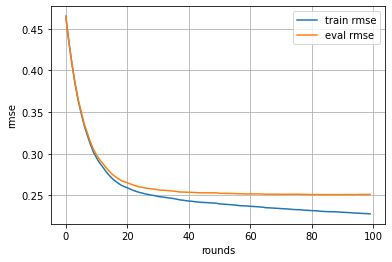

[0]	train-rmse:0.464886	eval-rmse:0.465104
[1]	train-rmse:0.43438	eval-rmse:0.434843
[2]	train-rmse:0.407539	eval-rmse:0.408342
[3]	train-rmse:0.384312	eval-rmse:0.385448
[4]	train-rmse:0.364309	eval-rmse:0.365896
[5]	train-rmse:0.348509	eval-rmse:0.35053
[6]	train-rmse:0.333585	eval-rmse:0.335841
[7]	train-rmse:0.322235	eval-rmse:0.324987
[8]	train-rmse:0.311191	eval-rmse:0.314181
[9]	train-rmse:0.301871	eval-rmse:0.305185
[10]	train-rmse:0.294894	eval-rmse:0.298514
[11]	train-rmse:0.288996	eval-rmse:0.292926
[12]	train-rmse:0.284083	eval-rmse:0.288444
[13]	train-rmse:0.278891	eval-rmse:0.283612
[14]	train-rmse:0.274491	eval-rmse:0.279474
[15]	train-rmse:0.270644	eval-rmse:0.275618
[16]	train-rmse:0.267485	eval-rmse:0.272693
[17]	train-rmse:0.264692	eval-rmse:0.270102
[18]	train-rmse:0.262199	eval-rmse:0.267819
[19]	train-rmse:0.260564	eval-rmse:0.266405
[20]	train-rmse:0.259093	eval-rmse:0.26515
[21]	train-rmse:0.257448	eval-rmse:0.263696
[22]	train-rmse:0.255893	eval-rmse:0.262317
[

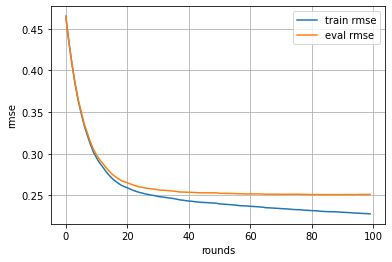

[0]	train-rmse:0.464886	eval-rmse:0.465104
[1]	train-rmse:0.43438	eval-rmse:0.434843
[2]	train-rmse:0.407539	eval-rmse:0.408342
[3]	train-rmse:0.384312	eval-rmse:0.385448
[4]	train-rmse:0.364309	eval-rmse:0.365896
[5]	train-rmse:0.348509	eval-rmse:0.35053
[6]	train-rmse:0.333585	eval-rmse:0.335841
[7]	train-rmse:0.322235	eval-rmse:0.324987
[8]	train-rmse:0.311191	eval-rmse:0.314181
[9]	train-rmse:0.301871	eval-rmse:0.305185
[10]	train-rmse:0.294894	eval-rmse:0.298514
[11]	train-rmse:0.288996	eval-rmse:0.292926
[12]	train-rmse:0.284083	eval-rmse:0.288444
[13]	train-rmse:0.278891	eval-rmse:0.283612
[14]	train-rmse:0.274491	eval-rmse:0.279474
[15]	train-rmse:0.270644	eval-rmse:0.275618
[16]	train-rmse:0.267485	eval-rmse:0.272693
[17]	train-rmse:0.264692	eval-rmse:0.270102
[18]	train-rmse:0.262199	eval-rmse:0.267819
[19]	train-rmse:0.260564	eval-rmse:0.266405
[20]	train-rmse:0.259093	eval-rmse:0.26515
[21]	train-rmse:0.257448	eval-rmse:0.263696
[22]	train-rmse:0.255893	eval-rmse:0.262317
[

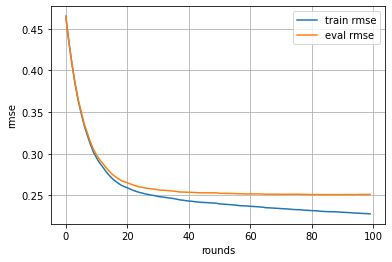

[0]	train-rmse:0.464886	eval-rmse:0.465104
[1]	train-rmse:0.43438	eval-rmse:0.434843
[2]	train-rmse:0.407539	eval-rmse:0.408342
[3]	train-rmse:0.384312	eval-rmse:0.385448
[4]	train-rmse:0.364309	eval-rmse:0.365896
[5]	train-rmse:0.348509	eval-rmse:0.35053
[6]	train-rmse:0.333585	eval-rmse:0.335841
[7]	train-rmse:0.322235	eval-rmse:0.324987
[8]	train-rmse:0.311191	eval-rmse:0.314181
[9]	train-rmse:0.301871	eval-rmse:0.305185
[10]	train-rmse:0.294894	eval-rmse:0.298514
[11]	train-rmse:0.288996	eval-rmse:0.292926
[12]	train-rmse:0.284083	eval-rmse:0.288444
[13]	train-rmse:0.278891	eval-rmse:0.283612
[14]	train-rmse:0.274491	eval-rmse:0.279474
[15]	train-rmse:0.270644	eval-rmse:0.275618
[16]	train-rmse:0.267485	eval-rmse:0.272693
[17]	train-rmse:0.264692	eval-rmse:0.270102
[18]	train-rmse:0.262199	eval-rmse:0.267819
[19]	train-rmse:0.260564	eval-rmse:0.266405
[20]	train-rmse:0.259093	eval-rmse:0.26515
[21]	train-rmse:0.257448	eval-rmse:0.263696
[22]	train-rmse:0.255893	eval-rmse:0.262317
[

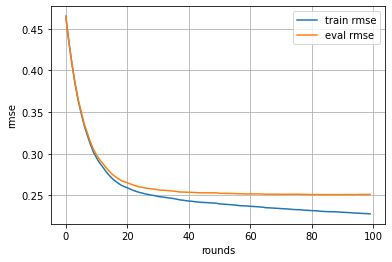

[0]	train-rmse:0.464886	eval-rmse:0.465104
[1]	train-rmse:0.43438	eval-rmse:0.434843
[2]	train-rmse:0.407539	eval-rmse:0.408342
[3]	train-rmse:0.384312	eval-rmse:0.385448
[4]	train-rmse:0.364309	eval-rmse:0.365896
[5]	train-rmse:0.348509	eval-rmse:0.35053
[6]	train-rmse:0.333585	eval-rmse:0.335841
[7]	train-rmse:0.322235	eval-rmse:0.324987
[8]	train-rmse:0.311191	eval-rmse:0.314181
[9]	train-rmse:0.301871	eval-rmse:0.305185
[10]	train-rmse:0.294894	eval-rmse:0.298514
[11]	train-rmse:0.288996	eval-rmse:0.292926
[12]	train-rmse:0.284083	eval-rmse:0.288444
[13]	train-rmse:0.278891	eval-rmse:0.283612
[14]	train-rmse:0.274491	eval-rmse:0.279474
[15]	train-rmse:0.270644	eval-rmse:0.275618
[16]	train-rmse:0.267485	eval-rmse:0.272693
[17]	train-rmse:0.264692	eval-rmse:0.270102
[18]	train-rmse:0.262199	eval-rmse:0.267819
[19]	train-rmse:0.260564	eval-rmse:0.266405
[20]	train-rmse:0.259093	eval-rmse:0.26515
[21]	train-rmse:0.257448	eval-rmse:0.263696
[22]	train-rmse:0.255893	eval-rmse:0.262317
[

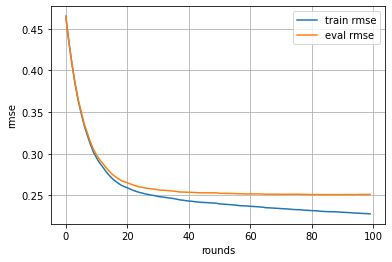

[0]	train-rmse:0.464888	eval-rmse:0.465108
[1]	train-rmse:0.434382	eval-rmse:0.434847
[2]	train-rmse:0.407544	eval-rmse:0.408361
[3]	train-rmse:0.384317	eval-rmse:0.385469
[4]	train-rmse:0.364315	eval-rmse:0.3659
[5]	train-rmse:0.34848	eval-rmse:0.350579
[6]	train-rmse:0.333556	eval-rmse:0.335892
[7]	train-rmse:0.322209	eval-rmse:0.325031
[8]	train-rmse:0.311167	eval-rmse:0.314217
[9]	train-rmse:0.30184	eval-rmse:0.305213
[10]	train-rmse:0.294867	eval-rmse:0.298578
[11]	train-rmse:0.288986	eval-rmse:0.293012
[12]	train-rmse:0.284066	eval-rmse:0.288563
[13]	train-rmse:0.278884	eval-rmse:0.283763
[14]	train-rmse:0.274478	eval-rmse:0.279596
[15]	train-rmse:0.270622	eval-rmse:0.275752
[16]	train-rmse:0.267459	eval-rmse:0.272817
[17]	train-rmse:0.264561	eval-rmse:0.270162
[18]	train-rmse:0.262103	eval-rmse:0.267987
[19]	train-rmse:0.260469	eval-rmse:0.266625
[20]	train-rmse:0.259047	eval-rmse:0.265416
[21]	train-rmse:0.257434	eval-rmse:0.264036
[22]	train-rmse:0.255899	eval-rmse:0.262719
[2

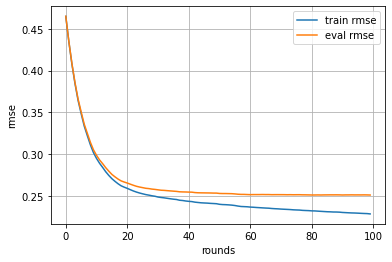

[0]	train-rmse:0.464888	eval-rmse:0.465108
[1]	train-rmse:0.434382	eval-rmse:0.434847
[2]	train-rmse:0.407544	eval-rmse:0.408361
[3]	train-rmse:0.384317	eval-rmse:0.385469
[4]	train-rmse:0.364315	eval-rmse:0.3659
[5]	train-rmse:0.34848	eval-rmse:0.350579
[6]	train-rmse:0.333556	eval-rmse:0.335892
[7]	train-rmse:0.322209	eval-rmse:0.325031
[8]	train-rmse:0.311167	eval-rmse:0.314217
[9]	train-rmse:0.30184	eval-rmse:0.305213
[10]	train-rmse:0.294867	eval-rmse:0.298578
[11]	train-rmse:0.288986	eval-rmse:0.293012
[12]	train-rmse:0.284066	eval-rmse:0.288563
[13]	train-rmse:0.278884	eval-rmse:0.283763
[14]	train-rmse:0.274478	eval-rmse:0.279596
[15]	train-rmse:0.270622	eval-rmse:0.275752
[16]	train-rmse:0.267459	eval-rmse:0.272817
[17]	train-rmse:0.264561	eval-rmse:0.270162
[18]	train-rmse:0.262103	eval-rmse:0.267987
[19]	train-rmse:0.260469	eval-rmse:0.266625
[20]	train-rmse:0.259047	eval-rmse:0.265416
[21]	train-rmse:0.257434	eval-rmse:0.264036
[22]	train-rmse:0.255899	eval-rmse:0.262719
[2

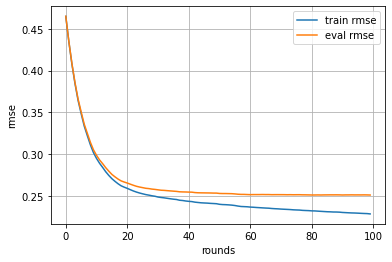

[0]	train-rmse:0.464888	eval-rmse:0.465108
[1]	train-rmse:0.434382	eval-rmse:0.434847
[2]	train-rmse:0.407544	eval-rmse:0.408361
[3]	train-rmse:0.384317	eval-rmse:0.385469
[4]	train-rmse:0.364315	eval-rmse:0.3659
[5]	train-rmse:0.34848	eval-rmse:0.350579
[6]	train-rmse:0.333556	eval-rmse:0.335892
[7]	train-rmse:0.322209	eval-rmse:0.325031
[8]	train-rmse:0.311167	eval-rmse:0.314217
[9]	train-rmse:0.30184	eval-rmse:0.305213
[10]	train-rmse:0.294867	eval-rmse:0.298578
[11]	train-rmse:0.288986	eval-rmse:0.293012
[12]	train-rmse:0.284066	eval-rmse:0.288563
[13]	train-rmse:0.278884	eval-rmse:0.283763
[14]	train-rmse:0.274478	eval-rmse:0.279596
[15]	train-rmse:0.270622	eval-rmse:0.275752
[16]	train-rmse:0.267459	eval-rmse:0.272817
[17]	train-rmse:0.264561	eval-rmse:0.270162
[18]	train-rmse:0.262103	eval-rmse:0.267987
[19]	train-rmse:0.260469	eval-rmse:0.266625
[20]	train-rmse:0.259047	eval-rmse:0.265416
[21]	train-rmse:0.257434	eval-rmse:0.264036
[22]	train-rmse:0.255899	eval-rmse:0.262719
[2

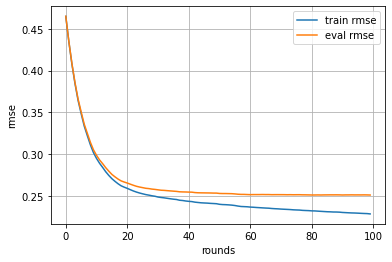

[0]	train-rmse:0.464888	eval-rmse:0.465108
[1]	train-rmse:0.434382	eval-rmse:0.434847
[2]	train-rmse:0.407544	eval-rmse:0.408361
[3]	train-rmse:0.384317	eval-rmse:0.385469
[4]	train-rmse:0.364315	eval-rmse:0.3659
[5]	train-rmse:0.34848	eval-rmse:0.350579
[6]	train-rmse:0.333556	eval-rmse:0.335892
[7]	train-rmse:0.322209	eval-rmse:0.325031
[8]	train-rmse:0.311167	eval-rmse:0.314217
[9]	train-rmse:0.30184	eval-rmse:0.305213
[10]	train-rmse:0.294867	eval-rmse:0.298578
[11]	train-rmse:0.288986	eval-rmse:0.293012
[12]	train-rmse:0.284066	eval-rmse:0.288563
[13]	train-rmse:0.278884	eval-rmse:0.283763
[14]	train-rmse:0.274478	eval-rmse:0.279596
[15]	train-rmse:0.270622	eval-rmse:0.275752
[16]	train-rmse:0.267459	eval-rmse:0.272817
[17]	train-rmse:0.264561	eval-rmse:0.270162
[18]	train-rmse:0.262103	eval-rmse:0.267987
[19]	train-rmse:0.260469	eval-rmse:0.266625
[20]	train-rmse:0.259047	eval-rmse:0.265416
[21]	train-rmse:0.257434	eval-rmse:0.264036
[22]	train-rmse:0.255899	eval-rmse:0.262719
[2

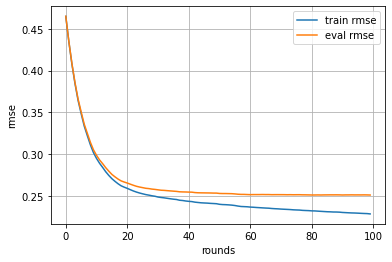

[0]	train-rmse:0.464888	eval-rmse:0.465108
[1]	train-rmse:0.434382	eval-rmse:0.434847
[2]	train-rmse:0.407544	eval-rmse:0.408361
[3]	train-rmse:0.384317	eval-rmse:0.385469
[4]	train-rmse:0.364315	eval-rmse:0.3659
[5]	train-rmse:0.34848	eval-rmse:0.350579
[6]	train-rmse:0.333556	eval-rmse:0.335892
[7]	train-rmse:0.322209	eval-rmse:0.325031
[8]	train-rmse:0.311167	eval-rmse:0.314217
[9]	train-rmse:0.30184	eval-rmse:0.305213
[10]	train-rmse:0.294867	eval-rmse:0.298578
[11]	train-rmse:0.288986	eval-rmse:0.293012
[12]	train-rmse:0.284066	eval-rmse:0.288563
[13]	train-rmse:0.278884	eval-rmse:0.283763
[14]	train-rmse:0.274478	eval-rmse:0.279596
[15]	train-rmse:0.270622	eval-rmse:0.275752
[16]	train-rmse:0.267459	eval-rmse:0.272817
[17]	train-rmse:0.264561	eval-rmse:0.270162
[18]	train-rmse:0.262103	eval-rmse:0.267987
[19]	train-rmse:0.260469	eval-rmse:0.266625
[20]	train-rmse:0.259047	eval-rmse:0.265416
[21]	train-rmse:0.257434	eval-rmse:0.264036
[22]	train-rmse:0.255899	eval-rmse:0.262719
[2

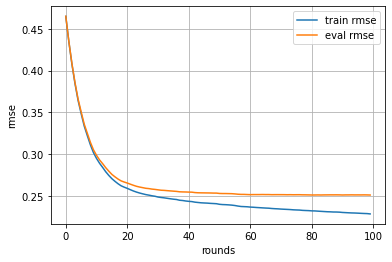

[0]	train-rmse:0.464888	eval-rmse:0.465108
[1]	train-rmse:0.434382	eval-rmse:0.434847
[2]	train-rmse:0.407544	eval-rmse:0.408361
[3]	train-rmse:0.384317	eval-rmse:0.385469
[4]	train-rmse:0.364315	eval-rmse:0.3659
[5]	train-rmse:0.34848	eval-rmse:0.350579
[6]	train-rmse:0.333556	eval-rmse:0.335892
[7]	train-rmse:0.322209	eval-rmse:0.325031
[8]	train-rmse:0.311167	eval-rmse:0.314217
[9]	train-rmse:0.30184	eval-rmse:0.305213
[10]	train-rmse:0.294867	eval-rmse:0.298578
[11]	train-rmse:0.288986	eval-rmse:0.293012
[12]	train-rmse:0.284066	eval-rmse:0.288563
[13]	train-rmse:0.278884	eval-rmse:0.283763
[14]	train-rmse:0.274478	eval-rmse:0.279596
[15]	train-rmse:0.270622	eval-rmse:0.275752
[16]	train-rmse:0.267459	eval-rmse:0.272817
[17]	train-rmse:0.264561	eval-rmse:0.270162
[18]	train-rmse:0.262103	eval-rmse:0.267987
[19]	train-rmse:0.260469	eval-rmse:0.266625
[20]	train-rmse:0.259047	eval-rmse:0.265416
[21]	train-rmse:0.257434	eval-rmse:0.264036
[22]	train-rmse:0.255899	eval-rmse:0.262719
[2

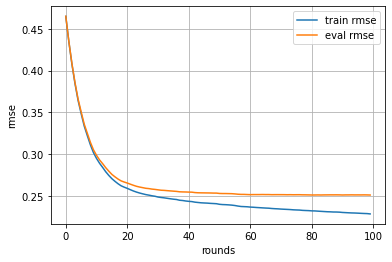

[0]	train-rmse:0.464888	eval-rmse:0.465108
[1]	train-rmse:0.434382	eval-rmse:0.434847
[2]	train-rmse:0.407544	eval-rmse:0.408361
[3]	train-rmse:0.384317	eval-rmse:0.385469
[4]	train-rmse:0.364315	eval-rmse:0.3659
[5]	train-rmse:0.34848	eval-rmse:0.350579
[6]	train-rmse:0.333556	eval-rmse:0.335892
[7]	train-rmse:0.322209	eval-rmse:0.325031
[8]	train-rmse:0.311167	eval-rmse:0.314217
[9]	train-rmse:0.30184	eval-rmse:0.305213
[10]	train-rmse:0.294867	eval-rmse:0.298578
[11]	train-rmse:0.288986	eval-rmse:0.293012
[12]	train-rmse:0.284066	eval-rmse:0.288563
[13]	train-rmse:0.278884	eval-rmse:0.283763
[14]	train-rmse:0.274478	eval-rmse:0.279596
[15]	train-rmse:0.270622	eval-rmse:0.275752
[16]	train-rmse:0.267459	eval-rmse:0.272817
[17]	train-rmse:0.264561	eval-rmse:0.270162
[18]	train-rmse:0.262103	eval-rmse:0.267987
[19]	train-rmse:0.260469	eval-rmse:0.266625
[20]	train-rmse:0.259047	eval-rmse:0.265416
[21]	train-rmse:0.257434	eval-rmse:0.264036
[22]	train-rmse:0.255899	eval-rmse:0.262719
[2

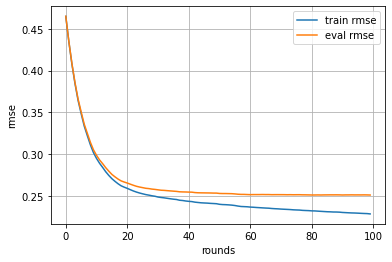

[0]	train-rmse:0.464888	eval-rmse:0.465108
[1]	train-rmse:0.434382	eval-rmse:0.434847
[2]	train-rmse:0.407544	eval-rmse:0.408361
[3]	train-rmse:0.384317	eval-rmse:0.385469
[4]	train-rmse:0.364315	eval-rmse:0.3659
[5]	train-rmse:0.34848	eval-rmse:0.350579
[6]	train-rmse:0.333556	eval-rmse:0.335892
[7]	train-rmse:0.322209	eval-rmse:0.325031
[8]	train-rmse:0.311167	eval-rmse:0.314217
[9]	train-rmse:0.30184	eval-rmse:0.305213
[10]	train-rmse:0.294867	eval-rmse:0.298578
[11]	train-rmse:0.288986	eval-rmse:0.293012
[12]	train-rmse:0.284066	eval-rmse:0.288563
[13]	train-rmse:0.278884	eval-rmse:0.283763
[14]	train-rmse:0.274478	eval-rmse:0.279596
[15]	train-rmse:0.270622	eval-rmse:0.275752
[16]	train-rmse:0.267459	eval-rmse:0.272817
[17]	train-rmse:0.264561	eval-rmse:0.270162
[18]	train-rmse:0.262103	eval-rmse:0.267987
[19]	train-rmse:0.260469	eval-rmse:0.266625
[20]	train-rmse:0.259047	eval-rmse:0.265416
[21]	train-rmse:0.257434	eval-rmse:0.264036
[22]	train-rmse:0.255899	eval-rmse:0.262719
[2

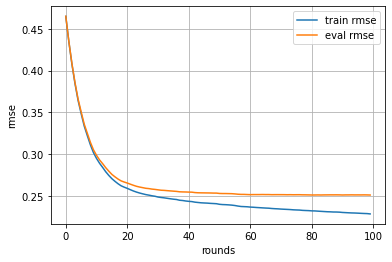

[0]	train-rmse:0.464888	eval-rmse:0.465108
[1]	train-rmse:0.434382	eval-rmse:0.434847
[2]	train-rmse:0.407544	eval-rmse:0.408361
[3]	train-rmse:0.384317	eval-rmse:0.385469
[4]	train-rmse:0.364315	eval-rmse:0.3659
[5]	train-rmse:0.34848	eval-rmse:0.350579
[6]	train-rmse:0.333556	eval-rmse:0.335892
[7]	train-rmse:0.322209	eval-rmse:0.325031
[8]	train-rmse:0.311167	eval-rmse:0.314217
[9]	train-rmse:0.30184	eval-rmse:0.305213
[10]	train-rmse:0.294867	eval-rmse:0.298578
[11]	train-rmse:0.288986	eval-rmse:0.293012
[12]	train-rmse:0.284066	eval-rmse:0.288563
[13]	train-rmse:0.278884	eval-rmse:0.283763
[14]	train-rmse:0.274478	eval-rmse:0.279596
[15]	train-rmse:0.270622	eval-rmse:0.275752
[16]	train-rmse:0.267459	eval-rmse:0.272817
[17]	train-rmse:0.264561	eval-rmse:0.270162
[18]	train-rmse:0.262103	eval-rmse:0.267987
[19]	train-rmse:0.260469	eval-rmse:0.266625
[20]	train-rmse:0.259047	eval-rmse:0.265416
[21]	train-rmse:0.257434	eval-rmse:0.264036
[22]	train-rmse:0.255899	eval-rmse:0.262719
[2

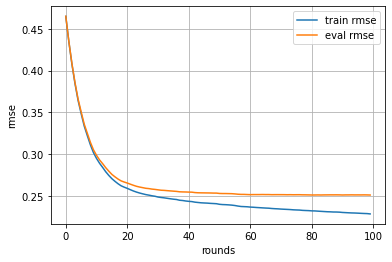

[0]	train-rmse:0.464888	eval-rmse:0.465108
[1]	train-rmse:0.434382	eval-rmse:0.434847
[2]	train-rmse:0.407544	eval-rmse:0.408361
[3]	train-rmse:0.384317	eval-rmse:0.385469
[4]	train-rmse:0.364315	eval-rmse:0.3659
[5]	train-rmse:0.34848	eval-rmse:0.350579
[6]	train-rmse:0.333556	eval-rmse:0.335892
[7]	train-rmse:0.322209	eval-rmse:0.325031
[8]	train-rmse:0.311167	eval-rmse:0.314217
[9]	train-rmse:0.30184	eval-rmse:0.305213
[10]	train-rmse:0.294867	eval-rmse:0.298578
[11]	train-rmse:0.288986	eval-rmse:0.293012
[12]	train-rmse:0.284066	eval-rmse:0.288563
[13]	train-rmse:0.278884	eval-rmse:0.283763
[14]	train-rmse:0.274478	eval-rmse:0.279596
[15]	train-rmse:0.270622	eval-rmse:0.275752
[16]	train-rmse:0.267459	eval-rmse:0.272817
[17]	train-rmse:0.264561	eval-rmse:0.270162
[18]	train-rmse:0.262103	eval-rmse:0.267987
[19]	train-rmse:0.260469	eval-rmse:0.266625
[20]	train-rmse:0.259047	eval-rmse:0.265416
[21]	train-rmse:0.257434	eval-rmse:0.264036
[22]	train-rmse:0.255899	eval-rmse:0.262719
[2

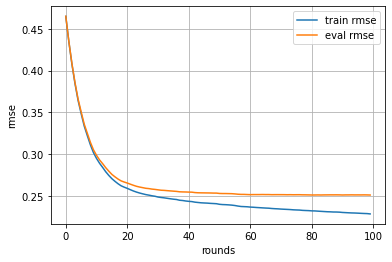

[0]	train-rmse:0.46489	eval-rmse:0.465106
[1]	train-rmse:0.434376	eval-rmse:0.434844
[2]	train-rmse:0.407539	eval-rmse:0.408368
[3]	train-rmse:0.384312	eval-rmse:0.385476
[4]	train-rmse:0.364308	eval-rmse:0.365901
[5]	train-rmse:0.348473	eval-rmse:0.350592
[6]	train-rmse:0.33355	eval-rmse:0.335906
[7]	train-rmse:0.322205	eval-rmse:0.325046
[8]	train-rmse:0.311162	eval-rmse:0.314231
[9]	train-rmse:0.30184	eval-rmse:0.305243
[10]	train-rmse:0.29487	eval-rmse:0.298608
[11]	train-rmse:0.288991	eval-rmse:0.293049
[12]	train-rmse:0.284077	eval-rmse:0.288572
[13]	train-rmse:0.278893	eval-rmse:0.283771
[14]	train-rmse:0.274496	eval-rmse:0.279611
[15]	train-rmse:0.270638	eval-rmse:0.275765
[16]	train-rmse:0.267481	eval-rmse:0.272818
[17]	train-rmse:0.264658	eval-rmse:0.270274
[18]	train-rmse:0.26219	eval-rmse:0.268044
[19]	train-rmse:0.260563	eval-rmse:0.26667
[20]	train-rmse:0.259093	eval-rmse:0.265375
[21]	train-rmse:0.257445	eval-rmse:0.264001
[22]	train-rmse:0.255892	eval-rmse:0.262692
[23]

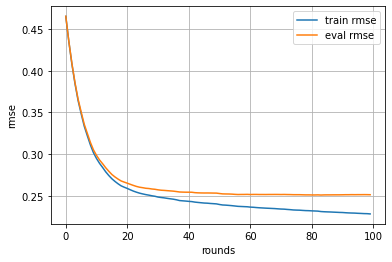

[0]	train-rmse:0.46489	eval-rmse:0.465106
[1]	train-rmse:0.434376	eval-rmse:0.434844
[2]	train-rmse:0.407539	eval-rmse:0.408368
[3]	train-rmse:0.384312	eval-rmse:0.385476
[4]	train-rmse:0.364308	eval-rmse:0.365901
[5]	train-rmse:0.348473	eval-rmse:0.350592
[6]	train-rmse:0.33355	eval-rmse:0.335906
[7]	train-rmse:0.322205	eval-rmse:0.325046
[8]	train-rmse:0.311162	eval-rmse:0.314231
[9]	train-rmse:0.30184	eval-rmse:0.305243
[10]	train-rmse:0.29487	eval-rmse:0.298608
[11]	train-rmse:0.288991	eval-rmse:0.293049
[12]	train-rmse:0.284077	eval-rmse:0.288572
[13]	train-rmse:0.278893	eval-rmse:0.283771
[14]	train-rmse:0.274496	eval-rmse:0.279611
[15]	train-rmse:0.270638	eval-rmse:0.275765
[16]	train-rmse:0.267481	eval-rmse:0.272818
[17]	train-rmse:0.264658	eval-rmse:0.270274
[18]	train-rmse:0.26219	eval-rmse:0.268044
[19]	train-rmse:0.260563	eval-rmse:0.26667
[20]	train-rmse:0.259093	eval-rmse:0.265375
[21]	train-rmse:0.257445	eval-rmse:0.264001
[22]	train-rmse:0.255892	eval-rmse:0.262692
[23]

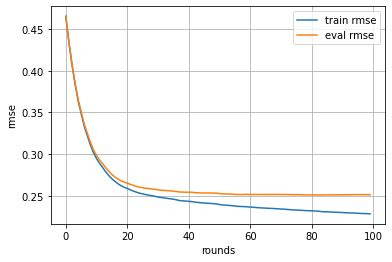

[0]	train-rmse:0.46489	eval-rmse:0.465106
[1]	train-rmse:0.434376	eval-rmse:0.434844
[2]	train-rmse:0.407539	eval-rmse:0.408368
[3]	train-rmse:0.384312	eval-rmse:0.385476
[4]	train-rmse:0.364308	eval-rmse:0.365901
[5]	train-rmse:0.348473	eval-rmse:0.350592
[6]	train-rmse:0.33355	eval-rmse:0.335906
[7]	train-rmse:0.322205	eval-rmse:0.325046
[8]	train-rmse:0.311162	eval-rmse:0.314231
[9]	train-rmse:0.30184	eval-rmse:0.305243
[10]	train-rmse:0.29487	eval-rmse:0.298608
[11]	train-rmse:0.288991	eval-rmse:0.293049
[12]	train-rmse:0.284077	eval-rmse:0.288572
[13]	train-rmse:0.278893	eval-rmse:0.283771
[14]	train-rmse:0.274496	eval-rmse:0.279611
[15]	train-rmse:0.270638	eval-rmse:0.275765
[16]	train-rmse:0.267481	eval-rmse:0.272818
[17]	train-rmse:0.264658	eval-rmse:0.270274
[18]	train-rmse:0.26219	eval-rmse:0.268044
[19]	train-rmse:0.260563	eval-rmse:0.26667
[20]	train-rmse:0.259093	eval-rmse:0.265375
[21]	train-rmse:0.257445	eval-rmse:0.264001
[22]	train-rmse:0.255892	eval-rmse:0.262692
[23]

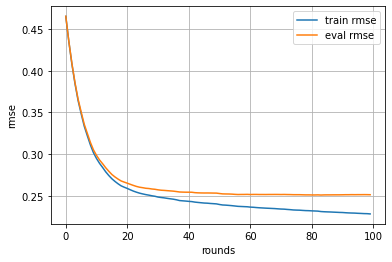

[0]	train-rmse:0.46489	eval-rmse:0.465106
[1]	train-rmse:0.434376	eval-rmse:0.434844
[2]	train-rmse:0.407538	eval-rmse:0.408368
[3]	train-rmse:0.384312	eval-rmse:0.385476
[4]	train-rmse:0.364308	eval-rmse:0.365901
[5]	train-rmse:0.348473	eval-rmse:0.350592
[6]	train-rmse:0.33355	eval-rmse:0.335906
[7]	train-rmse:0.322205	eval-rmse:0.325046
[8]	train-rmse:0.311162	eval-rmse:0.314231
[9]	train-rmse:0.30184	eval-rmse:0.305243
[10]	train-rmse:0.29487	eval-rmse:0.298608
[11]	train-rmse:0.288991	eval-rmse:0.293049
[12]	train-rmse:0.284077	eval-rmse:0.288572
[13]	train-rmse:0.278893	eval-rmse:0.283771
[14]	train-rmse:0.274496	eval-rmse:0.279611
[15]	train-rmse:0.270638	eval-rmse:0.275765
[16]	train-rmse:0.267481	eval-rmse:0.272818
[17]	train-rmse:0.264658	eval-rmse:0.270274
[18]	train-rmse:0.26219	eval-rmse:0.268044
[19]	train-rmse:0.260563	eval-rmse:0.26667
[20]	train-rmse:0.259093	eval-rmse:0.265375
[21]	train-rmse:0.257445	eval-rmse:0.264001
[22]	train-rmse:0.255892	eval-rmse:0.262692
[23]

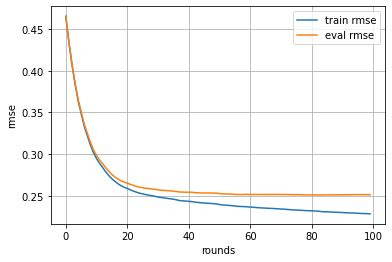

[0]	train-rmse:0.46489	eval-rmse:0.465106
[1]	train-rmse:0.434376	eval-rmse:0.434844
[2]	train-rmse:0.407539	eval-rmse:0.408368
[3]	train-rmse:0.384312	eval-rmse:0.385476
[4]	train-rmse:0.364308	eval-rmse:0.365901
[5]	train-rmse:0.348473	eval-rmse:0.350592
[6]	train-rmse:0.33355	eval-rmse:0.335906
[7]	train-rmse:0.322205	eval-rmse:0.325046
[8]	train-rmse:0.311162	eval-rmse:0.314231
[9]	train-rmse:0.30184	eval-rmse:0.305243
[10]	train-rmse:0.29487	eval-rmse:0.298608
[11]	train-rmse:0.288991	eval-rmse:0.293049
[12]	train-rmse:0.284077	eval-rmse:0.288572
[13]	train-rmse:0.278893	eval-rmse:0.283771
[14]	train-rmse:0.274496	eval-rmse:0.279611
[15]	train-rmse:0.270638	eval-rmse:0.275765
[16]	train-rmse:0.267481	eval-rmse:0.272818
[17]	train-rmse:0.264658	eval-rmse:0.270274
[18]	train-rmse:0.26219	eval-rmse:0.268044
[19]	train-rmse:0.260563	eval-rmse:0.26667
[20]	train-rmse:0.259093	eval-rmse:0.265375
[21]	train-rmse:0.257445	eval-rmse:0.264001
[22]	train-rmse:0.255892	eval-rmse:0.262692
[23]

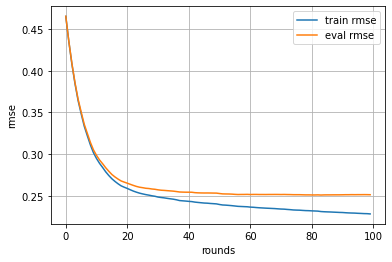

[0]	train-rmse:0.46489	eval-rmse:0.465106
[1]	train-rmse:0.434376	eval-rmse:0.434844
[2]	train-rmse:0.407539	eval-rmse:0.408368
[3]	train-rmse:0.384312	eval-rmse:0.385476
[4]	train-rmse:0.364308	eval-rmse:0.365901
[5]	train-rmse:0.348473	eval-rmse:0.350592
[6]	train-rmse:0.33355	eval-rmse:0.335906
[7]	train-rmse:0.322205	eval-rmse:0.325046
[8]	train-rmse:0.311162	eval-rmse:0.314231
[9]	train-rmse:0.30184	eval-rmse:0.305243
[10]	train-rmse:0.29487	eval-rmse:0.298608
[11]	train-rmse:0.288991	eval-rmse:0.293049
[12]	train-rmse:0.284077	eval-rmse:0.288572
[13]	train-rmse:0.278893	eval-rmse:0.283771
[14]	train-rmse:0.274496	eval-rmse:0.279611
[15]	train-rmse:0.270638	eval-rmse:0.275765
[16]	train-rmse:0.267481	eval-rmse:0.272818
[17]	train-rmse:0.264658	eval-rmse:0.270274
[18]	train-rmse:0.26219	eval-rmse:0.268044
[19]	train-rmse:0.260563	eval-rmse:0.26667
[20]	train-rmse:0.259093	eval-rmse:0.265375
[21]	train-rmse:0.257445	eval-rmse:0.264001
[22]	train-rmse:0.255892	eval-rmse:0.262692
[23]

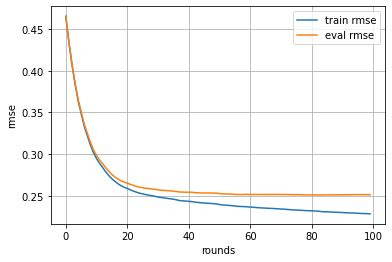

[0]	train-rmse:0.46489	eval-rmse:0.465106
[1]	train-rmse:0.434376	eval-rmse:0.434844
[2]	train-rmse:0.407539	eval-rmse:0.408368
[3]	train-rmse:0.384312	eval-rmse:0.385476
[4]	train-rmse:0.364308	eval-rmse:0.365901
[5]	train-rmse:0.348473	eval-rmse:0.350592
[6]	train-rmse:0.33355	eval-rmse:0.335906
[7]	train-rmse:0.322205	eval-rmse:0.325046
[8]	train-rmse:0.311162	eval-rmse:0.314231
[9]	train-rmse:0.30184	eval-rmse:0.305243
[10]	train-rmse:0.29487	eval-rmse:0.298608
[11]	train-rmse:0.288991	eval-rmse:0.293049
[12]	train-rmse:0.284077	eval-rmse:0.288572
[13]	train-rmse:0.278893	eval-rmse:0.283771
[14]	train-rmse:0.274496	eval-rmse:0.279611
[15]	train-rmse:0.270638	eval-rmse:0.275765
[16]	train-rmse:0.267481	eval-rmse:0.272818
[17]	train-rmse:0.264658	eval-rmse:0.270274
[18]	train-rmse:0.26219	eval-rmse:0.268044
[19]	train-rmse:0.260563	eval-rmse:0.26667
[20]	train-rmse:0.259093	eval-rmse:0.265375
[21]	train-rmse:0.257445	eval-rmse:0.264001
[22]	train-rmse:0.255892	eval-rmse:0.262692
[23]

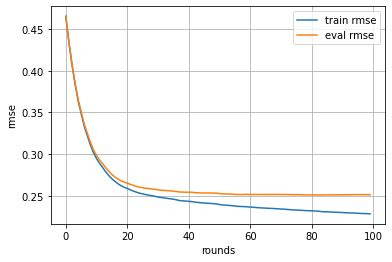

[0]	train-rmse:0.46489	eval-rmse:0.465106
[1]	train-rmse:0.434376	eval-rmse:0.434844
[2]	train-rmse:0.407539	eval-rmse:0.408368
[3]	train-rmse:0.384312	eval-rmse:0.385476
[4]	train-rmse:0.364308	eval-rmse:0.365901
[5]	train-rmse:0.348473	eval-rmse:0.350592
[6]	train-rmse:0.33355	eval-rmse:0.335906
[7]	train-rmse:0.322205	eval-rmse:0.325046
[8]	train-rmse:0.311162	eval-rmse:0.314231
[9]	train-rmse:0.30184	eval-rmse:0.305243
[10]	train-rmse:0.29487	eval-rmse:0.298608
[11]	train-rmse:0.288991	eval-rmse:0.293049
[12]	train-rmse:0.284077	eval-rmse:0.288572
[13]	train-rmse:0.278893	eval-rmse:0.283771
[14]	train-rmse:0.274496	eval-rmse:0.279611
[15]	train-rmse:0.270638	eval-rmse:0.275765
[16]	train-rmse:0.267481	eval-rmse:0.272818
[17]	train-rmse:0.264658	eval-rmse:0.270274
[18]	train-rmse:0.26219	eval-rmse:0.268044
[19]	train-rmse:0.260563	eval-rmse:0.26667
[20]	train-rmse:0.259093	eval-rmse:0.265375
[21]	train-rmse:0.257445	eval-rmse:0.264001
[22]	train-rmse:0.255892	eval-rmse:0.262692
[23]

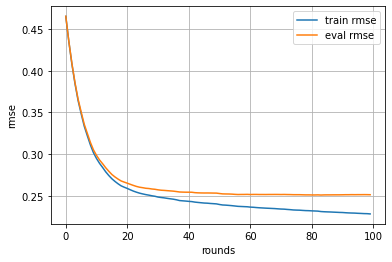

[0]	train-rmse:0.46489	eval-rmse:0.465106
[1]	train-rmse:0.434376	eval-rmse:0.434844
[2]	train-rmse:0.407539	eval-rmse:0.408368
[3]	train-rmse:0.384312	eval-rmse:0.385476
[4]	train-rmse:0.364308	eval-rmse:0.365901
[5]	train-rmse:0.348473	eval-rmse:0.350592
[6]	train-rmse:0.33355	eval-rmse:0.335906
[7]	train-rmse:0.322205	eval-rmse:0.325046
[8]	train-rmse:0.311162	eval-rmse:0.314231
[9]	train-rmse:0.30184	eval-rmse:0.305243
[10]	train-rmse:0.29487	eval-rmse:0.298608
[11]	train-rmse:0.288991	eval-rmse:0.293049
[12]	train-rmse:0.284077	eval-rmse:0.288572
[13]	train-rmse:0.278893	eval-rmse:0.283771
[14]	train-rmse:0.274496	eval-rmse:0.279611
[15]	train-rmse:0.270638	eval-rmse:0.275765
[16]	train-rmse:0.267481	eval-rmse:0.272818
[17]	train-rmse:0.264658	eval-rmse:0.270274
[18]	train-rmse:0.26219	eval-rmse:0.268044
[19]	train-rmse:0.260563	eval-rmse:0.26667
[20]	train-rmse:0.259093	eval-rmse:0.265375
[21]	train-rmse:0.257445	eval-rmse:0.264001
[22]	train-rmse:0.255892	eval-rmse:0.262692
[23]

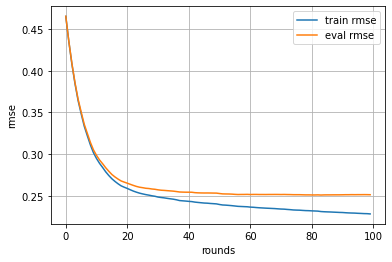

[0]	train-rmse:0.46489	eval-rmse:0.465106
[1]	train-rmse:0.434376	eval-rmse:0.434844
[2]	train-rmse:0.407539	eval-rmse:0.408368
[3]	train-rmse:0.384312	eval-rmse:0.385476
[4]	train-rmse:0.364308	eval-rmse:0.365901
[5]	train-rmse:0.348473	eval-rmse:0.350592
[6]	train-rmse:0.33355	eval-rmse:0.335906
[7]	train-rmse:0.322205	eval-rmse:0.325046
[8]	train-rmse:0.311162	eval-rmse:0.314231
[9]	train-rmse:0.30184	eval-rmse:0.305243
[10]	train-rmse:0.29487	eval-rmse:0.298608
[11]	train-rmse:0.288991	eval-rmse:0.293049
[12]	train-rmse:0.284077	eval-rmse:0.288572
[13]	train-rmse:0.278893	eval-rmse:0.283771
[14]	train-rmse:0.274496	eval-rmse:0.279611
[15]	train-rmse:0.270638	eval-rmse:0.275765
[16]	train-rmse:0.267481	eval-rmse:0.272818
[17]	train-rmse:0.264658	eval-rmse:0.270274
[18]	train-rmse:0.26219	eval-rmse:0.268044
[19]	train-rmse:0.260563	eval-rmse:0.26667
[20]	train-rmse:0.259093	eval-rmse:0.265375
[21]	train-rmse:0.257445	eval-rmse:0.264001
[22]	train-rmse:0.255892	eval-rmse:0.262692
[23]

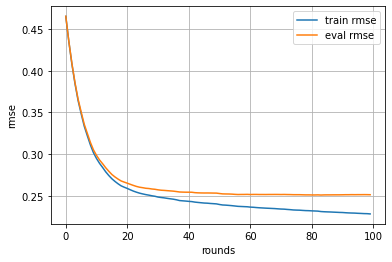

[0]	train-rmse:0.464893	eval-rmse:0.465102
[1]	train-rmse:0.434378	eval-rmse:0.434833
[2]	train-rmse:0.407539	eval-rmse:0.408356
[3]	train-rmse:0.384312	eval-rmse:0.385457
[4]	train-rmse:0.364314	eval-rmse:0.365861
[5]	train-rmse:0.348495	eval-rmse:0.350532
[6]	train-rmse:0.333574	eval-rmse:0.335858
[7]	train-rmse:0.322223	eval-rmse:0.325038
[8]	train-rmse:0.311179	eval-rmse:0.314226
[9]	train-rmse:0.301878	eval-rmse:0.305233
[10]	train-rmse:0.294858	eval-rmse:0.298535
[11]	train-rmse:0.288982	eval-rmse:0.292984
[12]	train-rmse:0.284082	eval-rmse:0.288502
[13]	train-rmse:0.278957	eval-rmse:0.283683
[14]	train-rmse:0.27456	eval-rmse:0.27948
[15]	train-rmse:0.270708	eval-rmse:0.275626
[16]	train-rmse:0.26757	eval-rmse:0.272633
[17]	train-rmse:0.264675	eval-rmse:0.269958
[18]	train-rmse:0.26222	eval-rmse:0.267785
[19]	train-rmse:0.260592	eval-rmse:0.266443
[20]	train-rmse:0.259166	eval-rmse:0.265257
[21]	train-rmse:0.257555	eval-rmse:0.263933
[22]	train-rmse:0.256031	eval-rmse:0.26269
[23

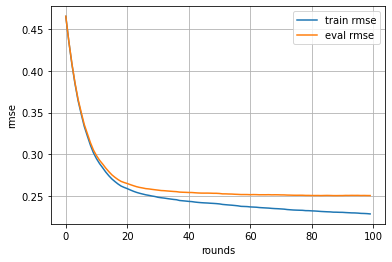

[0]	train-rmse:0.464893	eval-rmse:0.465102
[1]	train-rmse:0.434378	eval-rmse:0.434833
[2]	train-rmse:0.407539	eval-rmse:0.408356
[3]	train-rmse:0.384312	eval-rmse:0.385457
[4]	train-rmse:0.364314	eval-rmse:0.365861
[5]	train-rmse:0.348495	eval-rmse:0.350532
[6]	train-rmse:0.333574	eval-rmse:0.335858
[7]	train-rmse:0.322223	eval-rmse:0.325038
[8]	train-rmse:0.311179	eval-rmse:0.314226
[9]	train-rmse:0.301878	eval-rmse:0.305233
[10]	train-rmse:0.294858	eval-rmse:0.298535
[11]	train-rmse:0.288982	eval-rmse:0.292984
[12]	train-rmse:0.284082	eval-rmse:0.288502
[13]	train-rmse:0.278957	eval-rmse:0.283683
[14]	train-rmse:0.27456	eval-rmse:0.27948
[15]	train-rmse:0.270708	eval-rmse:0.275626
[16]	train-rmse:0.26757	eval-rmse:0.272633
[17]	train-rmse:0.264675	eval-rmse:0.269958
[18]	train-rmse:0.26222	eval-rmse:0.267785
[19]	train-rmse:0.260592	eval-rmse:0.266443
[20]	train-rmse:0.259166	eval-rmse:0.265257
[21]	train-rmse:0.257555	eval-rmse:0.263933
[22]	train-rmse:0.256031	eval-rmse:0.26269
[23

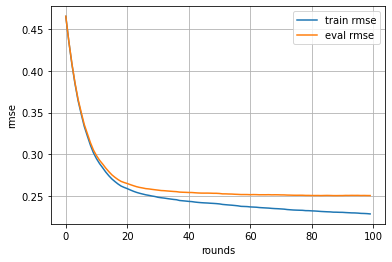

[0]	train-rmse:0.464893	eval-rmse:0.465102
[1]	train-rmse:0.434378	eval-rmse:0.434833
[2]	train-rmse:0.407539	eval-rmse:0.408356
[3]	train-rmse:0.384312	eval-rmse:0.385457
[4]	train-rmse:0.364314	eval-rmse:0.365861
[5]	train-rmse:0.348495	eval-rmse:0.350532
[6]	train-rmse:0.333574	eval-rmse:0.335858
[7]	train-rmse:0.322223	eval-rmse:0.325038
[8]	train-rmse:0.311179	eval-rmse:0.314226
[9]	train-rmse:0.301878	eval-rmse:0.305233
[10]	train-rmse:0.294858	eval-rmse:0.298535
[11]	train-rmse:0.288982	eval-rmse:0.292984
[12]	train-rmse:0.284082	eval-rmse:0.288502
[13]	train-rmse:0.278957	eval-rmse:0.283683
[14]	train-rmse:0.27456	eval-rmse:0.27948
[15]	train-rmse:0.270708	eval-rmse:0.275626
[16]	train-rmse:0.26757	eval-rmse:0.272633
[17]	train-rmse:0.264675	eval-rmse:0.269958
[18]	train-rmse:0.26222	eval-rmse:0.267785
[19]	train-rmse:0.260592	eval-rmse:0.266443
[20]	train-rmse:0.259166	eval-rmse:0.265257
[21]	train-rmse:0.257555	eval-rmse:0.263933
[22]	train-rmse:0.256031	eval-rmse:0.26269
[23

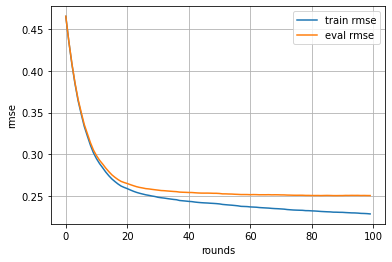

[0]	train-rmse:0.464893	eval-rmse:0.465102
[1]	train-rmse:0.434378	eval-rmse:0.434833
[2]	train-rmse:0.407539	eval-rmse:0.408356
[3]	train-rmse:0.384312	eval-rmse:0.385457
[4]	train-rmse:0.364314	eval-rmse:0.365861
[5]	train-rmse:0.348495	eval-rmse:0.350532
[6]	train-rmse:0.333574	eval-rmse:0.335858
[7]	train-rmse:0.322223	eval-rmse:0.325038
[8]	train-rmse:0.311179	eval-rmse:0.314226
[9]	train-rmse:0.301878	eval-rmse:0.305233
[10]	train-rmse:0.294858	eval-rmse:0.298535
[11]	train-rmse:0.288982	eval-rmse:0.292984
[12]	train-rmse:0.284082	eval-rmse:0.288502
[13]	train-rmse:0.278957	eval-rmse:0.283683
[14]	train-rmse:0.27456	eval-rmse:0.27948
[15]	train-rmse:0.270708	eval-rmse:0.275626
[16]	train-rmse:0.26757	eval-rmse:0.272633
[17]	train-rmse:0.264675	eval-rmse:0.269958
[18]	train-rmse:0.26222	eval-rmse:0.267785
[19]	train-rmse:0.260592	eval-rmse:0.266443
[20]	train-rmse:0.259166	eval-rmse:0.265257
[21]	train-rmse:0.257555	eval-rmse:0.263933
[22]	train-rmse:0.256031	eval-rmse:0.26269
[23

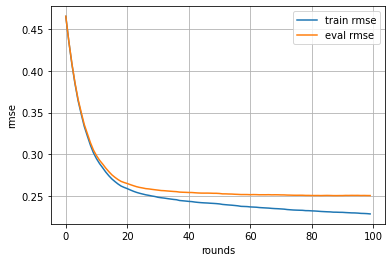

[0]	train-rmse:0.464893	eval-rmse:0.465102
[1]	train-rmse:0.434378	eval-rmse:0.434833
[2]	train-rmse:0.407539	eval-rmse:0.408356
[3]	train-rmse:0.384312	eval-rmse:0.385457
[4]	train-rmse:0.364314	eval-rmse:0.365861
[5]	train-rmse:0.348495	eval-rmse:0.350532
[6]	train-rmse:0.333574	eval-rmse:0.335858
[7]	train-rmse:0.322223	eval-rmse:0.325038
[8]	train-rmse:0.311179	eval-rmse:0.314226
[9]	train-rmse:0.301878	eval-rmse:0.305233
[10]	train-rmse:0.294858	eval-rmse:0.298535
[11]	train-rmse:0.288982	eval-rmse:0.292984
[12]	train-rmse:0.284082	eval-rmse:0.288502
[13]	train-rmse:0.278957	eval-rmse:0.283683
[14]	train-rmse:0.27456	eval-rmse:0.27948
[15]	train-rmse:0.270708	eval-rmse:0.275626
[16]	train-rmse:0.26757	eval-rmse:0.272633
[17]	train-rmse:0.264675	eval-rmse:0.269958
[18]	train-rmse:0.26222	eval-rmse:0.267785
[19]	train-rmse:0.260592	eval-rmse:0.266443
[20]	train-rmse:0.259166	eval-rmse:0.265257
[21]	train-rmse:0.257555	eval-rmse:0.263933
[22]	train-rmse:0.256031	eval-rmse:0.26269
[23

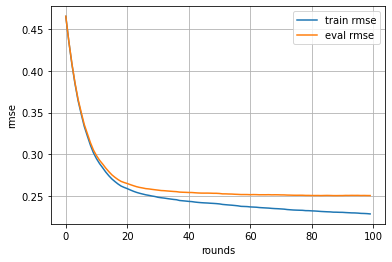

[0]	train-rmse:0.464893	eval-rmse:0.465102
[1]	train-rmse:0.434378	eval-rmse:0.434833
[2]	train-rmse:0.407539	eval-rmse:0.408356
[3]	train-rmse:0.384312	eval-rmse:0.385457
[4]	train-rmse:0.364314	eval-rmse:0.365861
[5]	train-rmse:0.348495	eval-rmse:0.350532
[6]	train-rmse:0.333574	eval-rmse:0.335858
[7]	train-rmse:0.322223	eval-rmse:0.325038
[8]	train-rmse:0.311179	eval-rmse:0.314226
[9]	train-rmse:0.301878	eval-rmse:0.305233
[10]	train-rmse:0.294858	eval-rmse:0.298535
[11]	train-rmse:0.288982	eval-rmse:0.292984
[12]	train-rmse:0.284082	eval-rmse:0.288502
[13]	train-rmse:0.278957	eval-rmse:0.283683
[14]	train-rmse:0.27456	eval-rmse:0.27948
[15]	train-rmse:0.270708	eval-rmse:0.275626
[16]	train-rmse:0.26757	eval-rmse:0.272633
[17]	train-rmse:0.264675	eval-rmse:0.269958
[18]	train-rmse:0.26222	eval-rmse:0.267785
[19]	train-rmse:0.260592	eval-rmse:0.266443
[20]	train-rmse:0.259166	eval-rmse:0.265257
[21]	train-rmse:0.257555	eval-rmse:0.263933
[22]	train-rmse:0.256031	eval-rmse:0.26269
[23

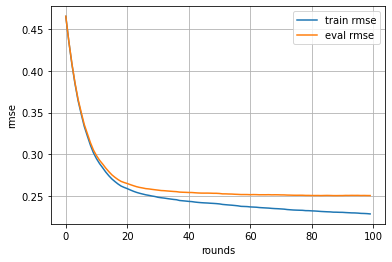

[0]	train-rmse:0.464893	eval-rmse:0.465102
[1]	train-rmse:0.434378	eval-rmse:0.434833
[2]	train-rmse:0.407539	eval-rmse:0.408356
[3]	train-rmse:0.384312	eval-rmse:0.385457
[4]	train-rmse:0.364314	eval-rmse:0.365861
[5]	train-rmse:0.348495	eval-rmse:0.350532
[6]	train-rmse:0.333574	eval-rmse:0.335858
[7]	train-rmse:0.322223	eval-rmse:0.325038
[8]	train-rmse:0.311179	eval-rmse:0.314226
[9]	train-rmse:0.301878	eval-rmse:0.305233
[10]	train-rmse:0.294858	eval-rmse:0.298535
[11]	train-rmse:0.288982	eval-rmse:0.292984
[12]	train-rmse:0.284082	eval-rmse:0.288502
[13]	train-rmse:0.278957	eval-rmse:0.283683
[14]	train-rmse:0.27456	eval-rmse:0.27948
[15]	train-rmse:0.270708	eval-rmse:0.275626
[16]	train-rmse:0.26757	eval-rmse:0.272633
[17]	train-rmse:0.264675	eval-rmse:0.269958
[18]	train-rmse:0.26222	eval-rmse:0.267785
[19]	train-rmse:0.260592	eval-rmse:0.266443
[20]	train-rmse:0.259166	eval-rmse:0.265257
[21]	train-rmse:0.257555	eval-rmse:0.263933
[22]	train-rmse:0.256031	eval-rmse:0.26269
[23

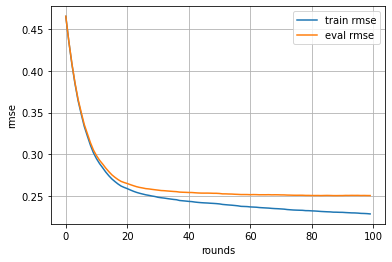

[0]	train-rmse:0.464893	eval-rmse:0.465102
[1]	train-rmse:0.434378	eval-rmse:0.434833
[2]	train-rmse:0.407539	eval-rmse:0.408356
[3]	train-rmse:0.384312	eval-rmse:0.385457
[4]	train-rmse:0.364314	eval-rmse:0.365861
[5]	train-rmse:0.348495	eval-rmse:0.350532
[6]	train-rmse:0.333574	eval-rmse:0.335858
[7]	train-rmse:0.322223	eval-rmse:0.325038
[8]	train-rmse:0.311179	eval-rmse:0.314226
[9]	train-rmse:0.301878	eval-rmse:0.305233
[10]	train-rmse:0.294858	eval-rmse:0.298535
[11]	train-rmse:0.288982	eval-rmse:0.292984
[12]	train-rmse:0.284082	eval-rmse:0.288502
[13]	train-rmse:0.278957	eval-rmse:0.283683
[14]	train-rmse:0.27456	eval-rmse:0.27948
[15]	train-rmse:0.270708	eval-rmse:0.275626
[16]	train-rmse:0.26757	eval-rmse:0.272633
[17]	train-rmse:0.264675	eval-rmse:0.269958
[18]	train-rmse:0.26222	eval-rmse:0.267785
[19]	train-rmse:0.260592	eval-rmse:0.266443
[20]	train-rmse:0.259166	eval-rmse:0.265257
[21]	train-rmse:0.257555	eval-rmse:0.263933
[22]	train-rmse:0.256031	eval-rmse:0.26269
[23

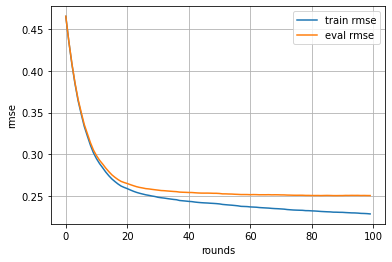

[0]	train-rmse:0.464893	eval-rmse:0.465102
[1]	train-rmse:0.434378	eval-rmse:0.434833
[2]	train-rmse:0.407539	eval-rmse:0.408356
[3]	train-rmse:0.384312	eval-rmse:0.385457
[4]	train-rmse:0.364314	eval-rmse:0.365861
[5]	train-rmse:0.348495	eval-rmse:0.350532
[6]	train-rmse:0.333574	eval-rmse:0.335858
[7]	train-rmse:0.322223	eval-rmse:0.325038
[8]	train-rmse:0.311179	eval-rmse:0.314226
[9]	train-rmse:0.301878	eval-rmse:0.305233
[10]	train-rmse:0.294858	eval-rmse:0.298535
[11]	train-rmse:0.288982	eval-rmse:0.292984
[12]	train-rmse:0.284082	eval-rmse:0.288502
[13]	train-rmse:0.278957	eval-rmse:0.283683
[14]	train-rmse:0.27456	eval-rmse:0.27948
[15]	train-rmse:0.270708	eval-rmse:0.275626
[16]	train-rmse:0.26757	eval-rmse:0.272633
[17]	train-rmse:0.264675	eval-rmse:0.269958
[18]	train-rmse:0.26222	eval-rmse:0.267785
[19]	train-rmse:0.260592	eval-rmse:0.266443
[20]	train-rmse:0.259166	eval-rmse:0.265257
[21]	train-rmse:0.257555	eval-rmse:0.263933
[22]	train-rmse:0.256031	eval-rmse:0.26269
[23

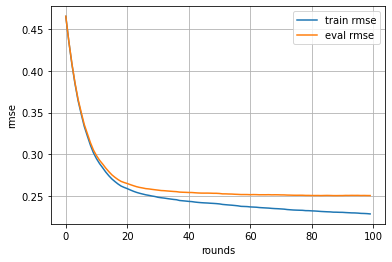

[0]	train-rmse:0.464893	eval-rmse:0.465102
[1]	train-rmse:0.434378	eval-rmse:0.434833
[2]	train-rmse:0.407539	eval-rmse:0.408356
[3]	train-rmse:0.384312	eval-rmse:0.385457
[4]	train-rmse:0.364314	eval-rmse:0.365861
[5]	train-rmse:0.348495	eval-rmse:0.350532
[6]	train-rmse:0.333574	eval-rmse:0.335858
[7]	train-rmse:0.322223	eval-rmse:0.325038
[8]	train-rmse:0.311179	eval-rmse:0.314226
[9]	train-rmse:0.301878	eval-rmse:0.305233
[10]	train-rmse:0.294858	eval-rmse:0.298535
[11]	train-rmse:0.288982	eval-rmse:0.292984
[12]	train-rmse:0.284082	eval-rmse:0.288502
[13]	train-rmse:0.278957	eval-rmse:0.283683
[14]	train-rmse:0.27456	eval-rmse:0.27948
[15]	train-rmse:0.270708	eval-rmse:0.275626
[16]	train-rmse:0.26757	eval-rmse:0.272633
[17]	train-rmse:0.264675	eval-rmse:0.269958
[18]	train-rmse:0.26222	eval-rmse:0.267785
[19]	train-rmse:0.260592	eval-rmse:0.266443
[20]	train-rmse:0.259166	eval-rmse:0.265257
[21]	train-rmse:0.257555	eval-rmse:0.263933
[22]	train-rmse:0.256031	eval-rmse:0.26269
[23

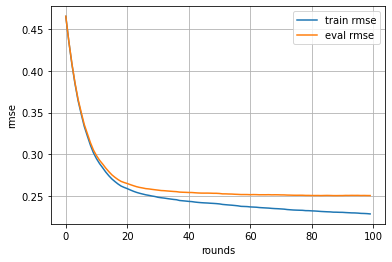

[0]	train-rmse:0.464889	eval-rmse:0.465127
[1]	train-rmse:0.434376	eval-rmse:0.434858
[2]	train-rmse:0.407545	eval-rmse:0.408349
[3]	train-rmse:0.38432	eval-rmse:0.385428
[4]	train-rmse:0.364328	eval-rmse:0.365823
[5]	train-rmse:0.348519	eval-rmse:0.350477
[6]	train-rmse:0.333594	eval-rmse:0.335822
[7]	train-rmse:0.322251	eval-rmse:0.324975
[8]	train-rmse:0.311207	eval-rmse:0.314159
[9]	train-rmse:0.301905	eval-rmse:0.305149
[10]	train-rmse:0.294888	eval-rmse:0.29845
[11]	train-rmse:0.289013	eval-rmse:0.2929
[12]	train-rmse:0.284104	eval-rmse:0.288452
[13]	train-rmse:0.278982	eval-rmse:0.283653
[14]	train-rmse:0.274585	eval-rmse:0.279495
[15]	train-rmse:0.27072	eval-rmse:0.275686
[16]	train-rmse:0.267585	eval-rmse:0.272699
[17]	train-rmse:0.264691	eval-rmse:0.270095
[18]	train-rmse:0.262236	eval-rmse:0.267911
[19]	train-rmse:0.260623	eval-rmse:0.266552
[20]	train-rmse:0.25915	eval-rmse:0.265226
[21]	train-rmse:0.257546	eval-rmse:0.263828
[22]	train-rmse:0.256002	eval-rmse:0.262527
[23]

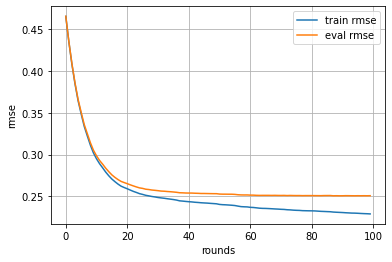

[0]	train-rmse:0.464889	eval-rmse:0.465127
[1]	train-rmse:0.434376	eval-rmse:0.434858
[2]	train-rmse:0.407545	eval-rmse:0.408349
[3]	train-rmse:0.38432	eval-rmse:0.385428
[4]	train-rmse:0.364328	eval-rmse:0.365823
[5]	train-rmse:0.348519	eval-rmse:0.350477
[6]	train-rmse:0.333594	eval-rmse:0.335822
[7]	train-rmse:0.322251	eval-rmse:0.324975
[8]	train-rmse:0.311207	eval-rmse:0.314159
[9]	train-rmse:0.301905	eval-rmse:0.305149
[10]	train-rmse:0.294888	eval-rmse:0.29845
[11]	train-rmse:0.289013	eval-rmse:0.2929
[12]	train-rmse:0.284104	eval-rmse:0.288452
[13]	train-rmse:0.278982	eval-rmse:0.283653
[14]	train-rmse:0.274585	eval-rmse:0.279495
[15]	train-rmse:0.27072	eval-rmse:0.275686
[16]	train-rmse:0.267585	eval-rmse:0.272699
[17]	train-rmse:0.264691	eval-rmse:0.270095
[18]	train-rmse:0.262236	eval-rmse:0.267911
[19]	train-rmse:0.260623	eval-rmse:0.266552
[20]	train-rmse:0.25915	eval-rmse:0.265226
[21]	train-rmse:0.257546	eval-rmse:0.263828
[22]	train-rmse:0.256002	eval-rmse:0.262527
[23]

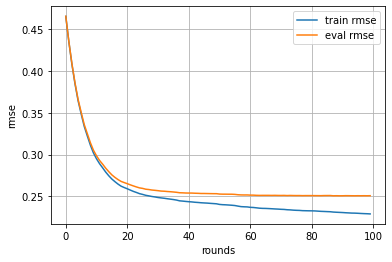

[0]	train-rmse:0.464889	eval-rmse:0.465127
[1]	train-rmse:0.434376	eval-rmse:0.434858
[2]	train-rmse:0.407545	eval-rmse:0.408349
[3]	train-rmse:0.38432	eval-rmse:0.385428
[4]	train-rmse:0.364328	eval-rmse:0.365823
[5]	train-rmse:0.348519	eval-rmse:0.350477
[6]	train-rmse:0.333594	eval-rmse:0.335822
[7]	train-rmse:0.322251	eval-rmse:0.324975
[8]	train-rmse:0.311207	eval-rmse:0.314159
[9]	train-rmse:0.301905	eval-rmse:0.305149
[10]	train-rmse:0.294888	eval-rmse:0.29845
[11]	train-rmse:0.289013	eval-rmse:0.2929
[12]	train-rmse:0.284104	eval-rmse:0.288452
[13]	train-rmse:0.278982	eval-rmse:0.283653
[14]	train-rmse:0.274585	eval-rmse:0.279495
[15]	train-rmse:0.27072	eval-rmse:0.275686
[16]	train-rmse:0.267585	eval-rmse:0.272699
[17]	train-rmse:0.264691	eval-rmse:0.270095
[18]	train-rmse:0.262236	eval-rmse:0.267911
[19]	train-rmse:0.260623	eval-rmse:0.266552
[20]	train-rmse:0.25915	eval-rmse:0.265226
[21]	train-rmse:0.257546	eval-rmse:0.263828
[22]	train-rmse:0.256002	eval-rmse:0.262527
[23]

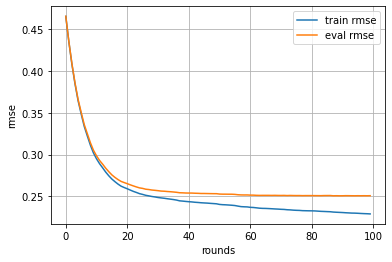

[0]	train-rmse:0.464889	eval-rmse:0.465127
[1]	train-rmse:0.434376	eval-rmse:0.434858
[2]	train-rmse:0.407545	eval-rmse:0.408349
[3]	train-rmse:0.38432	eval-rmse:0.385428
[4]	train-rmse:0.364328	eval-rmse:0.365823
[5]	train-rmse:0.348519	eval-rmse:0.350477
[6]	train-rmse:0.333594	eval-rmse:0.335822
[7]	train-rmse:0.322251	eval-rmse:0.324975
[8]	train-rmse:0.311207	eval-rmse:0.314159
[9]	train-rmse:0.301905	eval-rmse:0.305149
[10]	train-rmse:0.294888	eval-rmse:0.29845
[11]	train-rmse:0.289013	eval-rmse:0.2929
[12]	train-rmse:0.284104	eval-rmse:0.288452
[13]	train-rmse:0.278982	eval-rmse:0.283653
[14]	train-rmse:0.274585	eval-rmse:0.279495
[15]	train-rmse:0.27072	eval-rmse:0.275686
[16]	train-rmse:0.267585	eval-rmse:0.272699
[17]	train-rmse:0.264691	eval-rmse:0.270095
[18]	train-rmse:0.262236	eval-rmse:0.267911
[19]	train-rmse:0.260623	eval-rmse:0.266552
[20]	train-rmse:0.25915	eval-rmse:0.265226
[21]	train-rmse:0.257546	eval-rmse:0.263828
[22]	train-rmse:0.256002	eval-rmse:0.262527
[23]

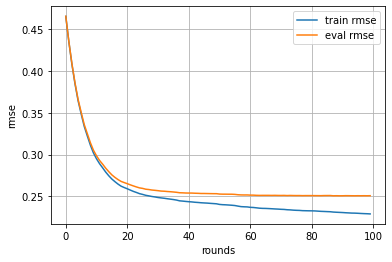

[0]	train-rmse:0.464889	eval-rmse:0.465127
[1]	train-rmse:0.434376	eval-rmse:0.434858
[2]	train-rmse:0.407545	eval-rmse:0.408349
[3]	train-rmse:0.38432	eval-rmse:0.385428
[4]	train-rmse:0.364328	eval-rmse:0.365823
[5]	train-rmse:0.348519	eval-rmse:0.350477
[6]	train-rmse:0.333594	eval-rmse:0.335822
[7]	train-rmse:0.322251	eval-rmse:0.324975
[8]	train-rmse:0.311207	eval-rmse:0.314159
[9]	train-rmse:0.301905	eval-rmse:0.305149
[10]	train-rmse:0.294888	eval-rmse:0.29845
[11]	train-rmse:0.289013	eval-rmse:0.2929
[12]	train-rmse:0.284104	eval-rmse:0.288452
[13]	train-rmse:0.278982	eval-rmse:0.283653
[14]	train-rmse:0.274585	eval-rmse:0.279495
[15]	train-rmse:0.27072	eval-rmse:0.275686
[16]	train-rmse:0.267585	eval-rmse:0.272699
[17]	train-rmse:0.264691	eval-rmse:0.270095
[18]	train-rmse:0.262236	eval-rmse:0.267911
[19]	train-rmse:0.260623	eval-rmse:0.266552
[20]	train-rmse:0.25915	eval-rmse:0.265226
[21]	train-rmse:0.257546	eval-rmse:0.263828
[22]	train-rmse:0.256002	eval-rmse:0.262527
[23]

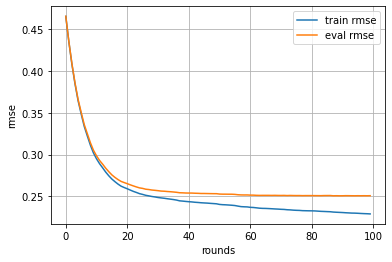

[0]	train-rmse:0.464889	eval-rmse:0.465127
[1]	train-rmse:0.434376	eval-rmse:0.434858
[2]	train-rmse:0.407545	eval-rmse:0.408349
[3]	train-rmse:0.38432	eval-rmse:0.385428
[4]	train-rmse:0.364328	eval-rmse:0.365823
[5]	train-rmse:0.348519	eval-rmse:0.350477
[6]	train-rmse:0.333594	eval-rmse:0.335822
[7]	train-rmse:0.322251	eval-rmse:0.324975
[8]	train-rmse:0.311207	eval-rmse:0.314159
[9]	train-rmse:0.301905	eval-rmse:0.305149
[10]	train-rmse:0.294888	eval-rmse:0.29845
[11]	train-rmse:0.289013	eval-rmse:0.2929
[12]	train-rmse:0.284104	eval-rmse:0.288452
[13]	train-rmse:0.278982	eval-rmse:0.283653
[14]	train-rmse:0.274585	eval-rmse:0.279495
[15]	train-rmse:0.27072	eval-rmse:0.275686
[16]	train-rmse:0.267585	eval-rmse:0.272699
[17]	train-rmse:0.264691	eval-rmse:0.270095
[18]	train-rmse:0.262236	eval-rmse:0.267911
[19]	train-rmse:0.260623	eval-rmse:0.266552
[20]	train-rmse:0.25915	eval-rmse:0.265226
[21]	train-rmse:0.257546	eval-rmse:0.263829
[22]	train-rmse:0.256002	eval-rmse:0.262527
[23]

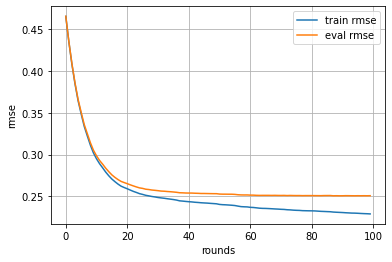

[0]	train-rmse:0.464889	eval-rmse:0.465127
[1]	train-rmse:0.434376	eval-rmse:0.434858
[2]	train-rmse:0.407545	eval-rmse:0.408349
[3]	train-rmse:0.38432	eval-rmse:0.385428
[4]	train-rmse:0.364328	eval-rmse:0.365823
[5]	train-rmse:0.348519	eval-rmse:0.350477
[6]	train-rmse:0.333594	eval-rmse:0.335822
[7]	train-rmse:0.322251	eval-rmse:0.324975
[8]	train-rmse:0.311207	eval-rmse:0.314159
[9]	train-rmse:0.301905	eval-rmse:0.305149
[10]	train-rmse:0.294888	eval-rmse:0.29845
[11]	train-rmse:0.289013	eval-rmse:0.2929
[12]	train-rmse:0.284104	eval-rmse:0.288452
[13]	train-rmse:0.278982	eval-rmse:0.283653
[14]	train-rmse:0.274585	eval-rmse:0.279495
[15]	train-rmse:0.27072	eval-rmse:0.275686
[16]	train-rmse:0.267585	eval-rmse:0.272699
[17]	train-rmse:0.264691	eval-rmse:0.270095
[18]	train-rmse:0.262236	eval-rmse:0.267911
[19]	train-rmse:0.260623	eval-rmse:0.266552
[20]	train-rmse:0.25915	eval-rmse:0.265226
[21]	train-rmse:0.257546	eval-rmse:0.263828
[22]	train-rmse:0.256002	eval-rmse:0.262527
[23]

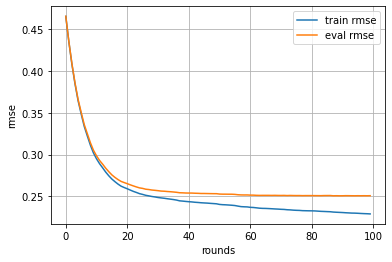

[0]	train-rmse:0.464889	eval-rmse:0.465127
[1]	train-rmse:0.434376	eval-rmse:0.434858
[2]	train-rmse:0.407545	eval-rmse:0.408349
[3]	train-rmse:0.38432	eval-rmse:0.385428
[4]	train-rmse:0.364328	eval-rmse:0.365823
[5]	train-rmse:0.348519	eval-rmse:0.350477
[6]	train-rmse:0.333594	eval-rmse:0.335822
[7]	train-rmse:0.322251	eval-rmse:0.324975
[8]	train-rmse:0.311207	eval-rmse:0.314159
[9]	train-rmse:0.301905	eval-rmse:0.305149
[10]	train-rmse:0.294888	eval-rmse:0.29845
[11]	train-rmse:0.289013	eval-rmse:0.2929
[12]	train-rmse:0.284104	eval-rmse:0.288452
[13]	train-rmse:0.278982	eval-rmse:0.283653
[14]	train-rmse:0.274585	eval-rmse:0.279495
[15]	train-rmse:0.27072	eval-rmse:0.275686
[16]	train-rmse:0.267585	eval-rmse:0.272699
[17]	train-rmse:0.264691	eval-rmse:0.270095
[18]	train-rmse:0.262236	eval-rmse:0.267911
[19]	train-rmse:0.260623	eval-rmse:0.266552
[20]	train-rmse:0.25915	eval-rmse:0.265226
[21]	train-rmse:0.257546	eval-rmse:0.263828
[22]	train-rmse:0.256002	eval-rmse:0.262527
[23]

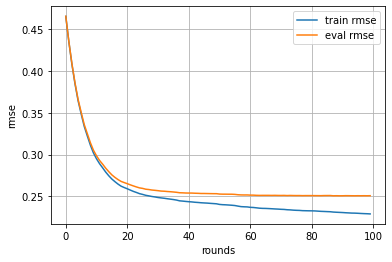

[0]	train-rmse:0.464889	eval-rmse:0.465127
[1]	train-rmse:0.434376	eval-rmse:0.434858
[2]	train-rmse:0.407545	eval-rmse:0.408349
[3]	train-rmse:0.38432	eval-rmse:0.385428
[4]	train-rmse:0.364328	eval-rmse:0.365823
[5]	train-rmse:0.348519	eval-rmse:0.350477
[6]	train-rmse:0.333594	eval-rmse:0.335822
[7]	train-rmse:0.322251	eval-rmse:0.324975
[8]	train-rmse:0.311207	eval-rmse:0.314159
[9]	train-rmse:0.301905	eval-rmse:0.305149
[10]	train-rmse:0.294888	eval-rmse:0.29845
[11]	train-rmse:0.289013	eval-rmse:0.2929
[12]	train-rmse:0.284104	eval-rmse:0.288452
[13]	train-rmse:0.278982	eval-rmse:0.283653
[14]	train-rmse:0.274585	eval-rmse:0.279495
[15]	train-rmse:0.27072	eval-rmse:0.275686
[16]	train-rmse:0.267585	eval-rmse:0.272699
[17]	train-rmse:0.264691	eval-rmse:0.270095
[18]	train-rmse:0.262236	eval-rmse:0.267911
[19]	train-rmse:0.260623	eval-rmse:0.266552
[20]	train-rmse:0.25915	eval-rmse:0.265226
[21]	train-rmse:0.257546	eval-rmse:0.263828
[22]	train-rmse:0.256002	eval-rmse:0.262527
[23]

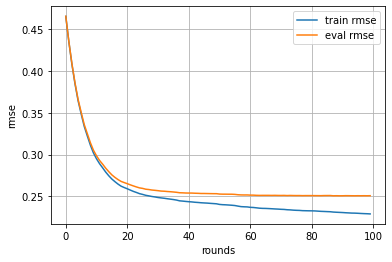

[0]	train-rmse:0.464889	eval-rmse:0.465127
[1]	train-rmse:0.434376	eval-rmse:0.434858
[2]	train-rmse:0.407545	eval-rmse:0.408349
[3]	train-rmse:0.38432	eval-rmse:0.385428
[4]	train-rmse:0.364328	eval-rmse:0.365823
[5]	train-rmse:0.348519	eval-rmse:0.350477
[6]	train-rmse:0.333594	eval-rmse:0.335822
[7]	train-rmse:0.322251	eval-rmse:0.324975
[8]	train-rmse:0.311207	eval-rmse:0.314159
[9]	train-rmse:0.301905	eval-rmse:0.305149
[10]	train-rmse:0.294888	eval-rmse:0.29845
[11]	train-rmse:0.289013	eval-rmse:0.2929
[12]	train-rmse:0.284104	eval-rmse:0.288452
[13]	train-rmse:0.278982	eval-rmse:0.283653
[14]	train-rmse:0.274585	eval-rmse:0.279495
[15]	train-rmse:0.27072	eval-rmse:0.275686
[16]	train-rmse:0.267585	eval-rmse:0.272699
[17]	train-rmse:0.264691	eval-rmse:0.270095
[18]	train-rmse:0.262236	eval-rmse:0.267911
[19]	train-rmse:0.260623	eval-rmse:0.266552
[20]	train-rmse:0.25915	eval-rmse:0.265226
[21]	train-rmse:0.257546	eval-rmse:0.263828
[22]	train-rmse:0.256002	eval-rmse:0.262527
[23]

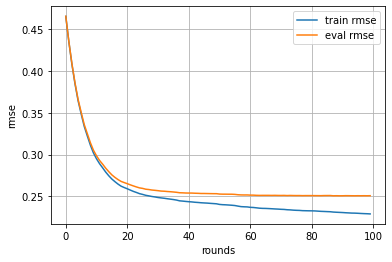

[0]	train-rmse:0.464888	eval-rmse:0.465113
[1]	train-rmse:0.434375	eval-rmse:0.434844
[2]	train-rmse:0.407547	eval-rmse:0.408342
[3]	train-rmse:0.384329	eval-rmse:0.385419
[4]	train-rmse:0.364339	eval-rmse:0.365813
[5]	train-rmse:0.34853	eval-rmse:0.350472
[6]	train-rmse:0.333605	eval-rmse:0.335818
[7]	train-rmse:0.322261	eval-rmse:0.324971
[8]	train-rmse:0.311221	eval-rmse:0.314162
[9]	train-rmse:0.301923	eval-rmse:0.305198
[10]	train-rmse:0.294871	eval-rmse:0.298465
[11]	train-rmse:0.289015	eval-rmse:0.292934
[12]	train-rmse:0.284109	eval-rmse:0.288471
[13]	train-rmse:0.278992	eval-rmse:0.283635
[14]	train-rmse:0.2746	eval-rmse:0.279473
[15]	train-rmse:0.270735	eval-rmse:0.275663
[16]	train-rmse:0.267605	eval-rmse:0.272714
[17]	train-rmse:0.264725	eval-rmse:0.27011
[18]	train-rmse:0.262272	eval-rmse:0.267914
[19]	train-rmse:0.260672	eval-rmse:0.266581
[20]	train-rmse:0.259208	eval-rmse:0.265296
[21]	train-rmse:0.257613	eval-rmse:0.263939
[22]	train-rmse:0.256087	eval-rmse:0.26268
[23

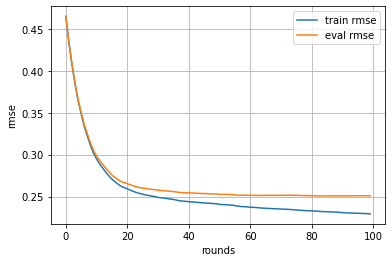

[0]	train-rmse:0.464888	eval-rmse:0.465113
[1]	train-rmse:0.434375	eval-rmse:0.434844
[2]	train-rmse:0.407547	eval-rmse:0.408342
[3]	train-rmse:0.384329	eval-rmse:0.385419
[4]	train-rmse:0.364339	eval-rmse:0.365813
[5]	train-rmse:0.34853	eval-rmse:0.350472
[6]	train-rmse:0.333605	eval-rmse:0.335818
[7]	train-rmse:0.322261	eval-rmse:0.324971
[8]	train-rmse:0.311221	eval-rmse:0.314162
[9]	train-rmse:0.301923	eval-rmse:0.305198
[10]	train-rmse:0.294871	eval-rmse:0.298465
[11]	train-rmse:0.289015	eval-rmse:0.292934
[12]	train-rmse:0.284109	eval-rmse:0.288471
[13]	train-rmse:0.278992	eval-rmse:0.283635
[14]	train-rmse:0.2746	eval-rmse:0.279473
[15]	train-rmse:0.270735	eval-rmse:0.275663
[16]	train-rmse:0.267605	eval-rmse:0.272714
[17]	train-rmse:0.264725	eval-rmse:0.27011
[18]	train-rmse:0.262272	eval-rmse:0.267914
[19]	train-rmse:0.260672	eval-rmse:0.266581
[20]	train-rmse:0.259208	eval-rmse:0.265296
[21]	train-rmse:0.257613	eval-rmse:0.263939
[22]	train-rmse:0.256087	eval-rmse:0.26268
[23

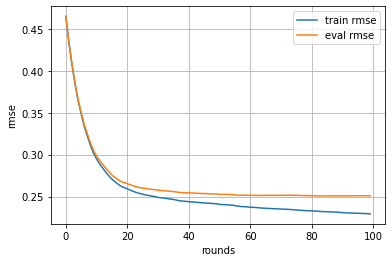

[0]	train-rmse:0.464888	eval-rmse:0.465113
[1]	train-rmse:0.434375	eval-rmse:0.434844
[2]	train-rmse:0.407547	eval-rmse:0.408342
[3]	train-rmse:0.384329	eval-rmse:0.385419
[4]	train-rmse:0.364339	eval-rmse:0.365813
[5]	train-rmse:0.34853	eval-rmse:0.350472
[6]	train-rmse:0.333605	eval-rmse:0.335818
[7]	train-rmse:0.322261	eval-rmse:0.324971
[8]	train-rmse:0.311221	eval-rmse:0.314162
[9]	train-rmse:0.301923	eval-rmse:0.305198
[10]	train-rmse:0.294871	eval-rmse:0.298465
[11]	train-rmse:0.289015	eval-rmse:0.292934
[12]	train-rmse:0.284109	eval-rmse:0.288471
[13]	train-rmse:0.278992	eval-rmse:0.283635
[14]	train-rmse:0.2746	eval-rmse:0.279473
[15]	train-rmse:0.270735	eval-rmse:0.275663
[16]	train-rmse:0.267605	eval-rmse:0.272714
[17]	train-rmse:0.264725	eval-rmse:0.27011
[18]	train-rmse:0.262272	eval-rmse:0.267914
[19]	train-rmse:0.260672	eval-rmse:0.266581
[20]	train-rmse:0.259208	eval-rmse:0.265296
[21]	train-rmse:0.257613	eval-rmse:0.263939
[22]	train-rmse:0.256087	eval-rmse:0.26268
[23

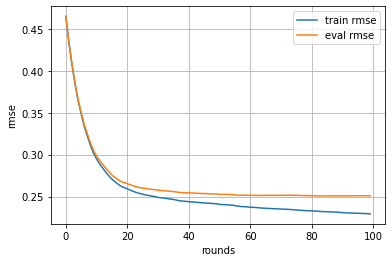

[0]	train-rmse:0.464888	eval-rmse:0.465113
[1]	train-rmse:0.434375	eval-rmse:0.434844
[2]	train-rmse:0.407547	eval-rmse:0.408342
[3]	train-rmse:0.384329	eval-rmse:0.385419
[4]	train-rmse:0.364339	eval-rmse:0.365813
[5]	train-rmse:0.34853	eval-rmse:0.350472
[6]	train-rmse:0.333605	eval-rmse:0.335818
[7]	train-rmse:0.322261	eval-rmse:0.324971
[8]	train-rmse:0.311221	eval-rmse:0.314162
[9]	train-rmse:0.301923	eval-rmse:0.305198
[10]	train-rmse:0.294871	eval-rmse:0.298465
[11]	train-rmse:0.289015	eval-rmse:0.292934
[12]	train-rmse:0.284109	eval-rmse:0.288471
[13]	train-rmse:0.278992	eval-rmse:0.283635
[14]	train-rmse:0.2746	eval-rmse:0.279473
[15]	train-rmse:0.270735	eval-rmse:0.275663
[16]	train-rmse:0.267605	eval-rmse:0.272714
[17]	train-rmse:0.264725	eval-rmse:0.27011
[18]	train-rmse:0.262272	eval-rmse:0.267914
[19]	train-rmse:0.260672	eval-rmse:0.266581
[20]	train-rmse:0.259208	eval-rmse:0.265296
[21]	train-rmse:0.257613	eval-rmse:0.263939
[22]	train-rmse:0.256087	eval-rmse:0.26268
[23

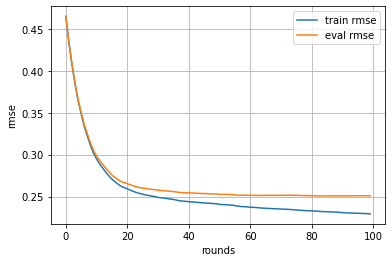

[0]	train-rmse:0.464888	eval-rmse:0.465113
[1]	train-rmse:0.434375	eval-rmse:0.434844
[2]	train-rmse:0.407547	eval-rmse:0.408342
[3]	train-rmse:0.384329	eval-rmse:0.385419
[4]	train-rmse:0.364339	eval-rmse:0.365813
[5]	train-rmse:0.34853	eval-rmse:0.350472
[6]	train-rmse:0.333605	eval-rmse:0.335818
[7]	train-rmse:0.322261	eval-rmse:0.324971
[8]	train-rmse:0.311221	eval-rmse:0.314162
[9]	train-rmse:0.301923	eval-rmse:0.305198
[10]	train-rmse:0.294871	eval-rmse:0.298465
[11]	train-rmse:0.289015	eval-rmse:0.292934
[12]	train-rmse:0.284109	eval-rmse:0.288471
[13]	train-rmse:0.278992	eval-rmse:0.283635
[14]	train-rmse:0.2746	eval-rmse:0.279473
[15]	train-rmse:0.270735	eval-rmse:0.275663
[16]	train-rmse:0.267605	eval-rmse:0.272714
[17]	train-rmse:0.264725	eval-rmse:0.27011
[18]	train-rmse:0.262272	eval-rmse:0.267914
[19]	train-rmse:0.260672	eval-rmse:0.266581
[20]	train-rmse:0.259208	eval-rmse:0.265296
[21]	train-rmse:0.257613	eval-rmse:0.263939
[22]	train-rmse:0.256087	eval-rmse:0.26268
[23

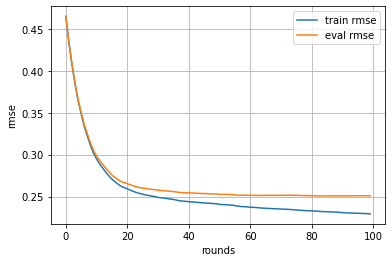

[0]	train-rmse:0.464888	eval-rmse:0.465113
[1]	train-rmse:0.434375	eval-rmse:0.434844
[2]	train-rmse:0.407547	eval-rmse:0.408342
[3]	train-rmse:0.384329	eval-rmse:0.385419
[4]	train-rmse:0.364339	eval-rmse:0.365813
[5]	train-rmse:0.34853	eval-rmse:0.350472
[6]	train-rmse:0.333605	eval-rmse:0.335818
[7]	train-rmse:0.322261	eval-rmse:0.324971
[8]	train-rmse:0.311221	eval-rmse:0.314162
[9]	train-rmse:0.301923	eval-rmse:0.305198
[10]	train-rmse:0.294871	eval-rmse:0.298465
[11]	train-rmse:0.289015	eval-rmse:0.292934
[12]	train-rmse:0.284109	eval-rmse:0.288471
[13]	train-rmse:0.278992	eval-rmse:0.283635
[14]	train-rmse:0.2746	eval-rmse:0.279473
[15]	train-rmse:0.270735	eval-rmse:0.275663
[16]	train-rmse:0.267605	eval-rmse:0.272714
[17]	train-rmse:0.264725	eval-rmse:0.27011
[18]	train-rmse:0.262272	eval-rmse:0.267914
[19]	train-rmse:0.260672	eval-rmse:0.266581
[20]	train-rmse:0.259208	eval-rmse:0.265296
[21]	train-rmse:0.257613	eval-rmse:0.263939
[22]	train-rmse:0.256087	eval-rmse:0.26268
[23

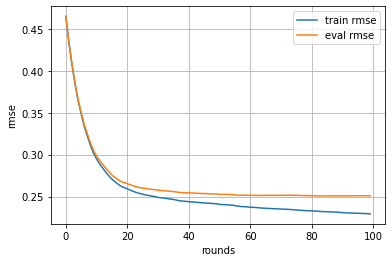

[0]	train-rmse:0.464888	eval-rmse:0.465113
[1]	train-rmse:0.434375	eval-rmse:0.434844
[2]	train-rmse:0.407547	eval-rmse:0.408342
[3]	train-rmse:0.384329	eval-rmse:0.385419
[4]	train-rmse:0.364339	eval-rmse:0.365813
[5]	train-rmse:0.34853	eval-rmse:0.350472
[6]	train-rmse:0.333605	eval-rmse:0.335818
[7]	train-rmse:0.322261	eval-rmse:0.324971
[8]	train-rmse:0.311221	eval-rmse:0.314162
[9]	train-rmse:0.301923	eval-rmse:0.305198
[10]	train-rmse:0.294871	eval-rmse:0.298465
[11]	train-rmse:0.289015	eval-rmse:0.292934
[12]	train-rmse:0.284109	eval-rmse:0.288471
[13]	train-rmse:0.278992	eval-rmse:0.283635
[14]	train-rmse:0.2746	eval-rmse:0.279473
[15]	train-rmse:0.270735	eval-rmse:0.275663
[16]	train-rmse:0.267605	eval-rmse:0.272714
[17]	train-rmse:0.264725	eval-rmse:0.27011
[18]	train-rmse:0.262272	eval-rmse:0.267914
[19]	train-rmse:0.260672	eval-rmse:0.266581
[20]	train-rmse:0.259208	eval-rmse:0.265296
[21]	train-rmse:0.257613	eval-rmse:0.263939
[22]	train-rmse:0.256087	eval-rmse:0.26268
[23

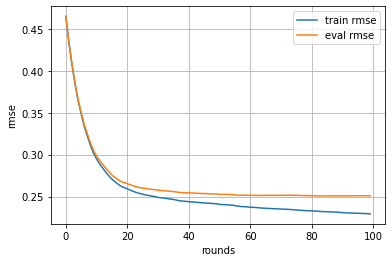

[0]	train-rmse:0.464888	eval-rmse:0.465113
[1]	train-rmse:0.434375	eval-rmse:0.434844
[2]	train-rmse:0.407547	eval-rmse:0.408342
[3]	train-rmse:0.384329	eval-rmse:0.385419
[4]	train-rmse:0.364339	eval-rmse:0.365813
[5]	train-rmse:0.34853	eval-rmse:0.350472
[6]	train-rmse:0.333605	eval-rmse:0.335818
[7]	train-rmse:0.322261	eval-rmse:0.324971
[8]	train-rmse:0.311221	eval-rmse:0.314162
[9]	train-rmse:0.301923	eval-rmse:0.305198
[10]	train-rmse:0.294871	eval-rmse:0.298465
[11]	train-rmse:0.289015	eval-rmse:0.292934
[12]	train-rmse:0.284109	eval-rmse:0.288471
[13]	train-rmse:0.278992	eval-rmse:0.283635
[14]	train-rmse:0.2746	eval-rmse:0.279473
[15]	train-rmse:0.270735	eval-rmse:0.275663
[16]	train-rmse:0.267605	eval-rmse:0.272714
[17]	train-rmse:0.264725	eval-rmse:0.27011
[18]	train-rmse:0.262272	eval-rmse:0.267914
[19]	train-rmse:0.260672	eval-rmse:0.266581
[20]	train-rmse:0.259208	eval-rmse:0.265296
[21]	train-rmse:0.257613	eval-rmse:0.263939
[22]	train-rmse:0.256087	eval-rmse:0.26268
[23

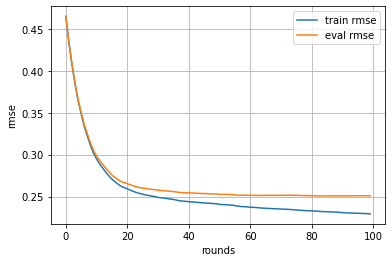

[0]	train-rmse:0.464888	eval-rmse:0.465113
[1]	train-rmse:0.434375	eval-rmse:0.434844
[2]	train-rmse:0.407547	eval-rmse:0.408342
[3]	train-rmse:0.384329	eval-rmse:0.385419
[4]	train-rmse:0.364339	eval-rmse:0.365813
[5]	train-rmse:0.34853	eval-rmse:0.350472
[6]	train-rmse:0.333605	eval-rmse:0.335818
[7]	train-rmse:0.322261	eval-rmse:0.324971
[8]	train-rmse:0.311221	eval-rmse:0.314162
[9]	train-rmse:0.301923	eval-rmse:0.305198
[10]	train-rmse:0.294871	eval-rmse:0.298465
[11]	train-rmse:0.289015	eval-rmse:0.292934
[12]	train-rmse:0.284109	eval-rmse:0.288471
[13]	train-rmse:0.278992	eval-rmse:0.283635
[14]	train-rmse:0.2746	eval-rmse:0.279473
[15]	train-rmse:0.270735	eval-rmse:0.275663
[16]	train-rmse:0.267605	eval-rmse:0.272714
[17]	train-rmse:0.264725	eval-rmse:0.27011
[18]	train-rmse:0.262272	eval-rmse:0.267914
[19]	train-rmse:0.260672	eval-rmse:0.266581
[20]	train-rmse:0.259208	eval-rmse:0.265296
[21]	train-rmse:0.257613	eval-rmse:0.263939
[22]	train-rmse:0.256087	eval-rmse:0.26268
[23

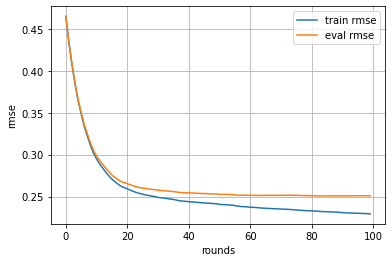

[0]	train-rmse:0.464888	eval-rmse:0.465113
[1]	train-rmse:0.434375	eval-rmse:0.434844
[2]	train-rmse:0.407546	eval-rmse:0.408342
[3]	train-rmse:0.384329	eval-rmse:0.385419
[4]	train-rmse:0.364339	eval-rmse:0.365813
[5]	train-rmse:0.34853	eval-rmse:0.350472
[6]	train-rmse:0.333605	eval-rmse:0.335818
[7]	train-rmse:0.322261	eval-rmse:0.324971
[8]	train-rmse:0.311221	eval-rmse:0.314162
[9]	train-rmse:0.301923	eval-rmse:0.305198
[10]	train-rmse:0.294871	eval-rmse:0.298465
[11]	train-rmse:0.289015	eval-rmse:0.292934
[12]	train-rmse:0.284109	eval-rmse:0.288471
[13]	train-rmse:0.278992	eval-rmse:0.283635
[14]	train-rmse:0.2746	eval-rmse:0.279473
[15]	train-rmse:0.270735	eval-rmse:0.275663
[16]	train-rmse:0.267605	eval-rmse:0.272714
[17]	train-rmse:0.264725	eval-rmse:0.27011
[18]	train-rmse:0.262272	eval-rmse:0.267914
[19]	train-rmse:0.260672	eval-rmse:0.266581
[20]	train-rmse:0.259208	eval-rmse:0.265296
[21]	train-rmse:0.257613	eval-rmse:0.263939
[22]	train-rmse:0.256087	eval-rmse:0.26268
[23

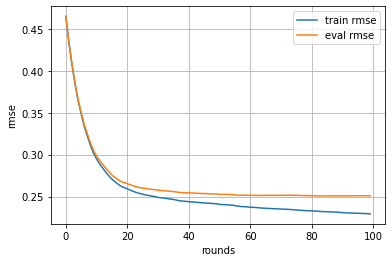

Tuning subsample ...
[0]	train-rmse:0.464811	eval-rmse:0.464938
[1]	train-rmse:0.434607	eval-rmse:0.434964
[2]	train-rmse:0.407774	eval-rmse:0.408379
[3]	train-rmse:0.384535	eval-rmse:0.385343
[4]	train-rmse:0.364605	eval-rmse:0.365766
[5]	train-rmse:0.348728	eval-rmse:0.350356
[6]	train-rmse:0.333849	eval-rmse:0.335701
[7]	train-rmse:0.322414	eval-rmse:0.324659
[8]	train-rmse:0.311363	eval-rmse:0.313767
[9]	train-rmse:0.302	eval-rmse:0.304749
[10]	train-rmse:0.294917	eval-rmse:0.298029
[11]	train-rmse:0.289002	eval-rmse:0.292402
[12]	train-rmse:0.283995	eval-rmse:0.287958
[13]	train-rmse:0.278798	eval-rmse:0.28314
[14]	train-rmse:0.274298	eval-rmse:0.278874
[15]	train-rmse:0.270511	eval-rmse:0.275305
[16]	train-rmse:0.267441	eval-rmse:0.272623
[17]	train-rmse:0.264749	eval-rmse:0.270223
[18]	train-rmse:0.262299	eval-rmse:0.268038
[19]	train-rmse:0.260399	eval-rmse:0.266384
[20]	train-rmse:0.259007	eval-rmse:0.265218
[21]	train-rmse:0.257383	eval-rmse:0.263856
[22]	train-rmse:0.25577	e

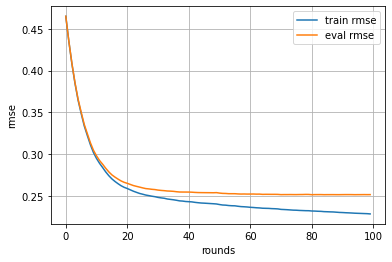

[0]	train-rmse:0.464895	eval-rmse:0.46517
[1]	train-rmse:0.434366	eval-rmse:0.434803
[2]	train-rmse:0.407581	eval-rmse:0.40828
[3]	train-rmse:0.384312	eval-rmse:0.385165
[4]	train-rmse:0.364373	eval-rmse:0.365546
[5]	train-rmse:0.348538	eval-rmse:0.350112
[6]	train-rmse:0.333747	eval-rmse:0.335669
[7]	train-rmse:0.322317	eval-rmse:0.324687
[8]	train-rmse:0.311235	eval-rmse:0.313871
[9]	train-rmse:0.301929	eval-rmse:0.304855
[10]	train-rmse:0.294802	eval-rmse:0.29798
[11]	train-rmse:0.288926	eval-rmse:0.292358
[12]	train-rmse:0.283967	eval-rmse:0.287896
[13]	train-rmse:0.278596	eval-rmse:0.282739
[14]	train-rmse:0.274086	eval-rmse:0.278534
[15]	train-rmse:0.270347	eval-rmse:0.275016
[16]	train-rmse:0.267063	eval-rmse:0.271925
[17]	train-rmse:0.264281	eval-rmse:0.269505
[18]	train-rmse:0.261747	eval-rmse:0.267273
[19]	train-rmse:0.259837	eval-rmse:0.265607
[20]	train-rmse:0.258505	eval-rmse:0.264497
[21]	train-rmse:0.256804	eval-rmse:0.26307
[22]	train-rmse:0.255169	eval-rmse:0.261724
[2

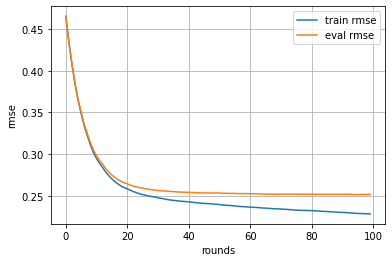

[0]	train-rmse:0.46486	eval-rmse:0.465007
[1]	train-rmse:0.434568	eval-rmse:0.435007
[2]	train-rmse:0.407781	eval-rmse:0.408512
[3]	train-rmse:0.384595	eval-rmse:0.385658
[4]	train-rmse:0.364554	eval-rmse:0.36608
[5]	train-rmse:0.348677	eval-rmse:0.350698
[6]	train-rmse:0.333761	eval-rmse:0.335973
[7]	train-rmse:0.322442	eval-rmse:0.325142
[8]	train-rmse:0.311168	eval-rmse:0.314314
[9]	train-rmse:0.30184	eval-rmse:0.305232
[10]	train-rmse:0.29469	eval-rmse:0.298362
[11]	train-rmse:0.288863	eval-rmse:0.292887
[12]	train-rmse:0.284006	eval-rmse:0.288527
[13]	train-rmse:0.278839	eval-rmse:0.283586
[14]	train-rmse:0.274416	eval-rmse:0.279347
[15]	train-rmse:0.270436	eval-rmse:0.275556
[16]	train-rmse:0.267287	eval-rmse:0.272683
[17]	train-rmse:0.264505	eval-rmse:0.270075
[18]	train-rmse:0.262176	eval-rmse:0.267926
[19]	train-rmse:0.260234	eval-rmse:0.266272
[20]	train-rmse:0.258911	eval-rmse:0.265175
[21]	train-rmse:0.257186	eval-rmse:0.263635
[22]	train-rmse:0.255687	eval-rmse:0.262295
[2

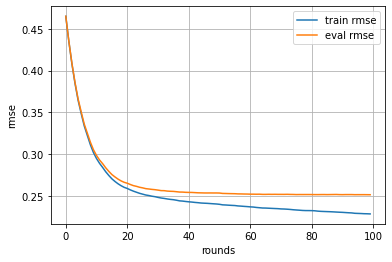

[0]	train-rmse:0.464863	eval-rmse:0.465036
[1]	train-rmse:0.43431	eval-rmse:0.43469
[2]	train-rmse:0.407523	eval-rmse:0.408121
[3]	train-rmse:0.384403	eval-rmse:0.385232
[4]	train-rmse:0.364468	eval-rmse:0.365701
[5]	train-rmse:0.348641	eval-rmse:0.350364
[6]	train-rmse:0.333786	eval-rmse:0.335798
[7]	train-rmse:0.322222	eval-rmse:0.324723
[8]	train-rmse:0.311161	eval-rmse:0.313971
[9]	train-rmse:0.301813	eval-rmse:0.304853
[10]	train-rmse:0.294786	eval-rmse:0.298076
[11]	train-rmse:0.288954	eval-rmse:0.29258
[12]	train-rmse:0.283991	eval-rmse:0.288091
[13]	train-rmse:0.278762	eval-rmse:0.283111
[14]	train-rmse:0.274369	eval-rmse:0.279029
[15]	train-rmse:0.270496	eval-rmse:0.275455
[16]	train-rmse:0.267258	eval-rmse:0.272408
[17]	train-rmse:0.264361	eval-rmse:0.269754
[18]	train-rmse:0.261926	eval-rmse:0.267618
[19]	train-rmse:0.26031	eval-rmse:0.266275
[20]	train-rmse:0.258839	eval-rmse:0.26513
[21]	train-rmse:0.25719	eval-rmse:0.263766
[22]	train-rmse:0.255672	eval-rmse:0.262522
[23]

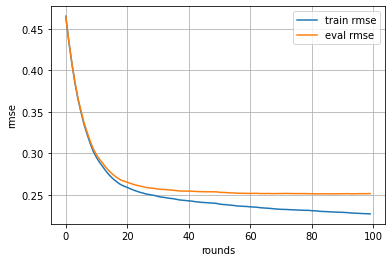

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298266
[11]	train-rmse:0.288763	eval-rmse:0.292698
[12]	train-rmse:0.283802	eval-rmse:0.28821
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279247
[15]	train-rmse:0.270322	eval-rmse:0.275395
[16]	train-rmse:0.267139	eval-rmse:0.272476
[17]	train-rmse:0.264225	eval-rmse:0.269729
[18]	train-rmse:0.261741	eval-rmse:0.267481
[19]	train-rmse:0.260096	eval-rmse:0.266138
[20]	train-rmse:0.258595	eval-rmse:0.264977
[21]	train-rmse:0.256972	eval-rmse:0.263583
[22]	train-rmse:0.255468	eval-rmse:0.262234


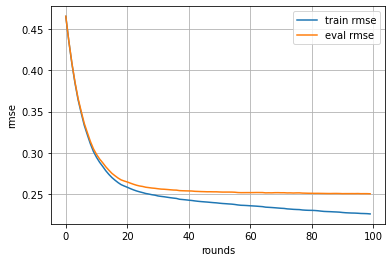

[0]	train-rmse:0.464819	eval-rmse:0.465101
[1]	train-rmse:0.434325	eval-rmse:0.434834
[2]	train-rmse:0.407553	eval-rmse:0.408348
[3]	train-rmse:0.38436	eval-rmse:0.385484
[4]	train-rmse:0.364203	eval-rmse:0.36566
[5]	train-rmse:0.348414	eval-rmse:0.350303
[6]	train-rmse:0.33349	eval-rmse:0.335621
[7]	train-rmse:0.321836	eval-rmse:0.324557
[8]	train-rmse:0.310865	eval-rmse:0.313811
[9]	train-rmse:0.30155	eval-rmse:0.304807
[10]	train-rmse:0.29445	eval-rmse:0.298083
[11]	train-rmse:0.288529	eval-rmse:0.292526
[12]	train-rmse:0.283732	eval-rmse:0.288135
[13]	train-rmse:0.278457	eval-rmse:0.283155
[14]	train-rmse:0.274091	eval-rmse:0.279115
[15]	train-rmse:0.270264	eval-rmse:0.275469
[16]	train-rmse:0.266992	eval-rmse:0.272522
[17]	train-rmse:0.264229	eval-rmse:0.269825
[18]	train-rmse:0.261873	eval-rmse:0.267785
[19]	train-rmse:0.260245	eval-rmse:0.266448
[20]	train-rmse:0.258707	eval-rmse:0.265197
[21]	train-rmse:0.257034	eval-rmse:0.263739
[22]	train-rmse:0.255489	eval-rmse:0.262185
[23

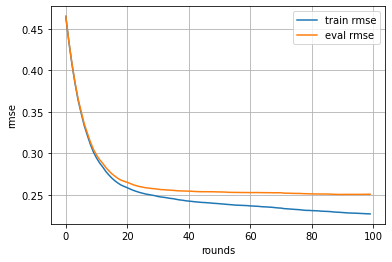

[0]	train-rmse:0.464836	eval-rmse:0.465128
[1]	train-rmse:0.434333	eval-rmse:0.43479
[2]	train-rmse:0.407578	eval-rmse:0.408316
[3]	train-rmse:0.3844	eval-rmse:0.385495
[4]	train-rmse:0.364239	eval-rmse:0.36571
[5]	train-rmse:0.348479	eval-rmse:0.350325
[6]	train-rmse:0.333617	eval-rmse:0.335714
[7]	train-rmse:0.321953	eval-rmse:0.324579
[8]	train-rmse:0.310986	eval-rmse:0.313889
[9]	train-rmse:0.301661	eval-rmse:0.304742
[10]	train-rmse:0.294626	eval-rmse:0.298045
[11]	train-rmse:0.288675	eval-rmse:0.292367
[12]	train-rmse:0.283809	eval-rmse:0.287881
[13]	train-rmse:0.278491	eval-rmse:0.282764
[14]	train-rmse:0.274038	eval-rmse:0.278697
[15]	train-rmse:0.270259	eval-rmse:0.275043
[16]	train-rmse:0.267031	eval-rmse:0.271987
[17]	train-rmse:0.264081	eval-rmse:0.269243
[18]	train-rmse:0.26178	eval-rmse:0.267201
[19]	train-rmse:0.260144	eval-rmse:0.265801
[20]	train-rmse:0.258701	eval-rmse:0.264666
[21]	train-rmse:0.25695	eval-rmse:0.263174
[22]	train-rmse:0.255375	eval-rmse:0.261827
[23]

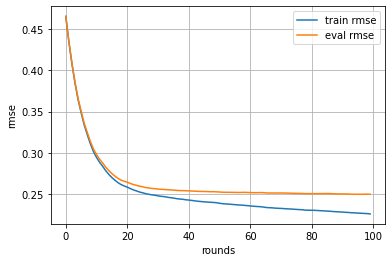

[0]	train-rmse:0.464802	eval-rmse:0.465025
[1]	train-rmse:0.434259	eval-rmse:0.434811
[2]	train-rmse:0.407498	eval-rmse:0.408269
[3]	train-rmse:0.384335	eval-rmse:0.385351
[4]	train-rmse:0.36431	eval-rmse:0.365719
[5]	train-rmse:0.348562	eval-rmse:0.350338
[6]	train-rmse:0.333617	eval-rmse:0.335496
[7]	train-rmse:0.321955	eval-rmse:0.324395
[8]	train-rmse:0.310815	eval-rmse:0.313669
[9]	train-rmse:0.301493	eval-rmse:0.304612
[10]	train-rmse:0.294483	eval-rmse:0.298101
[11]	train-rmse:0.288631	eval-rmse:0.292637
[12]	train-rmse:0.283787	eval-rmse:0.28811
[13]	train-rmse:0.278576	eval-rmse:0.283182
[14]	train-rmse:0.274153	eval-rmse:0.278923
[15]	train-rmse:0.270393	eval-rmse:0.275394
[16]	train-rmse:0.267122	eval-rmse:0.272431
[17]	train-rmse:0.264217	eval-rmse:0.269905
[18]	train-rmse:0.261851	eval-rmse:0.26779
[19]	train-rmse:0.260182	eval-rmse:0.266415
[20]	train-rmse:0.258575	eval-rmse:0.265138
[21]	train-rmse:0.25675	eval-rmse:0.26362
[22]	train-rmse:0.255323	eval-rmse:0.262351
[23

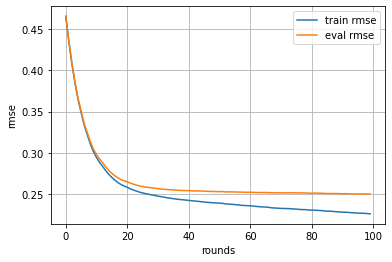

Tuning gamma ...
[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298266
[11]	train-rmse:0.288763	eval-rmse:0.292698
[12]	train-rmse:0.283802	eval-rmse:0.28821
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279247
[15]	train-rmse:0.270322	eval-rmse:0.275395
[16]	train-rmse:0.267139	eval-rmse:0.272476
[17]	train-rmse:0.264225	eval-rmse:0.269729
[18]	train-rmse:0.261741	eval-rmse:0.267481
[19]	train-rmse:0.260096	eval-rmse:0.266138
[20]	train-rmse:0.258595	eval-rmse:0.264977
[21]	train-rmse:0.256972	eval-rmse:0.263583
[22]	train-rmse:0.255468	ev

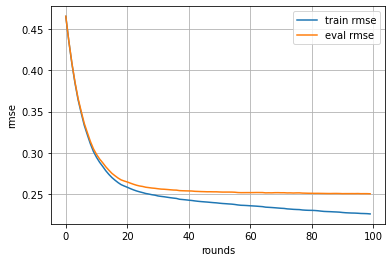

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298266
[11]	train-rmse:0.288763	eval-rmse:0.292698
[12]	train-rmse:0.283802	eval-rmse:0.28821
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279247
[15]	train-rmse:0.270322	eval-rmse:0.275395
[16]	train-rmse:0.267139	eval-rmse:0.272476
[17]	train-rmse:0.264225	eval-rmse:0.269729
[18]	train-rmse:0.261741	eval-rmse:0.267481
[19]	train-rmse:0.260096	eval-rmse:0.266138
[20]	train-rmse:0.258595	eval-rmse:0.264977
[21]	train-rmse:0.256972	eval-rmse:0.263583
[22]	train-rmse:0.255468	eval-rmse:0.262234


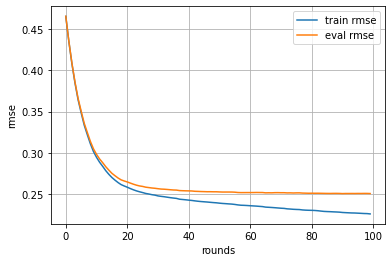

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298266
[11]	train-rmse:0.288763	eval-rmse:0.292698
[12]	train-rmse:0.283802	eval-rmse:0.28821
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279247
[15]	train-rmse:0.270322	eval-rmse:0.275395
[16]	train-rmse:0.267139	eval-rmse:0.272476
[17]	train-rmse:0.264225	eval-rmse:0.269729
[18]	train-rmse:0.261741	eval-rmse:0.267481
[19]	train-rmse:0.260096	eval-rmse:0.266138
[20]	train-rmse:0.258595	eval-rmse:0.264977
[21]	train-rmse:0.256972	eval-rmse:0.263583
[22]	train-rmse:0.255468	eval-rmse:0.262234


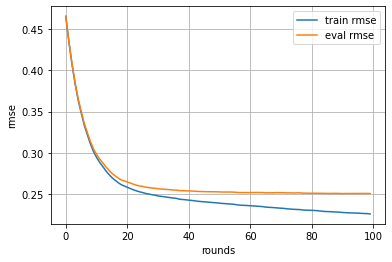

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298266
[11]	train-rmse:0.288763	eval-rmse:0.292698
[12]	train-rmse:0.283802	eval-rmse:0.28821
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279247
[15]	train-rmse:0.270322	eval-rmse:0.275395
[16]	train-rmse:0.267139	eval-rmse:0.272476
[17]	train-rmse:0.264225	eval-rmse:0.269729
[18]	train-rmse:0.261741	eval-rmse:0.267481
[19]	train-rmse:0.260096	eval-rmse:0.266138
[20]	train-rmse:0.258595	eval-rmse:0.264977
[21]	train-rmse:0.256972	eval-rmse:0.263583
[22]	train-rmse:0.255468	eval-rmse:0.262234


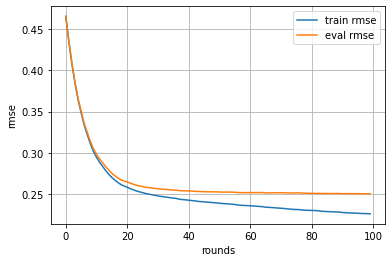

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298271
[11]	train-rmse:0.288763	eval-rmse:0.292702
[12]	train-rmse:0.283802	eval-rmse:0.288215
[13]	train-rmse:0.278594	eval-rmse:0.283382
[14]	train-rmse:0.274179	eval-rmse:0.279253
[15]	train-rmse:0.270322	eval-rmse:0.2754
[16]	train-rmse:0.267139	eval-rmse:0.272482
[17]	train-rmse:0.264225	eval-rmse:0.269735
[18]	train-rmse:0.261742	eval-rmse:0.267487
[19]	train-rmse:0.260097	eval-rmse:0.266143
[20]	train-rmse:0.258595	eval-rmse:0.264982
[21]	train-rmse:0.256972	eval-rmse:0.263588
[22]	train-rmse:0.255468	eval-rmse:0.262239
[

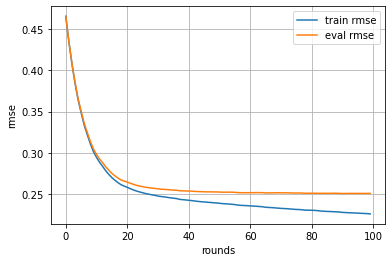

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298271
[11]	train-rmse:0.288763	eval-rmse:0.292702
[12]	train-rmse:0.283802	eval-rmse:0.288215
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279249
[15]	train-rmse:0.270322	eval-rmse:0.275396
[16]	train-rmse:0.267139	eval-rmse:0.272478
[17]	train-rmse:0.264225	eval-rmse:0.269731
[18]	train-rmse:0.261741	eval-rmse:0.267483
[19]	train-rmse:0.260096	eval-rmse:0.26614
[20]	train-rmse:0.258595	eval-rmse:0.264978
[21]	train-rmse:0.256972	eval-rmse:0.263585
[22]	train-rmse:0.255468	eval-rmse:0.262236


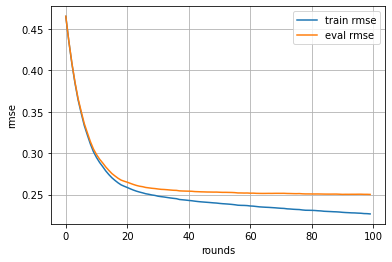

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298271
[11]	train-rmse:0.288763	eval-rmse:0.292702
[12]	train-rmse:0.283802	eval-rmse:0.288215
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279249
[15]	train-rmse:0.270322	eval-rmse:0.275396
[16]	train-rmse:0.267139	eval-rmse:0.272478
[17]	train-rmse:0.264225	eval-rmse:0.269731
[18]	train-rmse:0.261741	eval-rmse:0.267483
[19]	train-rmse:0.260096	eval-rmse:0.26614
[20]	train-rmse:0.258595	eval-rmse:0.264978
[21]	train-rmse:0.256973	eval-rmse:0.263587
[22]	train-rmse:0.255469	eval-rmse:0.262239


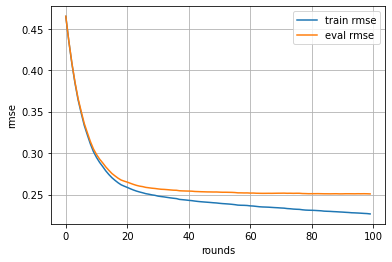

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298271
[11]	train-rmse:0.288763	eval-rmse:0.292702
[12]	train-rmse:0.283802	eval-rmse:0.288215
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279249
[15]	train-rmse:0.270322	eval-rmse:0.275396
[16]	train-rmse:0.267139	eval-rmse:0.272478
[17]	train-rmse:0.264225	eval-rmse:0.269731
[18]	train-rmse:0.261741	eval-rmse:0.267483
[19]	train-rmse:0.260096	eval-rmse:0.26614
[20]	train-rmse:0.258595	eval-rmse:0.264978
[21]	train-rmse:0.256973	eval-rmse:0.263587
[22]	train-rmse:0.255469	eval-rmse:0.262239


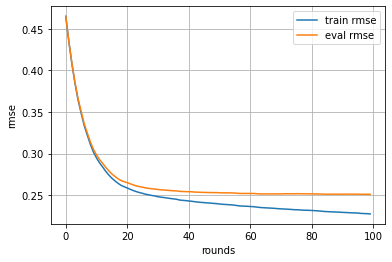

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298271
[11]	train-rmse:0.288763	eval-rmse:0.292702
[12]	train-rmse:0.283802	eval-rmse:0.288215
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279249
[15]	train-rmse:0.270322	eval-rmse:0.275396
[16]	train-rmse:0.267139	eval-rmse:0.272478
[17]	train-rmse:0.264225	eval-rmse:0.269731
[18]	train-rmse:0.261741	eval-rmse:0.267483
[19]	train-rmse:0.260096	eval-rmse:0.26614
[20]	train-rmse:0.258595	eval-rmse:0.264978
[21]	train-rmse:0.256973	eval-rmse:0.263587
[22]	train-rmse:0.255469	eval-rmse:0.262239


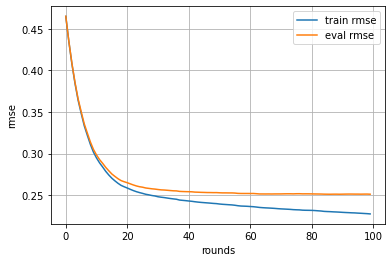

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298271
[11]	train-rmse:0.288763	eval-rmse:0.292702
[12]	train-rmse:0.283802	eval-rmse:0.288215
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279249
[15]	train-rmse:0.270322	eval-rmse:0.275396
[16]	train-rmse:0.267139	eval-rmse:0.272478
[17]	train-rmse:0.264225	eval-rmse:0.269731
[18]	train-rmse:0.261741	eval-rmse:0.267483
[19]	train-rmse:0.260096	eval-rmse:0.26614
[20]	train-rmse:0.258595	eval-rmse:0.264978
[21]	train-rmse:0.256973	eval-rmse:0.263587
[22]	train-rmse:0.255469	eval-rmse:0.262239


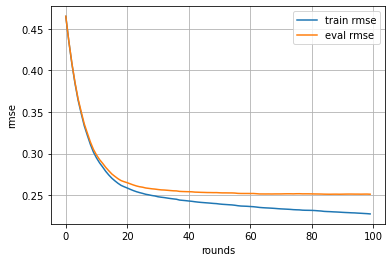

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298271
[11]	train-rmse:0.288763	eval-rmse:0.292702
[12]	train-rmse:0.283802	eval-rmse:0.288215
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279249
[15]	train-rmse:0.270322	eval-rmse:0.275396
[16]	train-rmse:0.267139	eval-rmse:0.272478
[17]	train-rmse:0.264225	eval-rmse:0.269731
[18]	train-rmse:0.261741	eval-rmse:0.267483
[19]	train-rmse:0.260096	eval-rmse:0.26614
[20]	train-rmse:0.258595	eval-rmse:0.264978
[21]	train-rmse:0.256973	eval-rmse:0.263587
[22]	train-rmse:0.255469	eval-rmse:0.262239


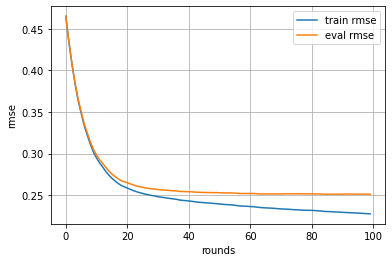

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298271
[11]	train-rmse:0.288763	eval-rmse:0.292702
[12]	train-rmse:0.283802	eval-rmse:0.288215
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279249
[15]	train-rmse:0.270322	eval-rmse:0.275396
[16]	train-rmse:0.267139	eval-rmse:0.272478
[17]	train-rmse:0.264225	eval-rmse:0.269731
[18]	train-rmse:0.261741	eval-rmse:0.267483
[19]	train-rmse:0.260096	eval-rmse:0.26614
[20]	train-rmse:0.258595	eval-rmse:0.264978
[21]	train-rmse:0.256973	eval-rmse:0.263587
[22]	train-rmse:0.255469	eval-rmse:0.262239


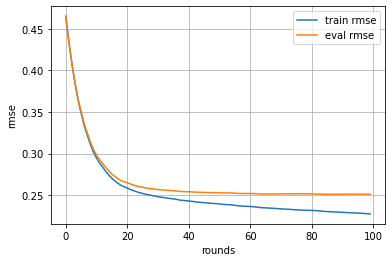

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298271
[11]	train-rmse:0.288763	eval-rmse:0.292702
[12]	train-rmse:0.283802	eval-rmse:0.288215
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279249
[15]	train-rmse:0.270322	eval-rmse:0.275396
[16]	train-rmse:0.267138	eval-rmse:0.272478
[17]	train-rmse:0.264225	eval-rmse:0.269731
[18]	train-rmse:0.261741	eval-rmse:0.267483
[19]	train-rmse:0.260096	eval-rmse:0.26614
[20]	train-rmse:0.258595	eval-rmse:0.264978
[21]	train-rmse:0.256973	eval-rmse:0.263587
[22]	train-rmse:0.255469	eval-rmse:0.262239


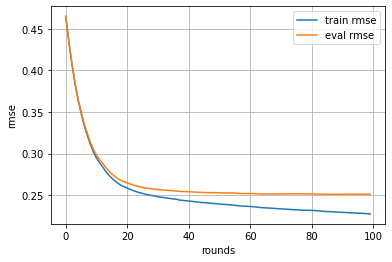

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298271
[11]	train-rmse:0.288763	eval-rmse:0.292702
[12]	train-rmse:0.283802	eval-rmse:0.288215
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279249
[15]	train-rmse:0.270322	eval-rmse:0.275396
[16]	train-rmse:0.267139	eval-rmse:0.272478
[17]	train-rmse:0.264225	eval-rmse:0.269731
[18]	train-rmse:0.261741	eval-rmse:0.267483
[19]	train-rmse:0.260096	eval-rmse:0.26614
[20]	train-rmse:0.258595	eval-rmse:0.264978
[21]	train-rmse:0.256973	eval-rmse:0.263587
[22]	train-rmse:0.255469	eval-rmse:0.262239


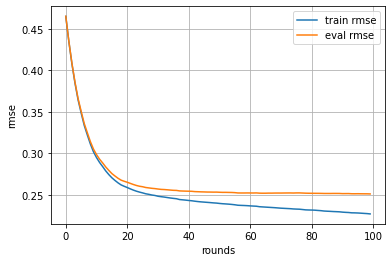

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298271
[11]	train-rmse:0.288763	eval-rmse:0.292702
[12]	train-rmse:0.283802	eval-rmse:0.288215
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279249
[15]	train-rmse:0.270322	eval-rmse:0.275396
[16]	train-rmse:0.267139	eval-rmse:0.272478
[17]	train-rmse:0.264225	eval-rmse:0.269731
[18]	train-rmse:0.261741	eval-rmse:0.267483
[19]	train-rmse:0.260096	eval-rmse:0.26614
[20]	train-rmse:0.258595	eval-rmse:0.264978
[21]	train-rmse:0.256973	eval-rmse:0.263587
[22]	train-rmse:0.255469	eval-rmse:0.262239


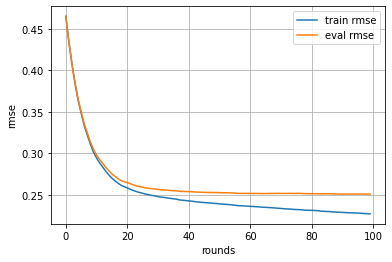

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298271
[11]	train-rmse:0.288763	eval-rmse:0.292702
[12]	train-rmse:0.283802	eval-rmse:0.288215
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279249
[15]	train-rmse:0.270322	eval-rmse:0.275396
[16]	train-rmse:0.267139	eval-rmse:0.272478
[17]	train-rmse:0.264225	eval-rmse:0.269731
[18]	train-rmse:0.261741	eval-rmse:0.267483
[19]	train-rmse:0.260096	eval-rmse:0.26614
[20]	train-rmse:0.258597	eval-rmse:0.264983
[21]	train-rmse:0.256975	eval-rmse:0.263592
[22]	train-rmse:0.255471	eval-rmse:0.262243


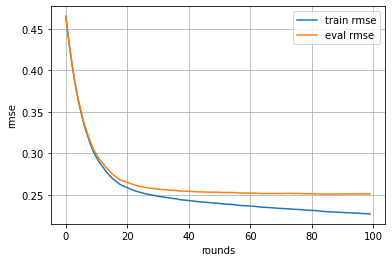

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298271
[11]	train-rmse:0.288763	eval-rmse:0.292702
[12]	train-rmse:0.283802	eval-rmse:0.288215
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279249
[15]	train-rmse:0.270322	eval-rmse:0.275396
[16]	train-rmse:0.267139	eval-rmse:0.272478
[17]	train-rmse:0.264225	eval-rmse:0.269731
[18]	train-rmse:0.261741	eval-rmse:0.267483
[19]	train-rmse:0.260097	eval-rmse:0.266142
[20]	train-rmse:0.258597	eval-rmse:0.264985
[21]	train-rmse:0.256976	eval-rmse:0.263594
[22]	train-rmse:0.255472	eval-rmse:0.262245

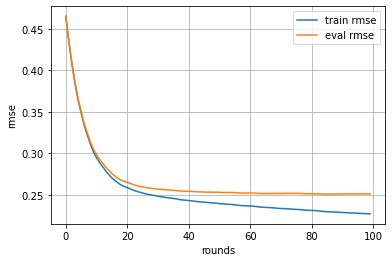

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298271
[11]	train-rmse:0.288763	eval-rmse:0.292702
[12]	train-rmse:0.283802	eval-rmse:0.288215
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279249
[15]	train-rmse:0.270322	eval-rmse:0.275396
[16]	train-rmse:0.267139	eval-rmse:0.272478
[17]	train-rmse:0.264225	eval-rmse:0.269731
[18]	train-rmse:0.261741	eval-rmse:0.267483
[19]	train-rmse:0.260097	eval-rmse:0.266142
[20]	train-rmse:0.258597	eval-rmse:0.264985
[21]	train-rmse:0.256976	eval-rmse:0.263594
[22]	train-rmse:0.255472	eval-rmse:0.262245

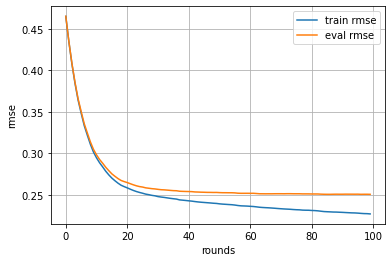

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298271
[11]	train-rmse:0.288763	eval-rmse:0.292702
[12]	train-rmse:0.283802	eval-rmse:0.288215
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279249
[15]	train-rmse:0.270322	eval-rmse:0.275396
[16]	train-rmse:0.267139	eval-rmse:0.272478
[17]	train-rmse:0.264225	eval-rmse:0.269731
[18]	train-rmse:0.261741	eval-rmse:0.267483
[19]	train-rmse:0.2601	eval-rmse:0.266149
[20]	train-rmse:0.2586	eval-rmse:0.264992
[21]	train-rmse:0.256979	eval-rmse:0.2636
[22]	train-rmse:0.255475	eval-rmse:0.262252
[23]	

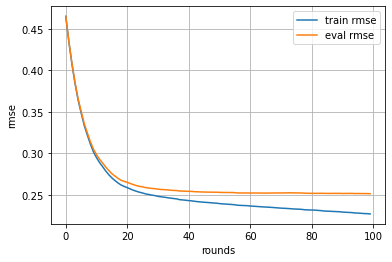

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298271
[11]	train-rmse:0.288763	eval-rmse:0.292702
[12]	train-rmse:0.283802	eval-rmse:0.288215
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279249
[15]	train-rmse:0.270322	eval-rmse:0.275396
[16]	train-rmse:0.267138	eval-rmse:0.272478
[17]	train-rmse:0.264225	eval-rmse:0.269731
[18]	train-rmse:0.261741	eval-rmse:0.267483
[19]	train-rmse:0.260102	eval-rmse:0.266147
[20]	train-rmse:0.258603	eval-rmse:0.26499
[21]	train-rmse:0.256981	eval-rmse:0.263599
[22]	train-rmse:0.255478	eval-rmse:0.26225
[

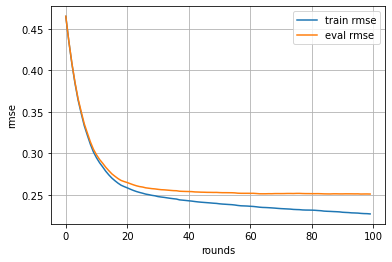

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298271
[11]	train-rmse:0.288763	eval-rmse:0.292702
[12]	train-rmse:0.283802	eval-rmse:0.288215
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279249
[15]	train-rmse:0.270322	eval-rmse:0.275396
[16]	train-rmse:0.267139	eval-rmse:0.272478
[17]	train-rmse:0.264225	eval-rmse:0.269731
[18]	train-rmse:0.261741	eval-rmse:0.267483
[19]	train-rmse:0.260102	eval-rmse:0.266147
[20]	train-rmse:0.258603	eval-rmse:0.26499
[21]	train-rmse:0.256981	eval-rmse:0.263599
[22]	train-rmse:0.255478	eval-rmse:0.26225
[

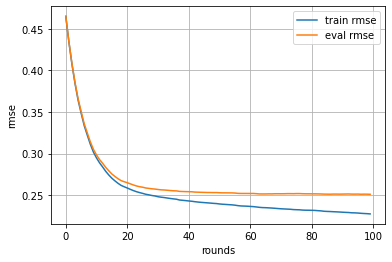

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298271
[11]	train-rmse:0.288763	eval-rmse:0.292702
[12]	train-rmse:0.283802	eval-rmse:0.288215
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279249
[15]	train-rmse:0.270322	eval-rmse:0.275396
[16]	train-rmse:0.267139	eval-rmse:0.272478
[17]	train-rmse:0.264225	eval-rmse:0.269731
[18]	train-rmse:0.261741	eval-rmse:0.267483
[19]	train-rmse:0.260102	eval-rmse:0.266147
[20]	train-rmse:0.258603	eval-rmse:0.26499
[21]	train-rmse:0.256981	eval-rmse:0.263599
[22]	train-rmse:0.255478	eval-rmse:0.26225
[

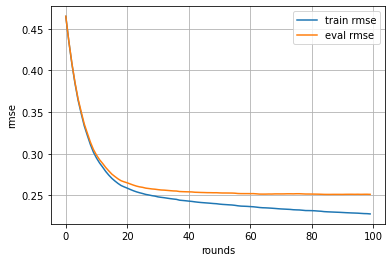

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298271
[11]	train-rmse:0.288763	eval-rmse:0.292702
[12]	train-rmse:0.283802	eval-rmse:0.288215
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274181	eval-rmse:0.27925
[15]	train-rmse:0.270325	eval-rmse:0.275398
[16]	train-rmse:0.267142	eval-rmse:0.27248
[17]	train-rmse:0.264228	eval-rmse:0.269733
[18]	train-rmse:0.261744	eval-rmse:0.267485
[19]	train-rmse:0.260112	eval-rmse:0.266149
[20]	train-rmse:0.258613	eval-rmse:0.264993
[21]	train-rmse:0.256992	eval-rmse:0.263601
[22]	train-rmse:0.255487	eval-rmse:0.262252
[

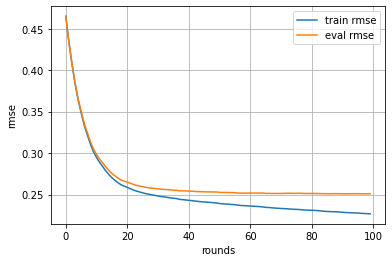

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298271
[11]	train-rmse:0.288763	eval-rmse:0.292702
[12]	train-rmse:0.283802	eval-rmse:0.288215
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274181	eval-rmse:0.27925
[15]	train-rmse:0.270325	eval-rmse:0.275398
[16]	train-rmse:0.267142	eval-rmse:0.27248
[17]	train-rmse:0.264228	eval-rmse:0.269733
[18]	train-rmse:0.261744	eval-rmse:0.267485
[19]	train-rmse:0.260112	eval-rmse:0.266149
[20]	train-rmse:0.258613	eval-rmse:0.264993
[21]	train-rmse:0.256992	eval-rmse:0.263601
[22]	train-rmse:0.255487	eval-rmse:0.262252
[

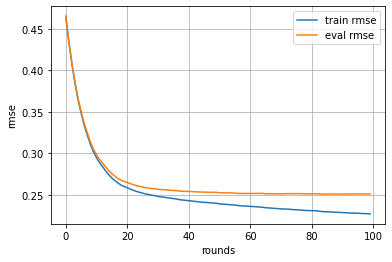

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298271
[11]	train-rmse:0.288763	eval-rmse:0.292702
[12]	train-rmse:0.283802	eval-rmse:0.288215
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274181	eval-rmse:0.27925
[15]	train-rmse:0.270325	eval-rmse:0.275398
[16]	train-rmse:0.267142	eval-rmse:0.27248
[17]	train-rmse:0.264228	eval-rmse:0.269733
[18]	train-rmse:0.261744	eval-rmse:0.267485
[19]	train-rmse:0.260112	eval-rmse:0.266149
[20]	train-rmse:0.258613	eval-rmse:0.264993
[21]	train-rmse:0.256992	eval-rmse:0.263601
[22]	train-rmse:0.255487	eval-rmse:0.262252
[

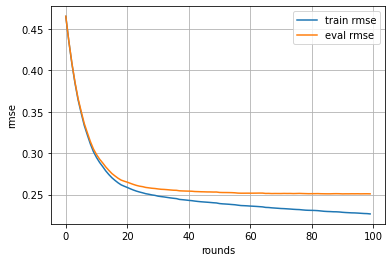

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298271
[11]	train-rmse:0.288763	eval-rmse:0.292702
[12]	train-rmse:0.283802	eval-rmse:0.288215
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274181	eval-rmse:0.27925
[15]	train-rmse:0.270325	eval-rmse:0.275398
[16]	train-rmse:0.267142	eval-rmse:0.27248
[17]	train-rmse:0.264228	eval-rmse:0.269733
[18]	train-rmse:0.261744	eval-rmse:0.267485
[19]	train-rmse:0.260112	eval-rmse:0.266149
[20]	train-rmse:0.258613	eval-rmse:0.264993
[21]	train-rmse:0.256992	eval-rmse:0.263601
[22]	train-rmse:0.255487	eval-rmse:0.262252
[

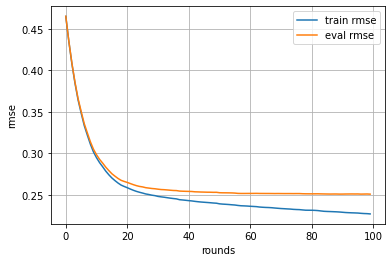

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298271
[11]	train-rmse:0.288763	eval-rmse:0.292702
[12]	train-rmse:0.283802	eval-rmse:0.288215
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274181	eval-rmse:0.27925
[15]	train-rmse:0.270325	eval-rmse:0.275398
[16]	train-rmse:0.267142	eval-rmse:0.27248
[17]	train-rmse:0.264228	eval-rmse:0.269733
[18]	train-rmse:0.261744	eval-rmse:0.267485
[19]	train-rmse:0.260112	eval-rmse:0.266149
[20]	train-rmse:0.258613	eval-rmse:0.264993
[21]	train-rmse:0.256992	eval-rmse:0.263601
[22]	train-rmse:0.255487	eval-rmse:0.262252
[

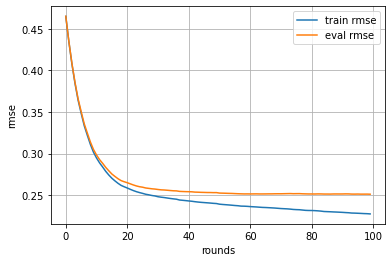

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298271
[11]	train-rmse:0.288763	eval-rmse:0.292702
[12]	train-rmse:0.283802	eval-rmse:0.288215
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274181	eval-rmse:0.27925
[15]	train-rmse:0.270325	eval-rmse:0.275398
[16]	train-rmse:0.267142	eval-rmse:0.27248
[17]	train-rmse:0.264228	eval-rmse:0.269733
[18]	train-rmse:0.261744	eval-rmse:0.267485
[19]	train-rmse:0.260112	eval-rmse:0.266149
[20]	train-rmse:0.258613	eval-rmse:0.264993
[21]	train-rmse:0.256992	eval-rmse:0.263601
[22]	train-rmse:0.255487	eval-rmse:0.262252
[

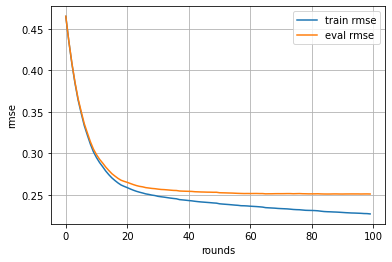

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301713	eval-rmse:0.304979
[10]	train-rmse:0.294702	eval-rmse:0.298274
[11]	train-rmse:0.288768	eval-rmse:0.292706
[12]	train-rmse:0.283809	eval-rmse:0.28822
[13]	train-rmse:0.2786	eval-rmse:0.283382
[14]	train-rmse:0.274187	eval-rmse:0.279255
[15]	train-rmse:0.270335	eval-rmse:0.275403
[16]	train-rmse:0.267152	eval-rmse:0.272484
[17]	train-rmse:0.264239	eval-rmse:0.269738
[18]	train-rmse:0.261755	eval-rmse:0.26749
[19]	train-rmse:0.260124	eval-rmse:0.266154
[20]	train-rmse:0.258625	eval-rmse:0.264998
[21]	train-rmse:0.257002	eval-rmse:0.263606
[22]	train-rmse:0.255498	eval-rmse:0.262257
[23

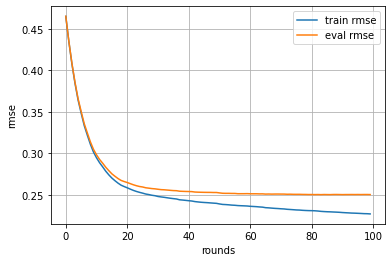

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301713	eval-rmse:0.304979
[10]	train-rmse:0.294701	eval-rmse:0.298274
[11]	train-rmse:0.288768	eval-rmse:0.292706
[12]	train-rmse:0.283809	eval-rmse:0.28822
[13]	train-rmse:0.2786	eval-rmse:0.283382
[14]	train-rmse:0.274187	eval-rmse:0.279255
[15]	train-rmse:0.270335	eval-rmse:0.275403
[16]	train-rmse:0.267152	eval-rmse:0.272484
[17]	train-rmse:0.264239	eval-rmse:0.269738
[18]	train-rmse:0.261755	eval-rmse:0.26749
[19]	train-rmse:0.260124	eval-rmse:0.266154
[20]	train-rmse:0.258625	eval-rmse:0.264998
[21]	train-rmse:0.257002	eval-rmse:0.263606
[22]	train-rmse:0.255498	eval-rmse:0.262257
[23

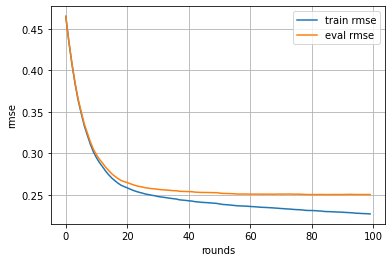

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301713	eval-rmse:0.304979
[10]	train-rmse:0.294702	eval-rmse:0.298274
[11]	train-rmse:0.288768	eval-rmse:0.292706
[12]	train-rmse:0.283809	eval-rmse:0.28822
[13]	train-rmse:0.2786	eval-rmse:0.283382
[14]	train-rmse:0.274187	eval-rmse:0.279255
[15]	train-rmse:0.270335	eval-rmse:0.275403
[16]	train-rmse:0.267152	eval-rmse:0.272484
[17]	train-rmse:0.264239	eval-rmse:0.269738
[18]	train-rmse:0.261755	eval-rmse:0.26749
[19]	train-rmse:0.260124	eval-rmse:0.266154
[20]	train-rmse:0.258625	eval-rmse:0.264998
[21]	train-rmse:0.257002	eval-rmse:0.263606
[22]	train-rmse:0.255498	eval-rmse:0.262257
[23

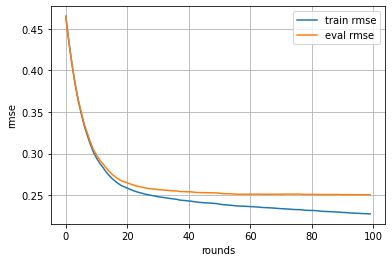

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301713	eval-rmse:0.304979
[10]	train-rmse:0.294702	eval-rmse:0.298274
[11]	train-rmse:0.288768	eval-rmse:0.292706
[12]	train-rmse:0.283809	eval-rmse:0.28822
[13]	train-rmse:0.2786	eval-rmse:0.283382
[14]	train-rmse:0.274187	eval-rmse:0.279255
[15]	train-rmse:0.270335	eval-rmse:0.275403
[16]	train-rmse:0.267152	eval-rmse:0.272484
[17]	train-rmse:0.264239	eval-rmse:0.269738
[18]	train-rmse:0.261755	eval-rmse:0.26749
[19]	train-rmse:0.260124	eval-rmse:0.266154
[20]	train-rmse:0.258625	eval-rmse:0.264998
[21]	train-rmse:0.257002	eval-rmse:0.263606
[22]	train-rmse:0.255498	eval-rmse:0.262257
[23

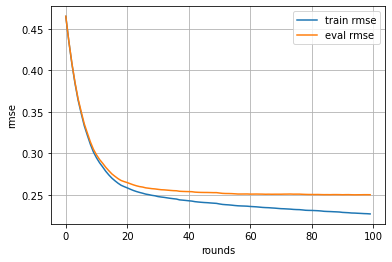

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301713	eval-rmse:0.304979
[10]	train-rmse:0.294707	eval-rmse:0.298267
[11]	train-rmse:0.288777	eval-rmse:0.292701
[12]	train-rmse:0.283818	eval-rmse:0.288214
[13]	train-rmse:0.278608	eval-rmse:0.283376
[14]	train-rmse:0.274195	eval-rmse:0.279249
[15]	train-rmse:0.270344	eval-rmse:0.275397
[16]	train-rmse:0.26716	eval-rmse:0.272478
[17]	train-rmse:0.264247	eval-rmse:0.269731
[18]	train-rmse:0.261781	eval-rmse:0.267509
[19]	train-rmse:0.26015	eval-rmse:0.266171
[20]	train-rmse:0.25867	eval-rmse:0.265003
[21]	train-rmse:0.257047	eval-rmse:0.263611
[22]	train-rmse:0.255522	eval-rmse:0.262321
[2

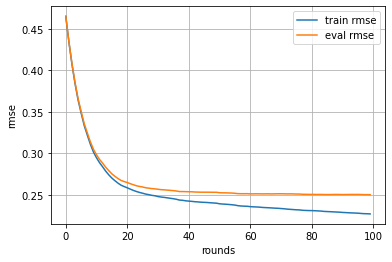

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301713	eval-rmse:0.304979
[10]	train-rmse:0.294707	eval-rmse:0.298267
[11]	train-rmse:0.288777	eval-rmse:0.292701
[12]	train-rmse:0.283818	eval-rmse:0.288214
[13]	train-rmse:0.278608	eval-rmse:0.283376
[14]	train-rmse:0.274195	eval-rmse:0.279249
[15]	train-rmse:0.270346	eval-rmse:0.275397
[16]	train-rmse:0.267163	eval-rmse:0.272478
[17]	train-rmse:0.26425	eval-rmse:0.269731
[18]	train-rmse:0.261784	eval-rmse:0.267509
[19]	train-rmse:0.260153	eval-rmse:0.266171
[20]	train-rmse:0.258673	eval-rmse:0.265003
[21]	train-rmse:0.25705	eval-rmse:0.263611
[22]	train-rmse:0.255525	eval-rmse:0.262321
[

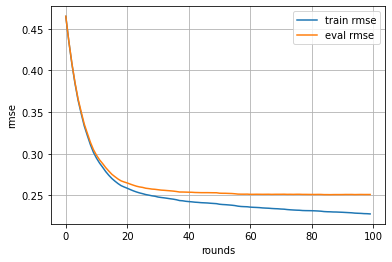

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301713	eval-rmse:0.304979
[10]	train-rmse:0.294706	eval-rmse:0.298267
[11]	train-rmse:0.288777	eval-rmse:0.292701
[12]	train-rmse:0.283818	eval-rmse:0.288214
[13]	train-rmse:0.278608	eval-rmse:0.283376
[14]	train-rmse:0.274195	eval-rmse:0.279249
[15]	train-rmse:0.270346	eval-rmse:0.275397
[16]	train-rmse:0.267163	eval-rmse:0.272478
[17]	train-rmse:0.26425	eval-rmse:0.269731
[18]	train-rmse:0.261784	eval-rmse:0.267509
[19]	train-rmse:0.260153	eval-rmse:0.266171
[20]	train-rmse:0.258673	eval-rmse:0.265003
[21]	train-rmse:0.25705	eval-rmse:0.263611
[22]	train-rmse:0.255525	eval-rmse:0.262321
[

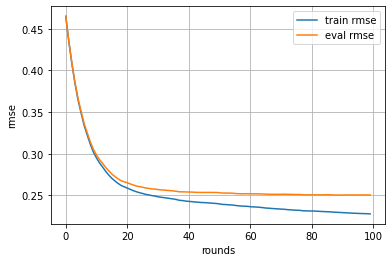

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407523	eval-rmse:0.408337
[3]	train-rmse:0.384296	eval-rmse:0.38542
[4]	train-rmse:0.364287	eval-rmse:0.365837
[5]	train-rmse:0.348435	eval-rmse:0.350485
[6]	train-rmse:0.333498	eval-rmse:0.335784
[7]	train-rmse:0.322071	eval-rmse:0.324745
[8]	train-rmse:0.311032	eval-rmse:0.31394
[9]	train-rmse:0.301719	eval-rmse:0.304982
[10]	train-rmse:0.294713	eval-rmse:0.29827
[11]	train-rmse:0.288783	eval-rmse:0.292703
[12]	train-rmse:0.283824	eval-rmse:0.288217
[13]	train-rmse:0.278619	eval-rmse:0.283381
[14]	train-rmse:0.274205	eval-rmse:0.279253
[15]	train-rmse:0.270357	eval-rmse:0.275402
[16]	train-rmse:0.267174	eval-rmse:0.272483
[17]	train-rmse:0.264258	eval-rmse:0.269789
[18]	train-rmse:0.261794	eval-rmse:0.267568
[19]	train-rmse:0.260164	eval-rmse:0.266222
[20]	train-rmse:0.258683	eval-rmse:0.265054
[21]	train-rmse:0.257064	eval-rmse:0.26367
[22]	train-rmse:0.255538	eval-rmse:0.262382
[23

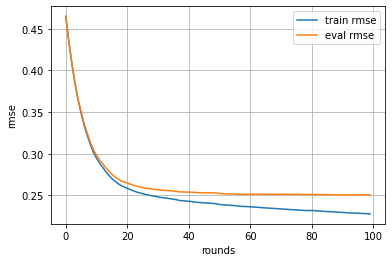

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407523	eval-rmse:0.408337
[3]	train-rmse:0.384296	eval-rmse:0.38542
[4]	train-rmse:0.364287	eval-rmse:0.365837
[5]	train-rmse:0.348435	eval-rmse:0.350485
[6]	train-rmse:0.333498	eval-rmse:0.335784
[7]	train-rmse:0.322071	eval-rmse:0.324745
[8]	train-rmse:0.311032	eval-rmse:0.31394
[9]	train-rmse:0.301719	eval-rmse:0.304982
[10]	train-rmse:0.294713	eval-rmse:0.29827
[11]	train-rmse:0.288783	eval-rmse:0.292703
[12]	train-rmse:0.283824	eval-rmse:0.288217
[13]	train-rmse:0.278619	eval-rmse:0.283381
[14]	train-rmse:0.274205	eval-rmse:0.279253
[15]	train-rmse:0.270357	eval-rmse:0.275402
[16]	train-rmse:0.267174	eval-rmse:0.272483
[17]	train-rmse:0.264258	eval-rmse:0.269789
[18]	train-rmse:0.261794	eval-rmse:0.267568
[19]	train-rmse:0.260164	eval-rmse:0.266222
[20]	train-rmse:0.258683	eval-rmse:0.265054
[21]	train-rmse:0.257064	eval-rmse:0.26367
[22]	train-rmse:0.255538	eval-rmse:0.262382
[23

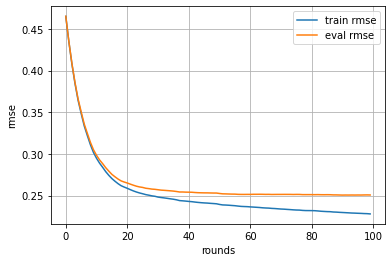

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407523	eval-rmse:0.408337
[3]	train-rmse:0.384296	eval-rmse:0.38542
[4]	train-rmse:0.364287	eval-rmse:0.365837
[5]	train-rmse:0.348435	eval-rmse:0.350485
[6]	train-rmse:0.333498	eval-rmse:0.335784
[7]	train-rmse:0.322071	eval-rmse:0.324745
[8]	train-rmse:0.311032	eval-rmse:0.31394
[9]	train-rmse:0.301719	eval-rmse:0.304982
[10]	train-rmse:0.294713	eval-rmse:0.29827
[11]	train-rmse:0.288783	eval-rmse:0.292703
[12]	train-rmse:0.283824	eval-rmse:0.288217
[13]	train-rmse:0.278619	eval-rmse:0.283381
[14]	train-rmse:0.274205	eval-rmse:0.279253
[15]	train-rmse:0.270357	eval-rmse:0.275402
[16]	train-rmse:0.267174	eval-rmse:0.272483
[17]	train-rmse:0.264258	eval-rmse:0.269789
[18]	train-rmse:0.261794	eval-rmse:0.267568
[19]	train-rmse:0.260164	eval-rmse:0.266222
[20]	train-rmse:0.258683	eval-rmse:0.265054
[21]	train-rmse:0.257064	eval-rmse:0.26367
[22]	train-rmse:0.255538	eval-rmse:0.262382
[23

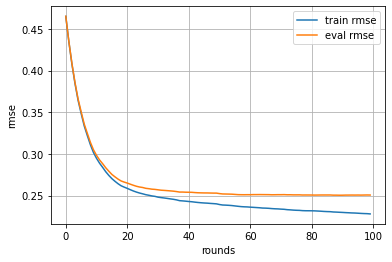

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407523	eval-rmse:0.408337
[3]	train-rmse:0.384296	eval-rmse:0.38542
[4]	train-rmse:0.364287	eval-rmse:0.365837
[5]	train-rmse:0.348435	eval-rmse:0.350485
[6]	train-rmse:0.333498	eval-rmse:0.335784
[7]	train-rmse:0.322071	eval-rmse:0.324745
[8]	train-rmse:0.311032	eval-rmse:0.31394
[9]	train-rmse:0.301719	eval-rmse:0.304982
[10]	train-rmse:0.294717	eval-rmse:0.298271
[11]	train-rmse:0.288796	eval-rmse:0.292716
[12]	train-rmse:0.283836	eval-rmse:0.288231
[13]	train-rmse:0.278631	eval-rmse:0.283394
[14]	train-rmse:0.274218	eval-rmse:0.279267
[15]	train-rmse:0.270369	eval-rmse:0.275414
[16]	train-rmse:0.267187	eval-rmse:0.272496
[17]	train-rmse:0.26427	eval-rmse:0.269801
[18]	train-rmse:0.261806	eval-rmse:0.267581
[19]	train-rmse:0.260177	eval-rmse:0.266236
[20]	train-rmse:0.258696	eval-rmse:0.265067
[21]	train-rmse:0.257077	eval-rmse:0.263683
[22]	train-rmse:0.255551	eval-rmse:0.262395
[2

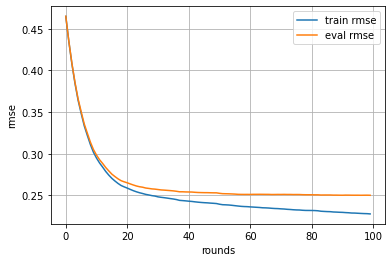

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407523	eval-rmse:0.408337
[3]	train-rmse:0.384296	eval-rmse:0.38542
[4]	train-rmse:0.364287	eval-rmse:0.365837
[5]	train-rmse:0.348435	eval-rmse:0.350485
[6]	train-rmse:0.3335	eval-rmse:0.335787
[7]	train-rmse:0.322079	eval-rmse:0.324759
[8]	train-rmse:0.311039	eval-rmse:0.313954
[9]	train-rmse:0.301726	eval-rmse:0.304995
[10]	train-rmse:0.294729	eval-rmse:0.298283
[11]	train-rmse:0.288809	eval-rmse:0.292729
[12]	train-rmse:0.283849	eval-rmse:0.288242
[13]	train-rmse:0.278647	eval-rmse:0.283421
[14]	train-rmse:0.274233	eval-rmse:0.279294
[15]	train-rmse:0.270384	eval-rmse:0.27544
[16]	train-rmse:0.267198	eval-rmse:0.272535
[17]	train-rmse:0.264258	eval-rmse:0.269826
[18]	train-rmse:0.261797	eval-rmse:0.267606
[19]	train-rmse:0.260166	eval-rmse:0.266258
[20]	train-rmse:0.258686	eval-rmse:0.26509
[21]	train-rmse:0.257068	eval-rmse:0.263706
[22]	train-rmse:0.255541	eval-rmse:0.262415
[23]

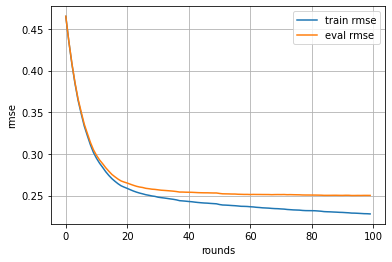

max_depth : (6, 0.25265613)
------------------------------
colsample_bytree : (0.8000000000000002, 0.25301266)
------------------------------
min_child_weight : (3.1, 0.25290403)
------------------------------
subsample : (0.8000000000000002, 0.25301266)
------------------------------
gamma : (0.050000010000000004, 0.25260225)
------------------------------


In [18]:
tune_param(dtrain, dvalid, dtest, target_variable, b_params)

[0]	train-rmse:0.46488	eval-rmse:0.465108
[1]	train-rmse:0.434365	eval-rmse:0.434852
[2]	train-rmse:0.407518	eval-rmse:0.408334
[3]	train-rmse:0.384291	eval-rmse:0.385418
[4]	train-rmse:0.364281	eval-rmse:0.365834
[5]	train-rmse:0.348429	eval-rmse:0.350482
[6]	train-rmse:0.333492	eval-rmse:0.335781
[7]	train-rmse:0.322065	eval-rmse:0.324742
[8]	train-rmse:0.311026	eval-rmse:0.313937
[9]	train-rmse:0.301709	eval-rmse:0.304977
[10]	train-rmse:0.294696	eval-rmse:0.298271
[11]	train-rmse:0.288763	eval-rmse:0.292702
[12]	train-rmse:0.283802	eval-rmse:0.288215
[13]	train-rmse:0.278594	eval-rmse:0.283377
[14]	train-rmse:0.274178	eval-rmse:0.279249
[15]	train-rmse:0.270322	eval-rmse:0.275396
[16]	train-rmse:0.267139	eval-rmse:0.272478
[17]	train-rmse:0.264225	eval-rmse:0.269731
[18]	train-rmse:0.261741	eval-rmse:0.267483
[19]	train-rmse:0.260096	eval-rmse:0.26614
[20]	train-rmse:0.258595	eval-rmse:0.264978
[21]	train-rmse:0.256972	eval-rmse:0.263585
[22]	train-rmse:0.255468	eval-rmse:0.262236


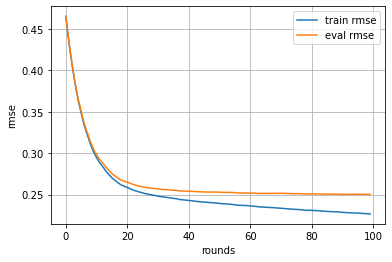

0.25260225

In [19]:
e_params = {
            'objective': 'reg:squarederror',
            'eta': 0.1,
            'gamma': 0.05,
            'alpha': 0.0,
            'lambda': 1.0,
            'eval_metric': 'rmse',
            'min_child_weight': 1,
            'max_depth': 5,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': 42
            }
e_model, evals_result = create_xg_model(dtrain, dvalid, target_variable, e_params, num_round=100)
model_learning_curve(e_model, dtest, evals_result)

## 2.Titanic

### Method

In [20]:
def texttype_transform(df, col_nm):
    df[col_nm + '_Left'] = df[col_nm].apply(lambda x: str(x)[0])
    df[col_nm + '_Len'] = df[col_nm].apply(lambda x: len(x))
    
    return df

In [21]:
def col_fillin_binary(df, col_nm):
    df[col_nm].fillna(0, inplace=True)
    df[col_nm] = df[col_nm].where(df[col_nm] == 0, 1)
    
    return df

In [22]:
def split_name(df):
    df_train_name1 = df['Name'].str.split(',', expand=True).rename(columns={0:'First', 1:'Other'})
    df_train_name2 = df_train_name1['Other'].str.split('.', expand=True).rename(columns=({0:'Title', 1:'Last', 2:'Other'}))
    df_train_names = pd.concat([df_train_name1, df_train_name2], axis=1)[['First', 'Title', 'Last']]

    df2 = pd.concat([df, df_train_names], axis=1)
    display(df2.head())
    
    return df2

In [23]:
def title_transform_category(df):
    d_title = {'Mr': '0', 'Miss': '1', 'Mrs': '2', 'Master': '3', 'Rare': '4'}
    title_category_list = []
    
    for row in df.itertuples():
        if row.Title.strip() in d_title:
            title_category_list.append(d_title[row.Title.strip()])
        else:
            title_category_list.append(d_title['Rare'])
            
    return title_category_list

In [24]:
def set_mean_age_by_title(df):
    title_list = []
    survived_par_list = []
    age_mean_list = []
    for titles in df['Title']:
        if titles not in title_list:
            title_list.append(titles)
            survived_par_list.append('{:.3%}'.format(df.where(df['Title'] == titles)['Survived'].sum() / df.where(df['Title'] == titles)['Survived'].count()))
            age = df.where(df['Title'] == titles)['Age'].mean()
            if age != age:
                age = df['Age'].mean()
            age_mean_list.append('{:.3f}'.format(age))
        else:
            pass

    df_title_sc = pd.merge(DataFrame(df['Title'].value_counts()).reset_index(), 
                           DataFrame(survived_par_list, title_list).reset_index(), on='index')
    df_title = pd.merge(df_title_sc, DataFrame(age_mean_list, title_list).reset_index(), on='index').rename(columns=({'index':'Title', 'Title':'count', '0_x':'survive', '0_y':'age_mean'}))

    display(df_title)
    
    df_m = pd.merge(df, df_title[['Title', 'age_mean']], on='Title')
    
    display(df_m)

    for indexes, values in enumerate(df_m['Age']):
        if values != values:
            df_m.iloc[indexes, 5] = df_m.iloc[indexes, 15]
        else:
            pass
        
    df_m['Title_C'] = DataFrame(title_transform_category(df_m))
    
    df_m.drop('Title', axis=1, inplace=True)
    df_m.drop('age_mean', axis=1, inplace=True)
    df_m.head()
    
    return df_m

In [25]:
def preprocess_for_titanic(df, is_embarked=True, is_fare=False):
    print("Fill in the missing values in 'Cabin'.")
    df = col_fillin_binary(df, 'Cabin')
    print("Split 'Name'.")
    df2 = split_name(df)
    print("Set mean age by title.")
    df3 = set_mean_age_by_title(df2)    
    if is_embarked:
        print("Set 'Embarked'.")
        df3[df3['Embarked'].isnull()]
        df3.fillna({'Embarked': 'S'}, inplace=True)
    if is_fare:
        print("Fill 'Fare'.")
        df3.fillna({'Fare': df3['Fare'].median()}, inplace=True)
    print("Set 'Ticket'.")
    Ticket_Count = dict(df3['Ticket'].value_counts())
    df3['TicketGroup'] = df3['Ticket'].map(Ticket_Count)
    sns.barplot(x='TicketGroup', y='Survived', data=df3, palette='Set3')
    plt.show()
        
    return df3

In [26]:
def drop_auto_target(df):
    df_at = pd.merge(DataFrame(df.count()).reset_index(), DataFrame(df.nunique()).reset_index(), on='index').rename(columns={'0_x': 'count', '0_y': 'unique'})
    df_at['divide'] = df_at['unique'] / df_at['count']
    
    display(df_at)
    
    for row in df_at.itertuples():
        if row.divide > 0.7:
            df.drop(row.index, axis=1, inplace=True)
            
    return df

### Overview

In [27]:
df_t_train = pd.read_csv(titanic_train_path)
df_t_test = pd.read_csv(titanic_test_path)
display_missing_value(df_t_train)
display_missing_value(df_t_test)

dType  Missing-Values
PassengerId    int64               0
Survived       int64               0
Pclass         int64               0
Name          object               0
Sex           object               0
Age          float64             177
SibSp          int64               0
Parch          int64               0
Ticket        object               0
Fare         float64               0
Cabin         object             687
Embarked      object               2

dType  Missing-Values
PassengerId    int64               0
Pclass         int64               0
Name          object               0
Sex           object               0
Age          float64              86
SibSp          int64               0
Parch          int64               0
Ticket        object               0
Fare         float64               1
Cabin         object             327
Embarked      object               0
Survived       int64               0

### Preprocess

---------- train_data --------------------
Fill in the missing values in 'Cabin'.
Split 'Name'.


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked      First  Title  \
0      0         A/5 21171   7.2500     0        S     Braund     Mr   
1      0          PC 17599  71.2833     1        C    Cumings    Mrs   
2      0  STON/O2. 3101282   7.9250     0        S  Heikkinen   Miss   
3      0            113803  53.1000     1        S   Futrelle    Mrs   
4      0            373450   8.0500     0        S      Allen     Mr   

                                     Last  
0                             Owen Harris  
1   John Bradley (Florence Briggs Thayer)  
2                                   Laina  
3           Jacques Heath (Lily May Peel)  
4                           William Henry

Set mean age by title.


Title  count   survive age_mean
0              Mr    517   15.667%   32.368
1            Miss    182   69.780%   21.774
2             Mrs    125   79.200%   35.898
3          Master     40   57.500%    4.574
4              Dr      7   42.857%   42.000
5             Rev      6    0.000%   43.167
6           Major      2   50.000%   48.500
7             Col      2   50.000%   58.000
8            Mlle      2  100.000%   24.000
9        Jonkheer      1    0.000%   38.000
10   the Countess      1  100.000%   33.000
11            Don      1    0.000%   40.000
12            Mme      1  100.000%   24.000
13             Ms      1  100.000%   28.000
14           Lady      1  100.000%   48.000
15            Sir      1  100.000%   49.000
16           Capt      1    0.000%   70.000

PassengerId  Survived  Pclass  \
0              1         0       3   
1              5         0       3   
2              6         0       3   
3              7         0       1   
4             13         0       3   
..           ...       ...     ...   
886          648         1       1   
887          695         0       1   
888          746         0       1   
889          760         1       1   
890          823         0       1   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1                             Allen, Mr. William Henry    male  35.0      0   
2                                     Moran, Mr. James    male   NaN      0   
3                              McCarthy, Mr. Timothy J    male  54.0      0   
4                       Saundercock, Mr. William Henry    male  20.0      0   
..                                                 ...     ...   ...    ...   
886                Simonius-Blumer, Col. Oberst Alfons    male  56.0      0   
887                                    Weir, Col. John    male  60.0      0   
888                       Crosby, Capt. Edward Gifford    male  70.0      1   
889  Rothes, the Countess. of (Lucy Noel Martha Dye...  female  33.0      0   
890                    Reuchlin, Jonkheer. John George    male  38.0      0   

     Parch     Ticket     Fare Cabin Embarked            First          Title  \
0        0  A/5 21171   7.2500     0        S           Braund             Mr   
1        0     373450   8.0500     0        S            Allen             Mr   
2        0     330877   8.4583     0        Q            Moran             Mr   
3        0      17463  51.8625     1        S         McCarthy             Mr   
4        0  A/5. 2151   8.0500     0        S      Saundercock             Mr   
..     ...        ...      ...   ...      ...              ...            ...   
886      0      13213  35.5000     1        C  Simonius-Blumer            Col   
887      0     113800  26.5500     0        S             Weir            Col   
888      1  WE/P 5735  71.0000     1        S           Crosby           Capt   
889      0     110152  86.5000     1        S           Rothes   the Countess   
890      0      19972   0.0000     0        S         Reuchlin       Jonkheer   

                                    Last age_mean  
0                            Owen Harris   32.368  
1                          William Henry   32.368  
2                                  James   32.368  
3                              Timothy J   32.368  
4                          William Henry   32.368  
..                                   ...      ...  
886                        Oberst Alfons   58.000  
887                                 John   58.000  
888                       Edward Gifford   70.000  
889   of (Lucy Noel Martha Dyer-Edwards)   33.000  
890                          John George   38.000  

[891 rows x 16 columns]

Set 'Embarked'.
Set 'Ticket'.


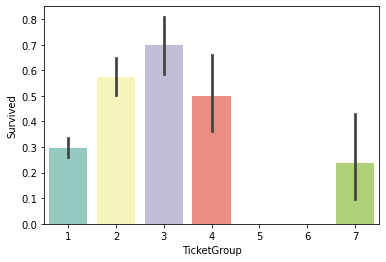

---------- test_data --------------------
Fill in the missing values in 'Cabin'.
Split 'Name'.


PassengerId  Survived  Pclass  \
0          892         0       3   
1          893         1       3   
2          894         0       2   
3          895         0       3   
4          896         1       3   

                                           Name     Sex   Age  SibSp  Parch  \
0                              Kelly, Mr. James    male  34.5      0      0   
1              Wilkes, Mrs. James (Ellen Needs)  female  47.0      1      0   
2                     Myles, Mr. Thomas Francis    male  62.0      0      0   
3                              Wirz, Mr. Albert    male  27.0      0      0   
4  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female  22.0      1      1   

    Ticket     Fare Cabin Embarked     First Title  \
0   330911   7.8292     0        Q     Kelly    Mr   
1   363272   7.0000     0        S    Wilkes   Mrs   
2   240276   9.6875     0        Q     Myles    Mr   
3   315154   8.6625     0        S      Wirz    Mr   
4  3101298  12.2875     0        S  Hirvonen   Mrs   

                             Last  
0                           James  
1             James (Ellen Needs)  
2                  Thomas Francis  
3                          Albert  
4   Alexander (Helga E Lindqvist)

Set mean age by title.


Title  count   survive age_mean
0       Mr    240   17.500%   32.000
1     Miss     78   62.821%   21.775
2      Mrs     72   77.778%   38.903
3   Master     21   38.095%    7.406
4      Rev      2    0.000%   35.500
5      Col      2   50.000%   50.000
6       Dr      1  100.000%   53.000
7       Ms      1    0.000%   30.273
8     Dona      1  100.000%   39.000

PassengerId  Survived  Pclass                           Name     Sex  \
0            892         0       3               Kelly, Mr. James    male   
1            894         0       2      Myles, Mr. Thomas Francis    male   
2            895         0       3               Wirz, Mr. Albert    male   
3            897         1       3     Svensson, Mr. Johan Cervin    male   
4            899         1       2   Caldwell, Mr. Albert Francis    male   
..           ...       ...     ...                            ...     ...   
413         1094         0       1         Astor, Col. John Jacob    male   
414         1041         0       2         Lahtinen, Rev. William    male   
415         1056         0       2  Peruschitz, Rev. Joseph Maria    male   
416         1185         1       1          Dodge, Dr. Washington    male   
417         1306         1       1   Oliva y Ocana, Dona. Fermina  female   

      Age  SibSp  Parch    Ticket      Fare Cabin Embarked          First  \
0    34.5      0      0    330911    7.8292     0        Q          Kelly   
1    62.0      0      0    240276    9.6875     0        Q          Myles   
2    27.0      0      0    315154    8.6625     0        S           Wirz   
3    14.0      0      0      7538    9.2250     0        S       Svensson   
4    26.0      1      1    248738   29.0000     0        S       Caldwell   
..    ...    ...    ...       ...       ...   ...      ...            ...   
413  47.0      1      0  PC 17757  227.5250     1        C          Astor   
414  30.0      1      1    250651   26.0000     0        S       Lahtinen   
415  41.0      0      0    237393   13.0000     0        S     Peruschitz   
416  53.0      1      1     33638   81.8583     1        S          Dodge   
417  39.0      0      0  PC 17758  108.9000     1        C  Oliva y Ocana   

     Title             Last age_mean  
0       Mr            James   32.000  
1       Mr   Thomas Francis   32.000  
2       Mr           Albert   32.000  
3       Mr     Johan Cervin   32.000  
4       Mr   Albert Francis   32.000  
..     ...              ...      ...  
413    Col       John Jacob   50.000  
414    Rev          William   35.500  
415    Rev     Joseph Maria   35.500  
416     Dr       Washington   53.000  
417   Dona          Fermina   39.000  

[418 rows x 16 columns]

Fill 'Fare'.
Set 'Ticket'.


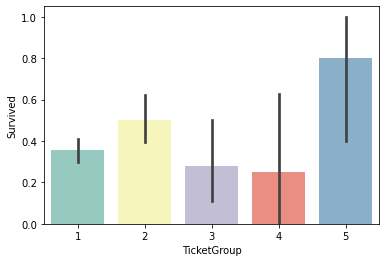

In [28]:
print("-" * 10, "train_data", "-" * 20)
df_t_train2 = preprocess_for_titanic(df_t_train, is_embarked=True, is_fare=False)
print("-" * 10, "test_data", "-" * 20)
df_t_test2 = preprocess_for_titanic(df_t_test[df_t_train.columns], is_embarked=False, is_fare=True)

In [29]:
display_missing_value(df_t_train2)
display_missing_value(df_t_test2)

dType  Missing-Values
PassengerId    int64               0
Survived       int64               0
Pclass         int64               0
Name          object               0
Sex           object               0
Age           object               0
SibSp          int64               0
Parch          int64               0
Ticket        object               0
Fare         float64               0
Cabin         object               0
Embarked      object               0
First         object               0
Last          object               0
Title_C       object               0
TicketGroup    int64               0

dType  Missing-Values
PassengerId    int64               0
Survived       int64               0
Pclass         int64               0
Name          object               0
Sex           object               0
Age           object               0
SibSp          int64               0
Parch          int64               0
Ticket        object               0
Fare         float64               0
Cabin         object               0
Embarked      object               0
First         object               0
Last          object               0
Title_C       object               0
TicketGroup    int64               0

In [30]:
df_t_train3 = df_t_train2.astype({'Age': 'float64'})
df_t_test3 = df_t_test2.astype({'Age': 'float64'})

In [31]:
df_t_train3 = transform_category(drop_auto_target(df_t_train3))
df_t_test3 = transform_category(drop_auto_target(df_t_test3))

index  count  unique    divide
0   PassengerId    891     891  1.000000
1      Survived    891       2  0.002245
2        Pclass    891       3  0.003367
3          Name    891     891  1.000000
4           Sex    891       2  0.002245
5           Age    891      92  0.103255
6         SibSp    891       7  0.007856
7         Parch    891       7  0.007856
8        Ticket    891     681  0.764310
9          Fare    891     248  0.278339
10        Cabin    891       2  0.002245
11     Embarked    891       3  0.003367
12        First    891     667  0.748597
13         Last    891     799  0.896745
14      Title_C    891       5  0.005612
15  TicketGroup    891       7  0.007856

Survived  Pclass     Age  SibSp  Parch     Fare  TicketGroup  Sex_female  \
0           0       3  22.000      1      0   7.2500            1           0   
1           0       3  35.000      0      0   8.0500            1           0   
2           0       3  32.368      0      0   8.4583            1           0   
3           0       1  54.000      0      0  51.8625            1           0   
4           0       3  20.000      0      0   8.0500            1           0   
..        ...     ...     ...    ...    ...      ...          ...         ...   
886         1       1  56.000      0      0  35.5000            1           0   
887         0       1  60.000      0      0  26.5500            1           0   
888         0       1  70.000      1      1  71.0000            2           0   
889         1       1  33.000      0      0  86.5000            3           1   
890         0       1  38.000      0      0   0.0000            1           0   

     Sex_male  Cabin_0  Cabin_1  Embarked_C  Embarked_Q  Embarked_S  \
0           1        1        0           0           0           1   
1           1        1        0           0           0           1   
2           1        1        0           0           1           0   
3           1        0        1           0           0           1   
4           1        1        0           0           0           1   
..        ...      ...      ...         ...         ...         ...   
886         1        0        1           1           0           0   
887         1        1        0           0           0           1   
888         1        0        1           0           0           1   
889         0        0        1           0           0           1   
890         1        1        0           0           0           1   

     Title_C_0  Title_C_1  Title_C_2  Title_C_3  Title_C_4  
0            1          0          0          0          0  
1            1          0          0          0          0  
2            1          0          0          0          0  
3            1          0          0          0          0  
4            1          0          0          0          0  
..         ...        ...        ...        ...        ...  
886          0          0          0          0          1  
887          0          0          0          0          1  
888          0          0          0          0          1  
889          0          0          0          0          1  
890          0          0          0          0          1  

[891 rows x 19 columns]

index  count  unique    divide
0   PassengerId    418     418  1.000000
1      Survived    418       2  0.004785
2        Pclass    418       3  0.007177
3          Name    418     418  1.000000
4           Sex    418       2  0.004785
5           Age    418      83  0.198565
6         SibSp    418       7  0.016746
7         Parch    418       8  0.019139
8        Ticket    418     363  0.868421
9          Fare    418     169  0.404306
10        Cabin    418       2  0.004785
11     Embarked    418       3  0.007177
12        First    418     352  0.842105
13         Last    418     377  0.901914
14      Title_C    418       5  0.011962
15  TicketGroup    418       5  0.011962

Survived  Pclass   Age  SibSp  Parch      Fare  TicketGroup  Sex_female  \
0           0       3  34.5      0      0    7.8292            1           0   
1           0       2  62.0      0      0    9.6875            1           0   
2           0       3  27.0      0      0    8.6625            1           0   
3           1       3  14.0      0      0    9.2250            1           0   
4           1       2  26.0      1      1   29.0000            1           0   
..        ...     ...   ...    ...    ...       ...          ...         ...   
413         0       1  47.0      1      0  227.5250            1           0   
414         0       2  30.0      1      1   26.0000            1           0   
415         0       2  41.0      0      0   13.0000            1           0   
416         1       1  53.0      1      1   81.8583            2           0   
417         1       1  39.0      0      0  108.9000            1           1   

     Sex_male  Cabin_0  Cabin_1  Embarked_C  Embarked_Q  Embarked_S  \
0           1        1        0           0           1           0   
1           1        1        0           0           1           0   
2           1        1        0           0           0           1   
3           1        1        0           0           0           1   
4           1        1        0           0           0           1   
..        ...      ...      ...         ...         ...         ...   
413         1        0        1           1           0           0   
414         1        1        0           0           0           1   
415         1        1        0           0           0           1   
416         1        0        1           0           0           1   
417         0        0        1           1           0           0   

     Title_C_0  Title_C_1  Title_C_2  Title_C_3  Title_C_4  
0            1          0          0          0          0  
1            1          0          0          0          0  
2            1          0          0          0          0  
3            1          0          0          0          0  
4            1          0          0          0          0  
..         ...        ...        ...        ...        ...  
413          0          0          0          0          1  
414          0          0          0          0          1  
415          0          0          0          0          1  
416          0          0          0          0          1  
417          0          0          0          0          1  

[418 rows x 19 columns]

### create model

[0]	train-rmse:0.475477	eval-rmse:0.474763
[1]	train-rmse:0.450508	eval-rmse:0.451119
[2]	train-rmse:0.429042	eval-rmse:0.431306
[3]	train-rmse:0.412292	eval-rmse:0.414193
[4]	train-rmse:0.395667	eval-rmse:0.400241
[5]	train-rmse:0.381048	eval-rmse:0.386957
[6]	train-rmse:0.369021	eval-rmse:0.376837
[7]	train-rmse:0.35723	eval-rmse:0.367238
[8]	train-rmse:0.349382	eval-rmse:0.360852
[9]	train-rmse:0.341197	eval-rmse:0.354412
[10]	train-rmse:0.334703	eval-rmse:0.347618
[11]	train-rmse:0.328312	eval-rmse:0.343106
[12]	train-rmse:0.322506	eval-rmse:0.339771
[13]	train-rmse:0.318011	eval-rmse:0.337781
[14]	train-rmse:0.313171	eval-rmse:0.333837
[15]	train-rmse:0.310331	eval-rmse:0.331217
[16]	train-rmse:0.307784	eval-rmse:0.329129
[17]	train-rmse:0.30476	eval-rmse:0.327302
[18]	train-rmse:0.301603	eval-rmse:0.326251
[19]	train-rmse:0.297784	eval-rmse:0.32455
[20]	train-rmse:0.29595	eval-rmse:0.323293
[21]	train-rmse:0.292857	eval-rmse:0.32216
[22]	train-rmse:0.289697	eval-rmse:0.322653
[23

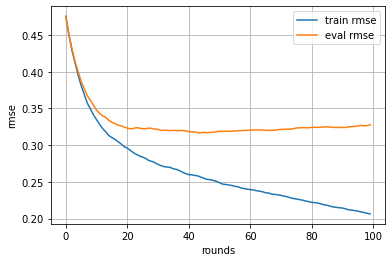

0.42662764

In [32]:
# ハイパーパラメータの設定
b_params = {
            'objective': 'reg:squarederror',
            'eta': 0.1,
            'gamma': 0.0,
            'alpha': 0.0,
            'lambda': 1.0,
            'eval_metric': 'rmse',
            'min_child_weight': 1,
            'max_depth': 5,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': 42
            }
target_variable = 'Survived'
dtrain, dvalid = train_valid_split_and_transform_dmatrix(df_t_train3, test_size=0.2, shuffle=True, random_state=42)
dtest = transform_dmatrix(df_t_test3, target_variable)
base_model, evals_result = create_xg_model(dtrain, dvalid, target_variable, b_params, num_round=100)
model_learning_curve(base_model, dtest, evals_result)

Tuning max_depth ...
[0]	train-rmse:0.478802	eval-rmse:0.476268
[1]	train-rmse:0.458056	eval-rmse:0.454478
[2]	train-rmse:0.441006	eval-rmse:0.436435
[3]	train-rmse:0.427449	eval-rmse:0.421662
[4]	train-rmse:0.413413	eval-rmse:0.407094
[5]	train-rmse:0.401078	eval-rmse:0.394188
[6]	train-rmse:0.391655	eval-rmse:0.384336
[7]	train-rmse:0.383687	eval-rmse:0.376829
[8]	train-rmse:0.376807	eval-rmse:0.368901
[9]	train-rmse:0.370568	eval-rmse:0.362502
[10]	train-rmse:0.365739	eval-rmse:0.357853
[11]	train-rmse:0.361035	eval-rmse:0.352984
[12]	train-rmse:0.357205	eval-rmse:0.349628
[13]	train-rmse:0.354193	eval-rmse:0.346995
[14]	train-rmse:0.351767	eval-rmse:0.343554
[15]	train-rmse:0.349593	eval-rmse:0.340903
[16]	train-rmse:0.347425	eval-rmse:0.338932
[17]	train-rmse:0.345327	eval-rmse:0.336947
[18]	train-rmse:0.343743	eval-rmse:0.335562
[19]	train-rmse:0.342009	eval-rmse:0.334261
[20]	train-rmse:0.340403	eval-rmse:0.333114
[21]	train-rmse:0.339049	eval-rmse:0.333024
[22]	train-rmse:0.337

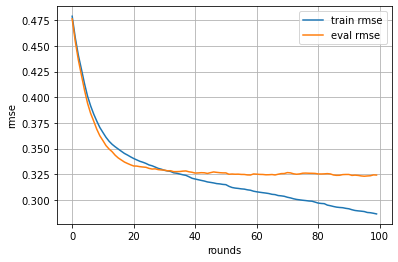

[0]	train-rmse:0.47794	eval-rmse:0.476149
[1]	train-rmse:0.454429	eval-rmse:0.452323
[2]	train-rmse:0.434725	eval-rmse:0.432168
[3]	train-rmse:0.419671	eval-rmse:0.415821
[4]	train-rmse:0.404453	eval-rmse:0.401229
[5]	train-rmse:0.391921	eval-rmse:0.387922
[6]	train-rmse:0.381282	eval-rmse:0.377438
[7]	train-rmse:0.371755	eval-rmse:0.368643
[8]	train-rmse:0.364353	eval-rmse:0.361698
[9]	train-rmse:0.357035	eval-rmse:0.354213
[10]	train-rmse:0.351452	eval-rmse:0.349438
[11]	train-rmse:0.346251	eval-rmse:0.345444
[12]	train-rmse:0.341366	eval-rmse:0.341908
[13]	train-rmse:0.337738	eval-rmse:0.338785
[14]	train-rmse:0.334446	eval-rmse:0.335501
[15]	train-rmse:0.331943	eval-rmse:0.332878
[16]	train-rmse:0.329673	eval-rmse:0.330615
[17]	train-rmse:0.326685	eval-rmse:0.329904
[18]	train-rmse:0.324203	eval-rmse:0.328362
[19]	train-rmse:0.322235	eval-rmse:0.32734
[20]	train-rmse:0.320039	eval-rmse:0.326917
[21]	train-rmse:0.317763	eval-rmse:0.326771
[22]	train-rmse:0.316036	eval-rmse:0.325989


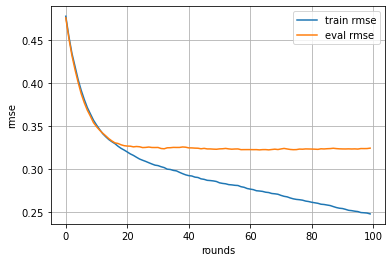

[0]	train-rmse:0.475477	eval-rmse:0.474763
[1]	train-rmse:0.450508	eval-rmse:0.451119
[2]	train-rmse:0.429042	eval-rmse:0.431306
[3]	train-rmse:0.412292	eval-rmse:0.414193
[4]	train-rmse:0.395667	eval-rmse:0.400241
[5]	train-rmse:0.381048	eval-rmse:0.386957
[6]	train-rmse:0.369021	eval-rmse:0.376837
[7]	train-rmse:0.35723	eval-rmse:0.367238
[8]	train-rmse:0.349382	eval-rmse:0.360852
[9]	train-rmse:0.341197	eval-rmse:0.354412
[10]	train-rmse:0.334703	eval-rmse:0.347618
[11]	train-rmse:0.328312	eval-rmse:0.343106
[12]	train-rmse:0.322506	eval-rmse:0.339771
[13]	train-rmse:0.318011	eval-rmse:0.337781
[14]	train-rmse:0.313171	eval-rmse:0.333837
[15]	train-rmse:0.310331	eval-rmse:0.331217
[16]	train-rmse:0.307784	eval-rmse:0.329129
[17]	train-rmse:0.30476	eval-rmse:0.327302
[18]	train-rmse:0.301603	eval-rmse:0.326251
[19]	train-rmse:0.297784	eval-rmse:0.32455
[20]	train-rmse:0.29595	eval-rmse:0.323293
[21]	train-rmse:0.292857	eval-rmse:0.32216
[22]	train-rmse:0.289697	eval-rmse:0.322653
[23

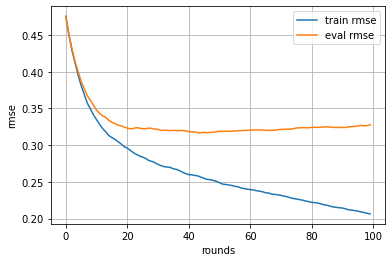

[0]	train-rmse:0.473214	eval-rmse:0.474035
[1]	train-rmse:0.446862	eval-rmse:0.44977
[2]	train-rmse:0.423834	eval-rmse:0.430196
[3]	train-rmse:0.406365	eval-rmse:0.41368
[4]	train-rmse:0.387296	eval-rmse:0.400367
[5]	train-rmse:0.371522	eval-rmse:0.38752
[6]	train-rmse:0.356732	eval-rmse:0.37582
[7]	train-rmse:0.344117	eval-rmse:0.366454
[8]	train-rmse:0.335152	eval-rmse:0.359072
[9]	train-rmse:0.325599	eval-rmse:0.352187
[10]	train-rmse:0.317401	eval-rmse:0.345359
[11]	train-rmse:0.309504	eval-rmse:0.341253
[12]	train-rmse:0.302995	eval-rmse:0.339267
[13]	train-rmse:0.298431	eval-rmse:0.337403
[14]	train-rmse:0.292143	eval-rmse:0.334306
[15]	train-rmse:0.28921	eval-rmse:0.331699
[16]	train-rmse:0.28636	eval-rmse:0.329875
[17]	train-rmse:0.282455	eval-rmse:0.329335
[18]	train-rmse:0.278061	eval-rmse:0.326873
[19]	train-rmse:0.273525	eval-rmse:0.326529
[20]	train-rmse:0.269696	eval-rmse:0.327439
[21]	train-rmse:0.266495	eval-rmse:0.327854
[22]	train-rmse:0.263408	eval-rmse:0.327783
[23]

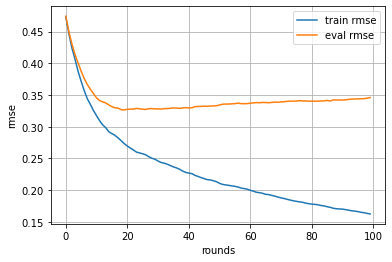

[0]	train-rmse:0.471965	eval-rmse:0.474373
[1]	train-rmse:0.444215	eval-rmse:0.449678
[2]	train-rmse:0.419027	eval-rmse:0.430175
[3]	train-rmse:0.400711	eval-rmse:0.413725
[4]	train-rmse:0.379686	eval-rmse:0.399822
[5]	train-rmse:0.362792	eval-rmse:0.387491
[6]	train-rmse:0.34667	eval-rmse:0.379048
[7]	train-rmse:0.332818	eval-rmse:0.370514
[8]	train-rmse:0.322844	eval-rmse:0.363288
[9]	train-rmse:0.312447	eval-rmse:0.356215
[10]	train-rmse:0.303067	eval-rmse:0.350289
[11]	train-rmse:0.294185	eval-rmse:0.346375
[12]	train-rmse:0.287131	eval-rmse:0.343672
[13]	train-rmse:0.28138	eval-rmse:0.340602
[14]	train-rmse:0.274546	eval-rmse:0.337523
[15]	train-rmse:0.271178	eval-rmse:0.335398
[16]	train-rmse:0.268121	eval-rmse:0.333358
[17]	train-rmse:0.263314	eval-rmse:0.333371
[18]	train-rmse:0.258248	eval-rmse:0.330834
[19]	train-rmse:0.252532	eval-rmse:0.330395
[20]	train-rmse:0.248786	eval-rmse:0.331728
[21]	train-rmse:0.245327	eval-rmse:0.330099
[22]	train-rmse:0.242242	eval-rmse:0.330159


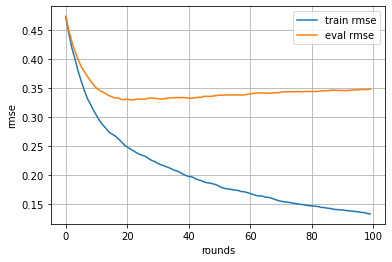

[0]	train-rmse:0.470721	eval-rmse:0.474337
[1]	train-rmse:0.442356	eval-rmse:0.449925
[2]	train-rmse:0.415864	eval-rmse:0.430454
[3]	train-rmse:0.396316	eval-rmse:0.413826
[4]	train-rmse:0.374022	eval-rmse:0.399914
[5]	train-rmse:0.355992	eval-rmse:0.388561
[6]	train-rmse:0.338752	eval-rmse:0.379129
[7]	train-rmse:0.324323	eval-rmse:0.37007
[8]	train-rmse:0.313915	eval-rmse:0.363542
[9]	train-rmse:0.302629	eval-rmse:0.356276
[10]	train-rmse:0.291729	eval-rmse:0.350802
[11]	train-rmse:0.280956	eval-rmse:0.347784
[12]	train-rmse:0.273417	eval-rmse:0.34513
[13]	train-rmse:0.266743	eval-rmse:0.342822
[14]	train-rmse:0.257857	eval-rmse:0.339033
[15]	train-rmse:0.253995	eval-rmse:0.336711
[16]	train-rmse:0.25028	eval-rmse:0.335047
[17]	train-rmse:0.244707	eval-rmse:0.334617
[18]	train-rmse:0.239619	eval-rmse:0.332518
[19]	train-rmse:0.233375	eval-rmse:0.330879
[20]	train-rmse:0.229558	eval-rmse:0.331475
[21]	train-rmse:0.225049	eval-rmse:0.331635
[22]	train-rmse:0.221444	eval-rmse:0.332356
[

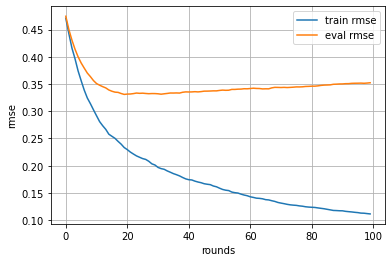

[0]	train-rmse:0.46903	eval-rmse:0.473673
[1]	train-rmse:0.438947	eval-rmse:0.449008
[2]	train-rmse:0.411169	eval-rmse:0.428895
[3]	train-rmse:0.390675	eval-rmse:0.413718
[4]	train-rmse:0.366826	eval-rmse:0.400852
[5]	train-rmse:0.346952	eval-rmse:0.389567
[6]	train-rmse:0.328693	eval-rmse:0.380276
[7]	train-rmse:0.313506	eval-rmse:0.371167
[8]	train-rmse:0.302602	eval-rmse:0.363412
[9]	train-rmse:0.290237	eval-rmse:0.356359
[10]	train-rmse:0.278051	eval-rmse:0.350936
[11]	train-rmse:0.26685	eval-rmse:0.348196
[12]	train-rmse:0.25875	eval-rmse:0.345843
[13]	train-rmse:0.251624	eval-rmse:0.343827
[14]	train-rmse:0.241744	eval-rmse:0.341761
[15]	train-rmse:0.237711	eval-rmse:0.339556
[16]	train-rmse:0.233643	eval-rmse:0.337667
[17]	train-rmse:0.22659	eval-rmse:0.339141
[18]	train-rmse:0.221203	eval-rmse:0.336791
[19]	train-rmse:0.214758	eval-rmse:0.336457
[20]	train-rmse:0.210312	eval-rmse:0.336182
[21]	train-rmse:0.206137	eval-rmse:0.335149
[22]	train-rmse:0.20248	eval-rmse:0.335922
[23

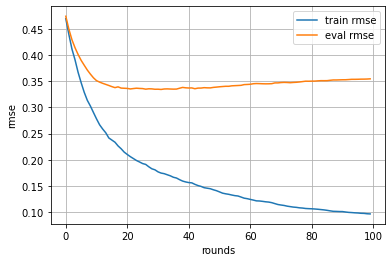

Tuning colsample_bytree ...
[0]	train-rmse:0.474222	eval-rmse:0.473722
[1]	train-rmse:0.449332	eval-rmse:0.44984
[2]	train-rmse:0.428058	eval-rmse:0.43018
[3]	train-rmse:0.411992	eval-rmse:0.413195
[4]	train-rmse:0.396551	eval-rmse:0.397469
[5]	train-rmse:0.382859	eval-rmse:0.384541
[6]	train-rmse:0.371099	eval-rmse:0.373735
[7]	train-rmse:0.361841	eval-rmse:0.364435
[8]	train-rmse:0.354045	eval-rmse:0.358347
[9]	train-rmse:0.346255	eval-rmse:0.351902
[10]	train-rmse:0.339751	eval-rmse:0.346176
[11]	train-rmse:0.334467	eval-rmse:0.3421
[12]	train-rmse:0.328881	eval-rmse:0.338572
[13]	train-rmse:0.325037	eval-rmse:0.337399
[14]	train-rmse:0.32028	eval-rmse:0.333551
[15]	train-rmse:0.31774	eval-rmse:0.331638
[16]	train-rmse:0.315181	eval-rmse:0.32952
[17]	train-rmse:0.311663	eval-rmse:0.328254
[18]	train-rmse:0.308142	eval-rmse:0.327325
[19]	train-rmse:0.305552	eval-rmse:0.326867
[20]	train-rmse:0.302414	eval-rmse:0.325792
[21]	train-rmse:0.301287	eval-rmse:0.325031
[22]	train-rmse:0.299

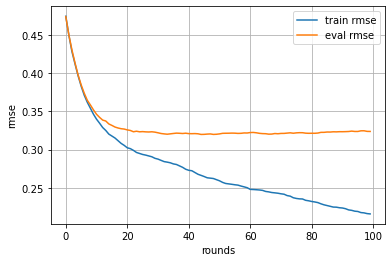

[0]	train-rmse:0.474124	eval-rmse:0.473761
[1]	train-rmse:0.449241	eval-rmse:0.449919
[2]	train-rmse:0.427997	eval-rmse:0.43031
[3]	train-rmse:0.412431	eval-rmse:0.413753
[4]	train-rmse:0.396774	eval-rmse:0.397948
[5]	train-rmse:0.383037	eval-rmse:0.384932
[6]	train-rmse:0.371345	eval-rmse:0.374291
[7]	train-rmse:0.361766	eval-rmse:0.365627
[8]	train-rmse:0.353488	eval-rmse:0.357436
[9]	train-rmse:0.345361	eval-rmse:0.351444
[10]	train-rmse:0.338798	eval-rmse:0.345636
[11]	train-rmse:0.333359	eval-rmse:0.341475
[12]	train-rmse:0.32762	eval-rmse:0.33779
[13]	train-rmse:0.323523	eval-rmse:0.336512
[14]	train-rmse:0.317948	eval-rmse:0.332574
[15]	train-rmse:0.315418	eval-rmse:0.330622
[16]	train-rmse:0.312863	eval-rmse:0.328614
[17]	train-rmse:0.309441	eval-rmse:0.32738
[18]	train-rmse:0.306242	eval-rmse:0.326009
[19]	train-rmse:0.303029	eval-rmse:0.324833
[20]	train-rmse:0.299821	eval-rmse:0.323499
[21]	train-rmse:0.298466	eval-rmse:0.324038
[22]	train-rmse:0.295695	eval-rmse:0.324271
[2

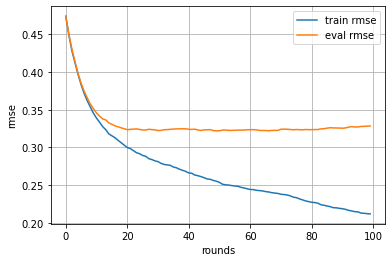

[0]	train-rmse:0.474124	eval-rmse:0.473761
[1]	train-rmse:0.449338	eval-rmse:0.450228
[2]	train-rmse:0.428076	eval-rmse:0.430586
[3]	train-rmse:0.411989	eval-rmse:0.413563
[4]	train-rmse:0.396438	eval-rmse:0.397683
[5]	train-rmse:0.382706	eval-rmse:0.384903
[6]	train-rmse:0.370888	eval-rmse:0.374065
[7]	train-rmse:0.361387	eval-rmse:0.365608
[8]	train-rmse:0.353266	eval-rmse:0.359467
[9]	train-rmse:0.345054	eval-rmse:0.35334
[10]	train-rmse:0.338444	eval-rmse:0.348624
[11]	train-rmse:0.332754	eval-rmse:0.345153
[12]	train-rmse:0.327214	eval-rmse:0.341762
[13]	train-rmse:0.323173	eval-rmse:0.339494
[14]	train-rmse:0.317436	eval-rmse:0.335319
[15]	train-rmse:0.315014	eval-rmse:0.333473
[16]	train-rmse:0.312463	eval-rmse:0.331433
[17]	train-rmse:0.309133	eval-rmse:0.329667
[18]	train-rmse:0.30597	eval-rmse:0.328184
[19]	train-rmse:0.302752	eval-rmse:0.326527
[20]	train-rmse:0.299329	eval-rmse:0.325695
[21]	train-rmse:0.297452	eval-rmse:0.324884
[22]	train-rmse:0.295279	eval-rmse:0.32424
[

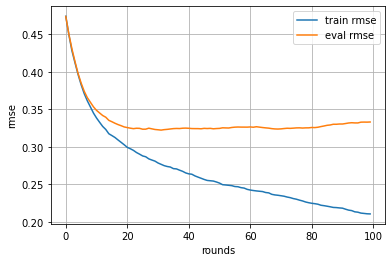

[0]	train-rmse:0.475477	eval-rmse:0.474763
[1]	train-rmse:0.450512	eval-rmse:0.451206
[2]	train-rmse:0.428639	eval-rmse:0.431913
[3]	train-rmse:0.412113	eval-rmse:0.414509
[4]	train-rmse:0.396338	eval-rmse:0.400866
[5]	train-rmse:0.382171	eval-rmse:0.387874
[6]	train-rmse:0.369359	eval-rmse:0.376155
[7]	train-rmse:0.358236	eval-rmse:0.367486
[8]	train-rmse:0.349813	eval-rmse:0.360211
[9]	train-rmse:0.341565	eval-rmse:0.353362
[10]	train-rmse:0.33499	eval-rmse:0.348328
[11]	train-rmse:0.328696	eval-rmse:0.344225
[12]	train-rmse:0.323097	eval-rmse:0.340758
[13]	train-rmse:0.318645	eval-rmse:0.338908
[14]	train-rmse:0.313929	eval-rmse:0.335094
[15]	train-rmse:0.311442	eval-rmse:0.332909
[16]	train-rmse:0.30898	eval-rmse:0.330856
[17]	train-rmse:0.305377	eval-rmse:0.330877
[18]	train-rmse:0.302148	eval-rmse:0.329862
[19]	train-rmse:0.298474	eval-rmse:0.328091
[20]	train-rmse:0.296771	eval-rmse:0.326879
[21]	train-rmse:0.294888	eval-rmse:0.326531
[22]	train-rmse:0.291793	eval-rmse:0.326425


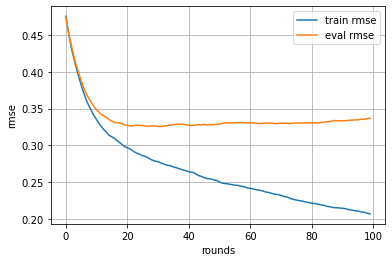

[0]	train-rmse:0.475477	eval-rmse:0.474763
[1]	train-rmse:0.450508	eval-rmse:0.451119
[2]	train-rmse:0.429042	eval-rmse:0.431306
[3]	train-rmse:0.412292	eval-rmse:0.414193
[4]	train-rmse:0.395667	eval-rmse:0.400241
[5]	train-rmse:0.381048	eval-rmse:0.386957
[6]	train-rmse:0.369021	eval-rmse:0.376837
[7]	train-rmse:0.35723	eval-rmse:0.367238
[8]	train-rmse:0.349382	eval-rmse:0.360852
[9]	train-rmse:0.341197	eval-rmse:0.354412
[10]	train-rmse:0.334703	eval-rmse:0.347618
[11]	train-rmse:0.328312	eval-rmse:0.343106
[12]	train-rmse:0.322506	eval-rmse:0.339771
[13]	train-rmse:0.318011	eval-rmse:0.337781
[14]	train-rmse:0.313171	eval-rmse:0.333837
[15]	train-rmse:0.310331	eval-rmse:0.331217
[16]	train-rmse:0.307784	eval-rmse:0.329129
[17]	train-rmse:0.30476	eval-rmse:0.327302
[18]	train-rmse:0.301603	eval-rmse:0.326251
[19]	train-rmse:0.297784	eval-rmse:0.32455
[20]	train-rmse:0.29595	eval-rmse:0.323293
[21]	train-rmse:0.292857	eval-rmse:0.32216
[22]	train-rmse:0.289697	eval-rmse:0.322653
[23

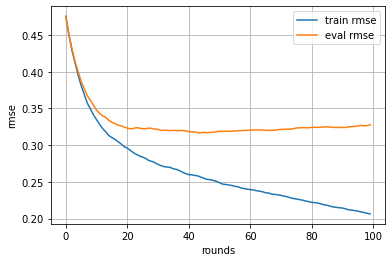

[0]	train-rmse:0.473731	eval-rmse:0.47412
[1]	train-rmse:0.449108	eval-rmse:0.45084
[2]	train-rmse:0.428171	eval-rmse:0.431503
[3]	train-rmse:0.411142	eval-rmse:0.414568
[4]	train-rmse:0.394709	eval-rmse:0.400744
[5]	train-rmse:0.380867	eval-rmse:0.388113
[6]	train-rmse:0.368183	eval-rmse:0.379356
[7]	train-rmse:0.357454	eval-rmse:0.369518
[8]	train-rmse:0.3497	eval-rmse:0.363868
[9]	train-rmse:0.341374	eval-rmse:0.357224
[10]	train-rmse:0.334328	eval-rmse:0.352812
[11]	train-rmse:0.328602	eval-rmse:0.349175
[12]	train-rmse:0.322867	eval-rmse:0.346455
[13]	train-rmse:0.317434	eval-rmse:0.34338
[14]	train-rmse:0.312663	eval-rmse:0.339328
[15]	train-rmse:0.309601	eval-rmse:0.3374
[16]	train-rmse:0.307063	eval-rmse:0.335365
[17]	train-rmse:0.304233	eval-rmse:0.333995
[18]	train-rmse:0.300401	eval-rmse:0.332505
[19]	train-rmse:0.297536	eval-rmse:0.331503
[20]	train-rmse:0.294769	eval-rmse:0.331531
[21]	train-rmse:0.291975	eval-rmse:0.329682
[22]	train-rmse:0.289506	eval-rmse:0.328932
[23]	

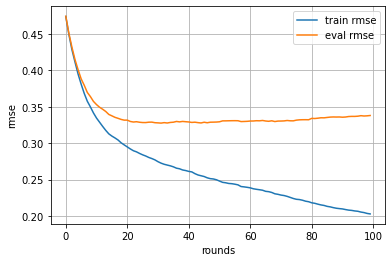

[0]	train-rmse:0.473103	eval-rmse:0.473346
[1]	train-rmse:0.448494	eval-rmse:0.451056
[2]	train-rmse:0.42765	eval-rmse:0.431731
[3]	train-rmse:0.409997	eval-rmse:0.414741
[4]	train-rmse:0.393819	eval-rmse:0.400654
[5]	train-rmse:0.379501	eval-rmse:0.387945
[6]	train-rmse:0.367324	eval-rmse:0.377098
[7]	train-rmse:0.357139	eval-rmse:0.367309
[8]	train-rmse:0.348483	eval-rmse:0.362258
[9]	train-rmse:0.340562	eval-rmse:0.355648
[10]	train-rmse:0.333577	eval-rmse:0.35104
[11]	train-rmse:0.327964	eval-rmse:0.347591
[12]	train-rmse:0.322108	eval-rmse:0.344775
[13]	train-rmse:0.317125	eval-rmse:0.341804
[14]	train-rmse:0.312615	eval-rmse:0.338191
[15]	train-rmse:0.308994	eval-rmse:0.336117
[16]	train-rmse:0.306402	eval-rmse:0.334501
[17]	train-rmse:0.303567	eval-rmse:0.332829
[18]	train-rmse:0.299711	eval-rmse:0.33144
[19]	train-rmse:0.297047	eval-rmse:0.330579
[20]	train-rmse:0.294285	eval-rmse:0.33064
[21]	train-rmse:0.292148	eval-rmse:0.330291
[22]	train-rmse:0.289344	eval-rmse:0.329585
[2

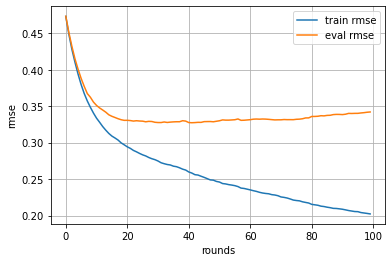

[0]	train-rmse:0.473103	eval-rmse:0.473346
[1]	train-rmse:0.448511	eval-rmse:0.450931
[2]	train-rmse:0.427722	eval-rmse:0.431711
[3]	train-rmse:0.408868	eval-rmse:0.414718
[4]	train-rmse:0.392296	eval-rmse:0.400199
[5]	train-rmse:0.378044	eval-rmse:0.387513
[6]	train-rmse:0.36589	eval-rmse:0.376798
[7]	train-rmse:0.355836	eval-rmse:0.367149
[8]	train-rmse:0.347225	eval-rmse:0.362167
[9]	train-rmse:0.339328	eval-rmse:0.355729
[10]	train-rmse:0.332805	eval-rmse:0.352081
[11]	train-rmse:0.327303	eval-rmse:0.348654
[12]	train-rmse:0.321391	eval-rmse:0.345826
[13]	train-rmse:0.316806	eval-rmse:0.342253
[14]	train-rmse:0.311987	eval-rmse:0.338904
[15]	train-rmse:0.307728	eval-rmse:0.336432
[16]	train-rmse:0.305129	eval-rmse:0.334631
[17]	train-rmse:0.30172	eval-rmse:0.334776
[18]	train-rmse:0.297825	eval-rmse:0.333362
[19]	train-rmse:0.294829	eval-rmse:0.331892
[20]	train-rmse:0.292058	eval-rmse:0.333432
[21]	train-rmse:0.290011	eval-rmse:0.333226
[22]	train-rmse:0.287253	eval-rmse:0.332715


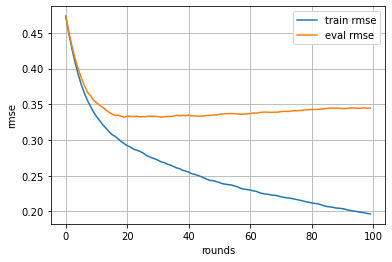

Tuning min_child_weight ...
[0]	train-rmse:0.475477	eval-rmse:0.474763
[1]	train-rmse:0.450508	eval-rmse:0.451119
[2]	train-rmse:0.429042	eval-rmse:0.431306
[3]	train-rmse:0.412292	eval-rmse:0.414193
[4]	train-rmse:0.395667	eval-rmse:0.400241
[5]	train-rmse:0.381048	eval-rmse:0.386957
[6]	train-rmse:0.369021	eval-rmse:0.376837
[7]	train-rmse:0.35723	eval-rmse:0.367238
[8]	train-rmse:0.349382	eval-rmse:0.360852
[9]	train-rmse:0.341197	eval-rmse:0.354412
[10]	train-rmse:0.334703	eval-rmse:0.347618
[11]	train-rmse:0.328312	eval-rmse:0.343106
[12]	train-rmse:0.322506	eval-rmse:0.339771
[13]	train-rmse:0.318011	eval-rmse:0.337781
[14]	train-rmse:0.313171	eval-rmse:0.333837
[15]	train-rmse:0.310331	eval-rmse:0.331217
[16]	train-rmse:0.307784	eval-rmse:0.329129
[17]	train-rmse:0.30476	eval-rmse:0.327302
[18]	train-rmse:0.301603	eval-rmse:0.326251
[19]	train-rmse:0.297784	eval-rmse:0.32455
[20]	train-rmse:0.29595	eval-rmse:0.323293
[21]	train-rmse:0.292857	eval-rmse:0.32216
[22]	train-rmse:0.2

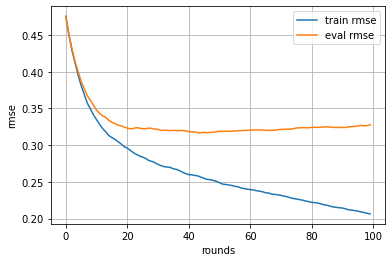

[0]	train-rmse:0.475477	eval-rmse:0.474763
[1]	train-rmse:0.450508	eval-rmse:0.451119
[2]	train-rmse:0.429042	eval-rmse:0.431306
[3]	train-rmse:0.412292	eval-rmse:0.414193
[4]	train-rmse:0.395667	eval-rmse:0.400241
[5]	train-rmse:0.381048	eval-rmse:0.386957
[6]	train-rmse:0.369021	eval-rmse:0.376837
[7]	train-rmse:0.35723	eval-rmse:0.367238
[8]	train-rmse:0.349382	eval-rmse:0.360852
[9]	train-rmse:0.341197	eval-rmse:0.354412
[10]	train-rmse:0.334703	eval-rmse:0.347618
[11]	train-rmse:0.328312	eval-rmse:0.343106
[12]	train-rmse:0.322506	eval-rmse:0.339771
[13]	train-rmse:0.318011	eval-rmse:0.337781
[14]	train-rmse:0.313171	eval-rmse:0.333837
[15]	train-rmse:0.310331	eval-rmse:0.331217
[16]	train-rmse:0.307784	eval-rmse:0.329129
[17]	train-rmse:0.30476	eval-rmse:0.327302
[18]	train-rmse:0.301603	eval-rmse:0.326251
[19]	train-rmse:0.297784	eval-rmse:0.32455
[20]	train-rmse:0.29595	eval-rmse:0.323293
[21]	train-rmse:0.292857	eval-rmse:0.32216
[22]	train-rmse:0.289697	eval-rmse:0.322653
[23

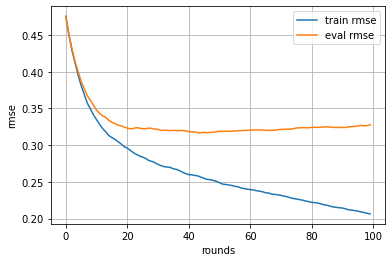

[0]	train-rmse:0.475477	eval-rmse:0.474763
[1]	train-rmse:0.450508	eval-rmse:0.451119
[2]	train-rmse:0.429042	eval-rmse:0.431306
[3]	train-rmse:0.412292	eval-rmse:0.414193
[4]	train-rmse:0.395667	eval-rmse:0.400241
[5]	train-rmse:0.381048	eval-rmse:0.386957
[6]	train-rmse:0.369021	eval-rmse:0.376837
[7]	train-rmse:0.35723	eval-rmse:0.367238
[8]	train-rmse:0.349382	eval-rmse:0.360852
[9]	train-rmse:0.341197	eval-rmse:0.354412
[10]	train-rmse:0.334703	eval-rmse:0.347618
[11]	train-rmse:0.328312	eval-rmse:0.343106
[12]	train-rmse:0.322506	eval-rmse:0.339771
[13]	train-rmse:0.318011	eval-rmse:0.337781
[14]	train-rmse:0.313171	eval-rmse:0.333837
[15]	train-rmse:0.310331	eval-rmse:0.331217
[16]	train-rmse:0.307784	eval-rmse:0.329129
[17]	train-rmse:0.30476	eval-rmse:0.327302
[18]	train-rmse:0.301603	eval-rmse:0.326251
[19]	train-rmse:0.297784	eval-rmse:0.32455
[20]	train-rmse:0.29595	eval-rmse:0.323293
[21]	train-rmse:0.292857	eval-rmse:0.32216
[22]	train-rmse:0.289697	eval-rmse:0.322653
[23

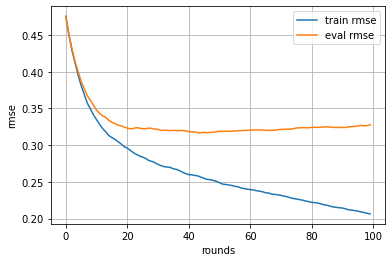

[0]	train-rmse:0.475477	eval-rmse:0.474763
[1]	train-rmse:0.450508	eval-rmse:0.451119
[2]	train-rmse:0.429042	eval-rmse:0.431306
[3]	train-rmse:0.412292	eval-rmse:0.414193
[4]	train-rmse:0.395667	eval-rmse:0.400241
[5]	train-rmse:0.381048	eval-rmse:0.386957
[6]	train-rmse:0.369021	eval-rmse:0.376837
[7]	train-rmse:0.35723	eval-rmse:0.367238
[8]	train-rmse:0.349382	eval-rmse:0.360852
[9]	train-rmse:0.341197	eval-rmse:0.354412
[10]	train-rmse:0.334703	eval-rmse:0.347618
[11]	train-rmse:0.328312	eval-rmse:0.343106
[12]	train-rmse:0.322506	eval-rmse:0.339771
[13]	train-rmse:0.318011	eval-rmse:0.337781
[14]	train-rmse:0.313171	eval-rmse:0.333837
[15]	train-rmse:0.310331	eval-rmse:0.331217
[16]	train-rmse:0.307784	eval-rmse:0.329129
[17]	train-rmse:0.30476	eval-rmse:0.327302
[18]	train-rmse:0.301603	eval-rmse:0.326251
[19]	train-rmse:0.297784	eval-rmse:0.32455
[20]	train-rmse:0.29595	eval-rmse:0.323293
[21]	train-rmse:0.292857	eval-rmse:0.32216
[22]	train-rmse:0.289697	eval-rmse:0.322653
[23

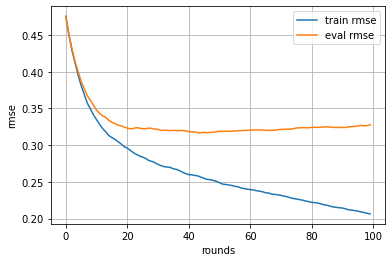

[0]	train-rmse:0.475477	eval-rmse:0.474763
[1]	train-rmse:0.450508	eval-rmse:0.451119
[2]	train-rmse:0.429042	eval-rmse:0.431306
[3]	train-rmse:0.412292	eval-rmse:0.414193
[4]	train-rmse:0.395667	eval-rmse:0.400241
[5]	train-rmse:0.381048	eval-rmse:0.386957
[6]	train-rmse:0.369021	eval-rmse:0.376837
[7]	train-rmse:0.35723	eval-rmse:0.367238
[8]	train-rmse:0.349382	eval-rmse:0.360852
[9]	train-rmse:0.341197	eval-rmse:0.354412
[10]	train-rmse:0.334703	eval-rmse:0.347618
[11]	train-rmse:0.328312	eval-rmse:0.343106
[12]	train-rmse:0.322506	eval-rmse:0.339771
[13]	train-rmse:0.318011	eval-rmse:0.337781
[14]	train-rmse:0.313171	eval-rmse:0.333837
[15]	train-rmse:0.310331	eval-rmse:0.331217
[16]	train-rmse:0.307784	eval-rmse:0.329129
[17]	train-rmse:0.30476	eval-rmse:0.327302
[18]	train-rmse:0.301603	eval-rmse:0.326251
[19]	train-rmse:0.297784	eval-rmse:0.32455
[20]	train-rmse:0.29595	eval-rmse:0.323293
[21]	train-rmse:0.292857	eval-rmse:0.32216
[22]	train-rmse:0.289697	eval-rmse:0.322653
[23

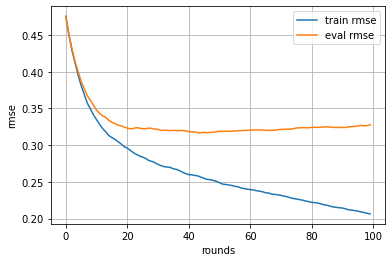

[0]	train-rmse:0.475477	eval-rmse:0.474763
[1]	train-rmse:0.450508	eval-rmse:0.451119
[2]	train-rmse:0.429042	eval-rmse:0.431306
[3]	train-rmse:0.412292	eval-rmse:0.414193
[4]	train-rmse:0.395667	eval-rmse:0.400241
[5]	train-rmse:0.381048	eval-rmse:0.386957
[6]	train-rmse:0.369021	eval-rmse:0.376837
[7]	train-rmse:0.35723	eval-rmse:0.367238
[8]	train-rmse:0.349382	eval-rmse:0.360852
[9]	train-rmse:0.341197	eval-rmse:0.354412
[10]	train-rmse:0.334703	eval-rmse:0.347618
[11]	train-rmse:0.328312	eval-rmse:0.343106
[12]	train-rmse:0.322506	eval-rmse:0.339771
[13]	train-rmse:0.318011	eval-rmse:0.337781
[14]	train-rmse:0.313171	eval-rmse:0.333837
[15]	train-rmse:0.310331	eval-rmse:0.331217
[16]	train-rmse:0.307784	eval-rmse:0.329129
[17]	train-rmse:0.30476	eval-rmse:0.327302
[18]	train-rmse:0.301603	eval-rmse:0.326251
[19]	train-rmse:0.297784	eval-rmse:0.32455
[20]	train-rmse:0.29595	eval-rmse:0.323293
[21]	train-rmse:0.292857	eval-rmse:0.32216
[22]	train-rmse:0.289697	eval-rmse:0.322653
[23

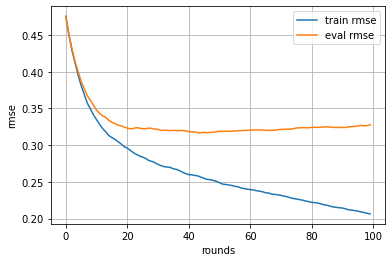

[0]	train-rmse:0.475477	eval-rmse:0.474763
[1]	train-rmse:0.450508	eval-rmse:0.451119
[2]	train-rmse:0.429042	eval-rmse:0.431306
[3]	train-rmse:0.412292	eval-rmse:0.414193
[4]	train-rmse:0.395667	eval-rmse:0.400241
[5]	train-rmse:0.381048	eval-rmse:0.386957
[6]	train-rmse:0.369021	eval-rmse:0.376837
[7]	train-rmse:0.35723	eval-rmse:0.367238
[8]	train-rmse:0.349382	eval-rmse:0.360852
[9]	train-rmse:0.341197	eval-rmse:0.354412
[10]	train-rmse:0.334703	eval-rmse:0.347618
[11]	train-rmse:0.328312	eval-rmse:0.343106
[12]	train-rmse:0.322506	eval-rmse:0.339771
[13]	train-rmse:0.318011	eval-rmse:0.337781
[14]	train-rmse:0.313171	eval-rmse:0.333837
[15]	train-rmse:0.310331	eval-rmse:0.331217
[16]	train-rmse:0.307784	eval-rmse:0.329129
[17]	train-rmse:0.30476	eval-rmse:0.327302
[18]	train-rmse:0.301603	eval-rmse:0.326251
[19]	train-rmse:0.297784	eval-rmse:0.32455
[20]	train-rmse:0.29595	eval-rmse:0.323293
[21]	train-rmse:0.292857	eval-rmse:0.32216
[22]	train-rmse:0.289697	eval-rmse:0.322653
[23

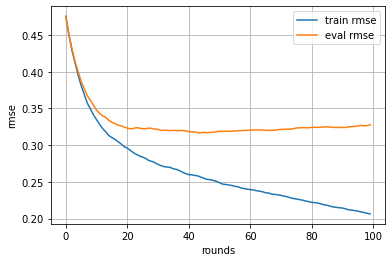

[0]	train-rmse:0.475477	eval-rmse:0.474763
[1]	train-rmse:0.450508	eval-rmse:0.451119
[2]	train-rmse:0.429042	eval-rmse:0.431306
[3]	train-rmse:0.412292	eval-rmse:0.414193
[4]	train-rmse:0.395667	eval-rmse:0.400241
[5]	train-rmse:0.381048	eval-rmse:0.386957
[6]	train-rmse:0.369021	eval-rmse:0.376837
[7]	train-rmse:0.35723	eval-rmse:0.367238
[8]	train-rmse:0.349382	eval-rmse:0.360852
[9]	train-rmse:0.341197	eval-rmse:0.354412
[10]	train-rmse:0.334703	eval-rmse:0.347618
[11]	train-rmse:0.328312	eval-rmse:0.343106
[12]	train-rmse:0.322506	eval-rmse:0.339771
[13]	train-rmse:0.318011	eval-rmse:0.337781
[14]	train-rmse:0.313171	eval-rmse:0.333837
[15]	train-rmse:0.310331	eval-rmse:0.331217
[16]	train-rmse:0.307784	eval-rmse:0.329129
[17]	train-rmse:0.30476	eval-rmse:0.327302
[18]	train-rmse:0.301603	eval-rmse:0.326251
[19]	train-rmse:0.297784	eval-rmse:0.32455
[20]	train-rmse:0.29595	eval-rmse:0.323293
[21]	train-rmse:0.292857	eval-rmse:0.32216
[22]	train-rmse:0.289697	eval-rmse:0.322653
[23

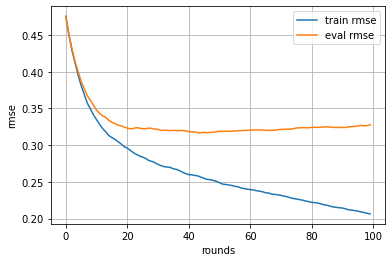

[0]	train-rmse:0.475477	eval-rmse:0.474763
[1]	train-rmse:0.450508	eval-rmse:0.451119
[2]	train-rmse:0.429042	eval-rmse:0.431306
[3]	train-rmse:0.412292	eval-rmse:0.414193
[4]	train-rmse:0.395667	eval-rmse:0.400241
[5]	train-rmse:0.381048	eval-rmse:0.386957
[6]	train-rmse:0.369021	eval-rmse:0.376837
[7]	train-rmse:0.35723	eval-rmse:0.367238
[8]	train-rmse:0.349382	eval-rmse:0.360852
[9]	train-rmse:0.341197	eval-rmse:0.354412
[10]	train-rmse:0.334703	eval-rmse:0.347618
[11]	train-rmse:0.328312	eval-rmse:0.343106
[12]	train-rmse:0.322506	eval-rmse:0.339771
[13]	train-rmse:0.318011	eval-rmse:0.337781
[14]	train-rmse:0.313171	eval-rmse:0.333837
[15]	train-rmse:0.310331	eval-rmse:0.331217
[16]	train-rmse:0.307784	eval-rmse:0.329129
[17]	train-rmse:0.30476	eval-rmse:0.327302
[18]	train-rmse:0.301603	eval-rmse:0.326251
[19]	train-rmse:0.297784	eval-rmse:0.32455
[20]	train-rmse:0.29595	eval-rmse:0.323293
[21]	train-rmse:0.292857	eval-rmse:0.32216
[22]	train-rmse:0.289697	eval-rmse:0.322653
[23

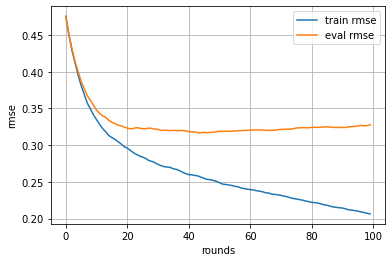

[0]	train-rmse:0.475477	eval-rmse:0.474763
[1]	train-rmse:0.450508	eval-rmse:0.451119
[2]	train-rmse:0.429042	eval-rmse:0.431306
[3]	train-rmse:0.412292	eval-rmse:0.414193
[4]	train-rmse:0.395667	eval-rmse:0.400241
[5]	train-rmse:0.381048	eval-rmse:0.386957
[6]	train-rmse:0.369021	eval-rmse:0.376837
[7]	train-rmse:0.35723	eval-rmse:0.367238
[8]	train-rmse:0.349382	eval-rmse:0.360852
[9]	train-rmse:0.341197	eval-rmse:0.354412
[10]	train-rmse:0.334703	eval-rmse:0.347618
[11]	train-rmse:0.328312	eval-rmse:0.343106
[12]	train-rmse:0.322506	eval-rmse:0.339771
[13]	train-rmse:0.318011	eval-rmse:0.337781
[14]	train-rmse:0.313171	eval-rmse:0.333837
[15]	train-rmse:0.310331	eval-rmse:0.331217
[16]	train-rmse:0.307784	eval-rmse:0.329129
[17]	train-rmse:0.30476	eval-rmse:0.327302
[18]	train-rmse:0.301603	eval-rmse:0.326251
[19]	train-rmse:0.297784	eval-rmse:0.32455
[20]	train-rmse:0.29595	eval-rmse:0.323293
[21]	train-rmse:0.292857	eval-rmse:0.32216
[22]	train-rmse:0.289697	eval-rmse:0.322653
[23

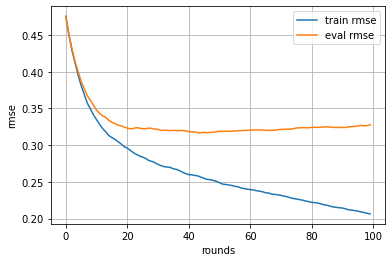

[0]	train-rmse:0.476064	eval-rmse:0.475742
[1]	train-rmse:0.451264	eval-rmse:0.452632
[2]	train-rmse:0.429986	eval-rmse:0.432559
[3]	train-rmse:0.41336	eval-rmse:0.416247
[4]	train-rmse:0.396785	eval-rmse:0.402218
[5]	train-rmse:0.382697	eval-rmse:0.388832
[6]	train-rmse:0.371156	eval-rmse:0.379404
[7]	train-rmse:0.359635	eval-rmse:0.370614
[8]	train-rmse:0.351246	eval-rmse:0.363181
[9]	train-rmse:0.343349	eval-rmse:0.356576
[10]	train-rmse:0.336848	eval-rmse:0.350595
[11]	train-rmse:0.330747	eval-rmse:0.346322
[12]	train-rmse:0.325367	eval-rmse:0.343193
[13]	train-rmse:0.321721	eval-rmse:0.339525
[14]	train-rmse:0.316907	eval-rmse:0.335539
[15]	train-rmse:0.314151	eval-rmse:0.33266
[16]	train-rmse:0.311623	eval-rmse:0.330273
[17]	train-rmse:0.308519	eval-rmse:0.328793
[18]	train-rmse:0.305349	eval-rmse:0.327999
[19]	train-rmse:0.301646	eval-rmse:0.326343
[20]	train-rmse:0.298491	eval-rmse:0.326826
[21]	train-rmse:0.295791	eval-rmse:0.326241
[22]	train-rmse:0.293922	eval-rmse:0.326517


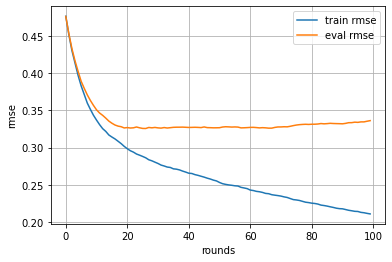

[0]	train-rmse:0.476064	eval-rmse:0.475742
[1]	train-rmse:0.451264	eval-rmse:0.452632
[2]	train-rmse:0.429986	eval-rmse:0.432559
[3]	train-rmse:0.41336	eval-rmse:0.416247
[4]	train-rmse:0.396785	eval-rmse:0.402218
[5]	train-rmse:0.382697	eval-rmse:0.388832
[6]	train-rmse:0.371156	eval-rmse:0.379404
[7]	train-rmse:0.359635	eval-rmse:0.370614
[8]	train-rmse:0.351246	eval-rmse:0.363181
[9]	train-rmse:0.343349	eval-rmse:0.356576
[10]	train-rmse:0.336848	eval-rmse:0.350595
[11]	train-rmse:0.330747	eval-rmse:0.346322
[12]	train-rmse:0.325367	eval-rmse:0.343193
[13]	train-rmse:0.321721	eval-rmse:0.339525
[14]	train-rmse:0.316907	eval-rmse:0.335539
[15]	train-rmse:0.314151	eval-rmse:0.33266
[16]	train-rmse:0.311623	eval-rmse:0.330273
[17]	train-rmse:0.308519	eval-rmse:0.328793
[18]	train-rmse:0.305349	eval-rmse:0.327999
[19]	train-rmse:0.301646	eval-rmse:0.326343
[20]	train-rmse:0.298491	eval-rmse:0.326826
[21]	train-rmse:0.295791	eval-rmse:0.326241
[22]	train-rmse:0.293922	eval-rmse:0.326517


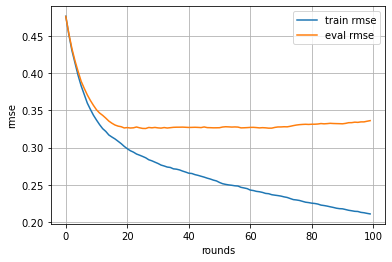

[0]	train-rmse:0.476064	eval-rmse:0.475742
[1]	train-rmse:0.451263	eval-rmse:0.452632
[2]	train-rmse:0.429986	eval-rmse:0.432559
[3]	train-rmse:0.41336	eval-rmse:0.416247
[4]	train-rmse:0.396785	eval-rmse:0.402218
[5]	train-rmse:0.382697	eval-rmse:0.388832
[6]	train-rmse:0.371156	eval-rmse:0.379404
[7]	train-rmse:0.359635	eval-rmse:0.370614
[8]	train-rmse:0.351246	eval-rmse:0.363181
[9]	train-rmse:0.343349	eval-rmse:0.356576
[10]	train-rmse:0.336848	eval-rmse:0.350595
[11]	train-rmse:0.330747	eval-rmse:0.346322
[12]	train-rmse:0.325367	eval-rmse:0.343193
[13]	train-rmse:0.321721	eval-rmse:0.339525
[14]	train-rmse:0.316907	eval-rmse:0.335539
[15]	train-rmse:0.314151	eval-rmse:0.33266
[16]	train-rmse:0.311623	eval-rmse:0.330273
[17]	train-rmse:0.308519	eval-rmse:0.328793
[18]	train-rmse:0.305349	eval-rmse:0.327999
[19]	train-rmse:0.301646	eval-rmse:0.326343
[20]	train-rmse:0.298491	eval-rmse:0.326826
[21]	train-rmse:0.295791	eval-rmse:0.326241
[22]	train-rmse:0.293922	eval-rmse:0.326517


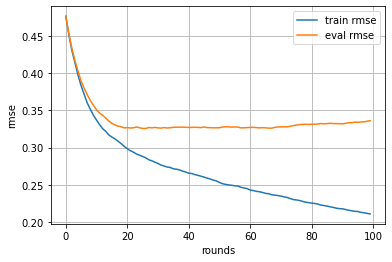

[0]	train-rmse:0.476064	eval-rmse:0.475742
[1]	train-rmse:0.451264	eval-rmse:0.452632
[2]	train-rmse:0.429986	eval-rmse:0.432559
[3]	train-rmse:0.41336	eval-rmse:0.416247
[4]	train-rmse:0.396785	eval-rmse:0.402218
[5]	train-rmse:0.382697	eval-rmse:0.388832
[6]	train-rmse:0.371156	eval-rmse:0.379404
[7]	train-rmse:0.359635	eval-rmse:0.370614
[8]	train-rmse:0.351246	eval-rmse:0.363181
[9]	train-rmse:0.343349	eval-rmse:0.356576
[10]	train-rmse:0.336848	eval-rmse:0.350595
[11]	train-rmse:0.330747	eval-rmse:0.346322
[12]	train-rmse:0.325367	eval-rmse:0.343193
[13]	train-rmse:0.321721	eval-rmse:0.339525
[14]	train-rmse:0.316907	eval-rmse:0.335539
[15]	train-rmse:0.314151	eval-rmse:0.33266
[16]	train-rmse:0.311623	eval-rmse:0.330273
[17]	train-rmse:0.308519	eval-rmse:0.328793
[18]	train-rmse:0.305349	eval-rmse:0.327999
[19]	train-rmse:0.301646	eval-rmse:0.326343
[20]	train-rmse:0.298491	eval-rmse:0.326826
[21]	train-rmse:0.295791	eval-rmse:0.326241
[22]	train-rmse:0.293922	eval-rmse:0.326517


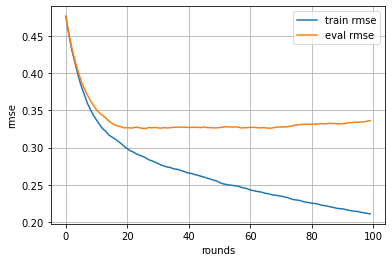

[0]	train-rmse:0.476064	eval-rmse:0.475742
[1]	train-rmse:0.451263	eval-rmse:0.452632
[2]	train-rmse:0.429986	eval-rmse:0.432559
[3]	train-rmse:0.41336	eval-rmse:0.416247
[4]	train-rmse:0.396785	eval-rmse:0.402218
[5]	train-rmse:0.382697	eval-rmse:0.388832
[6]	train-rmse:0.371156	eval-rmse:0.379404
[7]	train-rmse:0.359635	eval-rmse:0.370614
[8]	train-rmse:0.351246	eval-rmse:0.363181
[9]	train-rmse:0.343349	eval-rmse:0.356576
[10]	train-rmse:0.336848	eval-rmse:0.350595
[11]	train-rmse:0.330747	eval-rmse:0.346322
[12]	train-rmse:0.325367	eval-rmse:0.343193
[13]	train-rmse:0.321721	eval-rmse:0.339525
[14]	train-rmse:0.316907	eval-rmse:0.335539
[15]	train-rmse:0.314151	eval-rmse:0.33266
[16]	train-rmse:0.311623	eval-rmse:0.330273
[17]	train-rmse:0.308519	eval-rmse:0.328793
[18]	train-rmse:0.305349	eval-rmse:0.327999
[19]	train-rmse:0.301646	eval-rmse:0.326343
[20]	train-rmse:0.298491	eval-rmse:0.326826
[21]	train-rmse:0.295791	eval-rmse:0.326241
[22]	train-rmse:0.293922	eval-rmse:0.326517


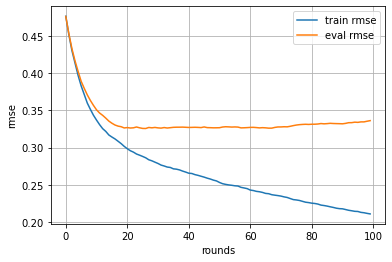

[0]	train-rmse:0.476064	eval-rmse:0.475742
[1]	train-rmse:0.451263	eval-rmse:0.452632
[2]	train-rmse:0.429986	eval-rmse:0.432559
[3]	train-rmse:0.41336	eval-rmse:0.416247
[4]	train-rmse:0.396785	eval-rmse:0.402218
[5]	train-rmse:0.382697	eval-rmse:0.388832
[6]	train-rmse:0.371156	eval-rmse:0.379404
[7]	train-rmse:0.359635	eval-rmse:0.370614
[8]	train-rmse:0.351246	eval-rmse:0.363181
[9]	train-rmse:0.343349	eval-rmse:0.356576
[10]	train-rmse:0.336848	eval-rmse:0.350595
[11]	train-rmse:0.330747	eval-rmse:0.346322
[12]	train-rmse:0.325367	eval-rmse:0.343193
[13]	train-rmse:0.321721	eval-rmse:0.339525
[14]	train-rmse:0.316907	eval-rmse:0.335539
[15]	train-rmse:0.314151	eval-rmse:0.33266
[16]	train-rmse:0.311623	eval-rmse:0.330273
[17]	train-rmse:0.308519	eval-rmse:0.328793
[18]	train-rmse:0.305349	eval-rmse:0.327999
[19]	train-rmse:0.301646	eval-rmse:0.326343
[20]	train-rmse:0.298491	eval-rmse:0.326826
[21]	train-rmse:0.295791	eval-rmse:0.326241
[22]	train-rmse:0.293922	eval-rmse:0.326517


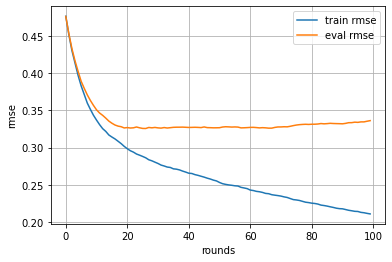

[0]	train-rmse:0.476064	eval-rmse:0.475742
[1]	train-rmse:0.451263	eval-rmse:0.452632
[2]	train-rmse:0.429986	eval-rmse:0.432559
[3]	train-rmse:0.41336	eval-rmse:0.416247
[4]	train-rmse:0.396785	eval-rmse:0.402218
[5]	train-rmse:0.382697	eval-rmse:0.388832
[6]	train-rmse:0.371156	eval-rmse:0.379404
[7]	train-rmse:0.359635	eval-rmse:0.370614
[8]	train-rmse:0.351246	eval-rmse:0.363181
[9]	train-rmse:0.343349	eval-rmse:0.356576
[10]	train-rmse:0.336848	eval-rmse:0.350595
[11]	train-rmse:0.330747	eval-rmse:0.346322
[12]	train-rmse:0.325367	eval-rmse:0.343193
[13]	train-rmse:0.321721	eval-rmse:0.339525
[14]	train-rmse:0.316907	eval-rmse:0.335539
[15]	train-rmse:0.314151	eval-rmse:0.33266
[16]	train-rmse:0.311623	eval-rmse:0.330273
[17]	train-rmse:0.308519	eval-rmse:0.328793
[18]	train-rmse:0.305349	eval-rmse:0.327999
[19]	train-rmse:0.301646	eval-rmse:0.326343
[20]	train-rmse:0.298491	eval-rmse:0.326826
[21]	train-rmse:0.295791	eval-rmse:0.326241
[22]	train-rmse:0.293922	eval-rmse:0.326517


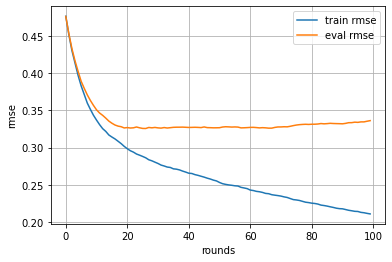

[0]	train-rmse:0.476064	eval-rmse:0.475742
[1]	train-rmse:0.451263	eval-rmse:0.452632
[2]	train-rmse:0.429986	eval-rmse:0.432559
[3]	train-rmse:0.41336	eval-rmse:0.416247
[4]	train-rmse:0.396785	eval-rmse:0.402218
[5]	train-rmse:0.382697	eval-rmse:0.388832
[6]	train-rmse:0.371156	eval-rmse:0.379404
[7]	train-rmse:0.359635	eval-rmse:0.370614
[8]	train-rmse:0.351246	eval-rmse:0.363181
[9]	train-rmse:0.343349	eval-rmse:0.356576
[10]	train-rmse:0.336848	eval-rmse:0.350595
[11]	train-rmse:0.330747	eval-rmse:0.346322
[12]	train-rmse:0.325367	eval-rmse:0.343193
[13]	train-rmse:0.321721	eval-rmse:0.339525
[14]	train-rmse:0.316907	eval-rmse:0.335539
[15]	train-rmse:0.314151	eval-rmse:0.33266
[16]	train-rmse:0.311623	eval-rmse:0.330273
[17]	train-rmse:0.308519	eval-rmse:0.328793
[18]	train-rmse:0.305349	eval-rmse:0.327999
[19]	train-rmse:0.301646	eval-rmse:0.326343
[20]	train-rmse:0.298491	eval-rmse:0.326826
[21]	train-rmse:0.295791	eval-rmse:0.326241
[22]	train-rmse:0.293922	eval-rmse:0.326517


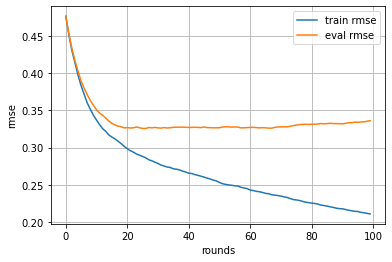

[0]	train-rmse:0.476064	eval-rmse:0.475742
[1]	train-rmse:0.451263	eval-rmse:0.452632
[2]	train-rmse:0.429986	eval-rmse:0.432559
[3]	train-rmse:0.41336	eval-rmse:0.416247
[4]	train-rmse:0.396785	eval-rmse:0.402218
[5]	train-rmse:0.382697	eval-rmse:0.388832
[6]	train-rmse:0.371156	eval-rmse:0.379404
[7]	train-rmse:0.359635	eval-rmse:0.370614
[8]	train-rmse:0.351246	eval-rmse:0.363181
[9]	train-rmse:0.343349	eval-rmse:0.356576
[10]	train-rmse:0.336848	eval-rmse:0.350595
[11]	train-rmse:0.330747	eval-rmse:0.346322
[12]	train-rmse:0.325367	eval-rmse:0.343193
[13]	train-rmse:0.321721	eval-rmse:0.339525
[14]	train-rmse:0.316907	eval-rmse:0.335539
[15]	train-rmse:0.314151	eval-rmse:0.33266
[16]	train-rmse:0.311623	eval-rmse:0.330273
[17]	train-rmse:0.308519	eval-rmse:0.328793
[18]	train-rmse:0.305349	eval-rmse:0.327999
[19]	train-rmse:0.301646	eval-rmse:0.326343
[20]	train-rmse:0.298491	eval-rmse:0.326826
[21]	train-rmse:0.295791	eval-rmse:0.326241
[22]	train-rmse:0.293922	eval-rmse:0.326517


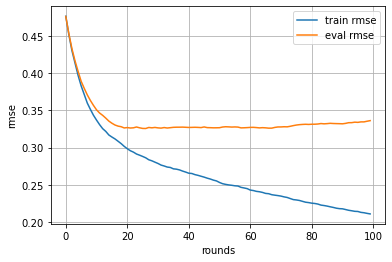

[0]	train-rmse:0.476064	eval-rmse:0.475742
[1]	train-rmse:0.451263	eval-rmse:0.452632
[2]	train-rmse:0.429986	eval-rmse:0.432559
[3]	train-rmse:0.41336	eval-rmse:0.416247
[4]	train-rmse:0.396785	eval-rmse:0.402218
[5]	train-rmse:0.382697	eval-rmse:0.388832
[6]	train-rmse:0.371156	eval-rmse:0.379404
[7]	train-rmse:0.359635	eval-rmse:0.370614
[8]	train-rmse:0.351246	eval-rmse:0.363181
[9]	train-rmse:0.343349	eval-rmse:0.356576
[10]	train-rmse:0.336848	eval-rmse:0.350595
[11]	train-rmse:0.330747	eval-rmse:0.346322
[12]	train-rmse:0.325367	eval-rmse:0.343193
[13]	train-rmse:0.321721	eval-rmse:0.339525
[14]	train-rmse:0.316907	eval-rmse:0.335539
[15]	train-rmse:0.314151	eval-rmse:0.33266
[16]	train-rmse:0.311623	eval-rmse:0.330273
[17]	train-rmse:0.308519	eval-rmse:0.328793
[18]	train-rmse:0.305349	eval-rmse:0.327999
[19]	train-rmse:0.301646	eval-rmse:0.326343
[20]	train-rmse:0.298491	eval-rmse:0.326826
[21]	train-rmse:0.295791	eval-rmse:0.326241
[22]	train-rmse:0.293922	eval-rmse:0.326517


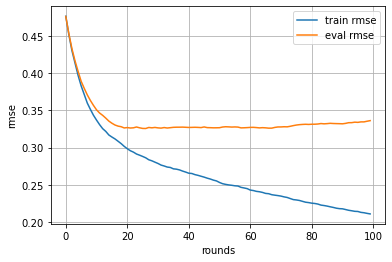

[0]	train-rmse:0.47551	eval-rmse:0.475036
[1]	train-rmse:0.450702	eval-rmse:0.452365
[2]	train-rmse:0.429686	eval-rmse:0.432925
[3]	train-rmse:0.413175	eval-rmse:0.41684
[4]	train-rmse:0.396535	eval-rmse:0.402374
[5]	train-rmse:0.382213	eval-rmse:0.388094
[6]	train-rmse:0.370789	eval-rmse:0.378071
[7]	train-rmse:0.359946	eval-rmse:0.369455
[8]	train-rmse:0.351729	eval-rmse:0.362191
[9]	train-rmse:0.344068	eval-rmse:0.355981
[10]	train-rmse:0.337798	eval-rmse:0.349052
[11]	train-rmse:0.331973	eval-rmse:0.344551
[12]	train-rmse:0.326705	eval-rmse:0.341165
[13]	train-rmse:0.322731	eval-rmse:0.3389
[14]	train-rmse:0.317627	eval-rmse:0.334832
[15]	train-rmse:0.314592	eval-rmse:0.332371
[16]	train-rmse:0.312237	eval-rmse:0.330339
[17]	train-rmse:0.308986	eval-rmse:0.329663
[18]	train-rmse:0.305944	eval-rmse:0.328341
[19]	train-rmse:0.302831	eval-rmse:0.3273
[20]	train-rmse:0.29971	eval-rmse:0.327276
[21]	train-rmse:0.297203	eval-rmse:0.325803
[22]	train-rmse:0.295175	eval-rmse:0.325791
[23]	

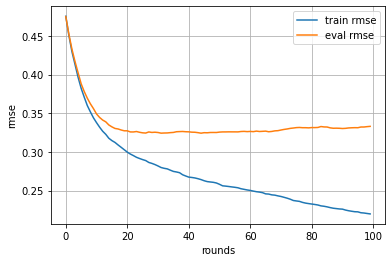

[0]	train-rmse:0.47551	eval-rmse:0.475036
[1]	train-rmse:0.450702	eval-rmse:0.452365
[2]	train-rmse:0.429686	eval-rmse:0.432925
[3]	train-rmse:0.413175	eval-rmse:0.41684
[4]	train-rmse:0.396535	eval-rmse:0.402374
[5]	train-rmse:0.382213	eval-rmse:0.388094
[6]	train-rmse:0.370789	eval-rmse:0.378071
[7]	train-rmse:0.359946	eval-rmse:0.369455
[8]	train-rmse:0.351729	eval-rmse:0.362191
[9]	train-rmse:0.344068	eval-rmse:0.355981
[10]	train-rmse:0.337798	eval-rmse:0.349052
[11]	train-rmse:0.331973	eval-rmse:0.344551
[12]	train-rmse:0.326705	eval-rmse:0.341165
[13]	train-rmse:0.322731	eval-rmse:0.3389
[14]	train-rmse:0.317627	eval-rmse:0.334832
[15]	train-rmse:0.314592	eval-rmse:0.332371
[16]	train-rmse:0.312236	eval-rmse:0.330339
[17]	train-rmse:0.308986	eval-rmse:0.329663
[18]	train-rmse:0.305944	eval-rmse:0.328341
[19]	train-rmse:0.302831	eval-rmse:0.3273
[20]	train-rmse:0.29971	eval-rmse:0.327276
[21]	train-rmse:0.297203	eval-rmse:0.325803
[22]	train-rmse:0.295175	eval-rmse:0.325791
[23]	

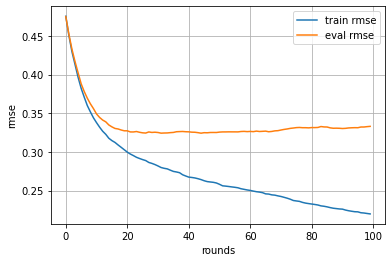

[0]	train-rmse:0.47551	eval-rmse:0.475036
[1]	train-rmse:0.450702	eval-rmse:0.452365
[2]	train-rmse:0.429686	eval-rmse:0.432925
[3]	train-rmse:0.413175	eval-rmse:0.41684
[4]	train-rmse:0.396535	eval-rmse:0.402374
[5]	train-rmse:0.382213	eval-rmse:0.388094
[6]	train-rmse:0.370789	eval-rmse:0.378071
[7]	train-rmse:0.359946	eval-rmse:0.369455
[8]	train-rmse:0.351729	eval-rmse:0.362191
[9]	train-rmse:0.344068	eval-rmse:0.355981
[10]	train-rmse:0.337798	eval-rmse:0.349052
[11]	train-rmse:0.331973	eval-rmse:0.344551
[12]	train-rmse:0.326705	eval-rmse:0.341165
[13]	train-rmse:0.322731	eval-rmse:0.3389
[14]	train-rmse:0.317627	eval-rmse:0.334832
[15]	train-rmse:0.314592	eval-rmse:0.332371
[16]	train-rmse:0.312236	eval-rmse:0.330339
[17]	train-rmse:0.308986	eval-rmse:0.329663
[18]	train-rmse:0.305944	eval-rmse:0.328341
[19]	train-rmse:0.302831	eval-rmse:0.3273
[20]	train-rmse:0.29971	eval-rmse:0.327276
[21]	train-rmse:0.297203	eval-rmse:0.325803
[22]	train-rmse:0.295175	eval-rmse:0.325791
[23]	

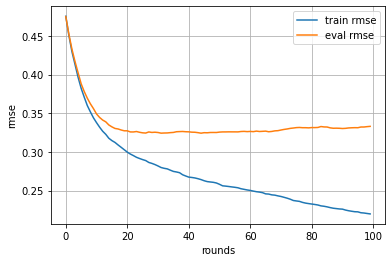

[0]	train-rmse:0.47551	eval-rmse:0.475036
[1]	train-rmse:0.450702	eval-rmse:0.452365
[2]	train-rmse:0.429686	eval-rmse:0.432925
[3]	train-rmse:0.413175	eval-rmse:0.41684
[4]	train-rmse:0.396535	eval-rmse:0.402374
[5]	train-rmse:0.382213	eval-rmse:0.388094
[6]	train-rmse:0.370789	eval-rmse:0.378071
[7]	train-rmse:0.359946	eval-rmse:0.369455
[8]	train-rmse:0.351729	eval-rmse:0.362191
[9]	train-rmse:0.344068	eval-rmse:0.355981
[10]	train-rmse:0.337798	eval-rmse:0.349052
[11]	train-rmse:0.331973	eval-rmse:0.344551
[12]	train-rmse:0.326705	eval-rmse:0.341165
[13]	train-rmse:0.322731	eval-rmse:0.3389
[14]	train-rmse:0.317627	eval-rmse:0.334832
[15]	train-rmse:0.314592	eval-rmse:0.332371
[16]	train-rmse:0.312236	eval-rmse:0.330339
[17]	train-rmse:0.308986	eval-rmse:0.329663
[18]	train-rmse:0.305944	eval-rmse:0.328341
[19]	train-rmse:0.302831	eval-rmse:0.3273
[20]	train-rmse:0.29971	eval-rmse:0.327276
[21]	train-rmse:0.297203	eval-rmse:0.325803
[22]	train-rmse:0.295175	eval-rmse:0.325791
[23]	

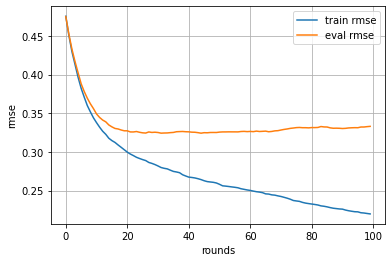

[0]	train-rmse:0.47551	eval-rmse:0.475036
[1]	train-rmse:0.450702	eval-rmse:0.452365
[2]	train-rmse:0.429686	eval-rmse:0.432925
[3]	train-rmse:0.413175	eval-rmse:0.41684
[4]	train-rmse:0.396535	eval-rmse:0.402374
[5]	train-rmse:0.382213	eval-rmse:0.388094
[6]	train-rmse:0.370789	eval-rmse:0.378071
[7]	train-rmse:0.359946	eval-rmse:0.369455
[8]	train-rmse:0.351729	eval-rmse:0.362191
[9]	train-rmse:0.344068	eval-rmse:0.355981
[10]	train-rmse:0.337798	eval-rmse:0.349052
[11]	train-rmse:0.331973	eval-rmse:0.344551
[12]	train-rmse:0.326705	eval-rmse:0.341165
[13]	train-rmse:0.322731	eval-rmse:0.3389
[14]	train-rmse:0.317627	eval-rmse:0.334832
[15]	train-rmse:0.314592	eval-rmse:0.332371
[16]	train-rmse:0.312237	eval-rmse:0.330339
[17]	train-rmse:0.308986	eval-rmse:0.329663
[18]	train-rmse:0.305944	eval-rmse:0.328341
[19]	train-rmse:0.302831	eval-rmse:0.3273
[20]	train-rmse:0.29971	eval-rmse:0.327276
[21]	train-rmse:0.297203	eval-rmse:0.325803
[22]	train-rmse:0.295175	eval-rmse:0.325791
[23]	

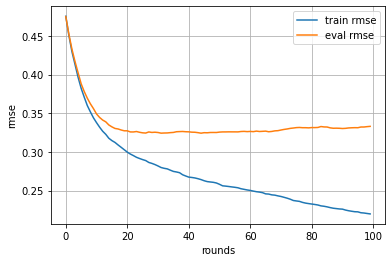

[0]	train-rmse:0.47551	eval-rmse:0.475036
[1]	train-rmse:0.450702	eval-rmse:0.452365
[2]	train-rmse:0.429686	eval-rmse:0.432925
[3]	train-rmse:0.413175	eval-rmse:0.41684
[4]	train-rmse:0.396535	eval-rmse:0.402374
[5]	train-rmse:0.382213	eval-rmse:0.388094
[6]	train-rmse:0.370789	eval-rmse:0.378071
[7]	train-rmse:0.359946	eval-rmse:0.369455
[8]	train-rmse:0.351729	eval-rmse:0.362191
[9]	train-rmse:0.344068	eval-rmse:0.355981
[10]	train-rmse:0.337798	eval-rmse:0.349052
[11]	train-rmse:0.331973	eval-rmse:0.344551
[12]	train-rmse:0.326705	eval-rmse:0.341165
[13]	train-rmse:0.322731	eval-rmse:0.3389
[14]	train-rmse:0.317627	eval-rmse:0.334832
[15]	train-rmse:0.314592	eval-rmse:0.332371
[16]	train-rmse:0.312237	eval-rmse:0.330339
[17]	train-rmse:0.308986	eval-rmse:0.329663
[18]	train-rmse:0.305944	eval-rmse:0.328341
[19]	train-rmse:0.302831	eval-rmse:0.3273
[20]	train-rmse:0.29971	eval-rmse:0.327276
[21]	train-rmse:0.297203	eval-rmse:0.325803
[22]	train-rmse:0.295175	eval-rmse:0.325791
[23]	

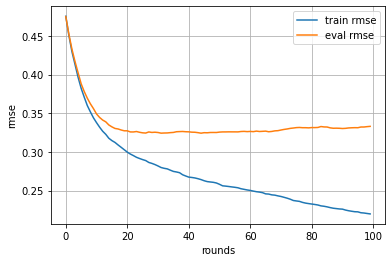

[0]	train-rmse:0.47551	eval-rmse:0.475036
[1]	train-rmse:0.450702	eval-rmse:0.452365
[2]	train-rmse:0.429686	eval-rmse:0.432925
[3]	train-rmse:0.413175	eval-rmse:0.41684
[4]	train-rmse:0.396535	eval-rmse:0.402374
[5]	train-rmse:0.382213	eval-rmse:0.388094
[6]	train-rmse:0.370789	eval-rmse:0.378071
[7]	train-rmse:0.359946	eval-rmse:0.369455
[8]	train-rmse:0.351729	eval-rmse:0.362191
[9]	train-rmse:0.344068	eval-rmse:0.355981
[10]	train-rmse:0.337798	eval-rmse:0.349052
[11]	train-rmse:0.331973	eval-rmse:0.344551
[12]	train-rmse:0.326705	eval-rmse:0.341165
[13]	train-rmse:0.322731	eval-rmse:0.3389
[14]	train-rmse:0.317627	eval-rmse:0.334832
[15]	train-rmse:0.314592	eval-rmse:0.332371
[16]	train-rmse:0.312237	eval-rmse:0.330339
[17]	train-rmse:0.308986	eval-rmse:0.329663
[18]	train-rmse:0.305944	eval-rmse:0.328341
[19]	train-rmse:0.302831	eval-rmse:0.3273
[20]	train-rmse:0.29971	eval-rmse:0.327276
[21]	train-rmse:0.297203	eval-rmse:0.325803
[22]	train-rmse:0.295175	eval-rmse:0.325791
[23]	

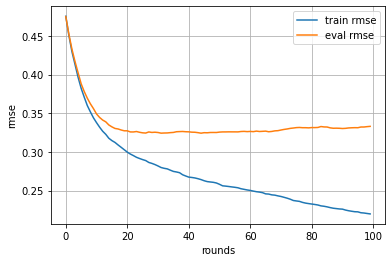

[0]	train-rmse:0.47551	eval-rmse:0.475036
[1]	train-rmse:0.450702	eval-rmse:0.452365
[2]	train-rmse:0.429686	eval-rmse:0.432925
[3]	train-rmse:0.413175	eval-rmse:0.41684
[4]	train-rmse:0.396535	eval-rmse:0.402374
[5]	train-rmse:0.382213	eval-rmse:0.388094
[6]	train-rmse:0.370789	eval-rmse:0.378071
[7]	train-rmse:0.359946	eval-rmse:0.369455
[8]	train-rmse:0.351729	eval-rmse:0.362191
[9]	train-rmse:0.344068	eval-rmse:0.355981
[10]	train-rmse:0.337798	eval-rmse:0.349052
[11]	train-rmse:0.331973	eval-rmse:0.344551
[12]	train-rmse:0.326705	eval-rmse:0.341165
[13]	train-rmse:0.322731	eval-rmse:0.3389
[14]	train-rmse:0.317627	eval-rmse:0.334832
[15]	train-rmse:0.314592	eval-rmse:0.332371
[16]	train-rmse:0.312237	eval-rmse:0.330339
[17]	train-rmse:0.308986	eval-rmse:0.329663
[18]	train-rmse:0.305944	eval-rmse:0.328341
[19]	train-rmse:0.302831	eval-rmse:0.3273
[20]	train-rmse:0.29971	eval-rmse:0.327276
[21]	train-rmse:0.297203	eval-rmse:0.325803
[22]	train-rmse:0.295175	eval-rmse:0.325791
[23]	

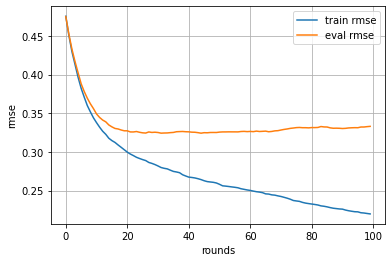

[0]	train-rmse:0.47551	eval-rmse:0.475036
[1]	train-rmse:0.450702	eval-rmse:0.452365
[2]	train-rmse:0.429686	eval-rmse:0.432925
[3]	train-rmse:0.413175	eval-rmse:0.41684
[4]	train-rmse:0.396535	eval-rmse:0.402374
[5]	train-rmse:0.382213	eval-rmse:0.388094
[6]	train-rmse:0.370789	eval-rmse:0.378071
[7]	train-rmse:0.359946	eval-rmse:0.369455
[8]	train-rmse:0.351729	eval-rmse:0.362191
[9]	train-rmse:0.344068	eval-rmse:0.355981
[10]	train-rmse:0.337798	eval-rmse:0.349052
[11]	train-rmse:0.331973	eval-rmse:0.344551
[12]	train-rmse:0.326705	eval-rmse:0.341165
[13]	train-rmse:0.322731	eval-rmse:0.3389
[14]	train-rmse:0.317627	eval-rmse:0.334832
[15]	train-rmse:0.314592	eval-rmse:0.332371
[16]	train-rmse:0.312236	eval-rmse:0.330339
[17]	train-rmse:0.308986	eval-rmse:0.329663
[18]	train-rmse:0.305944	eval-rmse:0.328341
[19]	train-rmse:0.302831	eval-rmse:0.3273
[20]	train-rmse:0.29971	eval-rmse:0.327276
[21]	train-rmse:0.297203	eval-rmse:0.325803
[22]	train-rmse:0.295175	eval-rmse:0.325791
[23]	

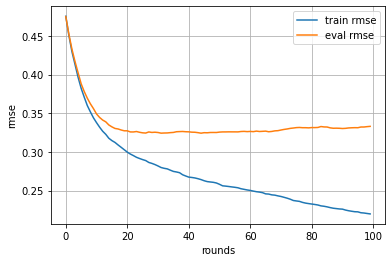

[0]	train-rmse:0.47551	eval-rmse:0.475036
[1]	train-rmse:0.450702	eval-rmse:0.452365
[2]	train-rmse:0.429686	eval-rmse:0.432925
[3]	train-rmse:0.413175	eval-rmse:0.41684
[4]	train-rmse:0.396535	eval-rmse:0.402374
[5]	train-rmse:0.382213	eval-rmse:0.388094
[6]	train-rmse:0.370789	eval-rmse:0.378071
[7]	train-rmse:0.359946	eval-rmse:0.369455
[8]	train-rmse:0.351729	eval-rmse:0.362191
[9]	train-rmse:0.344068	eval-rmse:0.355981
[10]	train-rmse:0.337798	eval-rmse:0.349052
[11]	train-rmse:0.331973	eval-rmse:0.344551
[12]	train-rmse:0.326705	eval-rmse:0.341165
[13]	train-rmse:0.322731	eval-rmse:0.3389
[14]	train-rmse:0.317627	eval-rmse:0.334832
[15]	train-rmse:0.314592	eval-rmse:0.332371
[16]	train-rmse:0.312237	eval-rmse:0.330339
[17]	train-rmse:0.308986	eval-rmse:0.329663
[18]	train-rmse:0.305944	eval-rmse:0.328341
[19]	train-rmse:0.302831	eval-rmse:0.3273
[20]	train-rmse:0.29971	eval-rmse:0.327276
[21]	train-rmse:0.297203	eval-rmse:0.325803
[22]	train-rmse:0.295175	eval-rmse:0.325791
[23]	

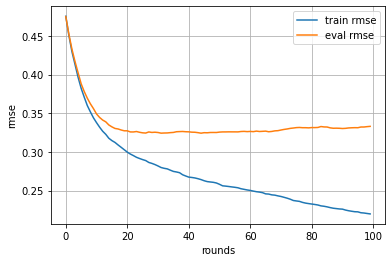

[0]	train-rmse:0.476197	eval-rmse:0.475638
[1]	train-rmse:0.451387	eval-rmse:0.452893
[2]	train-rmse:0.43056	eval-rmse:0.433271
[3]	train-rmse:0.414375	eval-rmse:0.417854
[4]	train-rmse:0.397851	eval-rmse:0.40285
[5]	train-rmse:0.383581	eval-rmse:0.388527
[6]	train-rmse:0.371964	eval-rmse:0.378507
[7]	train-rmse:0.36111	eval-rmse:0.370424
[8]	train-rmse:0.353209	eval-rmse:0.363004
[9]	train-rmse:0.345652	eval-rmse:0.356488
[10]	train-rmse:0.339069	eval-rmse:0.349391
[11]	train-rmse:0.33334	eval-rmse:0.345102
[12]	train-rmse:0.328226	eval-rmse:0.341719
[13]	train-rmse:0.32454	eval-rmse:0.338956
[14]	train-rmse:0.319008	eval-rmse:0.33548
[15]	train-rmse:0.315963	eval-rmse:0.33301
[16]	train-rmse:0.31299	eval-rmse:0.330706
[17]	train-rmse:0.309789	eval-rmse:0.329517
[18]	train-rmse:0.306716	eval-rmse:0.32843
[19]	train-rmse:0.303634	eval-rmse:0.327595
[20]	train-rmse:0.30094	eval-rmse:0.327844
[21]	train-rmse:0.298856	eval-rmse:0.326743
[22]	train-rmse:0.297381	eval-rmse:0.325874
[23]	tra

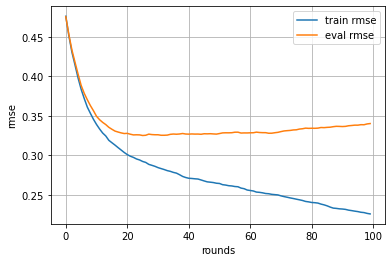

[0]	train-rmse:0.476197	eval-rmse:0.475638
[1]	train-rmse:0.451387	eval-rmse:0.452893
[2]	train-rmse:0.43056	eval-rmse:0.433271
[3]	train-rmse:0.414375	eval-rmse:0.417854
[4]	train-rmse:0.397851	eval-rmse:0.40285
[5]	train-rmse:0.383581	eval-rmse:0.388527
[6]	train-rmse:0.371964	eval-rmse:0.378507
[7]	train-rmse:0.36111	eval-rmse:0.370424
[8]	train-rmse:0.353209	eval-rmse:0.363004
[9]	train-rmse:0.345652	eval-rmse:0.356488
[10]	train-rmse:0.339069	eval-rmse:0.349391
[11]	train-rmse:0.33334	eval-rmse:0.345102
[12]	train-rmse:0.328226	eval-rmse:0.341719
[13]	train-rmse:0.32454	eval-rmse:0.338956
[14]	train-rmse:0.319008	eval-rmse:0.33548
[15]	train-rmse:0.315963	eval-rmse:0.33301
[16]	train-rmse:0.31299	eval-rmse:0.330706
[17]	train-rmse:0.309789	eval-rmse:0.329517
[18]	train-rmse:0.306716	eval-rmse:0.32843
[19]	train-rmse:0.303634	eval-rmse:0.327595
[20]	train-rmse:0.30094	eval-rmse:0.327844
[21]	train-rmse:0.298856	eval-rmse:0.326743
[22]	train-rmse:0.297381	eval-rmse:0.325874
[23]	tra

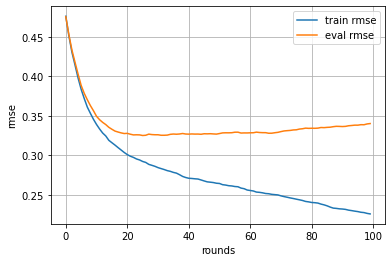

[0]	train-rmse:0.476197	eval-rmse:0.475638
[1]	train-rmse:0.451387	eval-rmse:0.452893
[2]	train-rmse:0.43056	eval-rmse:0.433271
[3]	train-rmse:0.414375	eval-rmse:0.417854
[4]	train-rmse:0.397851	eval-rmse:0.40285
[5]	train-rmse:0.383581	eval-rmse:0.388527
[6]	train-rmse:0.371964	eval-rmse:0.378507
[7]	train-rmse:0.36111	eval-rmse:0.370424
[8]	train-rmse:0.353209	eval-rmse:0.363004
[9]	train-rmse:0.345652	eval-rmse:0.356488
[10]	train-rmse:0.339069	eval-rmse:0.349391
[11]	train-rmse:0.33334	eval-rmse:0.345102
[12]	train-rmse:0.328226	eval-rmse:0.341719
[13]	train-rmse:0.32454	eval-rmse:0.338956
[14]	train-rmse:0.319008	eval-rmse:0.33548
[15]	train-rmse:0.315963	eval-rmse:0.33301
[16]	train-rmse:0.31299	eval-rmse:0.330706
[17]	train-rmse:0.309789	eval-rmse:0.329517
[18]	train-rmse:0.306716	eval-rmse:0.32843
[19]	train-rmse:0.303634	eval-rmse:0.327595
[20]	train-rmse:0.30094	eval-rmse:0.327844
[21]	train-rmse:0.298856	eval-rmse:0.326743
[22]	train-rmse:0.297381	eval-rmse:0.325874
[23]	tra

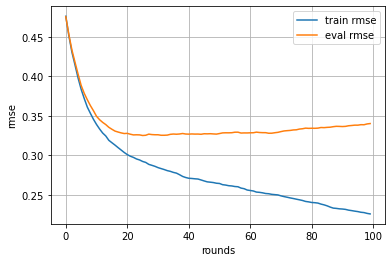

[0]	train-rmse:0.476197	eval-rmse:0.475638
[1]	train-rmse:0.451387	eval-rmse:0.452893
[2]	train-rmse:0.43056	eval-rmse:0.433271
[3]	train-rmse:0.414375	eval-rmse:0.417854
[4]	train-rmse:0.397851	eval-rmse:0.40285
[5]	train-rmse:0.383581	eval-rmse:0.388527
[6]	train-rmse:0.371964	eval-rmse:0.378507
[7]	train-rmse:0.36111	eval-rmse:0.370424
[8]	train-rmse:0.353209	eval-rmse:0.363004
[9]	train-rmse:0.345652	eval-rmse:0.356488
[10]	train-rmse:0.339069	eval-rmse:0.349391
[11]	train-rmse:0.33334	eval-rmse:0.345102
[12]	train-rmse:0.328226	eval-rmse:0.341719
[13]	train-rmse:0.32454	eval-rmse:0.338956
[14]	train-rmse:0.319008	eval-rmse:0.33548
[15]	train-rmse:0.315963	eval-rmse:0.33301
[16]	train-rmse:0.31299	eval-rmse:0.330706
[17]	train-rmse:0.309789	eval-rmse:0.329517
[18]	train-rmse:0.306716	eval-rmse:0.32843
[19]	train-rmse:0.303634	eval-rmse:0.327595
[20]	train-rmse:0.30094	eval-rmse:0.327844
[21]	train-rmse:0.298856	eval-rmse:0.326743
[22]	train-rmse:0.297381	eval-rmse:0.325874
[23]	tra

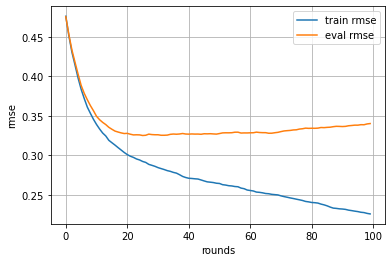

[0]	train-rmse:0.476197	eval-rmse:0.475638
[1]	train-rmse:0.451387	eval-rmse:0.452893
[2]	train-rmse:0.43056	eval-rmse:0.433271
[3]	train-rmse:0.414375	eval-rmse:0.417854
[4]	train-rmse:0.397851	eval-rmse:0.40285
[5]	train-rmse:0.383581	eval-rmse:0.388527
[6]	train-rmse:0.371964	eval-rmse:0.378507
[7]	train-rmse:0.36111	eval-rmse:0.370424
[8]	train-rmse:0.353209	eval-rmse:0.363004
[9]	train-rmse:0.345652	eval-rmse:0.356488
[10]	train-rmse:0.339069	eval-rmse:0.349391
[11]	train-rmse:0.33334	eval-rmse:0.345102
[12]	train-rmse:0.328226	eval-rmse:0.341719
[13]	train-rmse:0.32454	eval-rmse:0.338956
[14]	train-rmse:0.319008	eval-rmse:0.33548
[15]	train-rmse:0.315963	eval-rmse:0.33301
[16]	train-rmse:0.31299	eval-rmse:0.330706
[17]	train-rmse:0.309789	eval-rmse:0.329517
[18]	train-rmse:0.306716	eval-rmse:0.32843
[19]	train-rmse:0.303634	eval-rmse:0.327595
[20]	train-rmse:0.30094	eval-rmse:0.327844
[21]	train-rmse:0.298856	eval-rmse:0.326743
[22]	train-rmse:0.297381	eval-rmse:0.325874
[23]	tra

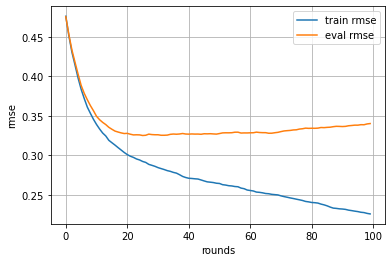

[0]	train-rmse:0.476197	eval-rmse:0.475638
[1]	train-rmse:0.451387	eval-rmse:0.452893
[2]	train-rmse:0.43056	eval-rmse:0.433271
[3]	train-rmse:0.414375	eval-rmse:0.417854
[4]	train-rmse:0.397851	eval-rmse:0.40285
[5]	train-rmse:0.383581	eval-rmse:0.388527
[6]	train-rmse:0.371964	eval-rmse:0.378507
[7]	train-rmse:0.36111	eval-rmse:0.370424
[8]	train-rmse:0.353209	eval-rmse:0.363004
[9]	train-rmse:0.345652	eval-rmse:0.356488
[10]	train-rmse:0.339069	eval-rmse:0.349391
[11]	train-rmse:0.33334	eval-rmse:0.345102
[12]	train-rmse:0.328226	eval-rmse:0.341719
[13]	train-rmse:0.32454	eval-rmse:0.338956
[14]	train-rmse:0.319008	eval-rmse:0.33548
[15]	train-rmse:0.315963	eval-rmse:0.33301
[16]	train-rmse:0.31299	eval-rmse:0.330706
[17]	train-rmse:0.309789	eval-rmse:0.329517
[18]	train-rmse:0.306716	eval-rmse:0.32843
[19]	train-rmse:0.303634	eval-rmse:0.327595
[20]	train-rmse:0.30094	eval-rmse:0.327844
[21]	train-rmse:0.298856	eval-rmse:0.326743
[22]	train-rmse:0.297381	eval-rmse:0.325874
[23]	tra

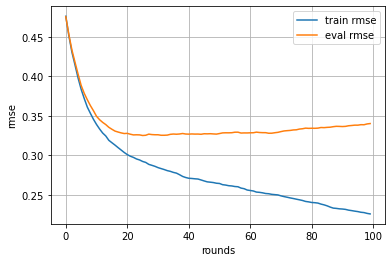

[0]	train-rmse:0.476197	eval-rmse:0.475638
[1]	train-rmse:0.451387	eval-rmse:0.452893
[2]	train-rmse:0.43056	eval-rmse:0.433271
[3]	train-rmse:0.414375	eval-rmse:0.417854
[4]	train-rmse:0.397851	eval-rmse:0.40285
[5]	train-rmse:0.383581	eval-rmse:0.388527
[6]	train-rmse:0.371964	eval-rmse:0.378507
[7]	train-rmse:0.36111	eval-rmse:0.370424
[8]	train-rmse:0.353209	eval-rmse:0.363004
[9]	train-rmse:0.345652	eval-rmse:0.356488
[10]	train-rmse:0.339069	eval-rmse:0.349391
[11]	train-rmse:0.33334	eval-rmse:0.345102
[12]	train-rmse:0.328226	eval-rmse:0.341719
[13]	train-rmse:0.32454	eval-rmse:0.338956
[14]	train-rmse:0.319008	eval-rmse:0.33548
[15]	train-rmse:0.315963	eval-rmse:0.33301
[16]	train-rmse:0.31299	eval-rmse:0.330706
[17]	train-rmse:0.309789	eval-rmse:0.329517
[18]	train-rmse:0.306716	eval-rmse:0.32843
[19]	train-rmse:0.303634	eval-rmse:0.327595
[20]	train-rmse:0.30094	eval-rmse:0.327844
[21]	train-rmse:0.298856	eval-rmse:0.326743
[22]	train-rmse:0.297381	eval-rmse:0.325874
[23]	tra

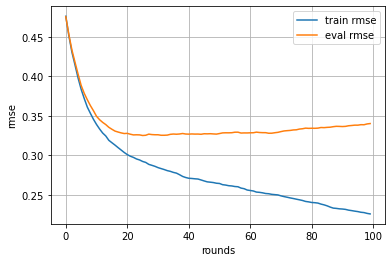

[0]	train-rmse:0.476197	eval-rmse:0.475638
[1]	train-rmse:0.451387	eval-rmse:0.452893
[2]	train-rmse:0.43056	eval-rmse:0.433271
[3]	train-rmse:0.414375	eval-rmse:0.417854
[4]	train-rmse:0.397851	eval-rmse:0.40285
[5]	train-rmse:0.383581	eval-rmse:0.388527
[6]	train-rmse:0.371964	eval-rmse:0.378507
[7]	train-rmse:0.36111	eval-rmse:0.370424
[8]	train-rmse:0.353209	eval-rmse:0.363004
[9]	train-rmse:0.345652	eval-rmse:0.356488
[10]	train-rmse:0.339069	eval-rmse:0.349391
[11]	train-rmse:0.333341	eval-rmse:0.345102
[12]	train-rmse:0.328226	eval-rmse:0.341719
[13]	train-rmse:0.32454	eval-rmse:0.338956
[14]	train-rmse:0.319008	eval-rmse:0.33548
[15]	train-rmse:0.315963	eval-rmse:0.33301
[16]	train-rmse:0.31299	eval-rmse:0.330706
[17]	train-rmse:0.309789	eval-rmse:0.329517
[18]	train-rmse:0.306716	eval-rmse:0.32843
[19]	train-rmse:0.303634	eval-rmse:0.327595
[20]	train-rmse:0.30094	eval-rmse:0.327844
[21]	train-rmse:0.298856	eval-rmse:0.326743
[22]	train-rmse:0.297381	eval-rmse:0.325874
[23]	tr

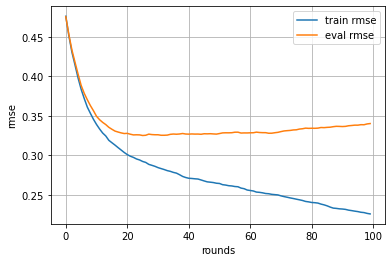

[0]	train-rmse:0.476197	eval-rmse:0.475638
[1]	train-rmse:0.451387	eval-rmse:0.452893
[2]	train-rmse:0.43056	eval-rmse:0.433271
[3]	train-rmse:0.414375	eval-rmse:0.417854
[4]	train-rmse:0.397851	eval-rmse:0.40285
[5]	train-rmse:0.383581	eval-rmse:0.388527
[6]	train-rmse:0.371964	eval-rmse:0.378507
[7]	train-rmse:0.36111	eval-rmse:0.370424
[8]	train-rmse:0.353209	eval-rmse:0.363004
[9]	train-rmse:0.345652	eval-rmse:0.356488
[10]	train-rmse:0.339069	eval-rmse:0.349391
[11]	train-rmse:0.33334	eval-rmse:0.345102
[12]	train-rmse:0.328226	eval-rmse:0.341719
[13]	train-rmse:0.32454	eval-rmse:0.338956
[14]	train-rmse:0.319008	eval-rmse:0.33548
[15]	train-rmse:0.315963	eval-rmse:0.33301
[16]	train-rmse:0.31299	eval-rmse:0.330706
[17]	train-rmse:0.309789	eval-rmse:0.329517
[18]	train-rmse:0.306716	eval-rmse:0.32843
[19]	train-rmse:0.303634	eval-rmse:0.327595
[20]	train-rmse:0.30094	eval-rmse:0.327844
[21]	train-rmse:0.298856	eval-rmse:0.326743
[22]	train-rmse:0.297381	eval-rmse:0.325874
[23]	tra

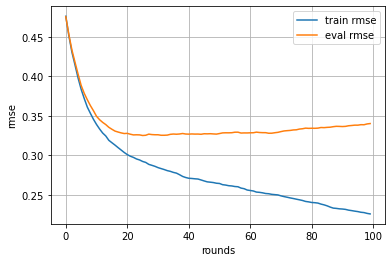

[0]	train-rmse:0.476197	eval-rmse:0.475638
[1]	train-rmse:0.451387	eval-rmse:0.452893
[2]	train-rmse:0.43056	eval-rmse:0.433271
[3]	train-rmse:0.414375	eval-rmse:0.417854
[4]	train-rmse:0.397851	eval-rmse:0.40285
[5]	train-rmse:0.383581	eval-rmse:0.388527
[6]	train-rmse:0.371964	eval-rmse:0.378507
[7]	train-rmse:0.36111	eval-rmse:0.370424
[8]	train-rmse:0.353209	eval-rmse:0.363004
[9]	train-rmse:0.345652	eval-rmse:0.356488
[10]	train-rmse:0.339069	eval-rmse:0.349391
[11]	train-rmse:0.33334	eval-rmse:0.345102
[12]	train-rmse:0.328226	eval-rmse:0.341719
[13]	train-rmse:0.32454	eval-rmse:0.338956
[14]	train-rmse:0.319008	eval-rmse:0.33548
[15]	train-rmse:0.315963	eval-rmse:0.33301
[16]	train-rmse:0.31299	eval-rmse:0.330706
[17]	train-rmse:0.309789	eval-rmse:0.329517
[18]	train-rmse:0.306716	eval-rmse:0.32843
[19]	train-rmse:0.303634	eval-rmse:0.327595
[20]	train-rmse:0.30094	eval-rmse:0.327844
[21]	train-rmse:0.298856	eval-rmse:0.326743
[22]	train-rmse:0.297381	eval-rmse:0.325874
[23]	tra

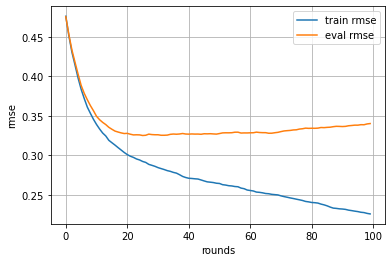

[0]	train-rmse:0.476506	eval-rmse:0.475679
[1]	train-rmse:0.452252	eval-rmse:0.453318
[2]	train-rmse:0.431873	eval-rmse:0.43414
[3]	train-rmse:0.41571	eval-rmse:0.417883
[4]	train-rmse:0.399116	eval-rmse:0.402637
[5]	train-rmse:0.385124	eval-rmse:0.388622
[6]	train-rmse:0.373507	eval-rmse:0.379267
[7]	train-rmse:0.362582	eval-rmse:0.370854
[8]	train-rmse:0.354868	eval-rmse:0.363129
[9]	train-rmse:0.347498	eval-rmse:0.356527
[10]	train-rmse:0.341292	eval-rmse:0.350366
[11]	train-rmse:0.33535	eval-rmse:0.346862
[12]	train-rmse:0.3302	eval-rmse:0.343464
[13]	train-rmse:0.326603	eval-rmse:0.340902
[14]	train-rmse:0.321561	eval-rmse:0.337936
[15]	train-rmse:0.318525	eval-rmse:0.335527
[16]	train-rmse:0.31574	eval-rmse:0.333708
[17]	train-rmse:0.312248	eval-rmse:0.332913
[18]	train-rmse:0.309445	eval-rmse:0.332027
[19]	train-rmse:0.305757	eval-rmse:0.330064
[20]	train-rmse:0.303206	eval-rmse:0.329805
[21]	train-rmse:0.301046	eval-rmse:0.328597
[22]	train-rmse:0.299547	eval-rmse:0.327876
[23]

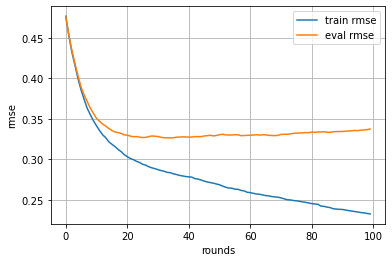

[0]	train-rmse:0.476506	eval-rmse:0.475679
[1]	train-rmse:0.452251	eval-rmse:0.453318
[2]	train-rmse:0.431873	eval-rmse:0.43414
[3]	train-rmse:0.41571	eval-rmse:0.417883
[4]	train-rmse:0.399116	eval-rmse:0.402637
[5]	train-rmse:0.385124	eval-rmse:0.388622
[6]	train-rmse:0.373507	eval-rmse:0.379267
[7]	train-rmse:0.362582	eval-rmse:0.370854
[8]	train-rmse:0.354868	eval-rmse:0.363129
[9]	train-rmse:0.347498	eval-rmse:0.356527
[10]	train-rmse:0.341292	eval-rmse:0.350366
[11]	train-rmse:0.33535	eval-rmse:0.346862
[12]	train-rmse:0.3302	eval-rmse:0.343464
[13]	train-rmse:0.326603	eval-rmse:0.340902
[14]	train-rmse:0.321561	eval-rmse:0.337936
[15]	train-rmse:0.318525	eval-rmse:0.335527
[16]	train-rmse:0.31574	eval-rmse:0.333708
[17]	train-rmse:0.312248	eval-rmse:0.332913
[18]	train-rmse:0.309445	eval-rmse:0.332027
[19]	train-rmse:0.305757	eval-rmse:0.330064
[20]	train-rmse:0.303206	eval-rmse:0.329805
[21]	train-rmse:0.301046	eval-rmse:0.328597
[22]	train-rmse:0.299547	eval-rmse:0.327876
[23]

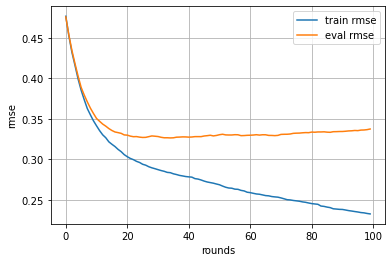

[0]	train-rmse:0.476506	eval-rmse:0.475679
[1]	train-rmse:0.452251	eval-rmse:0.453318
[2]	train-rmse:0.431873	eval-rmse:0.43414
[3]	train-rmse:0.41571	eval-rmse:0.417883
[4]	train-rmse:0.399116	eval-rmse:0.402637
[5]	train-rmse:0.385124	eval-rmse:0.388622
[6]	train-rmse:0.373507	eval-rmse:0.379267
[7]	train-rmse:0.362582	eval-rmse:0.370854
[8]	train-rmse:0.354868	eval-rmse:0.363129
[9]	train-rmse:0.347498	eval-rmse:0.356527
[10]	train-rmse:0.341292	eval-rmse:0.350366
[11]	train-rmse:0.33535	eval-rmse:0.346862
[12]	train-rmse:0.3302	eval-rmse:0.343464
[13]	train-rmse:0.326603	eval-rmse:0.340902
[14]	train-rmse:0.321561	eval-rmse:0.337936
[15]	train-rmse:0.318525	eval-rmse:0.335527
[16]	train-rmse:0.31574	eval-rmse:0.333708
[17]	train-rmse:0.312248	eval-rmse:0.332913
[18]	train-rmse:0.309445	eval-rmse:0.332027
[19]	train-rmse:0.305757	eval-rmse:0.330064
[20]	train-rmse:0.303206	eval-rmse:0.329805
[21]	train-rmse:0.301046	eval-rmse:0.328597
[22]	train-rmse:0.299547	eval-rmse:0.327876
[23]

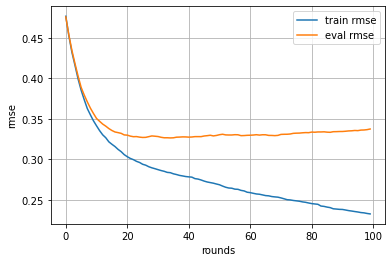

[0]	train-rmse:0.476506	eval-rmse:0.475679
[1]	train-rmse:0.452252	eval-rmse:0.453318
[2]	train-rmse:0.431873	eval-rmse:0.43414
[3]	train-rmse:0.41571	eval-rmse:0.417883
[4]	train-rmse:0.399116	eval-rmse:0.402637
[5]	train-rmse:0.385124	eval-rmse:0.388622
[6]	train-rmse:0.373507	eval-rmse:0.379267
[7]	train-rmse:0.362582	eval-rmse:0.370854
[8]	train-rmse:0.354868	eval-rmse:0.363129
[9]	train-rmse:0.347498	eval-rmse:0.356527
[10]	train-rmse:0.341292	eval-rmse:0.350366
[11]	train-rmse:0.33535	eval-rmse:0.346862
[12]	train-rmse:0.3302	eval-rmse:0.343464
[13]	train-rmse:0.326603	eval-rmse:0.340902
[14]	train-rmse:0.321561	eval-rmse:0.337936
[15]	train-rmse:0.318525	eval-rmse:0.335527
[16]	train-rmse:0.31574	eval-rmse:0.333708
[17]	train-rmse:0.312248	eval-rmse:0.332913
[18]	train-rmse:0.309445	eval-rmse:0.332027
[19]	train-rmse:0.305757	eval-rmse:0.330064
[20]	train-rmse:0.303206	eval-rmse:0.329805
[21]	train-rmse:0.301046	eval-rmse:0.328597
[22]	train-rmse:0.299547	eval-rmse:0.327876
[23]

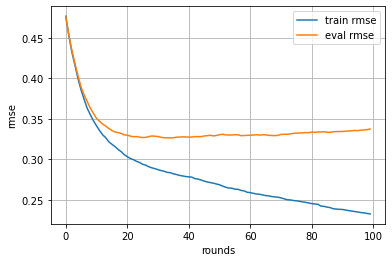

[0]	train-rmse:0.476506	eval-rmse:0.475679
[1]	train-rmse:0.452251	eval-rmse:0.453318
[2]	train-rmse:0.431873	eval-rmse:0.43414
[3]	train-rmse:0.41571	eval-rmse:0.417883
[4]	train-rmse:0.399116	eval-rmse:0.402637
[5]	train-rmse:0.385124	eval-rmse:0.388622
[6]	train-rmse:0.373507	eval-rmse:0.379267
[7]	train-rmse:0.362582	eval-rmse:0.370854
[8]	train-rmse:0.354868	eval-rmse:0.363129
[9]	train-rmse:0.347498	eval-rmse:0.356527
[10]	train-rmse:0.341292	eval-rmse:0.350366
[11]	train-rmse:0.33535	eval-rmse:0.346862
[12]	train-rmse:0.3302	eval-rmse:0.343464
[13]	train-rmse:0.326603	eval-rmse:0.340902
[14]	train-rmse:0.321561	eval-rmse:0.337936
[15]	train-rmse:0.318525	eval-rmse:0.335527
[16]	train-rmse:0.31574	eval-rmse:0.333708
[17]	train-rmse:0.312248	eval-rmse:0.332913
[18]	train-rmse:0.309445	eval-rmse:0.332027
[19]	train-rmse:0.305757	eval-rmse:0.330064
[20]	train-rmse:0.303206	eval-rmse:0.329805
[21]	train-rmse:0.301046	eval-rmse:0.328597
[22]	train-rmse:0.299547	eval-rmse:0.327876
[23]

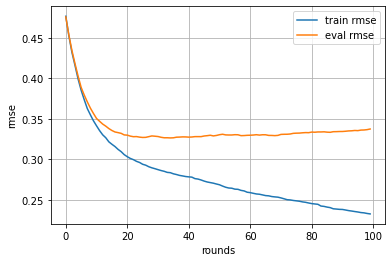

[0]	train-rmse:0.476506	eval-rmse:0.475679
[1]	train-rmse:0.452252	eval-rmse:0.453318
[2]	train-rmse:0.431873	eval-rmse:0.43414
[3]	train-rmse:0.41571	eval-rmse:0.417883
[4]	train-rmse:0.399116	eval-rmse:0.402637
[5]	train-rmse:0.385124	eval-rmse:0.388622
[6]	train-rmse:0.373507	eval-rmse:0.379267
[7]	train-rmse:0.362582	eval-rmse:0.370854
[8]	train-rmse:0.354868	eval-rmse:0.363129
[9]	train-rmse:0.347498	eval-rmse:0.356527
[10]	train-rmse:0.341292	eval-rmse:0.350366
[11]	train-rmse:0.33535	eval-rmse:0.346862
[12]	train-rmse:0.3302	eval-rmse:0.343464
[13]	train-rmse:0.326603	eval-rmse:0.340902
[14]	train-rmse:0.321561	eval-rmse:0.337936
[15]	train-rmse:0.318525	eval-rmse:0.335527
[16]	train-rmse:0.31574	eval-rmse:0.333708
[17]	train-rmse:0.312248	eval-rmse:0.332913
[18]	train-rmse:0.309445	eval-rmse:0.332027
[19]	train-rmse:0.305757	eval-rmse:0.330064
[20]	train-rmse:0.303206	eval-rmse:0.329805
[21]	train-rmse:0.301046	eval-rmse:0.328597
[22]	train-rmse:0.299547	eval-rmse:0.327876
[23]

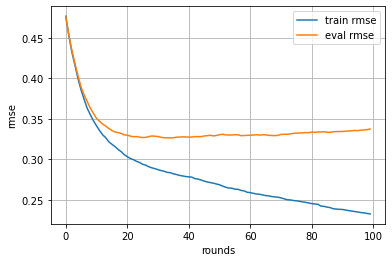

[0]	train-rmse:0.476506	eval-rmse:0.475679
[1]	train-rmse:0.452251	eval-rmse:0.453318
[2]	train-rmse:0.431873	eval-rmse:0.43414
[3]	train-rmse:0.41571	eval-rmse:0.417883
[4]	train-rmse:0.399116	eval-rmse:0.402637
[5]	train-rmse:0.385124	eval-rmse:0.388622
[6]	train-rmse:0.373507	eval-rmse:0.379267
[7]	train-rmse:0.362582	eval-rmse:0.370854
[8]	train-rmse:0.354868	eval-rmse:0.363129
[9]	train-rmse:0.347498	eval-rmse:0.356527
[10]	train-rmse:0.341292	eval-rmse:0.350366
[11]	train-rmse:0.33535	eval-rmse:0.346862
[12]	train-rmse:0.3302	eval-rmse:0.343464
[13]	train-rmse:0.326603	eval-rmse:0.340902
[14]	train-rmse:0.321561	eval-rmse:0.337936
[15]	train-rmse:0.318525	eval-rmse:0.335527
[16]	train-rmse:0.31574	eval-rmse:0.333708
[17]	train-rmse:0.312248	eval-rmse:0.332913
[18]	train-rmse:0.309445	eval-rmse:0.332027
[19]	train-rmse:0.305757	eval-rmse:0.330064
[20]	train-rmse:0.303206	eval-rmse:0.329805
[21]	train-rmse:0.301046	eval-rmse:0.328597
[22]	train-rmse:0.299547	eval-rmse:0.327876
[23]

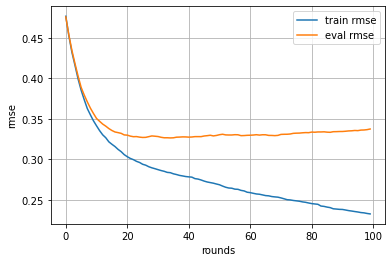

[0]	train-rmse:0.476506	eval-rmse:0.475679
[1]	train-rmse:0.452251	eval-rmse:0.453318
[2]	train-rmse:0.431873	eval-rmse:0.43414
[3]	train-rmse:0.41571	eval-rmse:0.417883
[4]	train-rmse:0.399116	eval-rmse:0.402637
[5]	train-rmse:0.385124	eval-rmse:0.388622
[6]	train-rmse:0.373507	eval-rmse:0.379267
[7]	train-rmse:0.362582	eval-rmse:0.370854
[8]	train-rmse:0.354868	eval-rmse:0.363129
[9]	train-rmse:0.347498	eval-rmse:0.356527
[10]	train-rmse:0.341292	eval-rmse:0.350366
[11]	train-rmse:0.33535	eval-rmse:0.346862
[12]	train-rmse:0.3302	eval-rmse:0.343464
[13]	train-rmse:0.326603	eval-rmse:0.340902
[14]	train-rmse:0.321561	eval-rmse:0.337936
[15]	train-rmse:0.318525	eval-rmse:0.335527
[16]	train-rmse:0.31574	eval-rmse:0.333708
[17]	train-rmse:0.312248	eval-rmse:0.332913
[18]	train-rmse:0.309445	eval-rmse:0.332027
[19]	train-rmse:0.305757	eval-rmse:0.330064
[20]	train-rmse:0.303206	eval-rmse:0.329805
[21]	train-rmse:0.301046	eval-rmse:0.328597
[22]	train-rmse:0.299547	eval-rmse:0.327876
[23]

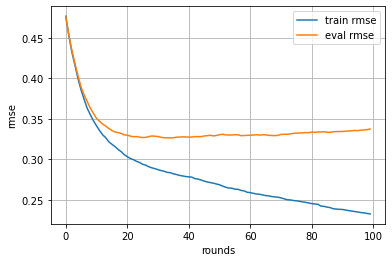

[0]	train-rmse:0.476506	eval-rmse:0.475679
[1]	train-rmse:0.452252	eval-rmse:0.453318
[2]	train-rmse:0.431873	eval-rmse:0.43414
[3]	train-rmse:0.41571	eval-rmse:0.417883
[4]	train-rmse:0.399116	eval-rmse:0.402637
[5]	train-rmse:0.385124	eval-rmse:0.388622
[6]	train-rmse:0.373507	eval-rmse:0.379267
[7]	train-rmse:0.362582	eval-rmse:0.370854
[8]	train-rmse:0.354868	eval-rmse:0.363129
[9]	train-rmse:0.347498	eval-rmse:0.356527
[10]	train-rmse:0.341292	eval-rmse:0.350366
[11]	train-rmse:0.33535	eval-rmse:0.346862
[12]	train-rmse:0.3302	eval-rmse:0.343464
[13]	train-rmse:0.326603	eval-rmse:0.340902
[14]	train-rmse:0.321561	eval-rmse:0.337936
[15]	train-rmse:0.318525	eval-rmse:0.335527
[16]	train-rmse:0.31574	eval-rmse:0.333708
[17]	train-rmse:0.312248	eval-rmse:0.332913
[18]	train-rmse:0.309445	eval-rmse:0.332027
[19]	train-rmse:0.305757	eval-rmse:0.330064
[20]	train-rmse:0.303206	eval-rmse:0.329805
[21]	train-rmse:0.301046	eval-rmse:0.328597
[22]	train-rmse:0.299547	eval-rmse:0.327876
[23]

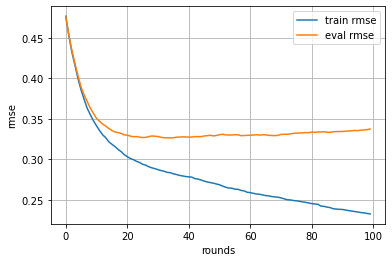

[0]	train-rmse:0.476506	eval-rmse:0.475679
[1]	train-rmse:0.452251	eval-rmse:0.453318
[2]	train-rmse:0.431873	eval-rmse:0.43414
[3]	train-rmse:0.41571	eval-rmse:0.417883
[4]	train-rmse:0.399116	eval-rmse:0.402637
[5]	train-rmse:0.385124	eval-rmse:0.388622
[6]	train-rmse:0.373507	eval-rmse:0.379267
[7]	train-rmse:0.362582	eval-rmse:0.370854
[8]	train-rmse:0.354868	eval-rmse:0.363129
[9]	train-rmse:0.347498	eval-rmse:0.356527
[10]	train-rmse:0.341292	eval-rmse:0.350366
[11]	train-rmse:0.33535	eval-rmse:0.346862
[12]	train-rmse:0.3302	eval-rmse:0.343464
[13]	train-rmse:0.326603	eval-rmse:0.340902
[14]	train-rmse:0.321561	eval-rmse:0.337936
[15]	train-rmse:0.318525	eval-rmse:0.335527
[16]	train-rmse:0.31574	eval-rmse:0.333708
[17]	train-rmse:0.312248	eval-rmse:0.332913
[18]	train-rmse:0.309445	eval-rmse:0.332027
[19]	train-rmse:0.305757	eval-rmse:0.330064
[20]	train-rmse:0.303206	eval-rmse:0.329805
[21]	train-rmse:0.301046	eval-rmse:0.328597
[22]	train-rmse:0.299547	eval-rmse:0.327876
[23]

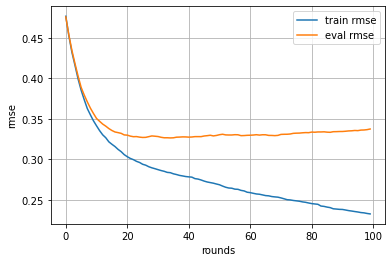

[0]	train-rmse:0.476665	eval-rmse:0.475493
[1]	train-rmse:0.452986	eval-rmse:0.452564
[2]	train-rmse:0.432664	eval-rmse:0.433527
[3]	train-rmse:0.416828	eval-rmse:0.417206
[4]	train-rmse:0.400368	eval-rmse:0.402054
[5]	train-rmse:0.386704	eval-rmse:0.388064
[6]	train-rmse:0.375192	eval-rmse:0.378471
[7]	train-rmse:0.364571	eval-rmse:0.370274
[8]	train-rmse:0.356264	eval-rmse:0.362645
[9]	train-rmse:0.349012	eval-rmse:0.355263
[10]	train-rmse:0.343161	eval-rmse:0.349455
[11]	train-rmse:0.337075	eval-rmse:0.346091
[12]	train-rmse:0.332052	eval-rmse:0.343373
[13]	train-rmse:0.328363	eval-rmse:0.340468
[14]	train-rmse:0.323645	eval-rmse:0.337736
[15]	train-rmse:0.320623	eval-rmse:0.335408
[16]	train-rmse:0.317628	eval-rmse:0.33428
[17]	train-rmse:0.31408	eval-rmse:0.333479
[18]	train-rmse:0.311288	eval-rmse:0.332568
[19]	train-rmse:0.307923	eval-rmse:0.33083
[20]	train-rmse:0.305281	eval-rmse:0.331351
[21]	train-rmse:0.302977	eval-rmse:0.330221
[22]	train-rmse:0.300926	eval-rmse:0.330028
[

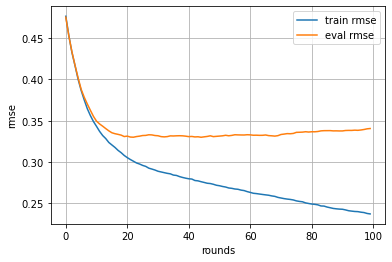

[0]	train-rmse:0.476665	eval-rmse:0.475493
[1]	train-rmse:0.452986	eval-rmse:0.452564
[2]	train-rmse:0.432664	eval-rmse:0.433527
[3]	train-rmse:0.416828	eval-rmse:0.417206
[4]	train-rmse:0.400368	eval-rmse:0.402054
[5]	train-rmse:0.386703	eval-rmse:0.388064
[6]	train-rmse:0.375192	eval-rmse:0.378471
[7]	train-rmse:0.364571	eval-rmse:0.370274
[8]	train-rmse:0.356264	eval-rmse:0.362645
[9]	train-rmse:0.349012	eval-rmse:0.355263
[10]	train-rmse:0.343161	eval-rmse:0.349455
[11]	train-rmse:0.337075	eval-rmse:0.346091
[12]	train-rmse:0.332052	eval-rmse:0.343373
[13]	train-rmse:0.328363	eval-rmse:0.340468
[14]	train-rmse:0.323645	eval-rmse:0.337736
[15]	train-rmse:0.320623	eval-rmse:0.335408
[16]	train-rmse:0.317628	eval-rmse:0.33428
[17]	train-rmse:0.31408	eval-rmse:0.333479
[18]	train-rmse:0.311288	eval-rmse:0.332568
[19]	train-rmse:0.307923	eval-rmse:0.33083
[20]	train-rmse:0.305281	eval-rmse:0.331351
[21]	train-rmse:0.302977	eval-rmse:0.330221
[22]	train-rmse:0.300926	eval-rmse:0.330028
[

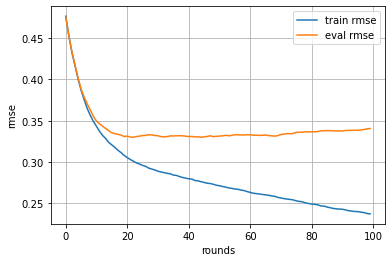

[0]	train-rmse:0.476665	eval-rmse:0.475493
[1]	train-rmse:0.452986	eval-rmse:0.452564
[2]	train-rmse:0.432664	eval-rmse:0.433527
[3]	train-rmse:0.416828	eval-rmse:0.417206
[4]	train-rmse:0.400368	eval-rmse:0.402054
[5]	train-rmse:0.386703	eval-rmse:0.388064
[6]	train-rmse:0.375192	eval-rmse:0.378471
[7]	train-rmse:0.364571	eval-rmse:0.370274
[8]	train-rmse:0.356264	eval-rmse:0.362645
[9]	train-rmse:0.349012	eval-rmse:0.355263
[10]	train-rmse:0.343161	eval-rmse:0.349455
[11]	train-rmse:0.337075	eval-rmse:0.346091
[12]	train-rmse:0.332052	eval-rmse:0.343373
[13]	train-rmse:0.328363	eval-rmse:0.340468
[14]	train-rmse:0.323645	eval-rmse:0.337736
[15]	train-rmse:0.320623	eval-rmse:0.335408
[16]	train-rmse:0.317628	eval-rmse:0.33428
[17]	train-rmse:0.31408	eval-rmse:0.333479
[18]	train-rmse:0.311288	eval-rmse:0.332568
[19]	train-rmse:0.307923	eval-rmse:0.33083
[20]	train-rmse:0.305281	eval-rmse:0.331351
[21]	train-rmse:0.302977	eval-rmse:0.330221
[22]	train-rmse:0.300926	eval-rmse:0.330028
[

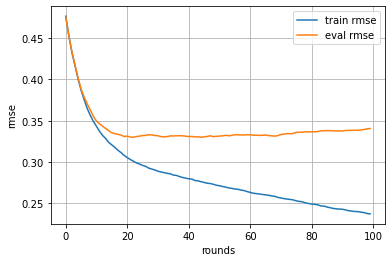

[0]	train-rmse:0.476665	eval-rmse:0.475493
[1]	train-rmse:0.452986	eval-rmse:0.452564
[2]	train-rmse:0.432664	eval-rmse:0.433527
[3]	train-rmse:0.416828	eval-rmse:0.417206
[4]	train-rmse:0.400368	eval-rmse:0.402054
[5]	train-rmse:0.386703	eval-rmse:0.388064
[6]	train-rmse:0.375192	eval-rmse:0.378471
[7]	train-rmse:0.364571	eval-rmse:0.370274
[8]	train-rmse:0.356264	eval-rmse:0.362645
[9]	train-rmse:0.349012	eval-rmse:0.355263
[10]	train-rmse:0.343161	eval-rmse:0.349455
[11]	train-rmse:0.337075	eval-rmse:0.346091
[12]	train-rmse:0.332052	eval-rmse:0.343373
[13]	train-rmse:0.328363	eval-rmse:0.340468
[14]	train-rmse:0.323645	eval-rmse:0.337736
[15]	train-rmse:0.320623	eval-rmse:0.335408
[16]	train-rmse:0.317628	eval-rmse:0.33428
[17]	train-rmse:0.31408	eval-rmse:0.333479
[18]	train-rmse:0.311288	eval-rmse:0.332568
[19]	train-rmse:0.307923	eval-rmse:0.33083
[20]	train-rmse:0.305281	eval-rmse:0.331351
[21]	train-rmse:0.302977	eval-rmse:0.330221
[22]	train-rmse:0.300926	eval-rmse:0.330028
[

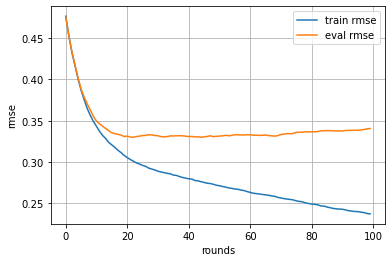

[0]	train-rmse:0.476665	eval-rmse:0.475493
[1]	train-rmse:0.452986	eval-rmse:0.452564
[2]	train-rmse:0.432664	eval-rmse:0.433527
[3]	train-rmse:0.416828	eval-rmse:0.417206
[4]	train-rmse:0.400368	eval-rmse:0.402054
[5]	train-rmse:0.386703	eval-rmse:0.388064
[6]	train-rmse:0.375192	eval-rmse:0.378471
[7]	train-rmse:0.364571	eval-rmse:0.370274
[8]	train-rmse:0.356264	eval-rmse:0.362645
[9]	train-rmse:0.349012	eval-rmse:0.355263
[10]	train-rmse:0.343161	eval-rmse:0.349455
[11]	train-rmse:0.337075	eval-rmse:0.346091
[12]	train-rmse:0.332052	eval-rmse:0.343373
[13]	train-rmse:0.328363	eval-rmse:0.340468
[14]	train-rmse:0.323645	eval-rmse:0.337736
[15]	train-rmse:0.320623	eval-rmse:0.335408
[16]	train-rmse:0.317628	eval-rmse:0.33428
[17]	train-rmse:0.31408	eval-rmse:0.333479
[18]	train-rmse:0.311288	eval-rmse:0.332568
[19]	train-rmse:0.307923	eval-rmse:0.33083
[20]	train-rmse:0.305281	eval-rmse:0.331351
[21]	train-rmse:0.302977	eval-rmse:0.330221
[22]	train-rmse:0.300926	eval-rmse:0.330028
[

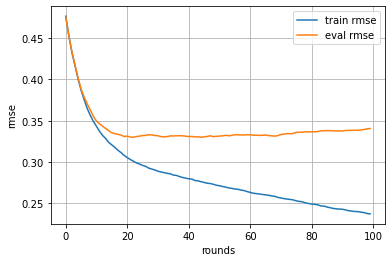

[0]	train-rmse:0.476665	eval-rmse:0.475493
[1]	train-rmse:0.452986	eval-rmse:0.452564
[2]	train-rmse:0.432664	eval-rmse:0.433527
[3]	train-rmse:0.416828	eval-rmse:0.417206
[4]	train-rmse:0.400368	eval-rmse:0.402054
[5]	train-rmse:0.386704	eval-rmse:0.388064
[6]	train-rmse:0.375192	eval-rmse:0.378471
[7]	train-rmse:0.364571	eval-rmse:0.370274
[8]	train-rmse:0.356264	eval-rmse:0.362645
[9]	train-rmse:0.349012	eval-rmse:0.355263
[10]	train-rmse:0.343161	eval-rmse:0.349455
[11]	train-rmse:0.337075	eval-rmse:0.346091
[12]	train-rmse:0.332052	eval-rmse:0.343373
[13]	train-rmse:0.328363	eval-rmse:0.340468
[14]	train-rmse:0.323645	eval-rmse:0.337736
[15]	train-rmse:0.320623	eval-rmse:0.335408
[16]	train-rmse:0.317628	eval-rmse:0.33428
[17]	train-rmse:0.31408	eval-rmse:0.333479
[18]	train-rmse:0.311288	eval-rmse:0.332568
[19]	train-rmse:0.307923	eval-rmse:0.33083
[20]	train-rmse:0.305281	eval-rmse:0.331351
[21]	train-rmse:0.302977	eval-rmse:0.330221
[22]	train-rmse:0.300926	eval-rmse:0.330028
[

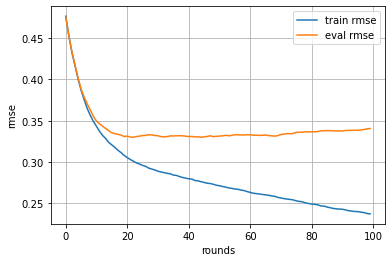

[0]	train-rmse:0.476665	eval-rmse:0.475493
[1]	train-rmse:0.452986	eval-rmse:0.452564
[2]	train-rmse:0.432664	eval-rmse:0.433527
[3]	train-rmse:0.416828	eval-rmse:0.417206
[4]	train-rmse:0.400368	eval-rmse:0.402054
[5]	train-rmse:0.386703	eval-rmse:0.388064
[6]	train-rmse:0.375192	eval-rmse:0.378471
[7]	train-rmse:0.364571	eval-rmse:0.370274
[8]	train-rmse:0.356264	eval-rmse:0.362645
[9]	train-rmse:0.349012	eval-rmse:0.355263
[10]	train-rmse:0.343161	eval-rmse:0.349455
[11]	train-rmse:0.337075	eval-rmse:0.346091
[12]	train-rmse:0.332052	eval-rmse:0.343373
[13]	train-rmse:0.328363	eval-rmse:0.340468
[14]	train-rmse:0.323645	eval-rmse:0.337736
[15]	train-rmse:0.320623	eval-rmse:0.335408
[16]	train-rmse:0.317628	eval-rmse:0.33428
[17]	train-rmse:0.31408	eval-rmse:0.333479
[18]	train-rmse:0.311288	eval-rmse:0.332568
[19]	train-rmse:0.307923	eval-rmse:0.33083
[20]	train-rmse:0.305281	eval-rmse:0.331351
[21]	train-rmse:0.302977	eval-rmse:0.330221
[22]	train-rmse:0.300926	eval-rmse:0.330028
[

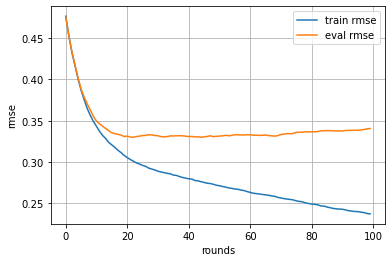

[0]	train-rmse:0.476665	eval-rmse:0.475493
[1]	train-rmse:0.452986	eval-rmse:0.452564
[2]	train-rmse:0.432664	eval-rmse:0.433527
[3]	train-rmse:0.416828	eval-rmse:0.417206
[4]	train-rmse:0.400368	eval-rmse:0.402054
[5]	train-rmse:0.386703	eval-rmse:0.388064
[6]	train-rmse:0.375192	eval-rmse:0.378471
[7]	train-rmse:0.364571	eval-rmse:0.370274
[8]	train-rmse:0.356264	eval-rmse:0.362645
[9]	train-rmse:0.349012	eval-rmse:0.355263
[10]	train-rmse:0.343161	eval-rmse:0.349455
[11]	train-rmse:0.337075	eval-rmse:0.346091
[12]	train-rmse:0.332052	eval-rmse:0.343373
[13]	train-rmse:0.328363	eval-rmse:0.340468
[14]	train-rmse:0.323645	eval-rmse:0.337736
[15]	train-rmse:0.320623	eval-rmse:0.335408
[16]	train-rmse:0.317628	eval-rmse:0.33428
[17]	train-rmse:0.31408	eval-rmse:0.333479
[18]	train-rmse:0.311288	eval-rmse:0.332568
[19]	train-rmse:0.307923	eval-rmse:0.33083
[20]	train-rmse:0.305281	eval-rmse:0.331351
[21]	train-rmse:0.302977	eval-rmse:0.330221
[22]	train-rmse:0.300926	eval-rmse:0.330028
[

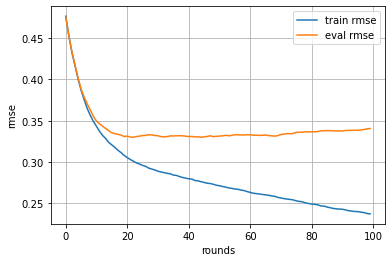

[0]	train-rmse:0.476665	eval-rmse:0.475493
[1]	train-rmse:0.452986	eval-rmse:0.452564
[2]	train-rmse:0.432664	eval-rmse:0.433527
[3]	train-rmse:0.416828	eval-rmse:0.417206
[4]	train-rmse:0.400368	eval-rmse:0.402054
[5]	train-rmse:0.386703	eval-rmse:0.388064
[6]	train-rmse:0.375192	eval-rmse:0.378471
[7]	train-rmse:0.364571	eval-rmse:0.370274
[8]	train-rmse:0.356264	eval-rmse:0.362645
[9]	train-rmse:0.349012	eval-rmse:0.355263
[10]	train-rmse:0.343161	eval-rmse:0.349455
[11]	train-rmse:0.337075	eval-rmse:0.346091
[12]	train-rmse:0.332052	eval-rmse:0.343373
[13]	train-rmse:0.328363	eval-rmse:0.340468
[14]	train-rmse:0.323645	eval-rmse:0.337736
[15]	train-rmse:0.320623	eval-rmse:0.335408
[16]	train-rmse:0.317628	eval-rmse:0.33428
[17]	train-rmse:0.31408	eval-rmse:0.333479
[18]	train-rmse:0.311288	eval-rmse:0.332568
[19]	train-rmse:0.307923	eval-rmse:0.33083
[20]	train-rmse:0.305281	eval-rmse:0.331351
[21]	train-rmse:0.302977	eval-rmse:0.330221
[22]	train-rmse:0.300926	eval-rmse:0.330028
[

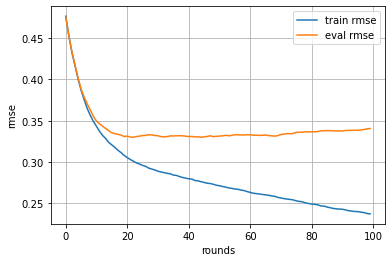

[0]	train-rmse:0.476665	eval-rmse:0.475493
[1]	train-rmse:0.452986	eval-rmse:0.452564
[2]	train-rmse:0.432664	eval-rmse:0.433527
[3]	train-rmse:0.416828	eval-rmse:0.417206
[4]	train-rmse:0.400368	eval-rmse:0.402054
[5]	train-rmse:0.386703	eval-rmse:0.388064
[6]	train-rmse:0.375192	eval-rmse:0.378471
[7]	train-rmse:0.364571	eval-rmse:0.370274
[8]	train-rmse:0.356264	eval-rmse:0.362645
[9]	train-rmse:0.349012	eval-rmse:0.355263
[10]	train-rmse:0.343161	eval-rmse:0.349455
[11]	train-rmse:0.337075	eval-rmse:0.346091
[12]	train-rmse:0.332052	eval-rmse:0.343373
[13]	train-rmse:0.328363	eval-rmse:0.340468
[14]	train-rmse:0.323645	eval-rmse:0.337736
[15]	train-rmse:0.320623	eval-rmse:0.335408
[16]	train-rmse:0.317628	eval-rmse:0.33428
[17]	train-rmse:0.31408	eval-rmse:0.333479
[18]	train-rmse:0.311288	eval-rmse:0.332568
[19]	train-rmse:0.307923	eval-rmse:0.33083
[20]	train-rmse:0.305281	eval-rmse:0.331351
[21]	train-rmse:0.302977	eval-rmse:0.330221
[22]	train-rmse:0.300926	eval-rmse:0.330028
[

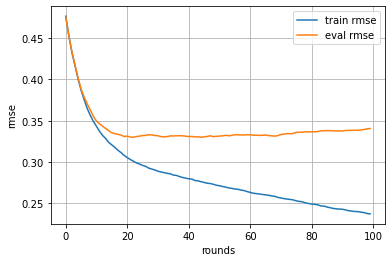

[0]	train-rmse:0.477052	eval-rmse:0.476104
[1]	train-rmse:0.453366	eval-rmse:0.452511
[2]	train-rmse:0.433429	eval-rmse:0.433673
[3]	train-rmse:0.418267	eval-rmse:0.417016
[4]	train-rmse:0.401931	eval-rmse:0.401807
[5]	train-rmse:0.388412	eval-rmse:0.388369
[6]	train-rmse:0.376246	eval-rmse:0.377895
[7]	train-rmse:0.365559	eval-rmse:0.369667
[8]	train-rmse:0.357641	eval-rmse:0.361947
[9]	train-rmse:0.35044	eval-rmse:0.35438
[10]	train-rmse:0.344583	eval-rmse:0.348762
[11]	train-rmse:0.33896	eval-rmse:0.345604
[12]	train-rmse:0.33376	eval-rmse:0.342197
[13]	train-rmse:0.330574	eval-rmse:0.340081
[14]	train-rmse:0.325905	eval-rmse:0.337897
[15]	train-rmse:0.323072	eval-rmse:0.335795
[16]	train-rmse:0.320384	eval-rmse:0.333773
[17]	train-rmse:0.316708	eval-rmse:0.332854
[18]	train-rmse:0.313968	eval-rmse:0.331809
[19]	train-rmse:0.311143	eval-rmse:0.330589
[20]	train-rmse:0.308832	eval-rmse:0.330698
[21]	train-rmse:0.306896	eval-rmse:0.329405
[22]	train-rmse:0.305149	eval-rmse:0.328966
[2

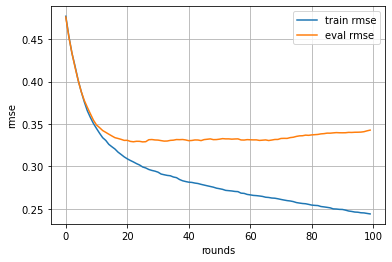

[0]	train-rmse:0.477052	eval-rmse:0.476104
[1]	train-rmse:0.453366	eval-rmse:0.452511
[2]	train-rmse:0.433429	eval-rmse:0.433673
[3]	train-rmse:0.418267	eval-rmse:0.417016
[4]	train-rmse:0.401931	eval-rmse:0.401807
[5]	train-rmse:0.388412	eval-rmse:0.388369
[6]	train-rmse:0.376246	eval-rmse:0.377895
[7]	train-rmse:0.365559	eval-rmse:0.369667
[8]	train-rmse:0.357641	eval-rmse:0.361947
[9]	train-rmse:0.35044	eval-rmse:0.35438
[10]	train-rmse:0.344583	eval-rmse:0.348762
[11]	train-rmse:0.33896	eval-rmse:0.345604
[12]	train-rmse:0.33376	eval-rmse:0.342197
[13]	train-rmse:0.330574	eval-rmse:0.340081
[14]	train-rmse:0.325905	eval-rmse:0.337897
[15]	train-rmse:0.323072	eval-rmse:0.335795
[16]	train-rmse:0.320384	eval-rmse:0.333773
[17]	train-rmse:0.316708	eval-rmse:0.332854
[18]	train-rmse:0.313968	eval-rmse:0.331809
[19]	train-rmse:0.311143	eval-rmse:0.330589
[20]	train-rmse:0.308832	eval-rmse:0.330698
[21]	train-rmse:0.306896	eval-rmse:0.329405
[22]	train-rmse:0.305149	eval-rmse:0.328966
[2

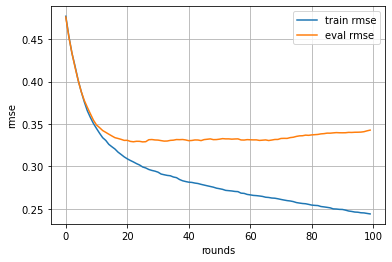

[0]	train-rmse:0.477052	eval-rmse:0.476104
[1]	train-rmse:0.453366	eval-rmse:0.452511
[2]	train-rmse:0.433429	eval-rmse:0.433673
[3]	train-rmse:0.418267	eval-rmse:0.417016
[4]	train-rmse:0.401931	eval-rmse:0.401807
[5]	train-rmse:0.388412	eval-rmse:0.388369
[6]	train-rmse:0.376246	eval-rmse:0.377895
[7]	train-rmse:0.365559	eval-rmse:0.369667
[8]	train-rmse:0.357641	eval-rmse:0.361947
[9]	train-rmse:0.35044	eval-rmse:0.35438
[10]	train-rmse:0.344583	eval-rmse:0.348762
[11]	train-rmse:0.33896	eval-rmse:0.345604
[12]	train-rmse:0.33376	eval-rmse:0.342197
[13]	train-rmse:0.330574	eval-rmse:0.340081
[14]	train-rmse:0.325905	eval-rmse:0.337897
[15]	train-rmse:0.323072	eval-rmse:0.335795
[16]	train-rmse:0.320384	eval-rmse:0.333773
[17]	train-rmse:0.316708	eval-rmse:0.332854
[18]	train-rmse:0.313968	eval-rmse:0.331809
[19]	train-rmse:0.311143	eval-rmse:0.330589
[20]	train-rmse:0.308832	eval-rmse:0.330698
[21]	train-rmse:0.306896	eval-rmse:0.329405
[22]	train-rmse:0.305149	eval-rmse:0.328966
[2

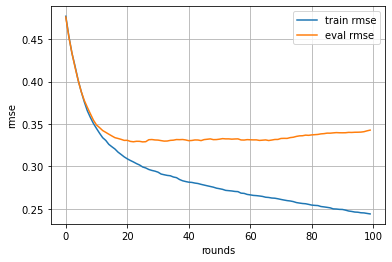

[0]	train-rmse:0.477052	eval-rmse:0.476104
[1]	train-rmse:0.453366	eval-rmse:0.452511
[2]	train-rmse:0.433429	eval-rmse:0.433673
[3]	train-rmse:0.418267	eval-rmse:0.417016
[4]	train-rmse:0.401931	eval-rmse:0.401807
[5]	train-rmse:0.388412	eval-rmse:0.388369
[6]	train-rmse:0.376246	eval-rmse:0.377895
[7]	train-rmse:0.365558	eval-rmse:0.369667
[8]	train-rmse:0.357641	eval-rmse:0.361947
[9]	train-rmse:0.35044	eval-rmse:0.35438
[10]	train-rmse:0.344583	eval-rmse:0.348762
[11]	train-rmse:0.33896	eval-rmse:0.345604
[12]	train-rmse:0.33376	eval-rmse:0.342197
[13]	train-rmse:0.330574	eval-rmse:0.340081
[14]	train-rmse:0.325905	eval-rmse:0.337897
[15]	train-rmse:0.323072	eval-rmse:0.335795
[16]	train-rmse:0.320384	eval-rmse:0.333773
[17]	train-rmse:0.316708	eval-rmse:0.332854
[18]	train-rmse:0.313968	eval-rmse:0.331809
[19]	train-rmse:0.311143	eval-rmse:0.330589
[20]	train-rmse:0.308832	eval-rmse:0.330698
[21]	train-rmse:0.306896	eval-rmse:0.329405
[22]	train-rmse:0.305149	eval-rmse:0.328966
[2

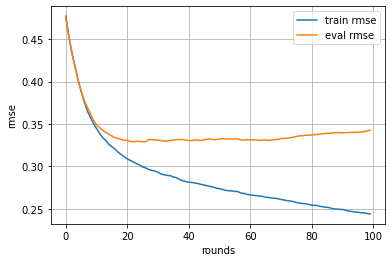

[0]	train-rmse:0.477052	eval-rmse:0.476104
[1]	train-rmse:0.453366	eval-rmse:0.452511
[2]	train-rmse:0.433429	eval-rmse:0.433673
[3]	train-rmse:0.418267	eval-rmse:0.417016
[4]	train-rmse:0.401931	eval-rmse:0.401807
[5]	train-rmse:0.388412	eval-rmse:0.388369
[6]	train-rmse:0.376246	eval-rmse:0.377895
[7]	train-rmse:0.365559	eval-rmse:0.369667
[8]	train-rmse:0.357641	eval-rmse:0.361947
[9]	train-rmse:0.35044	eval-rmse:0.35438
[10]	train-rmse:0.344583	eval-rmse:0.348762
[11]	train-rmse:0.33896	eval-rmse:0.345604
[12]	train-rmse:0.33376	eval-rmse:0.342197
[13]	train-rmse:0.330574	eval-rmse:0.340081
[14]	train-rmse:0.325905	eval-rmse:0.337897
[15]	train-rmse:0.323072	eval-rmse:0.335795
[16]	train-rmse:0.320384	eval-rmse:0.333773
[17]	train-rmse:0.316708	eval-rmse:0.332854
[18]	train-rmse:0.313968	eval-rmse:0.331809
[19]	train-rmse:0.311143	eval-rmse:0.330589
[20]	train-rmse:0.308832	eval-rmse:0.330698
[21]	train-rmse:0.306896	eval-rmse:0.329405
[22]	train-rmse:0.305149	eval-rmse:0.328966
[2

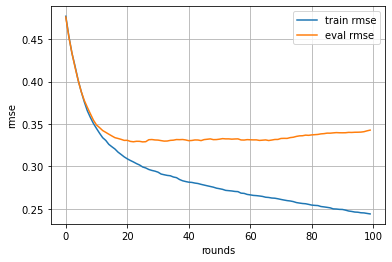

[0]	train-rmse:0.477052	eval-rmse:0.476104
[1]	train-rmse:0.453366	eval-rmse:0.452511
[2]	train-rmse:0.433429	eval-rmse:0.433673
[3]	train-rmse:0.418267	eval-rmse:0.417016
[4]	train-rmse:0.401931	eval-rmse:0.401807
[5]	train-rmse:0.388412	eval-rmse:0.388369
[6]	train-rmse:0.376246	eval-rmse:0.377895
[7]	train-rmse:0.365559	eval-rmse:0.369667
[8]	train-rmse:0.357641	eval-rmse:0.361947
[9]	train-rmse:0.35044	eval-rmse:0.35438
[10]	train-rmse:0.344583	eval-rmse:0.348762
[11]	train-rmse:0.33896	eval-rmse:0.345604
[12]	train-rmse:0.33376	eval-rmse:0.342197
[13]	train-rmse:0.330574	eval-rmse:0.340081
[14]	train-rmse:0.325905	eval-rmse:0.337897
[15]	train-rmse:0.323072	eval-rmse:0.335795
[16]	train-rmse:0.320384	eval-rmse:0.333773
[17]	train-rmse:0.316708	eval-rmse:0.332854
[18]	train-rmse:0.313968	eval-rmse:0.331809
[19]	train-rmse:0.311143	eval-rmse:0.330589
[20]	train-rmse:0.308832	eval-rmse:0.330698
[21]	train-rmse:0.306896	eval-rmse:0.329405
[22]	train-rmse:0.305149	eval-rmse:0.328966
[2

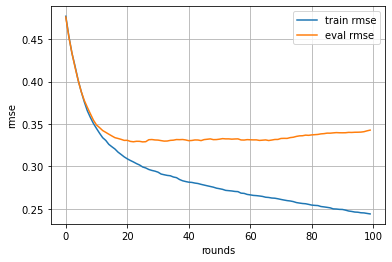

[0]	train-rmse:0.477052	eval-rmse:0.476104
[1]	train-rmse:0.453366	eval-rmse:0.452511
[2]	train-rmse:0.433429	eval-rmse:0.433673
[3]	train-rmse:0.418267	eval-rmse:0.417016
[4]	train-rmse:0.401931	eval-rmse:0.401807
[5]	train-rmse:0.388412	eval-rmse:0.388369
[6]	train-rmse:0.376246	eval-rmse:0.377895
[7]	train-rmse:0.365559	eval-rmse:0.369667
[8]	train-rmse:0.357641	eval-rmse:0.361947
[9]	train-rmse:0.35044	eval-rmse:0.35438
[10]	train-rmse:0.344583	eval-rmse:0.348762
[11]	train-rmse:0.33896	eval-rmse:0.345604
[12]	train-rmse:0.33376	eval-rmse:0.342197
[13]	train-rmse:0.330574	eval-rmse:0.340081
[14]	train-rmse:0.325905	eval-rmse:0.337897
[15]	train-rmse:0.323072	eval-rmse:0.335795
[16]	train-rmse:0.320384	eval-rmse:0.333773
[17]	train-rmse:0.316708	eval-rmse:0.332854
[18]	train-rmse:0.313968	eval-rmse:0.331809
[19]	train-rmse:0.311143	eval-rmse:0.330589
[20]	train-rmse:0.308832	eval-rmse:0.330698
[21]	train-rmse:0.306896	eval-rmse:0.329405
[22]	train-rmse:0.305149	eval-rmse:0.328966
[2

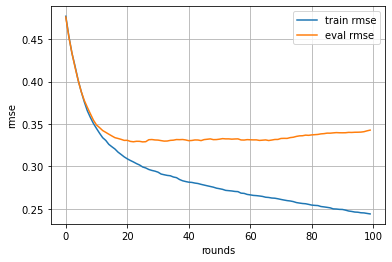

[0]	train-rmse:0.477052	eval-rmse:0.476104
[1]	train-rmse:0.453366	eval-rmse:0.452511
[2]	train-rmse:0.433429	eval-rmse:0.433673
[3]	train-rmse:0.418267	eval-rmse:0.417016
[4]	train-rmse:0.401931	eval-rmse:0.401807
[5]	train-rmse:0.388412	eval-rmse:0.388369
[6]	train-rmse:0.376246	eval-rmse:0.377895
[7]	train-rmse:0.365559	eval-rmse:0.369667
[8]	train-rmse:0.357641	eval-rmse:0.361947
[9]	train-rmse:0.35044	eval-rmse:0.35438
[10]	train-rmse:0.344583	eval-rmse:0.348762
[11]	train-rmse:0.33896	eval-rmse:0.345604
[12]	train-rmse:0.33376	eval-rmse:0.342197
[13]	train-rmse:0.330574	eval-rmse:0.340081
[14]	train-rmse:0.325905	eval-rmse:0.337897
[15]	train-rmse:0.323072	eval-rmse:0.335795
[16]	train-rmse:0.320384	eval-rmse:0.333773
[17]	train-rmse:0.316708	eval-rmse:0.332854
[18]	train-rmse:0.313968	eval-rmse:0.331809
[19]	train-rmse:0.311143	eval-rmse:0.330589
[20]	train-rmse:0.308832	eval-rmse:0.330698
[21]	train-rmse:0.306896	eval-rmse:0.329405
[22]	train-rmse:0.305149	eval-rmse:0.328966
[2

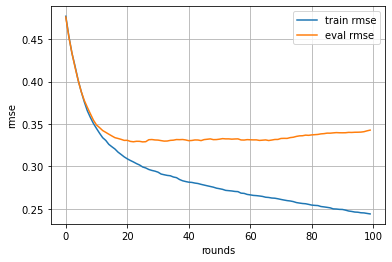

[0]	train-rmse:0.477052	eval-rmse:0.476104
[1]	train-rmse:0.453366	eval-rmse:0.452511
[2]	train-rmse:0.433429	eval-rmse:0.433673
[3]	train-rmse:0.418267	eval-rmse:0.417016
[4]	train-rmse:0.401931	eval-rmse:0.401807
[5]	train-rmse:0.388412	eval-rmse:0.388369
[6]	train-rmse:0.376246	eval-rmse:0.377895
[7]	train-rmse:0.365559	eval-rmse:0.369667
[8]	train-rmse:0.357641	eval-rmse:0.361947
[9]	train-rmse:0.35044	eval-rmse:0.35438
[10]	train-rmse:0.344583	eval-rmse:0.348762
[11]	train-rmse:0.33896	eval-rmse:0.345604
[12]	train-rmse:0.33376	eval-rmse:0.342197
[13]	train-rmse:0.330574	eval-rmse:0.340081
[14]	train-rmse:0.325905	eval-rmse:0.337897
[15]	train-rmse:0.323072	eval-rmse:0.335795
[16]	train-rmse:0.320384	eval-rmse:0.333773
[17]	train-rmse:0.316708	eval-rmse:0.332854
[18]	train-rmse:0.313968	eval-rmse:0.331809
[19]	train-rmse:0.311143	eval-rmse:0.330589
[20]	train-rmse:0.308832	eval-rmse:0.330698
[21]	train-rmse:0.306896	eval-rmse:0.329405
[22]	train-rmse:0.305149	eval-rmse:0.328966
[2

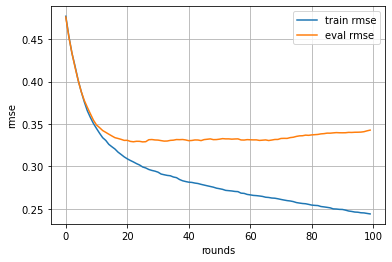

[0]	train-rmse:0.477052	eval-rmse:0.476104
[1]	train-rmse:0.453366	eval-rmse:0.452511
[2]	train-rmse:0.433429	eval-rmse:0.433673
[3]	train-rmse:0.418267	eval-rmse:0.417016
[4]	train-rmse:0.401931	eval-rmse:0.401807
[5]	train-rmse:0.388412	eval-rmse:0.388369
[6]	train-rmse:0.376246	eval-rmse:0.377895
[7]	train-rmse:0.365559	eval-rmse:0.369667
[8]	train-rmse:0.357641	eval-rmse:0.361947
[9]	train-rmse:0.35044	eval-rmse:0.35438
[10]	train-rmse:0.344583	eval-rmse:0.348762
[11]	train-rmse:0.33896	eval-rmse:0.345604
[12]	train-rmse:0.33376	eval-rmse:0.342197
[13]	train-rmse:0.330574	eval-rmse:0.340081
[14]	train-rmse:0.325905	eval-rmse:0.337897
[15]	train-rmse:0.323072	eval-rmse:0.335795
[16]	train-rmse:0.320384	eval-rmse:0.333773
[17]	train-rmse:0.316708	eval-rmse:0.332854
[18]	train-rmse:0.313968	eval-rmse:0.331809
[19]	train-rmse:0.311143	eval-rmse:0.330589
[20]	train-rmse:0.308832	eval-rmse:0.330698
[21]	train-rmse:0.306896	eval-rmse:0.329405
[22]	train-rmse:0.305149	eval-rmse:0.328966
[2

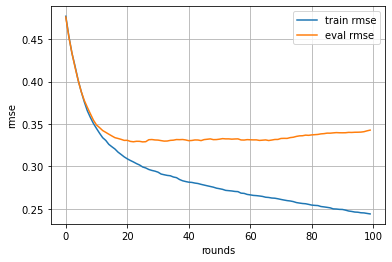

[0]	train-rmse:0.477052	eval-rmse:0.476104
[1]	train-rmse:0.454205	eval-rmse:0.454006
[2]	train-rmse:0.434832	eval-rmse:0.435879
[3]	train-rmse:0.419183	eval-rmse:0.419801
[4]	train-rmse:0.402765	eval-rmse:0.404563
[5]	train-rmse:0.388701	eval-rmse:0.390554
[6]	train-rmse:0.376602	eval-rmse:0.379884
[7]	train-rmse:0.366468	eval-rmse:0.372105
[8]	train-rmse:0.358851	eval-rmse:0.364556
[9]	train-rmse:0.351702	eval-rmse:0.357335
[10]	train-rmse:0.345854	eval-rmse:0.351556
[11]	train-rmse:0.339876	eval-rmse:0.347477
[12]	train-rmse:0.335113	eval-rmse:0.344192
[13]	train-rmse:0.331826	eval-rmse:0.341873
[14]	train-rmse:0.328229	eval-rmse:0.3391
[15]	train-rmse:0.325426	eval-rmse:0.336901
[16]	train-rmse:0.322991	eval-rmse:0.335111
[17]	train-rmse:0.319729	eval-rmse:0.334105
[18]	train-rmse:0.316686	eval-rmse:0.333156
[19]	train-rmse:0.313059	eval-rmse:0.331271
[20]	train-rmse:0.310854	eval-rmse:0.33093
[21]	train-rmse:0.309427	eval-rmse:0.330443
[22]	train-rmse:0.307656	eval-rmse:0.329701
[

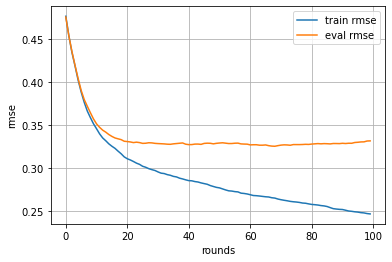

[0]	train-rmse:0.477052	eval-rmse:0.476104
[1]	train-rmse:0.454205	eval-rmse:0.454006
[2]	train-rmse:0.434832	eval-rmse:0.435879
[3]	train-rmse:0.419183	eval-rmse:0.419801
[4]	train-rmse:0.402765	eval-rmse:0.404563
[5]	train-rmse:0.388701	eval-rmse:0.390554
[6]	train-rmse:0.376602	eval-rmse:0.379884
[7]	train-rmse:0.366468	eval-rmse:0.372105
[8]	train-rmse:0.358851	eval-rmse:0.364556
[9]	train-rmse:0.351702	eval-rmse:0.357335
[10]	train-rmse:0.345854	eval-rmse:0.351556
[11]	train-rmse:0.339876	eval-rmse:0.347477
[12]	train-rmse:0.335113	eval-rmse:0.344192
[13]	train-rmse:0.331826	eval-rmse:0.341873
[14]	train-rmse:0.328229	eval-rmse:0.3391
[15]	train-rmse:0.325426	eval-rmse:0.336901
[16]	train-rmse:0.322991	eval-rmse:0.335111
[17]	train-rmse:0.319729	eval-rmse:0.334105
[18]	train-rmse:0.316686	eval-rmse:0.333156
[19]	train-rmse:0.313059	eval-rmse:0.331271
[20]	train-rmse:0.310854	eval-rmse:0.33093
[21]	train-rmse:0.309427	eval-rmse:0.330443
[22]	train-rmse:0.307656	eval-rmse:0.329701
[

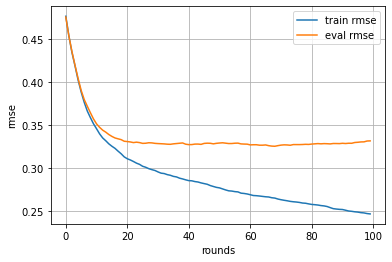

[0]	train-rmse:0.477052	eval-rmse:0.476104
[1]	train-rmse:0.454205	eval-rmse:0.454006
[2]	train-rmse:0.434832	eval-rmse:0.435879
[3]	train-rmse:0.419183	eval-rmse:0.419801
[4]	train-rmse:0.402765	eval-rmse:0.404563
[5]	train-rmse:0.388701	eval-rmse:0.390554
[6]	train-rmse:0.376602	eval-rmse:0.379884
[7]	train-rmse:0.366468	eval-rmse:0.372105
[8]	train-rmse:0.358851	eval-rmse:0.364556
[9]	train-rmse:0.351702	eval-rmse:0.357335
[10]	train-rmse:0.345854	eval-rmse:0.351556
[11]	train-rmse:0.339876	eval-rmse:0.347477
[12]	train-rmse:0.335113	eval-rmse:0.344192
[13]	train-rmse:0.331826	eval-rmse:0.341873
[14]	train-rmse:0.328229	eval-rmse:0.3391
[15]	train-rmse:0.325426	eval-rmse:0.336901
[16]	train-rmse:0.322991	eval-rmse:0.335111
[17]	train-rmse:0.319729	eval-rmse:0.334105
[18]	train-rmse:0.316686	eval-rmse:0.333156
[19]	train-rmse:0.313059	eval-rmse:0.331271
[20]	train-rmse:0.310854	eval-rmse:0.33093
[21]	train-rmse:0.309427	eval-rmse:0.330443
[22]	train-rmse:0.307656	eval-rmse:0.329701
[

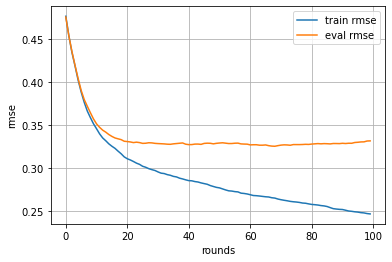

[0]	train-rmse:0.477052	eval-rmse:0.476104
[1]	train-rmse:0.454205	eval-rmse:0.454006
[2]	train-rmse:0.434832	eval-rmse:0.435879
[3]	train-rmse:0.419183	eval-rmse:0.419801
[4]	train-rmse:0.402765	eval-rmse:0.404563
[5]	train-rmse:0.388701	eval-rmse:0.390554
[6]	train-rmse:0.376602	eval-rmse:0.379884
[7]	train-rmse:0.366468	eval-rmse:0.372105
[8]	train-rmse:0.358851	eval-rmse:0.364556
[9]	train-rmse:0.351702	eval-rmse:0.357335
[10]	train-rmse:0.345854	eval-rmse:0.351556
[11]	train-rmse:0.339876	eval-rmse:0.347477
[12]	train-rmse:0.335113	eval-rmse:0.344192
[13]	train-rmse:0.331826	eval-rmse:0.341873
[14]	train-rmse:0.328229	eval-rmse:0.3391
[15]	train-rmse:0.325426	eval-rmse:0.336901
[16]	train-rmse:0.322991	eval-rmse:0.335111
[17]	train-rmse:0.319729	eval-rmse:0.334105
[18]	train-rmse:0.316686	eval-rmse:0.333156
[19]	train-rmse:0.313059	eval-rmse:0.331271
[20]	train-rmse:0.310854	eval-rmse:0.33093
[21]	train-rmse:0.309427	eval-rmse:0.330443
[22]	train-rmse:0.307656	eval-rmse:0.329701
[

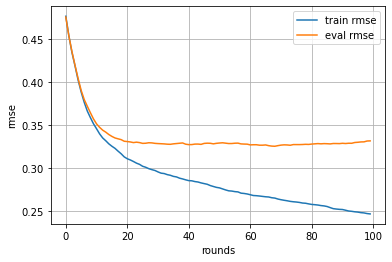

[0]	train-rmse:0.477052	eval-rmse:0.476104
[1]	train-rmse:0.454205	eval-rmse:0.454006
[2]	train-rmse:0.434832	eval-rmse:0.435879
[3]	train-rmse:0.419183	eval-rmse:0.419801
[4]	train-rmse:0.402765	eval-rmse:0.404563
[5]	train-rmse:0.388701	eval-rmse:0.390554
[6]	train-rmse:0.376602	eval-rmse:0.379884
[7]	train-rmse:0.366468	eval-rmse:0.372105
[8]	train-rmse:0.358851	eval-rmse:0.364556
[9]	train-rmse:0.351702	eval-rmse:0.357335
[10]	train-rmse:0.345854	eval-rmse:0.351556
[11]	train-rmse:0.339876	eval-rmse:0.347477
[12]	train-rmse:0.335113	eval-rmse:0.344192
[13]	train-rmse:0.331826	eval-rmse:0.341873
[14]	train-rmse:0.328229	eval-rmse:0.3391
[15]	train-rmse:0.325426	eval-rmse:0.336901
[16]	train-rmse:0.322991	eval-rmse:0.335111
[17]	train-rmse:0.319729	eval-rmse:0.334105
[18]	train-rmse:0.316686	eval-rmse:0.333156
[19]	train-rmse:0.313059	eval-rmse:0.331271
[20]	train-rmse:0.310854	eval-rmse:0.33093
[21]	train-rmse:0.309427	eval-rmse:0.330443
[22]	train-rmse:0.307656	eval-rmse:0.329701
[

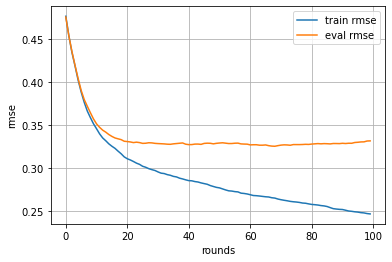

[0]	train-rmse:0.477052	eval-rmse:0.476104
[1]	train-rmse:0.454205	eval-rmse:0.454006
[2]	train-rmse:0.434832	eval-rmse:0.435879
[3]	train-rmse:0.419183	eval-rmse:0.419801
[4]	train-rmse:0.402765	eval-rmse:0.404563
[5]	train-rmse:0.388701	eval-rmse:0.390554
[6]	train-rmse:0.376602	eval-rmse:0.379884
[7]	train-rmse:0.366468	eval-rmse:0.372105
[8]	train-rmse:0.358851	eval-rmse:0.364556
[9]	train-rmse:0.351702	eval-rmse:0.357335
[10]	train-rmse:0.345854	eval-rmse:0.351556
[11]	train-rmse:0.339876	eval-rmse:0.347477
[12]	train-rmse:0.335113	eval-rmse:0.344192
[13]	train-rmse:0.331826	eval-rmse:0.341873
[14]	train-rmse:0.328229	eval-rmse:0.3391
[15]	train-rmse:0.325426	eval-rmse:0.336901
[16]	train-rmse:0.322991	eval-rmse:0.335111
[17]	train-rmse:0.319729	eval-rmse:0.334105
[18]	train-rmse:0.316686	eval-rmse:0.333156
[19]	train-rmse:0.313059	eval-rmse:0.331271
[20]	train-rmse:0.310854	eval-rmse:0.33093
[21]	train-rmse:0.309427	eval-rmse:0.330443
[22]	train-rmse:0.307656	eval-rmse:0.329701
[

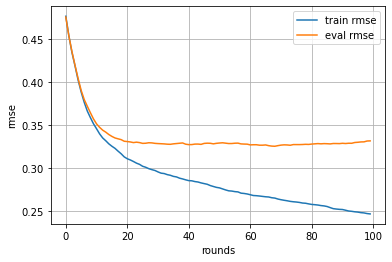

[0]	train-rmse:0.477052	eval-rmse:0.476104
[1]	train-rmse:0.454205	eval-rmse:0.454006
[2]	train-rmse:0.434832	eval-rmse:0.435879
[3]	train-rmse:0.419183	eval-rmse:0.419801
[4]	train-rmse:0.402765	eval-rmse:0.404563
[5]	train-rmse:0.388701	eval-rmse:0.390554
[6]	train-rmse:0.376602	eval-rmse:0.379884
[7]	train-rmse:0.366468	eval-rmse:0.372105
[8]	train-rmse:0.358851	eval-rmse:0.364556
[9]	train-rmse:0.351702	eval-rmse:0.357335
[10]	train-rmse:0.345854	eval-rmse:0.351556
[11]	train-rmse:0.339876	eval-rmse:0.347477
[12]	train-rmse:0.335113	eval-rmse:0.344192
[13]	train-rmse:0.331826	eval-rmse:0.341873
[14]	train-rmse:0.328229	eval-rmse:0.3391
[15]	train-rmse:0.325426	eval-rmse:0.336901
[16]	train-rmse:0.322991	eval-rmse:0.335111
[17]	train-rmse:0.319729	eval-rmse:0.334105
[18]	train-rmse:0.316686	eval-rmse:0.333156
[19]	train-rmse:0.313059	eval-rmse:0.331271
[20]	train-rmse:0.310854	eval-rmse:0.33093
[21]	train-rmse:0.309427	eval-rmse:0.330443
[22]	train-rmse:0.307656	eval-rmse:0.329701
[

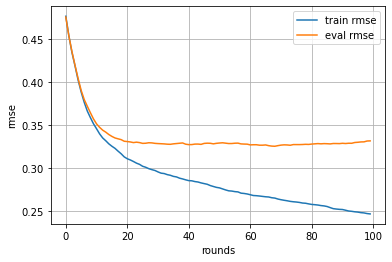

[0]	train-rmse:0.477052	eval-rmse:0.476104
[1]	train-rmse:0.454205	eval-rmse:0.454006
[2]	train-rmse:0.434832	eval-rmse:0.435879
[3]	train-rmse:0.419183	eval-rmse:0.419801
[4]	train-rmse:0.402765	eval-rmse:0.404563
[5]	train-rmse:0.388701	eval-rmse:0.390554
[6]	train-rmse:0.376602	eval-rmse:0.379884
[7]	train-rmse:0.366468	eval-rmse:0.372105
[8]	train-rmse:0.358851	eval-rmse:0.364556
[9]	train-rmse:0.351702	eval-rmse:0.357335
[10]	train-rmse:0.345854	eval-rmse:0.351556
[11]	train-rmse:0.339876	eval-rmse:0.347477
[12]	train-rmse:0.335113	eval-rmse:0.344192
[13]	train-rmse:0.331826	eval-rmse:0.341873
[14]	train-rmse:0.328229	eval-rmse:0.3391
[15]	train-rmse:0.325426	eval-rmse:0.336901
[16]	train-rmse:0.322991	eval-rmse:0.335111
[17]	train-rmse:0.319729	eval-rmse:0.334105
[18]	train-rmse:0.316686	eval-rmse:0.333156
[19]	train-rmse:0.313059	eval-rmse:0.331271
[20]	train-rmse:0.310854	eval-rmse:0.33093
[21]	train-rmse:0.309427	eval-rmse:0.330443
[22]	train-rmse:0.307656	eval-rmse:0.329701
[

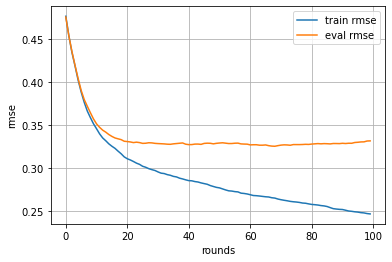

[0]	train-rmse:0.477052	eval-rmse:0.476104
[1]	train-rmse:0.454205	eval-rmse:0.454006
[2]	train-rmse:0.434832	eval-rmse:0.435879
[3]	train-rmse:0.419183	eval-rmse:0.419801
[4]	train-rmse:0.402765	eval-rmse:0.404563
[5]	train-rmse:0.388701	eval-rmse:0.390554
[6]	train-rmse:0.376602	eval-rmse:0.379884
[7]	train-rmse:0.366468	eval-rmse:0.372105
[8]	train-rmse:0.358851	eval-rmse:0.364556
[9]	train-rmse:0.351702	eval-rmse:0.357335
[10]	train-rmse:0.345854	eval-rmse:0.351556
[11]	train-rmse:0.339876	eval-rmse:0.347477
[12]	train-rmse:0.335113	eval-rmse:0.344192
[13]	train-rmse:0.331826	eval-rmse:0.341873
[14]	train-rmse:0.328229	eval-rmse:0.3391
[15]	train-rmse:0.325426	eval-rmse:0.336901
[16]	train-rmse:0.322991	eval-rmse:0.335111
[17]	train-rmse:0.319729	eval-rmse:0.334105
[18]	train-rmse:0.316686	eval-rmse:0.333156
[19]	train-rmse:0.313059	eval-rmse:0.331271
[20]	train-rmse:0.310854	eval-rmse:0.33093
[21]	train-rmse:0.309427	eval-rmse:0.330443
[22]	train-rmse:0.307656	eval-rmse:0.329701
[

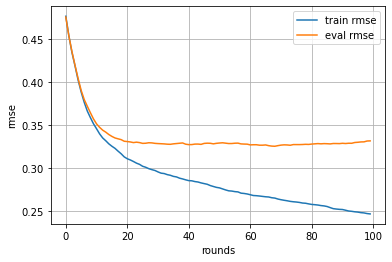

[0]	train-rmse:0.477052	eval-rmse:0.476104
[1]	train-rmse:0.454205	eval-rmse:0.454006
[2]	train-rmse:0.434832	eval-rmse:0.435879
[3]	train-rmse:0.419183	eval-rmse:0.419801
[4]	train-rmse:0.402765	eval-rmse:0.404563
[5]	train-rmse:0.388701	eval-rmse:0.390554
[6]	train-rmse:0.376602	eval-rmse:0.379884
[7]	train-rmse:0.366468	eval-rmse:0.372105
[8]	train-rmse:0.358851	eval-rmse:0.364556
[9]	train-rmse:0.351702	eval-rmse:0.357335
[10]	train-rmse:0.345854	eval-rmse:0.351556
[11]	train-rmse:0.339876	eval-rmse:0.347477
[12]	train-rmse:0.335113	eval-rmse:0.344192
[13]	train-rmse:0.331826	eval-rmse:0.341873
[14]	train-rmse:0.328229	eval-rmse:0.3391
[15]	train-rmse:0.325426	eval-rmse:0.336901
[16]	train-rmse:0.322991	eval-rmse:0.335111
[17]	train-rmse:0.319729	eval-rmse:0.334105
[18]	train-rmse:0.316686	eval-rmse:0.333156
[19]	train-rmse:0.313059	eval-rmse:0.331271
[20]	train-rmse:0.310854	eval-rmse:0.33093
[21]	train-rmse:0.309427	eval-rmse:0.330443
[22]	train-rmse:0.307656	eval-rmse:0.329701
[

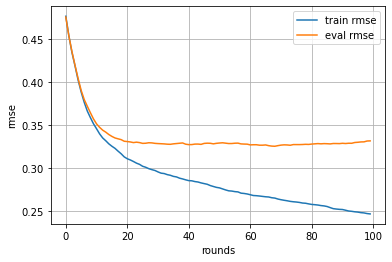

[0]	train-rmse:0.476703	eval-rmse:0.476339
[1]	train-rmse:0.453889	eval-rmse:0.45472
[2]	train-rmse:0.434592	eval-rmse:0.436434
[3]	train-rmse:0.419586	eval-rmse:0.420644
[4]	train-rmse:0.403472	eval-rmse:0.405719
[5]	train-rmse:0.390349	eval-rmse:0.392376
[6]	train-rmse:0.378346	eval-rmse:0.381725
[7]	train-rmse:0.368737	eval-rmse:0.373994
[8]	train-rmse:0.361357	eval-rmse:0.366853
[9]	train-rmse:0.35453	eval-rmse:0.359778
[10]	train-rmse:0.348382	eval-rmse:0.35401
[11]	train-rmse:0.342721	eval-rmse:0.349577
[12]	train-rmse:0.338009	eval-rmse:0.346215
[13]	train-rmse:0.334738	eval-rmse:0.344098
[14]	train-rmse:0.330398	eval-rmse:0.340513
[15]	train-rmse:0.327711	eval-rmse:0.338356
[16]	train-rmse:0.325216	eval-rmse:0.336194
[17]	train-rmse:0.32243	eval-rmse:0.335475
[18]	train-rmse:0.319966	eval-rmse:0.334551
[19]	train-rmse:0.317235	eval-rmse:0.33277
[20]	train-rmse:0.314995	eval-rmse:0.332208
[21]	train-rmse:0.312766	eval-rmse:0.329777
[22]	train-rmse:0.311065	eval-rmse:0.328819
[23

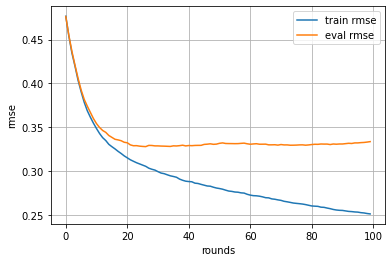

[0]	train-rmse:0.476703	eval-rmse:0.476339
[1]	train-rmse:0.453889	eval-rmse:0.45472
[2]	train-rmse:0.434592	eval-rmse:0.436434
[3]	train-rmse:0.419586	eval-rmse:0.420643
[4]	train-rmse:0.403472	eval-rmse:0.405719
[5]	train-rmse:0.390349	eval-rmse:0.392376
[6]	train-rmse:0.378346	eval-rmse:0.381725
[7]	train-rmse:0.368737	eval-rmse:0.373994
[8]	train-rmse:0.361357	eval-rmse:0.366853
[9]	train-rmse:0.35453	eval-rmse:0.359778
[10]	train-rmse:0.348382	eval-rmse:0.35401
[11]	train-rmse:0.342721	eval-rmse:0.349577
[12]	train-rmse:0.338009	eval-rmse:0.346215
[13]	train-rmse:0.334738	eval-rmse:0.344098
[14]	train-rmse:0.330398	eval-rmse:0.340513
[15]	train-rmse:0.327711	eval-rmse:0.338356
[16]	train-rmse:0.325216	eval-rmse:0.336194
[17]	train-rmse:0.32243	eval-rmse:0.335475
[18]	train-rmse:0.319966	eval-rmse:0.334551
[19]	train-rmse:0.317235	eval-rmse:0.33277
[20]	train-rmse:0.314995	eval-rmse:0.332208
[21]	train-rmse:0.312766	eval-rmse:0.329777
[22]	train-rmse:0.311065	eval-rmse:0.328819
[23

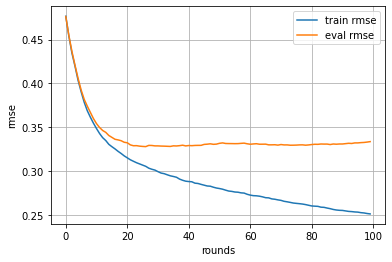

[0]	train-rmse:0.476703	eval-rmse:0.476339
[1]	train-rmse:0.453889	eval-rmse:0.45472
[2]	train-rmse:0.434592	eval-rmse:0.436434
[3]	train-rmse:0.419586	eval-rmse:0.420643
[4]	train-rmse:0.403472	eval-rmse:0.405719
[5]	train-rmse:0.390349	eval-rmse:0.392376
[6]	train-rmse:0.378346	eval-rmse:0.381725
[7]	train-rmse:0.368737	eval-rmse:0.373994
[8]	train-rmse:0.361357	eval-rmse:0.366853
[9]	train-rmse:0.35453	eval-rmse:0.359778
[10]	train-rmse:0.348382	eval-rmse:0.35401
[11]	train-rmse:0.342721	eval-rmse:0.349577
[12]	train-rmse:0.338009	eval-rmse:0.346215
[13]	train-rmse:0.334738	eval-rmse:0.344098
[14]	train-rmse:0.330398	eval-rmse:0.340513
[15]	train-rmse:0.327711	eval-rmse:0.338356
[16]	train-rmse:0.325216	eval-rmse:0.336194
[17]	train-rmse:0.32243	eval-rmse:0.335475
[18]	train-rmse:0.319966	eval-rmse:0.334551
[19]	train-rmse:0.317235	eval-rmse:0.33277
[20]	train-rmse:0.314995	eval-rmse:0.332208
[21]	train-rmse:0.312766	eval-rmse:0.329777
[22]	train-rmse:0.311065	eval-rmse:0.328819
[23

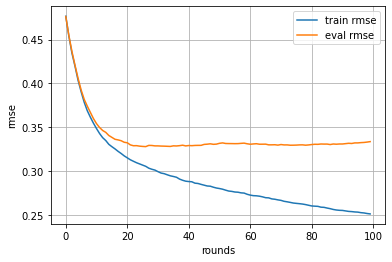

[0]	train-rmse:0.476703	eval-rmse:0.476339
[1]	train-rmse:0.453889	eval-rmse:0.45472
[2]	train-rmse:0.434592	eval-rmse:0.436434
[3]	train-rmse:0.419586	eval-rmse:0.420643
[4]	train-rmse:0.403472	eval-rmse:0.405719
[5]	train-rmse:0.390349	eval-rmse:0.392376
[6]	train-rmse:0.378346	eval-rmse:0.381725
[7]	train-rmse:0.368737	eval-rmse:0.373994
[8]	train-rmse:0.361357	eval-rmse:0.366853
[9]	train-rmse:0.35453	eval-rmse:0.359778
[10]	train-rmse:0.348382	eval-rmse:0.35401
[11]	train-rmse:0.342721	eval-rmse:0.349577
[12]	train-rmse:0.338009	eval-rmse:0.346215
[13]	train-rmse:0.334738	eval-rmse:0.344098
[14]	train-rmse:0.330398	eval-rmse:0.340513
[15]	train-rmse:0.327711	eval-rmse:0.338356
[16]	train-rmse:0.325216	eval-rmse:0.336194
[17]	train-rmse:0.32243	eval-rmse:0.335475
[18]	train-rmse:0.319966	eval-rmse:0.334551
[19]	train-rmse:0.317235	eval-rmse:0.33277
[20]	train-rmse:0.314995	eval-rmse:0.332208
[21]	train-rmse:0.312766	eval-rmse:0.329777
[22]	train-rmse:0.311065	eval-rmse:0.328819
[23

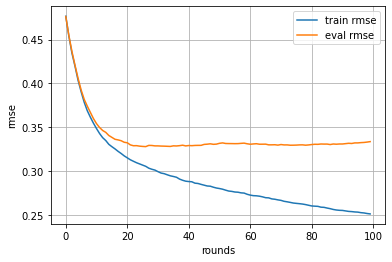

[0]	train-rmse:0.476703	eval-rmse:0.476339
[1]	train-rmse:0.453889	eval-rmse:0.45472
[2]	train-rmse:0.434592	eval-rmse:0.436434
[3]	train-rmse:0.419586	eval-rmse:0.420643
[4]	train-rmse:0.403472	eval-rmse:0.405719
[5]	train-rmse:0.390349	eval-rmse:0.392376
[6]	train-rmse:0.378346	eval-rmse:0.381725
[7]	train-rmse:0.368737	eval-rmse:0.373994
[8]	train-rmse:0.361357	eval-rmse:0.366853
[9]	train-rmse:0.35453	eval-rmse:0.359778
[10]	train-rmse:0.348382	eval-rmse:0.35401
[11]	train-rmse:0.342721	eval-rmse:0.349577
[12]	train-rmse:0.338009	eval-rmse:0.346215
[13]	train-rmse:0.334738	eval-rmse:0.344098
[14]	train-rmse:0.330398	eval-rmse:0.340513
[15]	train-rmse:0.327711	eval-rmse:0.338356
[16]	train-rmse:0.325216	eval-rmse:0.336194
[17]	train-rmse:0.32243	eval-rmse:0.335475
[18]	train-rmse:0.319966	eval-rmse:0.334551
[19]	train-rmse:0.317235	eval-rmse:0.33277
[20]	train-rmse:0.314995	eval-rmse:0.332208
[21]	train-rmse:0.312766	eval-rmse:0.329777
[22]	train-rmse:0.311065	eval-rmse:0.328819
[23

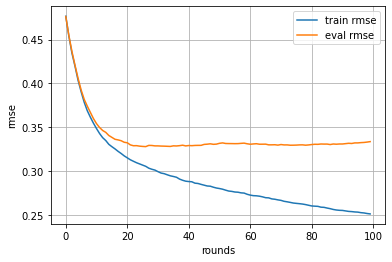

[0]	train-rmse:0.476703	eval-rmse:0.476339
[1]	train-rmse:0.453889	eval-rmse:0.45472
[2]	train-rmse:0.434592	eval-rmse:0.436434
[3]	train-rmse:0.419586	eval-rmse:0.420643
[4]	train-rmse:0.403472	eval-rmse:0.405719
[5]	train-rmse:0.390349	eval-rmse:0.392376
[6]	train-rmse:0.378346	eval-rmse:0.381725
[7]	train-rmse:0.368737	eval-rmse:0.373994
[8]	train-rmse:0.361357	eval-rmse:0.366853
[9]	train-rmse:0.35453	eval-rmse:0.359778
[10]	train-rmse:0.348382	eval-rmse:0.35401
[11]	train-rmse:0.342721	eval-rmse:0.349577
[12]	train-rmse:0.338009	eval-rmse:0.346215
[13]	train-rmse:0.334738	eval-rmse:0.344098
[14]	train-rmse:0.330398	eval-rmse:0.340513
[15]	train-rmse:0.327711	eval-rmse:0.338356
[16]	train-rmse:0.325216	eval-rmse:0.336194
[17]	train-rmse:0.32243	eval-rmse:0.335475
[18]	train-rmse:0.319966	eval-rmse:0.334551
[19]	train-rmse:0.317235	eval-rmse:0.33277
[20]	train-rmse:0.314995	eval-rmse:0.332208
[21]	train-rmse:0.312766	eval-rmse:0.329777
[22]	train-rmse:0.311065	eval-rmse:0.328819
[23

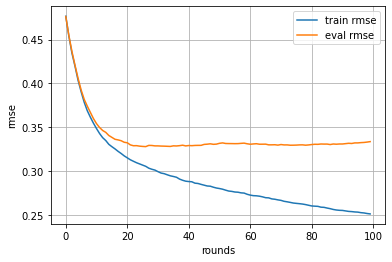

[0]	train-rmse:0.476703	eval-rmse:0.476339
[1]	train-rmse:0.453889	eval-rmse:0.45472
[2]	train-rmse:0.434592	eval-rmse:0.436434
[3]	train-rmse:0.419586	eval-rmse:0.420643
[4]	train-rmse:0.403472	eval-rmse:0.405719
[5]	train-rmse:0.390349	eval-rmse:0.392376
[6]	train-rmse:0.378346	eval-rmse:0.381725
[7]	train-rmse:0.368737	eval-rmse:0.373994
[8]	train-rmse:0.361357	eval-rmse:0.366853
[9]	train-rmse:0.35453	eval-rmse:0.359778
[10]	train-rmse:0.348382	eval-rmse:0.35401
[11]	train-rmse:0.342721	eval-rmse:0.349577
[12]	train-rmse:0.338009	eval-rmse:0.346215
[13]	train-rmse:0.334738	eval-rmse:0.344098
[14]	train-rmse:0.330398	eval-rmse:0.340513
[15]	train-rmse:0.327711	eval-rmse:0.338356
[16]	train-rmse:0.325216	eval-rmse:0.336194
[17]	train-rmse:0.32243	eval-rmse:0.335475
[18]	train-rmse:0.319966	eval-rmse:0.334551
[19]	train-rmse:0.317235	eval-rmse:0.33277
[20]	train-rmse:0.314995	eval-rmse:0.332208
[21]	train-rmse:0.312766	eval-rmse:0.329777
[22]	train-rmse:0.311065	eval-rmse:0.328819
[23

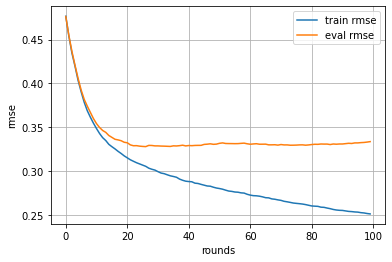

[0]	train-rmse:0.476703	eval-rmse:0.476339
[1]	train-rmse:0.453889	eval-rmse:0.45472
[2]	train-rmse:0.434592	eval-rmse:0.436434
[3]	train-rmse:0.419586	eval-rmse:0.420643
[4]	train-rmse:0.403472	eval-rmse:0.405719
[5]	train-rmse:0.390349	eval-rmse:0.392376
[6]	train-rmse:0.378346	eval-rmse:0.381725
[7]	train-rmse:0.368737	eval-rmse:0.373994
[8]	train-rmse:0.361357	eval-rmse:0.366853
[9]	train-rmse:0.35453	eval-rmse:0.359778
[10]	train-rmse:0.348382	eval-rmse:0.35401
[11]	train-rmse:0.342721	eval-rmse:0.349577
[12]	train-rmse:0.338009	eval-rmse:0.346215
[13]	train-rmse:0.334738	eval-rmse:0.344098
[14]	train-rmse:0.330398	eval-rmse:0.340513
[15]	train-rmse:0.327711	eval-rmse:0.338356
[16]	train-rmse:0.325216	eval-rmse:0.336194
[17]	train-rmse:0.32243	eval-rmse:0.335475
[18]	train-rmse:0.319966	eval-rmse:0.334551
[19]	train-rmse:0.317235	eval-rmse:0.33277
[20]	train-rmse:0.314995	eval-rmse:0.332208
[21]	train-rmse:0.312766	eval-rmse:0.329777
[22]	train-rmse:0.311065	eval-rmse:0.328819
[23

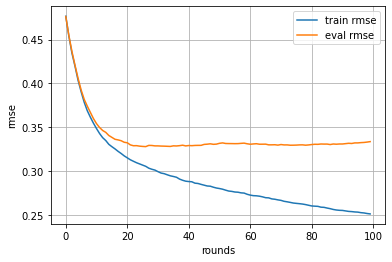

[0]	train-rmse:0.476703	eval-rmse:0.476339
[1]	train-rmse:0.453889	eval-rmse:0.45472
[2]	train-rmse:0.434592	eval-rmse:0.436434
[3]	train-rmse:0.419586	eval-rmse:0.420643
[4]	train-rmse:0.403472	eval-rmse:0.405719
[5]	train-rmse:0.390349	eval-rmse:0.392376
[6]	train-rmse:0.378346	eval-rmse:0.381725
[7]	train-rmse:0.368737	eval-rmse:0.373994
[8]	train-rmse:0.361357	eval-rmse:0.366853
[9]	train-rmse:0.35453	eval-rmse:0.359778
[10]	train-rmse:0.348382	eval-rmse:0.35401
[11]	train-rmse:0.342721	eval-rmse:0.349577
[12]	train-rmse:0.338009	eval-rmse:0.346215
[13]	train-rmse:0.334738	eval-rmse:0.344098
[14]	train-rmse:0.330398	eval-rmse:0.340513
[15]	train-rmse:0.327711	eval-rmse:0.338356
[16]	train-rmse:0.325216	eval-rmse:0.336194
[17]	train-rmse:0.32243	eval-rmse:0.335475
[18]	train-rmse:0.319966	eval-rmse:0.334551
[19]	train-rmse:0.317235	eval-rmse:0.33277
[20]	train-rmse:0.314995	eval-rmse:0.332208
[21]	train-rmse:0.312766	eval-rmse:0.329777
[22]	train-rmse:0.311065	eval-rmse:0.328819
[23

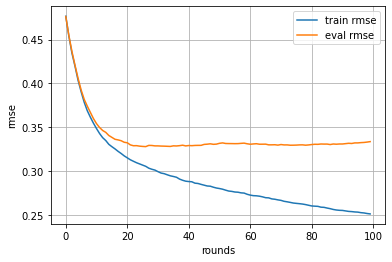

[0]	train-rmse:0.476703	eval-rmse:0.476339
[1]	train-rmse:0.453889	eval-rmse:0.45472
[2]	train-rmse:0.434592	eval-rmse:0.436434
[3]	train-rmse:0.419586	eval-rmse:0.420643
[4]	train-rmse:0.403472	eval-rmse:0.405719
[5]	train-rmse:0.390349	eval-rmse:0.392376
[6]	train-rmse:0.378346	eval-rmse:0.381725
[7]	train-rmse:0.368737	eval-rmse:0.373994
[8]	train-rmse:0.361357	eval-rmse:0.366853
[9]	train-rmse:0.35453	eval-rmse:0.359778
[10]	train-rmse:0.348382	eval-rmse:0.35401
[11]	train-rmse:0.342721	eval-rmse:0.349577
[12]	train-rmse:0.338009	eval-rmse:0.346215
[13]	train-rmse:0.334738	eval-rmse:0.344098
[14]	train-rmse:0.330398	eval-rmse:0.340513
[15]	train-rmse:0.327711	eval-rmse:0.338356
[16]	train-rmse:0.325216	eval-rmse:0.336194
[17]	train-rmse:0.32243	eval-rmse:0.335475
[18]	train-rmse:0.319966	eval-rmse:0.334551
[19]	train-rmse:0.317235	eval-rmse:0.33277
[20]	train-rmse:0.314995	eval-rmse:0.332208
[21]	train-rmse:0.312766	eval-rmse:0.329777
[22]	train-rmse:0.311065	eval-rmse:0.328819
[23

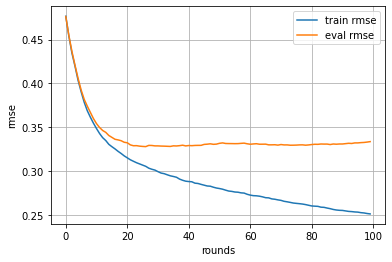

[0]	train-rmse:0.476617	eval-rmse:0.475582
[1]	train-rmse:0.454139	eval-rmse:0.45334
[2]	train-rmse:0.434925	eval-rmse:0.434902
[3]	train-rmse:0.420858	eval-rmse:0.421532
[4]	train-rmse:0.404961	eval-rmse:0.406428
[5]	train-rmse:0.391738	eval-rmse:0.392882
[6]	train-rmse:0.380643	eval-rmse:0.38274
[7]	train-rmse:0.371569	eval-rmse:0.37528
[8]	train-rmse:0.364314	eval-rmse:0.368144
[9]	train-rmse:0.357249	eval-rmse:0.361031
[10]	train-rmse:0.351539	eval-rmse:0.355061
[11]	train-rmse:0.345286	eval-rmse:0.350909
[12]	train-rmse:0.340636	eval-rmse:0.347186
[13]	train-rmse:0.337118	eval-rmse:0.344528
[14]	train-rmse:0.332855	eval-rmse:0.34087
[15]	train-rmse:0.330014	eval-rmse:0.338739
[16]	train-rmse:0.327628	eval-rmse:0.336542
[17]	train-rmse:0.324795	eval-rmse:0.335567
[18]	train-rmse:0.322338	eval-rmse:0.334757
[19]	train-rmse:0.318948	eval-rmse:0.332839
[20]	train-rmse:0.316566	eval-rmse:0.332495
[21]	train-rmse:0.314658	eval-rmse:0.331192
[22]	train-rmse:0.313285	eval-rmse:0.330335
[2

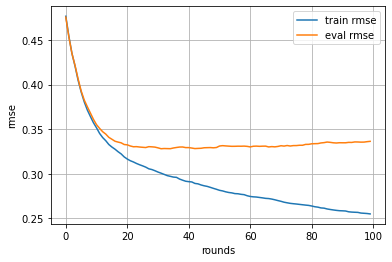

[0]	train-rmse:0.476617	eval-rmse:0.475582
[1]	train-rmse:0.454139	eval-rmse:0.45334
[2]	train-rmse:0.434925	eval-rmse:0.434902
[3]	train-rmse:0.420858	eval-rmse:0.421532
[4]	train-rmse:0.404961	eval-rmse:0.406428
[5]	train-rmse:0.391738	eval-rmse:0.392882
[6]	train-rmse:0.380643	eval-rmse:0.38274
[7]	train-rmse:0.371569	eval-rmse:0.37528
[8]	train-rmse:0.364314	eval-rmse:0.368144
[9]	train-rmse:0.357249	eval-rmse:0.361031
[10]	train-rmse:0.351539	eval-rmse:0.355061
[11]	train-rmse:0.345286	eval-rmse:0.350909
[12]	train-rmse:0.340636	eval-rmse:0.347186
[13]	train-rmse:0.337118	eval-rmse:0.344528
[14]	train-rmse:0.332855	eval-rmse:0.34087
[15]	train-rmse:0.330014	eval-rmse:0.338739
[16]	train-rmse:0.327628	eval-rmse:0.336542
[17]	train-rmse:0.324795	eval-rmse:0.335567
[18]	train-rmse:0.322338	eval-rmse:0.334757
[19]	train-rmse:0.318948	eval-rmse:0.332839
[20]	train-rmse:0.316566	eval-rmse:0.332495
[21]	train-rmse:0.314658	eval-rmse:0.331192
[22]	train-rmse:0.313285	eval-rmse:0.330335
[2

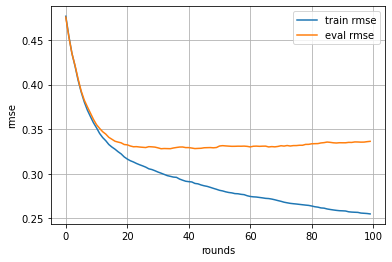

[0]	train-rmse:0.476617	eval-rmse:0.475582
[1]	train-rmse:0.454139	eval-rmse:0.45334
[2]	train-rmse:0.434925	eval-rmse:0.434902
[3]	train-rmse:0.420858	eval-rmse:0.421532
[4]	train-rmse:0.404961	eval-rmse:0.406428
[5]	train-rmse:0.391738	eval-rmse:0.392882
[6]	train-rmse:0.380643	eval-rmse:0.38274
[7]	train-rmse:0.371569	eval-rmse:0.37528
[8]	train-rmse:0.364314	eval-rmse:0.368144
[9]	train-rmse:0.357249	eval-rmse:0.361031
[10]	train-rmse:0.351539	eval-rmse:0.355061
[11]	train-rmse:0.345286	eval-rmse:0.350909
[12]	train-rmse:0.340636	eval-rmse:0.347186
[13]	train-rmse:0.337118	eval-rmse:0.344528
[14]	train-rmse:0.332855	eval-rmse:0.34087
[15]	train-rmse:0.330014	eval-rmse:0.338739
[16]	train-rmse:0.327628	eval-rmse:0.336542
[17]	train-rmse:0.324795	eval-rmse:0.335567
[18]	train-rmse:0.322338	eval-rmse:0.334757
[19]	train-rmse:0.318948	eval-rmse:0.332839
[20]	train-rmse:0.316566	eval-rmse:0.332495
[21]	train-rmse:0.314658	eval-rmse:0.331192
[22]	train-rmse:0.313285	eval-rmse:0.330335
[2

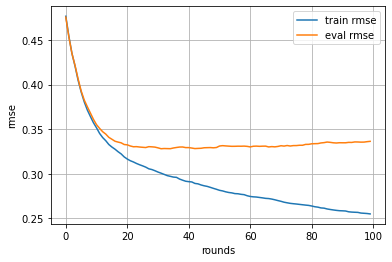

[0]	train-rmse:0.476617	eval-rmse:0.475582
[1]	train-rmse:0.454139	eval-rmse:0.45334
[2]	train-rmse:0.434925	eval-rmse:0.434902
[3]	train-rmse:0.420858	eval-rmse:0.421532
[4]	train-rmse:0.404961	eval-rmse:0.406428
[5]	train-rmse:0.391738	eval-rmse:0.392882
[6]	train-rmse:0.380643	eval-rmse:0.38274
[7]	train-rmse:0.371569	eval-rmse:0.37528
[8]	train-rmse:0.364314	eval-rmse:0.368144
[9]	train-rmse:0.357249	eval-rmse:0.361031
[10]	train-rmse:0.351539	eval-rmse:0.355061
[11]	train-rmse:0.345286	eval-rmse:0.350909
[12]	train-rmse:0.340636	eval-rmse:0.347186
[13]	train-rmse:0.337118	eval-rmse:0.344528
[14]	train-rmse:0.332855	eval-rmse:0.34087
[15]	train-rmse:0.330014	eval-rmse:0.338739
[16]	train-rmse:0.327628	eval-rmse:0.336542
[17]	train-rmse:0.324795	eval-rmse:0.335567
[18]	train-rmse:0.322338	eval-rmse:0.334757
[19]	train-rmse:0.318948	eval-rmse:0.332839
[20]	train-rmse:0.316566	eval-rmse:0.332495
[21]	train-rmse:0.314658	eval-rmse:0.331192
[22]	train-rmse:0.313285	eval-rmse:0.330335
[2

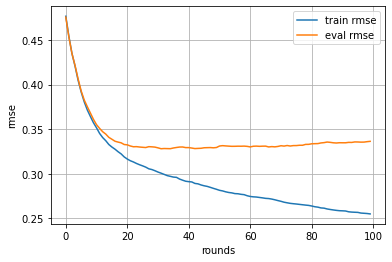

[0]	train-rmse:0.476617	eval-rmse:0.475582
[1]	train-rmse:0.454139	eval-rmse:0.45334
[2]	train-rmse:0.434925	eval-rmse:0.434902
[3]	train-rmse:0.420858	eval-rmse:0.421532
[4]	train-rmse:0.404961	eval-rmse:0.406428
[5]	train-rmse:0.391738	eval-rmse:0.392882
[6]	train-rmse:0.380643	eval-rmse:0.38274
[7]	train-rmse:0.371569	eval-rmse:0.37528
[8]	train-rmse:0.364314	eval-rmse:0.368144
[9]	train-rmse:0.357249	eval-rmse:0.361031
[10]	train-rmse:0.351539	eval-rmse:0.355061
[11]	train-rmse:0.345286	eval-rmse:0.350909
[12]	train-rmse:0.340636	eval-rmse:0.347186
[13]	train-rmse:0.337118	eval-rmse:0.344528
[14]	train-rmse:0.332855	eval-rmse:0.34087
[15]	train-rmse:0.330014	eval-rmse:0.338739
[16]	train-rmse:0.327628	eval-rmse:0.336542
[17]	train-rmse:0.324795	eval-rmse:0.335567
[18]	train-rmse:0.322338	eval-rmse:0.334757
[19]	train-rmse:0.318948	eval-rmse:0.332839
[20]	train-rmse:0.316566	eval-rmse:0.332495
[21]	train-rmse:0.314658	eval-rmse:0.331192
[22]	train-rmse:0.313285	eval-rmse:0.330335
[2

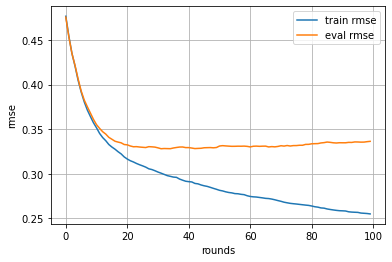

[0]	train-rmse:0.476617	eval-rmse:0.475582
[1]	train-rmse:0.454139	eval-rmse:0.45334
[2]	train-rmse:0.434925	eval-rmse:0.434902
[3]	train-rmse:0.420858	eval-rmse:0.421532
[4]	train-rmse:0.404961	eval-rmse:0.406428
[5]	train-rmse:0.391738	eval-rmse:0.392882
[6]	train-rmse:0.380643	eval-rmse:0.38274
[7]	train-rmse:0.371569	eval-rmse:0.37528
[8]	train-rmse:0.364314	eval-rmse:0.368144
[9]	train-rmse:0.357249	eval-rmse:0.361031
[10]	train-rmse:0.351539	eval-rmse:0.355061
[11]	train-rmse:0.345286	eval-rmse:0.350909
[12]	train-rmse:0.340636	eval-rmse:0.347186
[13]	train-rmse:0.337118	eval-rmse:0.344528
[14]	train-rmse:0.332855	eval-rmse:0.34087
[15]	train-rmse:0.330014	eval-rmse:0.338739
[16]	train-rmse:0.327628	eval-rmse:0.336542
[17]	train-rmse:0.324795	eval-rmse:0.335567
[18]	train-rmse:0.322338	eval-rmse:0.334757
[19]	train-rmse:0.318948	eval-rmse:0.332839
[20]	train-rmse:0.316566	eval-rmse:0.332495
[21]	train-rmse:0.314658	eval-rmse:0.331192
[22]	train-rmse:0.313285	eval-rmse:0.330335
[2

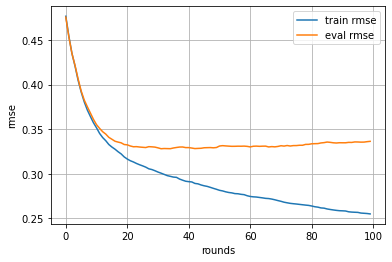

[0]	train-rmse:0.476617	eval-rmse:0.475582
[1]	train-rmse:0.454139	eval-rmse:0.45334
[2]	train-rmse:0.434925	eval-rmse:0.434902
[3]	train-rmse:0.420858	eval-rmse:0.421532
[4]	train-rmse:0.404961	eval-rmse:0.406428
[5]	train-rmse:0.391738	eval-rmse:0.392882
[6]	train-rmse:0.380643	eval-rmse:0.38274
[7]	train-rmse:0.371569	eval-rmse:0.37528
[8]	train-rmse:0.364314	eval-rmse:0.368144
[9]	train-rmse:0.357249	eval-rmse:0.361031
[10]	train-rmse:0.351539	eval-rmse:0.355061
[11]	train-rmse:0.345286	eval-rmse:0.350909
[12]	train-rmse:0.340636	eval-rmse:0.347186
[13]	train-rmse:0.337118	eval-rmse:0.344528
[14]	train-rmse:0.332855	eval-rmse:0.34087
[15]	train-rmse:0.330014	eval-rmse:0.338739
[16]	train-rmse:0.327628	eval-rmse:0.336542
[17]	train-rmse:0.324795	eval-rmse:0.335567
[18]	train-rmse:0.322338	eval-rmse:0.334757
[19]	train-rmse:0.318948	eval-rmse:0.332839
[20]	train-rmse:0.316566	eval-rmse:0.332495
[21]	train-rmse:0.314658	eval-rmse:0.331192
[22]	train-rmse:0.313285	eval-rmse:0.330335
[2

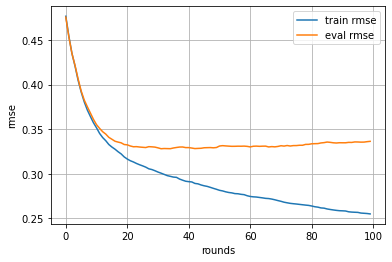

[0]	train-rmse:0.476617	eval-rmse:0.475582
[1]	train-rmse:0.454139	eval-rmse:0.45334
[2]	train-rmse:0.434925	eval-rmse:0.434902
[3]	train-rmse:0.420858	eval-rmse:0.421532
[4]	train-rmse:0.404961	eval-rmse:0.406428
[5]	train-rmse:0.391738	eval-rmse:0.392882
[6]	train-rmse:0.380643	eval-rmse:0.38274
[7]	train-rmse:0.371569	eval-rmse:0.37528
[8]	train-rmse:0.364314	eval-rmse:0.368144
[9]	train-rmse:0.357249	eval-rmse:0.361031
[10]	train-rmse:0.351539	eval-rmse:0.355061
[11]	train-rmse:0.345286	eval-rmse:0.350909
[12]	train-rmse:0.340636	eval-rmse:0.347186
[13]	train-rmse:0.337118	eval-rmse:0.344528
[14]	train-rmse:0.332855	eval-rmse:0.34087
[15]	train-rmse:0.330014	eval-rmse:0.338739
[16]	train-rmse:0.327628	eval-rmse:0.336542
[17]	train-rmse:0.324795	eval-rmse:0.335567
[18]	train-rmse:0.322338	eval-rmse:0.334757
[19]	train-rmse:0.318948	eval-rmse:0.332839
[20]	train-rmse:0.316566	eval-rmse:0.332495
[21]	train-rmse:0.314658	eval-rmse:0.331192
[22]	train-rmse:0.313285	eval-rmse:0.330335
[2

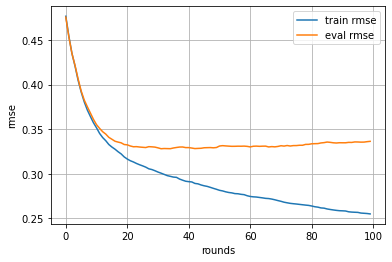

[0]	train-rmse:0.476617	eval-rmse:0.475582
[1]	train-rmse:0.454139	eval-rmse:0.45334
[2]	train-rmse:0.434925	eval-rmse:0.434902
[3]	train-rmse:0.420858	eval-rmse:0.421532
[4]	train-rmse:0.404961	eval-rmse:0.406428
[5]	train-rmse:0.391738	eval-rmse:0.392882
[6]	train-rmse:0.380643	eval-rmse:0.38274
[7]	train-rmse:0.371569	eval-rmse:0.37528
[8]	train-rmse:0.364314	eval-rmse:0.368144
[9]	train-rmse:0.357249	eval-rmse:0.361031
[10]	train-rmse:0.351539	eval-rmse:0.355061
[11]	train-rmse:0.345286	eval-rmse:0.350909
[12]	train-rmse:0.340636	eval-rmse:0.347186
[13]	train-rmse:0.337118	eval-rmse:0.344528
[14]	train-rmse:0.332855	eval-rmse:0.34087
[15]	train-rmse:0.330014	eval-rmse:0.338739
[16]	train-rmse:0.327628	eval-rmse:0.336542
[17]	train-rmse:0.324795	eval-rmse:0.335567
[18]	train-rmse:0.322338	eval-rmse:0.334757
[19]	train-rmse:0.318948	eval-rmse:0.332839
[20]	train-rmse:0.316566	eval-rmse:0.332495
[21]	train-rmse:0.314658	eval-rmse:0.331192
[22]	train-rmse:0.313285	eval-rmse:0.330335
[2

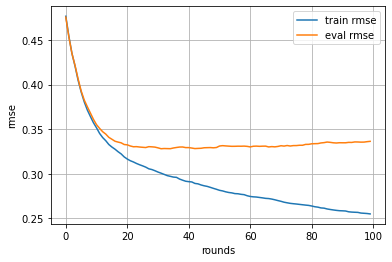

[0]	train-rmse:0.476617	eval-rmse:0.475582
[1]	train-rmse:0.454139	eval-rmse:0.45334
[2]	train-rmse:0.434925	eval-rmse:0.434902
[3]	train-rmse:0.420858	eval-rmse:0.421532
[4]	train-rmse:0.404961	eval-rmse:0.406428
[5]	train-rmse:0.391738	eval-rmse:0.392882
[6]	train-rmse:0.380643	eval-rmse:0.38274
[7]	train-rmse:0.371569	eval-rmse:0.37528
[8]	train-rmse:0.364314	eval-rmse:0.368144
[9]	train-rmse:0.357249	eval-rmse:0.361031
[10]	train-rmse:0.351539	eval-rmse:0.355061
[11]	train-rmse:0.345286	eval-rmse:0.350909
[12]	train-rmse:0.340636	eval-rmse:0.347186
[13]	train-rmse:0.337118	eval-rmse:0.344528
[14]	train-rmse:0.332855	eval-rmse:0.34087
[15]	train-rmse:0.330014	eval-rmse:0.338739
[16]	train-rmse:0.327628	eval-rmse:0.336542
[17]	train-rmse:0.324795	eval-rmse:0.335567
[18]	train-rmse:0.322338	eval-rmse:0.334757
[19]	train-rmse:0.318948	eval-rmse:0.332839
[20]	train-rmse:0.316566	eval-rmse:0.332495
[21]	train-rmse:0.314658	eval-rmse:0.331192
[22]	train-rmse:0.313285	eval-rmse:0.330335
[2

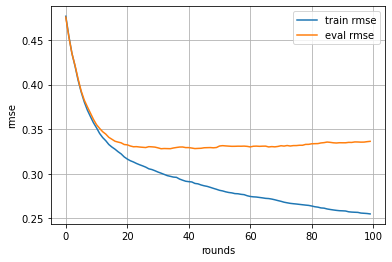

Tuning subsample ...
[0]	train-rmse:0.477597	eval-rmse:0.477197
[1]	train-rmse:0.452796	eval-rmse:0.453445
[2]	train-rmse:0.433103	eval-rmse:0.433782
[3]	train-rmse:0.418622	eval-rmse:0.419802
[4]	train-rmse:0.402015	eval-rmse:0.404441
[5]	train-rmse:0.388917	eval-rmse:0.393072
[6]	train-rmse:0.376201	eval-rmse:0.381864
[7]	train-rmse:0.36767	eval-rmse:0.374034
[8]	train-rmse:0.359976	eval-rmse:0.367951
[9]	train-rmse:0.351283	eval-rmse:0.360335
[10]	train-rmse:0.344192	eval-rmse:0.354959
[11]	train-rmse:0.337866	eval-rmse:0.350491
[12]	train-rmse:0.332625	eval-rmse:0.346601
[13]	train-rmse:0.328002	eval-rmse:0.34286
[14]	train-rmse:0.322389	eval-rmse:0.341011
[15]	train-rmse:0.319019	eval-rmse:0.338047
[16]	train-rmse:0.315574	eval-rmse:0.336176
[17]	train-rmse:0.31213	eval-rmse:0.336989
[18]	train-rmse:0.30849	eval-rmse:0.334229
[19]	train-rmse:0.305883	eval-rmse:0.334559
[20]	train-rmse:0.30377	eval-rmse:0.333742
[21]	train-rmse:0.301586	eval-rmse:0.332572
[22]	train-rmse:0.29868	ev

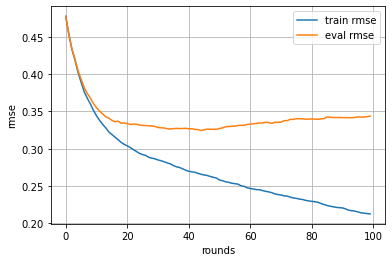

[0]	train-rmse:0.477462	eval-rmse:0.477494
[1]	train-rmse:0.452124	eval-rmse:0.452823
[2]	train-rmse:0.431879	eval-rmse:0.432843
[3]	train-rmse:0.416318	eval-rmse:0.418607
[4]	train-rmse:0.399271	eval-rmse:0.403989
[5]	train-rmse:0.386349	eval-rmse:0.393742
[6]	train-rmse:0.373952	eval-rmse:0.382713
[7]	train-rmse:0.364797	eval-rmse:0.374888
[8]	train-rmse:0.357319	eval-rmse:0.368153
[9]	train-rmse:0.349152	eval-rmse:0.360226
[10]	train-rmse:0.342058	eval-rmse:0.354515
[11]	train-rmse:0.335157	eval-rmse:0.349586
[12]	train-rmse:0.328842	eval-rmse:0.345886
[13]	train-rmse:0.325053	eval-rmse:0.343513
[14]	train-rmse:0.319757	eval-rmse:0.338976
[15]	train-rmse:0.316779	eval-rmse:0.336253
[16]	train-rmse:0.313215	eval-rmse:0.33484
[17]	train-rmse:0.310688	eval-rmse:0.33431
[18]	train-rmse:0.307729	eval-rmse:0.333412
[19]	train-rmse:0.304491	eval-rmse:0.332971
[20]	train-rmse:0.301107	eval-rmse:0.331815
[21]	train-rmse:0.298331	eval-rmse:0.330866
[22]	train-rmse:0.295517	eval-rmse:0.330233


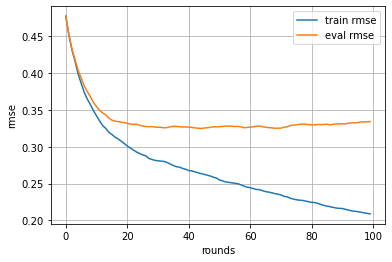

[0]	train-rmse:0.476056	eval-rmse:0.476476
[1]	train-rmse:0.450807	eval-rmse:0.451543
[2]	train-rmse:0.430585	eval-rmse:0.433249
[3]	train-rmse:0.415291	eval-rmse:0.419357
[4]	train-rmse:0.39811	eval-rmse:0.40523
[5]	train-rmse:0.384802	eval-rmse:0.396839
[6]	train-rmse:0.372003	eval-rmse:0.386491
[7]	train-rmse:0.361978	eval-rmse:0.378202
[8]	train-rmse:0.353497	eval-rmse:0.370736
[9]	train-rmse:0.34462	eval-rmse:0.362347
[10]	train-rmse:0.337328	eval-rmse:0.355589
[11]	train-rmse:0.331246	eval-rmse:0.351009
[12]	train-rmse:0.326124	eval-rmse:0.347751
[13]	train-rmse:0.322314	eval-rmse:0.345481
[14]	train-rmse:0.316366	eval-rmse:0.340814
[15]	train-rmse:0.313549	eval-rmse:0.338329
[16]	train-rmse:0.310082	eval-rmse:0.336818
[17]	train-rmse:0.306924	eval-rmse:0.335483
[18]	train-rmse:0.303619	eval-rmse:0.334354
[19]	train-rmse:0.300094	eval-rmse:0.334203
[20]	train-rmse:0.298061	eval-rmse:0.333221
[21]	train-rmse:0.295672	eval-rmse:0.332886
[22]	train-rmse:0.293276	eval-rmse:0.331766
[

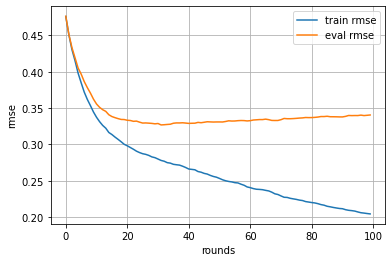

[0]	train-rmse:0.475665	eval-rmse:0.474639
[1]	train-rmse:0.450249	eval-rmse:0.450184
[2]	train-rmse:0.429383	eval-rmse:0.43092
[3]	train-rmse:0.413935	eval-rmse:0.415003
[4]	train-rmse:0.397232	eval-rmse:0.400456
[5]	train-rmse:0.382934	eval-rmse:0.387612
[6]	train-rmse:0.370739	eval-rmse:0.376843
[7]	train-rmse:0.360231	eval-rmse:0.369635
[8]	train-rmse:0.351996	eval-rmse:0.361866
[9]	train-rmse:0.343518	eval-rmse:0.354549
[10]	train-rmse:0.336048	eval-rmse:0.347633
[11]	train-rmse:0.329715	eval-rmse:0.342885
[12]	train-rmse:0.323542	eval-rmse:0.340192
[13]	train-rmse:0.319367	eval-rmse:0.337924
[14]	train-rmse:0.314687	eval-rmse:0.334757
[15]	train-rmse:0.311715	eval-rmse:0.332477
[16]	train-rmse:0.309162	eval-rmse:0.330802
[17]	train-rmse:0.306355	eval-rmse:0.328741
[18]	train-rmse:0.302509	eval-rmse:0.327497
[19]	train-rmse:0.299815	eval-rmse:0.327094
[20]	train-rmse:0.297255	eval-rmse:0.326642
[21]	train-rmse:0.294412	eval-rmse:0.326288
[22]	train-rmse:0.291647	eval-rmse:0.325194

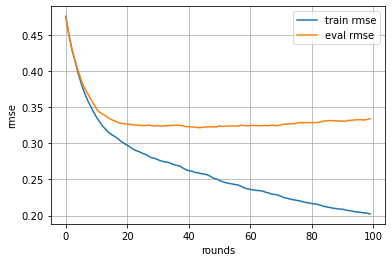

[0]	train-rmse:0.475477	eval-rmse:0.474763
[1]	train-rmse:0.450508	eval-rmse:0.451119
[2]	train-rmse:0.429042	eval-rmse:0.431306
[3]	train-rmse:0.412292	eval-rmse:0.414193
[4]	train-rmse:0.395667	eval-rmse:0.400241
[5]	train-rmse:0.381048	eval-rmse:0.386957
[6]	train-rmse:0.369021	eval-rmse:0.376837
[7]	train-rmse:0.35723	eval-rmse:0.367238
[8]	train-rmse:0.349382	eval-rmse:0.360852
[9]	train-rmse:0.341197	eval-rmse:0.354412
[10]	train-rmse:0.334703	eval-rmse:0.347618
[11]	train-rmse:0.328312	eval-rmse:0.343106
[12]	train-rmse:0.322506	eval-rmse:0.339771
[13]	train-rmse:0.318011	eval-rmse:0.337781
[14]	train-rmse:0.313171	eval-rmse:0.333837
[15]	train-rmse:0.310331	eval-rmse:0.331217
[16]	train-rmse:0.307784	eval-rmse:0.329129
[17]	train-rmse:0.30476	eval-rmse:0.327302
[18]	train-rmse:0.301603	eval-rmse:0.326251
[19]	train-rmse:0.297784	eval-rmse:0.32455
[20]	train-rmse:0.29595	eval-rmse:0.323293
[21]	train-rmse:0.292857	eval-rmse:0.32216
[22]	train-rmse:0.289697	eval-rmse:0.322653
[23

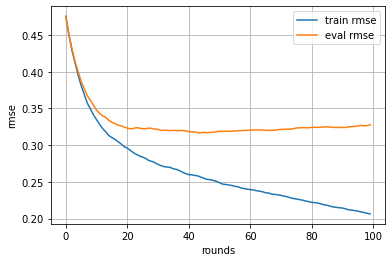

[0]	train-rmse:0.475463	eval-rmse:0.476073
[1]	train-rmse:0.450971	eval-rmse:0.453012
[2]	train-rmse:0.42964	eval-rmse:0.433869
[3]	train-rmse:0.413568	eval-rmse:0.417838
[4]	train-rmse:0.396468	eval-rmse:0.402963
[5]	train-rmse:0.381244	eval-rmse:0.389664
[6]	train-rmse:0.369124	eval-rmse:0.380259
[7]	train-rmse:0.357951	eval-rmse:0.370905
[8]	train-rmse:0.349809	eval-rmse:0.362637
[9]	train-rmse:0.341455	eval-rmse:0.355939
[10]	train-rmse:0.334863	eval-rmse:0.349725
[11]	train-rmse:0.328129	eval-rmse:0.345722
[12]	train-rmse:0.322057	eval-rmse:0.342154
[13]	train-rmse:0.317967	eval-rmse:0.339721
[14]	train-rmse:0.31341	eval-rmse:0.336741
[15]	train-rmse:0.310383	eval-rmse:0.33442
[16]	train-rmse:0.306791	eval-rmse:0.332164
[17]	train-rmse:0.303858	eval-rmse:0.331648
[18]	train-rmse:0.299778	eval-rmse:0.329034
[19]	train-rmse:0.296369	eval-rmse:0.327921
[20]	train-rmse:0.292719	eval-rmse:0.329164
[21]	train-rmse:0.289571	eval-rmse:0.327686
[22]	train-rmse:0.287077	eval-rmse:0.32818
[2

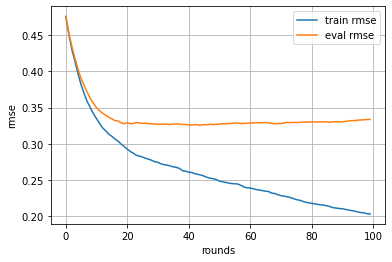

[0]	train-rmse:0.475127	eval-rmse:0.474993
[1]	train-rmse:0.450301	eval-rmse:0.451024
[2]	train-rmse:0.428814	eval-rmse:0.431006
[3]	train-rmse:0.412876	eval-rmse:0.414714
[4]	train-rmse:0.396356	eval-rmse:0.40061
[5]	train-rmse:0.382522	eval-rmse:0.387874
[6]	train-rmse:0.369793	eval-rmse:0.378046
[7]	train-rmse:0.357824	eval-rmse:0.36859
[8]	train-rmse:0.349791	eval-rmse:0.36101
[9]	train-rmse:0.341238	eval-rmse:0.35524
[10]	train-rmse:0.334419	eval-rmse:0.348714
[11]	train-rmse:0.328381	eval-rmse:0.344435
[12]	train-rmse:0.322978	eval-rmse:0.341834
[13]	train-rmse:0.318182	eval-rmse:0.338927
[14]	train-rmse:0.31447	eval-rmse:0.336694
[15]	train-rmse:0.311525	eval-rmse:0.334048
[16]	train-rmse:0.308999	eval-rmse:0.332124
[17]	train-rmse:0.304897	eval-rmse:0.330362
[18]	train-rmse:0.301462	eval-rmse:0.328007
[19]	train-rmse:0.297232	eval-rmse:0.326945
[20]	train-rmse:0.293509	eval-rmse:0.327609
[21]	train-rmse:0.290692	eval-rmse:0.327394
[22]	train-rmse:0.288441	eval-rmse:0.327012
[23

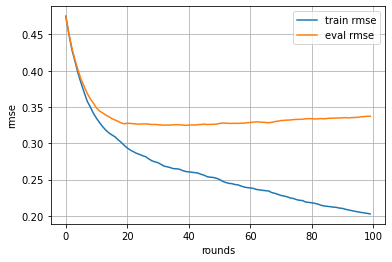

[0]	train-rmse:0.474968	eval-rmse:0.474236
[1]	train-rmse:0.450554	eval-rmse:0.449751
[2]	train-rmse:0.429035	eval-rmse:0.429659
[3]	train-rmse:0.412885	eval-rmse:0.41258
[4]	train-rmse:0.39671	eval-rmse:0.39797
[5]	train-rmse:0.381821	eval-rmse:0.385279
[6]	train-rmse:0.36916	eval-rmse:0.374477
[7]	train-rmse:0.357126	eval-rmse:0.365521
[8]	train-rmse:0.34921	eval-rmse:0.358411
[9]	train-rmse:0.341329	eval-rmse:0.352661
[10]	train-rmse:0.333898	eval-rmse:0.346583
[11]	train-rmse:0.326697	eval-rmse:0.341865
[12]	train-rmse:0.321297	eval-rmse:0.339012
[13]	train-rmse:0.316783	eval-rmse:0.33667
[14]	train-rmse:0.313027	eval-rmse:0.335274
[15]	train-rmse:0.310147	eval-rmse:0.332753
[16]	train-rmse:0.307604	eval-rmse:0.330968
[17]	train-rmse:0.302898	eval-rmse:0.32845
[18]	train-rmse:0.299388	eval-rmse:0.325884
[19]	train-rmse:0.296051	eval-rmse:0.324758
[20]	train-rmse:0.293069	eval-rmse:0.324882
[21]	train-rmse:0.290543	eval-rmse:0.324889
[22]	train-rmse:0.288435	eval-rmse:0.324749
[23]	

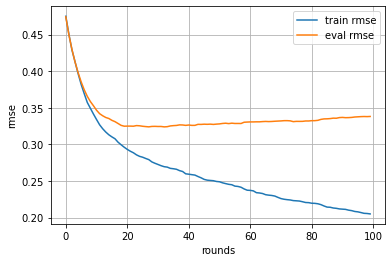

Tuning gamma ...
[0]	train-rmse:0.475477	eval-rmse:0.474763
[1]	train-rmse:0.450508	eval-rmse:0.451119
[2]	train-rmse:0.429042	eval-rmse:0.431306
[3]	train-rmse:0.412292	eval-rmse:0.414193
[4]	train-rmse:0.395667	eval-rmse:0.400241
[5]	train-rmse:0.381048	eval-rmse:0.386957
[6]	train-rmse:0.369021	eval-rmse:0.376837
[7]	train-rmse:0.35723	eval-rmse:0.367238
[8]	train-rmse:0.349382	eval-rmse:0.360852
[9]	train-rmse:0.341197	eval-rmse:0.354412
[10]	train-rmse:0.334703	eval-rmse:0.347618
[11]	train-rmse:0.328312	eval-rmse:0.343106
[12]	train-rmse:0.322506	eval-rmse:0.339771
[13]	train-rmse:0.318011	eval-rmse:0.337781
[14]	train-rmse:0.313171	eval-rmse:0.333837
[15]	train-rmse:0.310331	eval-rmse:0.331217
[16]	train-rmse:0.307784	eval-rmse:0.329129
[17]	train-rmse:0.30476	eval-rmse:0.327302
[18]	train-rmse:0.301603	eval-rmse:0.326251
[19]	train-rmse:0.297784	eval-rmse:0.32455
[20]	train-rmse:0.29595	eval-rmse:0.323293
[21]	train-rmse:0.292857	eval-rmse:0.32216
[22]	train-rmse:0.289697	eval-

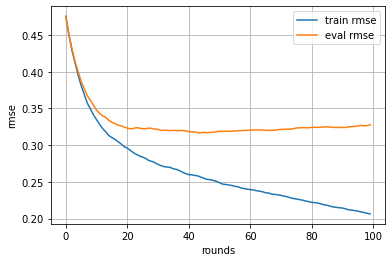

[0]	train-rmse:0.475477	eval-rmse:0.474763
[1]	train-rmse:0.450508	eval-rmse:0.451119
[2]	train-rmse:0.429042	eval-rmse:0.431306
[3]	train-rmse:0.412292	eval-rmse:0.414193
[4]	train-rmse:0.395667	eval-rmse:0.400241
[5]	train-rmse:0.381048	eval-rmse:0.386957
[6]	train-rmse:0.369033	eval-rmse:0.376807
[7]	train-rmse:0.357247	eval-rmse:0.367212
[8]	train-rmse:0.349402	eval-rmse:0.36083
[9]	train-rmse:0.341218	eval-rmse:0.354391
[10]	train-rmse:0.334725	eval-rmse:0.347601
[11]	train-rmse:0.328338	eval-rmse:0.343093
[12]	train-rmse:0.322536	eval-rmse:0.33976
[13]	train-rmse:0.318042	eval-rmse:0.337772
[14]	train-rmse:0.313203	eval-rmse:0.33383
[15]	train-rmse:0.310364	eval-rmse:0.331211
[16]	train-rmse:0.307819	eval-rmse:0.329125
[17]	train-rmse:0.304793	eval-rmse:0.327289
[18]	train-rmse:0.301631	eval-rmse:0.3263
[19]	train-rmse:0.298455	eval-rmse:0.325286
[20]	train-rmse:0.29662	eval-rmse:0.324075
[21]	train-rmse:0.294059	eval-rmse:0.323345
[22]	train-rmse:0.291356	eval-rmse:0.32267
[23]	

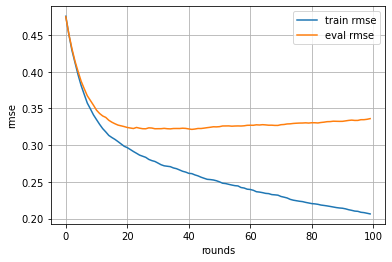

[0]	train-rmse:0.475477	eval-rmse:0.474763
[1]	train-rmse:0.450508	eval-rmse:0.451119
[2]	train-rmse:0.429042	eval-rmse:0.431306
[3]	train-rmse:0.412292	eval-rmse:0.414193
[4]	train-rmse:0.395667	eval-rmse:0.400241
[5]	train-rmse:0.381048	eval-rmse:0.386957
[6]	train-rmse:0.369033	eval-rmse:0.376807
[7]	train-rmse:0.357247	eval-rmse:0.367212
[8]	train-rmse:0.349402	eval-rmse:0.36083
[9]	train-rmse:0.341215	eval-rmse:0.354391
[10]	train-rmse:0.334722	eval-rmse:0.3476
[11]	train-rmse:0.328335	eval-rmse:0.343093
[12]	train-rmse:0.322532	eval-rmse:0.339761
[13]	train-rmse:0.318062	eval-rmse:0.337867
[14]	train-rmse:0.313234	eval-rmse:0.333854
[15]	train-rmse:0.310394	eval-rmse:0.33123
[16]	train-rmse:0.307847	eval-rmse:0.329142
[17]	train-rmse:0.30482	eval-rmse:0.32731
[18]	train-rmse:0.301668	eval-rmse:0.326269
[19]	train-rmse:0.29785	eval-rmse:0.324566
[20]	train-rmse:0.296002	eval-rmse:0.32335
[21]	train-rmse:0.292909	eval-rmse:0.322213
[22]	train-rmse:0.289773	eval-rmse:0.322663
[23]	t

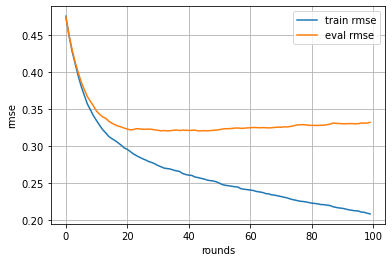

[0]	train-rmse:0.475477	eval-rmse:0.474763
[1]	train-rmse:0.450508	eval-rmse:0.451119
[2]	train-rmse:0.429042	eval-rmse:0.431306
[3]	train-rmse:0.4123	eval-rmse:0.414271
[4]	train-rmse:0.395675	eval-rmse:0.400316
[5]	train-rmse:0.381061	eval-rmse:0.387033
[6]	train-rmse:0.369048	eval-rmse:0.376876
[7]	train-rmse:0.357265	eval-rmse:0.367282
[8]	train-rmse:0.349422	eval-rmse:0.360895
[9]	train-rmse:0.341235	eval-rmse:0.354453
[10]	train-rmse:0.334739	eval-rmse:0.347662
[11]	train-rmse:0.328343	eval-rmse:0.34315
[12]	train-rmse:0.322539	eval-rmse:0.339813
[13]	train-rmse:0.318045	eval-rmse:0.337877
[14]	train-rmse:0.313219	eval-rmse:0.333863
[15]	train-rmse:0.310375	eval-rmse:0.331243
[16]	train-rmse:0.307827	eval-rmse:0.329158
[17]	train-rmse:0.304801	eval-rmse:0.327326
[18]	train-rmse:0.301657	eval-rmse:0.326246
[19]	train-rmse:0.297851	eval-rmse:0.324544
[20]	train-rmse:0.29602	eval-rmse:0.32339
[21]	train-rmse:0.29294	eval-rmse:0.322258
[22]	train-rmse:0.289839	eval-rmse:0.322167
[23]

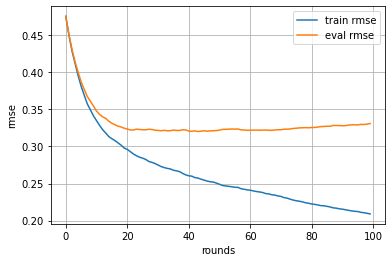

[0]	train-rmse:0.475477	eval-rmse:0.474763
[1]	train-rmse:0.450508	eval-rmse:0.451119
[2]	train-rmse:0.429042	eval-rmse:0.431306
[3]	train-rmse:0.4123	eval-rmse:0.414271
[4]	train-rmse:0.395675	eval-rmse:0.400316
[5]	train-rmse:0.381061	eval-rmse:0.387033
[6]	train-rmse:0.369048	eval-rmse:0.376877
[7]	train-rmse:0.357265	eval-rmse:0.367282
[8]	train-rmse:0.349444	eval-rmse:0.360939
[9]	train-rmse:0.341245	eval-rmse:0.354489
[10]	train-rmse:0.334748	eval-rmse:0.347692
[11]	train-rmse:0.328344	eval-rmse:0.343173
[12]	train-rmse:0.322534	eval-rmse:0.339829
[13]	train-rmse:0.318039	eval-rmse:0.337886
[14]	train-rmse:0.313219	eval-rmse:0.333874
[15]	train-rmse:0.310385	eval-rmse:0.33129
[16]	train-rmse:0.30784	eval-rmse:0.329204
[17]	train-rmse:0.304809	eval-rmse:0.327368
[18]	train-rmse:0.301665	eval-rmse:0.3263
[19]	train-rmse:0.297855	eval-rmse:0.324594
[20]	train-rmse:0.296021	eval-rmse:0.323435
[21]	train-rmse:0.292944	eval-rmse:0.322357
[22]	train-rmse:0.289845	eval-rmse:0.322255
[23]

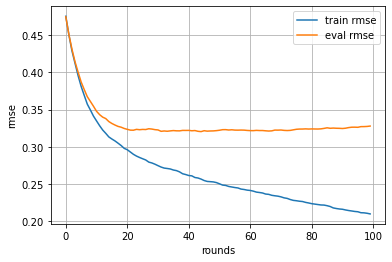

[0]	train-rmse:0.475477	eval-rmse:0.474763
[1]	train-rmse:0.450508	eval-rmse:0.451119
[2]	train-rmse:0.429042	eval-rmse:0.431306
[3]	train-rmse:0.4123	eval-rmse:0.414271
[4]	train-rmse:0.395675	eval-rmse:0.400316
[5]	train-rmse:0.381061	eval-rmse:0.387033
[6]	train-rmse:0.369048	eval-rmse:0.376876
[7]	train-rmse:0.357265	eval-rmse:0.367282
[8]	train-rmse:0.349444	eval-rmse:0.360939
[9]	train-rmse:0.341271	eval-rmse:0.3545
[10]	train-rmse:0.334837	eval-rmse:0.347589
[11]	train-rmse:0.328505	eval-rmse:0.342846
[12]	train-rmse:0.32239	eval-rmse:0.33914
[13]	train-rmse:0.317979	eval-rmse:0.337237
[14]	train-rmse:0.313125	eval-rmse:0.333203
[15]	train-rmse:0.310423	eval-rmse:0.330393
[16]	train-rmse:0.307083	eval-rmse:0.328913
[17]	train-rmse:0.304021	eval-rmse:0.327196
[18]	train-rmse:0.301388	eval-rmse:0.326016
[19]	train-rmse:0.298315	eval-rmse:0.324831
[20]	train-rmse:0.294774	eval-rmse:0.326138
[21]	train-rmse:0.292112	eval-rmse:0.324896
[22]	train-rmse:0.28972	eval-rmse:0.324061
[23]	

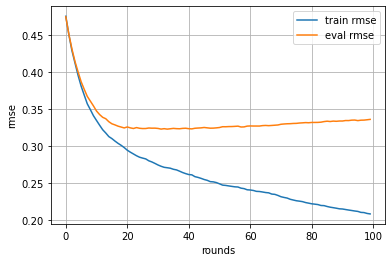

[0]	train-rmse:0.475477	eval-rmse:0.474763
[1]	train-rmse:0.450508	eval-rmse:0.451119
[2]	train-rmse:0.429042	eval-rmse:0.431306
[3]	train-rmse:0.4123	eval-rmse:0.414271
[4]	train-rmse:0.395707	eval-rmse:0.400175
[5]	train-rmse:0.381098	eval-rmse:0.386902
[6]	train-rmse:0.369076	eval-rmse:0.376752
[7]	train-rmse:0.35742	eval-rmse:0.367638
[8]	train-rmse:0.349552	eval-rmse:0.361246
[9]	train-rmse:0.341363	eval-rmse:0.354776
[10]	train-rmse:0.334928	eval-rmse:0.347845
[11]	train-rmse:0.328596	eval-rmse:0.343087
[12]	train-rmse:0.3225	eval-rmse:0.33938
[13]	train-rmse:0.318084	eval-rmse:0.337341
[14]	train-rmse:0.313224	eval-rmse:0.333295
[15]	train-rmse:0.310408	eval-rmse:0.330731
[16]	train-rmse:0.307813	eval-rmse:0.328637
[17]	train-rmse:0.304759	eval-rmse:0.326765
[18]	train-rmse:0.302003	eval-rmse:0.325602
[19]	train-rmse:0.298831	eval-rmse:0.324538
[20]	train-rmse:0.296885	eval-rmse:0.323983
[21]	train-rmse:0.293823	eval-rmse:0.32281
[22]	train-rmse:0.290708	eval-rmse:0.323182
[23]	

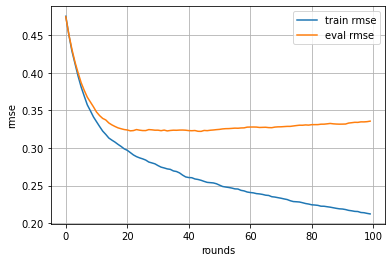

[0]	train-rmse:0.475498	eval-rmse:0.474858
[1]	train-rmse:0.450668	eval-rmse:0.450732
[2]	train-rmse:0.429169	eval-rmse:0.431522
[3]	train-rmse:0.412506	eval-rmse:0.414534
[4]	train-rmse:0.395901	eval-rmse:0.40038
[5]	train-rmse:0.381346	eval-rmse:0.387269
[6]	train-rmse:0.36893	eval-rmse:0.37599
[7]	train-rmse:0.357258	eval-rmse:0.366722
[8]	train-rmse:0.349432	eval-rmse:0.36003
[9]	train-rmse:0.341093	eval-rmse:0.35335
[10]	train-rmse:0.334688	eval-rmse:0.346506
[11]	train-rmse:0.328887	eval-rmse:0.34218
[12]	train-rmse:0.323197	eval-rmse:0.338547
[13]	train-rmse:0.318703	eval-rmse:0.336525
[14]	train-rmse:0.313902	eval-rmse:0.332877
[15]	train-rmse:0.31113	eval-rmse:0.33033
[16]	train-rmse:0.308561	eval-rmse:0.328259
[17]	train-rmse:0.305072	eval-rmse:0.328262
[18]	train-rmse:0.3022	eval-rmse:0.327631
[19]	train-rmse:0.298412	eval-rmse:0.325653
[20]	train-rmse:0.294842	eval-rmse:0.325498
[21]	train-rmse:0.29233	eval-rmse:0.324695
[22]	train-rmse:0.289785	eval-rmse:0.32476
[23]	train

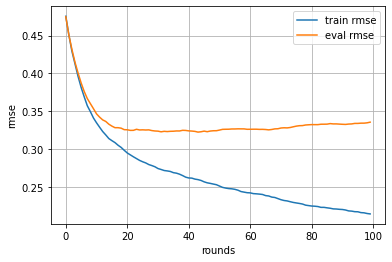

[0]	train-rmse:0.475498	eval-rmse:0.474858
[1]	train-rmse:0.450668	eval-rmse:0.450732
[2]	train-rmse:0.429169	eval-rmse:0.431522
[3]	train-rmse:0.41255	eval-rmse:0.414379
[4]	train-rmse:0.395933	eval-rmse:0.400237
[5]	train-rmse:0.381374	eval-rmse:0.387136
[6]	train-rmse:0.368954	eval-rmse:0.37586
[7]	train-rmse:0.357284	eval-rmse:0.3666
[8]	train-rmse:0.349461	eval-rmse:0.359918
[9]	train-rmse:0.341123	eval-rmse:0.353247
[10]	train-rmse:0.334606	eval-rmse:0.346505
[11]	train-rmse:0.328798	eval-rmse:0.342055
[12]	train-rmse:0.323168	eval-rmse:0.338396
[13]	train-rmse:0.319459	eval-rmse:0.335908
[14]	train-rmse:0.314643	eval-rmse:0.332283
[15]	train-rmse:0.311887	eval-rmse:0.329775
[16]	train-rmse:0.30936	eval-rmse:0.32766
[17]	train-rmse:0.305999	eval-rmse:0.327568
[18]	train-rmse:0.303173	eval-rmse:0.326968
[19]	train-rmse:0.299938	eval-rmse:0.325326
[20]	train-rmse:0.296552	eval-rmse:0.325602
[21]	train-rmse:0.293918	eval-rmse:0.324623
[22]	train-rmse:0.291166	eval-rmse:0.324833
[23]

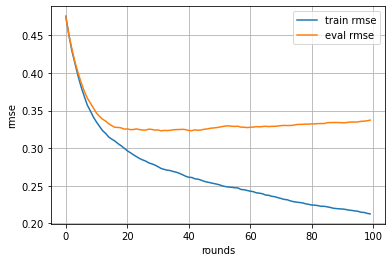

[0]	train-rmse:0.475498	eval-rmse:0.474858
[1]	train-rmse:0.450668	eval-rmse:0.450732
[2]	train-rmse:0.429169	eval-rmse:0.431522
[3]	train-rmse:0.41255	eval-rmse:0.414379
[4]	train-rmse:0.395933	eval-rmse:0.400237
[5]	train-rmse:0.381374	eval-rmse:0.387136
[6]	train-rmse:0.368954	eval-rmse:0.37586
[7]	train-rmse:0.357284	eval-rmse:0.3666
[8]	train-rmse:0.349461	eval-rmse:0.359918
[9]	train-rmse:0.341123	eval-rmse:0.353247
[10]	train-rmse:0.334595	eval-rmse:0.346538
[11]	train-rmse:0.328785	eval-rmse:0.342085
[12]	train-rmse:0.323176	eval-rmse:0.338336
[13]	train-rmse:0.319475	eval-rmse:0.335857
[14]	train-rmse:0.31467	eval-rmse:0.332242
[15]	train-rmse:0.31207	eval-rmse:0.329662
[16]	train-rmse:0.308783	eval-rmse:0.328323
[17]	train-rmse:0.305076	eval-rmse:0.328621
[18]	train-rmse:0.302511	eval-rmse:0.328043
[19]	train-rmse:0.298817	eval-rmse:0.326349
[20]	train-rmse:0.295738	eval-rmse:0.32647
[21]	train-rmse:0.292841	eval-rmse:0.324957
[22]	train-rmse:0.290604	eval-rmse:0.324543
[23]	

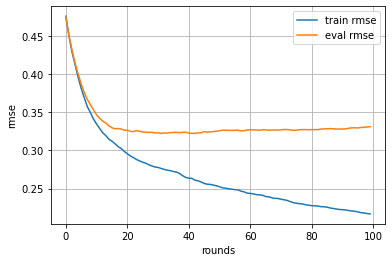

[0]	train-rmse:0.475498	eval-rmse:0.474858
[1]	train-rmse:0.450668	eval-rmse:0.450732
[2]	train-rmse:0.429169	eval-rmse:0.431522
[3]	train-rmse:0.41255	eval-rmse:0.414379
[4]	train-rmse:0.395933	eval-rmse:0.400237
[5]	train-rmse:0.381374	eval-rmse:0.387136
[6]	train-rmse:0.369021	eval-rmse:0.375947
[7]	train-rmse:0.357356	eval-rmse:0.366692
[8]	train-rmse:0.349533	eval-rmse:0.360012
[9]	train-rmse:0.341218	eval-rmse:0.353216
[10]	train-rmse:0.334687	eval-rmse:0.346512
[11]	train-rmse:0.328883	eval-rmse:0.342077
[12]	train-rmse:0.323414	eval-rmse:0.338436
[13]	train-rmse:0.319709	eval-rmse:0.335926
[14]	train-rmse:0.314918	eval-rmse:0.332314
[15]	train-rmse:0.312307	eval-rmse:0.329735
[16]	train-rmse:0.309024	eval-rmse:0.328194
[17]	train-rmse:0.305317	eval-rmse:0.328517
[18]	train-rmse:0.302937	eval-rmse:0.327992
[19]	train-rmse:0.299245	eval-rmse:0.32621
[20]	train-rmse:0.296165	eval-rmse:0.326334
[21]	train-rmse:0.293246	eval-rmse:0.324771
[22]	train-rmse:0.290897	eval-rmse:0.32524
[

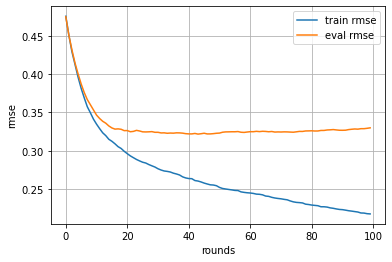

[0]	train-rmse:0.475512	eval-rmse:0.474854
[1]	train-rmse:0.450691	eval-rmse:0.450738
[2]	train-rmse:0.429193	eval-rmse:0.431523
[3]	train-rmse:0.412582	eval-rmse:0.414389
[4]	train-rmse:0.395965	eval-rmse:0.400237
[5]	train-rmse:0.381411	eval-rmse:0.387145
[6]	train-rmse:0.369061	eval-rmse:0.375958
[7]	train-rmse:0.357399	eval-rmse:0.36671
[8]	train-rmse:0.34958	eval-rmse:0.360039
[9]	train-rmse:0.341261	eval-rmse:0.353294
[10]	train-rmse:0.334765	eval-rmse:0.346523
[11]	train-rmse:0.328964	eval-rmse:0.342075
[12]	train-rmse:0.323502	eval-rmse:0.338422
[13]	train-rmse:0.319052	eval-rmse:0.336386
[14]	train-rmse:0.314267	eval-rmse:0.332754
[15]	train-rmse:0.311645	eval-rmse:0.330032
[16]	train-rmse:0.308379	eval-rmse:0.328403
[17]	train-rmse:0.304643	eval-rmse:0.328378
[18]	train-rmse:0.3025	eval-rmse:0.328005
[19]	train-rmse:0.298764	eval-rmse:0.326148
[20]	train-rmse:0.295626	eval-rmse:0.326372
[21]	train-rmse:0.293029	eval-rmse:0.325416
[22]	train-rmse:0.2904	eval-rmse:0.325598
[23]

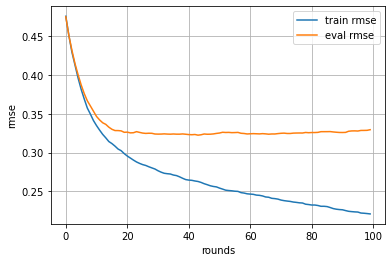

[0]	train-rmse:0.475512	eval-rmse:0.474854
[1]	train-rmse:0.450664	eval-rmse:0.450921
[2]	train-rmse:0.42918	eval-rmse:0.431702
[3]	train-rmse:0.412755	eval-rmse:0.414973
[4]	train-rmse:0.396081	eval-rmse:0.400752
[5]	train-rmse:0.381501	eval-rmse:0.387646
[6]	train-rmse:0.368538	eval-rmse:0.376559
[7]	train-rmse:0.356994	eval-rmse:0.366725
[8]	train-rmse:0.349258	eval-rmse:0.360179
[9]	train-rmse:0.340916	eval-rmse:0.353458
[10]	train-rmse:0.334368	eval-rmse:0.346684
[11]	train-rmse:0.328567	eval-rmse:0.342291
[12]	train-rmse:0.322898	eval-rmse:0.338631
[13]	train-rmse:0.318454	eval-rmse:0.336581
[14]	train-rmse:0.313688	eval-rmse:0.332983
[15]	train-rmse:0.311097	eval-rmse:0.330284
[16]	train-rmse:0.30779	eval-rmse:0.328382
[17]	train-rmse:0.304189	eval-rmse:0.328172
[18]	train-rmse:0.301761	eval-rmse:0.32754
[19]	train-rmse:0.298614	eval-rmse:0.326331
[20]	train-rmse:0.295354	eval-rmse:0.326653
[21]	train-rmse:0.292808	eval-rmse:0.325465
[22]	train-rmse:0.290318	eval-rmse:0.324423
[

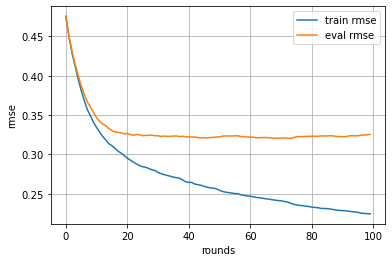

[0]	train-rmse:0.475512	eval-rmse:0.474854
[1]	train-rmse:0.450664	eval-rmse:0.450921
[2]	train-rmse:0.429245	eval-rmse:0.431539
[3]	train-rmse:0.41282	eval-rmse:0.414825
[4]	train-rmse:0.396147	eval-rmse:0.400578
[5]	train-rmse:0.381584	eval-rmse:0.387368
[6]	train-rmse:0.368648	eval-rmse:0.376317
[7]	train-rmse:0.357123	eval-rmse:0.366512
[8]	train-rmse:0.349399	eval-rmse:0.359992
[9]	train-rmse:0.341078	eval-rmse:0.353251
[10]	train-rmse:0.3346	eval-rmse:0.346471
[11]	train-rmse:0.328341	eval-rmse:0.34198
[12]	train-rmse:0.322714	eval-rmse:0.338378
[13]	train-rmse:0.318366	eval-rmse:0.336299
[14]	train-rmse:0.313591	eval-rmse:0.332737
[15]	train-rmse:0.311005	eval-rmse:0.330019
[16]	train-rmse:0.307678	eval-rmse:0.328117
[17]	train-rmse:0.304522	eval-rmse:0.326429
[18]	train-rmse:0.302244	eval-rmse:0.325604
[19]	train-rmse:0.299072	eval-rmse:0.324396
[20]	train-rmse:0.295689	eval-rmse:0.32502
[21]	train-rmse:0.293301	eval-rmse:0.323496
[22]	train-rmse:0.2907	eval-rmse:0.322141
[23]	

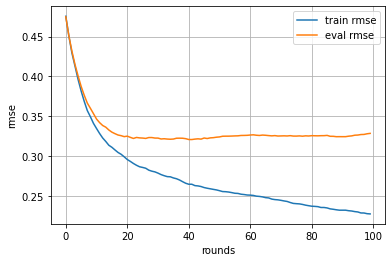

[0]	train-rmse:0.475512	eval-rmse:0.474854
[1]	train-rmse:0.450673	eval-rmse:0.450921
[2]	train-rmse:0.42919	eval-rmse:0.431579
[3]	train-rmse:0.412751	eval-rmse:0.414865
[4]	train-rmse:0.396075	eval-rmse:0.400617
[5]	train-rmse:0.381514	eval-rmse:0.387409
[6]	train-rmse:0.368591	eval-rmse:0.376358
[7]	train-rmse:0.35707	eval-rmse:0.366559
[8]	train-rmse:0.34935	eval-rmse:0.360043
[9]	train-rmse:0.341041	eval-rmse:0.3533
[10]	train-rmse:0.334614	eval-rmse:0.346439
[11]	train-rmse:0.328812	eval-rmse:0.342077
[12]	train-rmse:0.323148	eval-rmse:0.338455
[13]	train-rmse:0.318703	eval-rmse:0.336415
[14]	train-rmse:0.313929	eval-rmse:0.332831
[15]	train-rmse:0.311343	eval-rmse:0.330159
[16]	train-rmse:0.308094	eval-rmse:0.328552
[17]	train-rmse:0.304535	eval-rmse:0.328253
[18]	train-rmse:0.302177	eval-rmse:0.327434
[19]	train-rmse:0.299019	eval-rmse:0.326244
[20]	train-rmse:0.295623	eval-rmse:0.326661
[21]	train-rmse:0.292986	eval-rmse:0.32527
[22]	train-rmse:0.290372	eval-rmse:0.325212
[23]

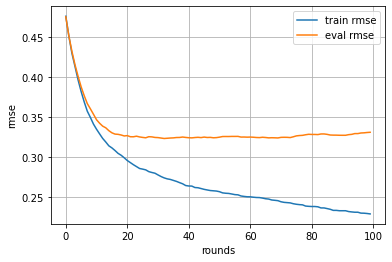

[0]	train-rmse:0.475512	eval-rmse:0.474854
[1]	train-rmse:0.450673	eval-rmse:0.450921
[2]	train-rmse:0.42919	eval-rmse:0.431579
[3]	train-rmse:0.412751	eval-rmse:0.414865
[4]	train-rmse:0.396075	eval-rmse:0.400617
[5]	train-rmse:0.381514	eval-rmse:0.387409
[6]	train-rmse:0.368591	eval-rmse:0.376358
[7]	train-rmse:0.357124	eval-rmse:0.366559
[8]	train-rmse:0.349401	eval-rmse:0.360046
[9]	train-rmse:0.341087	eval-rmse:0.353306
[10]	train-rmse:0.334661	eval-rmse:0.346445
[11]	train-rmse:0.328854	eval-rmse:0.342081
[12]	train-rmse:0.323189	eval-rmse:0.338458
[13]	train-rmse:0.318855	eval-rmse:0.336422
[14]	train-rmse:0.314064	eval-rmse:0.332816
[15]	train-rmse:0.31152	eval-rmse:0.330145
[16]	train-rmse:0.308265	eval-rmse:0.328532
[17]	train-rmse:0.304755	eval-rmse:0.328358
[18]	train-rmse:0.302436	eval-rmse:0.327674
[19]	train-rmse:0.298732	eval-rmse:0.325631
[20]	train-rmse:0.295317	eval-rmse:0.326051
[21]	train-rmse:0.292494	eval-rmse:0.324908
[22]	train-rmse:0.289982	eval-rmse:0.325051


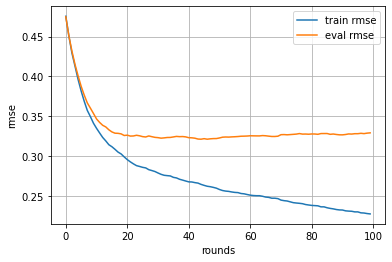

[0]	train-rmse:0.475512	eval-rmse:0.474854
[1]	train-rmse:0.450673	eval-rmse:0.450921
[2]	train-rmse:0.42919	eval-rmse:0.431579
[3]	train-rmse:0.412751	eval-rmse:0.414865
[4]	train-rmse:0.396113	eval-rmse:0.400354
[5]	train-rmse:0.381597	eval-rmse:0.387245
[6]	train-rmse:0.368688	eval-rmse:0.376215
[7]	train-rmse:0.357231	eval-rmse:0.366445
[8]	train-rmse:0.349592	eval-rmse:0.360071
[9]	train-rmse:0.341278	eval-rmse:0.353356
[10]	train-rmse:0.33484	eval-rmse:0.346491
[11]	train-rmse:0.329035	eval-rmse:0.342153
[12]	train-rmse:0.323379	eval-rmse:0.338563
[13]	train-rmse:0.319189	eval-rmse:0.33669
[14]	train-rmse:0.314455	eval-rmse:0.333055
[15]	train-rmse:0.311893	eval-rmse:0.330387
[16]	train-rmse:0.308713	eval-rmse:0.328843
[17]	train-rmse:0.305192	eval-rmse:0.328659
[18]	train-rmse:0.30303	eval-rmse:0.327919
[19]	train-rmse:0.299315	eval-rmse:0.325877
[20]	train-rmse:0.296789	eval-rmse:0.326973
[21]	train-rmse:0.294007	eval-rmse:0.325778
[22]	train-rmse:0.291287	eval-rmse:0.3261
[23]

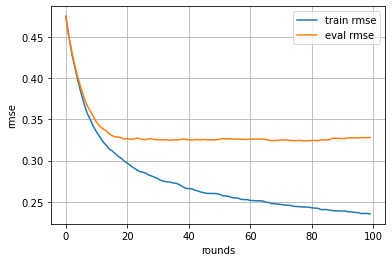

[0]	train-rmse:0.475512	eval-rmse:0.474854
[1]	train-rmse:0.450673	eval-rmse:0.450921
[2]	train-rmse:0.42919	eval-rmse:0.431579
[3]	train-rmse:0.412751	eval-rmse:0.414865
[4]	train-rmse:0.396113	eval-rmse:0.400354
[5]	train-rmse:0.381597	eval-rmse:0.387245
[6]	train-rmse:0.368688	eval-rmse:0.376215
[7]	train-rmse:0.357231	eval-rmse:0.366445
[8]	train-rmse:0.349592	eval-rmse:0.360071
[9]	train-rmse:0.341278	eval-rmse:0.353356
[10]	train-rmse:0.334922	eval-rmse:0.346543
[11]	train-rmse:0.329104	eval-rmse:0.342198
[12]	train-rmse:0.323437	eval-rmse:0.338601
[13]	train-rmse:0.319244	eval-rmse:0.336724
[14]	train-rmse:0.3145	eval-rmse:0.333082
[15]	train-rmse:0.312041	eval-rmse:0.330532
[16]	train-rmse:0.309506	eval-rmse:0.328851
[17]	train-rmse:0.305609	eval-rmse:0.329252
[18]	train-rmse:0.303334	eval-rmse:0.328411
[19]	train-rmse:0.299929	eval-rmse:0.32656
[20]	train-rmse:0.297573	eval-rmse:0.327916
[21]	train-rmse:0.294767	eval-rmse:0.326625
[22]	train-rmse:0.291975	eval-rmse:0.326894
[2

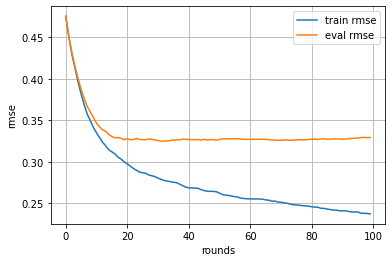

[0]	train-rmse:0.475512	eval-rmse:0.474854
[1]	train-rmse:0.450673	eval-rmse:0.450921
[2]	train-rmse:0.42919	eval-rmse:0.431579
[3]	train-rmse:0.412751	eval-rmse:0.414865
[4]	train-rmse:0.396118	eval-rmse:0.400327
[5]	train-rmse:0.381607	eval-rmse:0.387229
[6]	train-rmse:0.368695	eval-rmse:0.376196
[7]	train-rmse:0.357244	eval-rmse:0.366458
[8]	train-rmse:0.34961	eval-rmse:0.360096
[9]	train-rmse:0.341299	eval-rmse:0.353393
[10]	train-rmse:0.334933	eval-rmse:0.346562
[11]	train-rmse:0.329124	eval-rmse:0.342241
[12]	train-rmse:0.323463	eval-rmse:0.338652
[13]	train-rmse:0.319274	eval-rmse:0.336783
[14]	train-rmse:0.314533	eval-rmse:0.333148
[15]	train-rmse:0.312205	eval-rmse:0.330733
[16]	train-rmse:0.309661	eval-rmse:0.329051
[17]	train-rmse:0.305774	eval-rmse:0.329449
[18]	train-rmse:0.303501	eval-rmse:0.328624
[19]	train-rmse:0.300081	eval-rmse:0.326762
[20]	train-rmse:0.296896	eval-rmse:0.327141
[21]	train-rmse:0.29425	eval-rmse:0.326124
[22]	train-rmse:0.291477	eval-rmse:0.326344
[

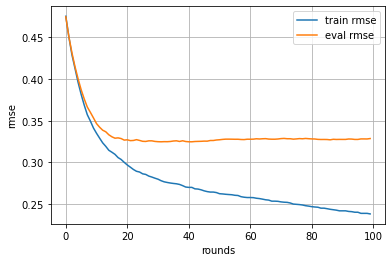

[0]	train-rmse:0.475512	eval-rmse:0.474854
[1]	train-rmse:0.450673	eval-rmse:0.450921
[2]	train-rmse:0.42919	eval-rmse:0.431579
[3]	train-rmse:0.412751	eval-rmse:0.414865
[4]	train-rmse:0.396118	eval-rmse:0.400327
[5]	train-rmse:0.381673	eval-rmse:0.387237
[6]	train-rmse:0.368762	eval-rmse:0.376198
[7]	train-rmse:0.357334	eval-rmse:0.366684
[8]	train-rmse:0.349694	eval-rmse:0.360295
[9]	train-rmse:0.341545	eval-rmse:0.353848
[10]	train-rmse:0.335135	eval-rmse:0.347269
[11]	train-rmse:0.328832	eval-rmse:0.34276
[12]	train-rmse:0.323253	eval-rmse:0.339098
[13]	train-rmse:0.319191	eval-rmse:0.336998
[14]	train-rmse:0.314542	eval-rmse:0.333403
[15]	train-rmse:0.312214	eval-rmse:0.330923
[16]	train-rmse:0.308998	eval-rmse:0.329333
[17]	train-rmse:0.305327	eval-rmse:0.329099
[18]	train-rmse:0.303215	eval-rmse:0.328426
[19]	train-rmse:0.300173	eval-rmse:0.3271
[20]	train-rmse:0.296782	eval-rmse:0.326939
[21]	train-rmse:0.294583	eval-rmse:0.326079
[22]	train-rmse:0.292091	eval-rmse:0.324529
[2

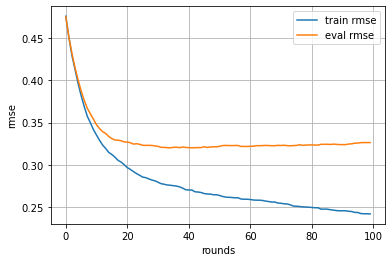

[0]	train-rmse:0.475512	eval-rmse:0.474854
[1]	train-rmse:0.450673	eval-rmse:0.450921
[2]	train-rmse:0.429247	eval-rmse:0.431274
[3]	train-rmse:0.412638	eval-rmse:0.414178
[4]	train-rmse:0.396101	eval-rmse:0.399679
[5]	train-rmse:0.381699	eval-rmse:0.386619
[6]	train-rmse:0.369405	eval-rmse:0.375319
[7]	train-rmse:0.357837	eval-rmse:0.366174
[8]	train-rmse:0.350154	eval-rmse:0.35974
[9]	train-rmse:0.342177	eval-rmse:0.353097
[10]	train-rmse:0.33591	eval-rmse:0.346376
[11]	train-rmse:0.329761	eval-rmse:0.341884
[12]	train-rmse:0.324374	eval-rmse:0.338489
[13]	train-rmse:0.320159	eval-rmse:0.336557
[14]	train-rmse:0.315473	eval-rmse:0.332928
[15]	train-rmse:0.313136	eval-rmse:0.330432
[16]	train-rmse:0.310021	eval-rmse:0.328823
[17]	train-rmse:0.306343	eval-rmse:0.328595
[18]	train-rmse:0.304139	eval-rmse:0.327888
[19]	train-rmse:0.301154	eval-rmse:0.326698
[20]	train-rmse:0.297833	eval-rmse:0.327576
[21]	train-rmse:0.295838	eval-rmse:0.326114
[22]	train-rmse:0.29368	eval-rmse:0.324627
[

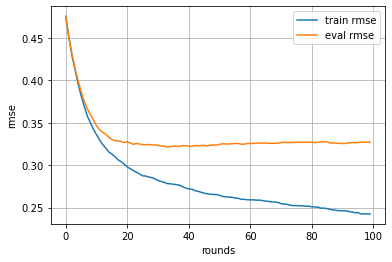

[0]	train-rmse:0.475585	eval-rmse:0.474966
[1]	train-rmse:0.450731	eval-rmse:0.451024
[2]	train-rmse:0.429364	eval-rmse:0.431374
[3]	train-rmse:0.412741	eval-rmse:0.414274
[4]	train-rmse:0.396199	eval-rmse:0.39978
[5]	train-rmse:0.381492	eval-rmse:0.387319
[6]	train-rmse:0.369186	eval-rmse:0.37599
[7]	train-rmse:0.357637	eval-rmse:0.366643
[8]	train-rmse:0.349962	eval-rmse:0.36019
[9]	train-rmse:0.341973	eval-rmse:0.353531
[10]	train-rmse:0.335526	eval-rmse:0.3468
[11]	train-rmse:0.329416	eval-rmse:0.342306
[12]	train-rmse:0.324039	eval-rmse:0.3389
[13]	train-rmse:0.319901	eval-rmse:0.33679
[14]	train-rmse:0.315223	eval-rmse:0.333147
[15]	train-rmse:0.312886	eval-rmse:0.330653
[16]	train-rmse:0.309787	eval-rmse:0.329069
[17]	train-rmse:0.305837	eval-rmse:0.329328
[18]	train-rmse:0.303826	eval-rmse:0.328578
[19]	train-rmse:0.300852	eval-rmse:0.32733
[20]	train-rmse:0.297602	eval-rmse:0.327315
[21]	train-rmse:0.295454	eval-rmse:0.326579
[22]	train-rmse:0.293265	eval-rmse:0.325259
[23]	tr

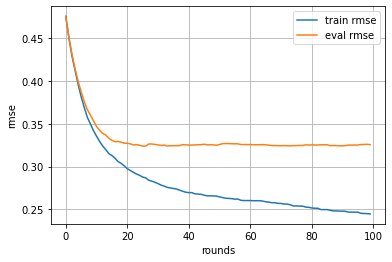

[0]	train-rmse:0.475585	eval-rmse:0.474966
[1]	train-rmse:0.450731	eval-rmse:0.451024
[2]	train-rmse:0.429364	eval-rmse:0.431374
[3]	train-rmse:0.412741	eval-rmse:0.414274
[4]	train-rmse:0.396199	eval-rmse:0.39978
[5]	train-rmse:0.381492	eval-rmse:0.387319
[6]	train-rmse:0.369186	eval-rmse:0.37599
[7]	train-rmse:0.357637	eval-rmse:0.366643
[8]	train-rmse:0.350026	eval-rmse:0.360457
[9]	train-rmse:0.342038	eval-rmse:0.353795
[10]	train-rmse:0.335686	eval-rmse:0.347007
[11]	train-rmse:0.32958	eval-rmse:0.342513
[12]	train-rmse:0.323986	eval-rmse:0.338832
[13]	train-rmse:0.32003	eval-rmse:0.336538
[14]	train-rmse:0.315374	eval-rmse:0.332919
[15]	train-rmse:0.313127	eval-rmse:0.330561
[16]	train-rmse:0.310252	eval-rmse:0.329434
[17]	train-rmse:0.306521	eval-rmse:0.329667
[18]	train-rmse:0.304609	eval-rmse:0.328956
[19]	train-rmse:0.301751	eval-rmse:0.327824
[20]	train-rmse:0.298471	eval-rmse:0.327818
[21]	train-rmse:0.296286	eval-rmse:0.326918
[22]	train-rmse:0.294187	eval-rmse:0.325472
[2

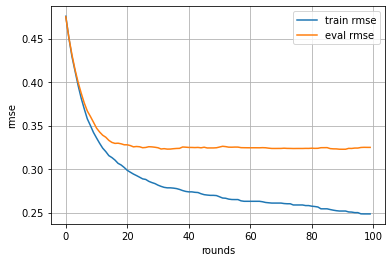

[0]	train-rmse:0.475585	eval-rmse:0.474966
[1]	train-rmse:0.450799	eval-rmse:0.451024
[2]	train-rmse:0.429435	eval-rmse:0.431374
[3]	train-rmse:0.412804	eval-rmse:0.414271
[4]	train-rmse:0.396255	eval-rmse:0.399781
[5]	train-rmse:0.381543	eval-rmse:0.387317
[6]	train-rmse:0.369343	eval-rmse:0.376098
[7]	train-rmse:0.357795	eval-rmse:0.366741
[8]	train-rmse:0.350181	eval-rmse:0.360548
[9]	train-rmse:0.342201	eval-rmse:0.353864
[10]	train-rmse:0.335837	eval-rmse:0.347054
[11]	train-rmse:0.329732	eval-rmse:0.342551
[12]	train-rmse:0.324127	eval-rmse:0.338859
[13]	train-rmse:0.320168	eval-rmse:0.33657
[14]	train-rmse:0.31551	eval-rmse:0.33293
[15]	train-rmse:0.313266	eval-rmse:0.330573
[16]	train-rmse:0.310391	eval-rmse:0.329449
[17]	train-rmse:0.306653	eval-rmse:0.329702
[18]	train-rmse:0.304737	eval-rmse:0.32898
[19]	train-rmse:0.301981	eval-rmse:0.327888
[20]	train-rmse:0.298704	eval-rmse:0.327883
[21]	train-rmse:0.296522	eval-rmse:0.326984
[22]	train-rmse:0.294553	eval-rmse:0.326378
[2

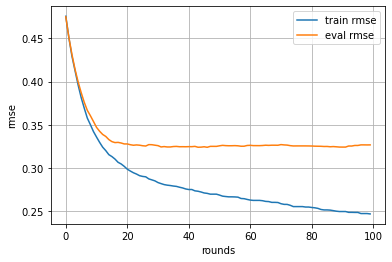

[0]	train-rmse:0.475585	eval-rmse:0.474966
[1]	train-rmse:0.450799	eval-rmse:0.451024
[2]	train-rmse:0.429435	eval-rmse:0.431374
[3]	train-rmse:0.412804	eval-rmse:0.414271
[4]	train-rmse:0.396255	eval-rmse:0.399781
[5]	train-rmse:0.381543	eval-rmse:0.387317
[6]	train-rmse:0.369343	eval-rmse:0.376098
[7]	train-rmse:0.357795	eval-rmse:0.366741
[8]	train-rmse:0.350181	eval-rmse:0.360548
[9]	train-rmse:0.342283	eval-rmse:0.353796
[10]	train-rmse:0.336107	eval-rmse:0.34688
[11]	train-rmse:0.329982	eval-rmse:0.342377
[12]	train-rmse:0.324374	eval-rmse:0.338686
[13]	train-rmse:0.320378	eval-rmse:0.33638
[14]	train-rmse:0.31574	eval-rmse:0.332752
[15]	train-rmse:0.3136	eval-rmse:0.330328
[16]	train-rmse:0.310699	eval-rmse:0.329191
[17]	train-rmse:0.307068	eval-rmse:0.328169
[18]	train-rmse:0.305143	eval-rmse:0.32745
[19]	train-rmse:0.302372	eval-rmse:0.326355
[20]	train-rmse:0.299098	eval-rmse:0.326348
[21]	train-rmse:0.296933	eval-rmse:0.325609
[22]	train-rmse:0.294962	eval-rmse:0.325002
[23]

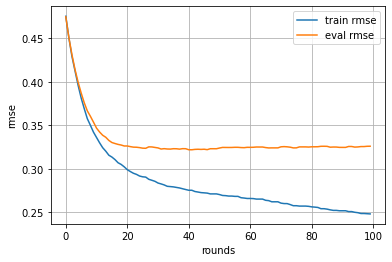

[0]	train-rmse:0.475585	eval-rmse:0.474966
[1]	train-rmse:0.450799	eval-rmse:0.451024
[2]	train-rmse:0.429435	eval-rmse:0.431374
[3]	train-rmse:0.412804	eval-rmse:0.414271
[4]	train-rmse:0.396371	eval-rmse:0.399918
[5]	train-rmse:0.381662	eval-rmse:0.387443
[6]	train-rmse:0.369338	eval-rmse:0.376092
[7]	train-rmse:0.357791	eval-rmse:0.366736
[8]	train-rmse:0.350177	eval-rmse:0.360543
[9]	train-rmse:0.342279	eval-rmse:0.353792
[10]	train-rmse:0.336104	eval-rmse:0.346877
[11]	train-rmse:0.329979	eval-rmse:0.342374
[12]	train-rmse:0.324371	eval-rmse:0.338684
[13]	train-rmse:0.320375	eval-rmse:0.336378
[14]	train-rmse:0.315737	eval-rmse:0.33275
[15]	train-rmse:0.313723	eval-rmse:0.330295
[16]	train-rmse:0.310802	eval-rmse:0.329149
[17]	train-rmse:0.307169	eval-rmse:0.328121
[18]	train-rmse:0.305367	eval-rmse:0.327424
[19]	train-rmse:0.302589	eval-rmse:0.326335
[20]	train-rmse:0.299526	eval-rmse:0.326394
[21]	train-rmse:0.297357	eval-rmse:0.325672
[22]	train-rmse:0.295483	eval-rmse:0.324958

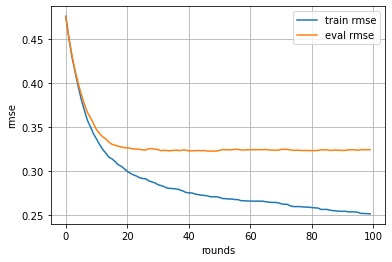

[0]	train-rmse:0.475585	eval-rmse:0.474966
[1]	train-rmse:0.450799	eval-rmse:0.451024
[2]	train-rmse:0.429435	eval-rmse:0.431374
[3]	train-rmse:0.412804	eval-rmse:0.414271
[4]	train-rmse:0.396371	eval-rmse:0.399918
[5]	train-rmse:0.381662	eval-rmse:0.387443
[6]	train-rmse:0.369338	eval-rmse:0.376092
[7]	train-rmse:0.357791	eval-rmse:0.366736
[8]	train-rmse:0.350177	eval-rmse:0.360543
[9]	train-rmse:0.342279	eval-rmse:0.353792
[10]	train-rmse:0.336104	eval-rmse:0.346877
[11]	train-rmse:0.330092	eval-rmse:0.342374
[12]	train-rmse:0.324485	eval-rmse:0.338684
[13]	train-rmse:0.320491	eval-rmse:0.336378
[14]	train-rmse:0.315856	eval-rmse:0.332752
[15]	train-rmse:0.313843	eval-rmse:0.330296
[16]	train-rmse:0.310924	eval-rmse:0.32915
[17]	train-rmse:0.307278	eval-rmse:0.328133
[18]	train-rmse:0.305475	eval-rmse:0.327435
[19]	train-rmse:0.302695	eval-rmse:0.326347
[20]	train-rmse:0.29967	eval-rmse:0.326437
[21]	train-rmse:0.297809	eval-rmse:0.325694
[22]	train-rmse:0.295731	eval-rmse:0.3247
[2

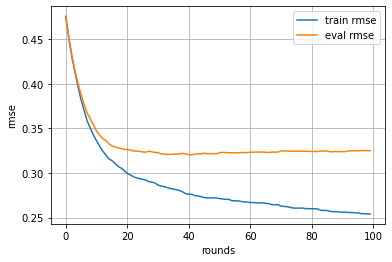

[0]	train-rmse:0.475585	eval-rmse:0.474966
[1]	train-rmse:0.450799	eval-rmse:0.451024
[2]	train-rmse:0.429435	eval-rmse:0.431374
[3]	train-rmse:0.412804	eval-rmse:0.414271
[4]	train-rmse:0.396371	eval-rmse:0.399918
[5]	train-rmse:0.381662	eval-rmse:0.387443
[6]	train-rmse:0.369338	eval-rmse:0.376092
[7]	train-rmse:0.357791	eval-rmse:0.366736
[8]	train-rmse:0.350177	eval-rmse:0.360543
[9]	train-rmse:0.342279	eval-rmse:0.353792
[10]	train-rmse:0.336104	eval-rmse:0.346877
[11]	train-rmse:0.330244	eval-rmse:0.34227
[12]	train-rmse:0.324638	eval-rmse:0.338602
[13]	train-rmse:0.320643	eval-rmse:0.336314
[14]	train-rmse:0.316023	eval-rmse:0.332712
[15]	train-rmse:0.314132	eval-rmse:0.330451
[16]	train-rmse:0.311225	eval-rmse:0.329337
[17]	train-rmse:0.307573	eval-rmse:0.328318
[18]	train-rmse:0.305781	eval-rmse:0.327646
[19]	train-rmse:0.303014	eval-rmse:0.326589
[20]	train-rmse:0.30013	eval-rmse:0.326956
[21]	train-rmse:0.298269	eval-rmse:0.32621
[22]	train-rmse:0.296184	eval-rmse:0.325223
[

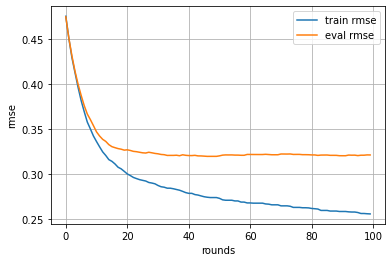

[0]	train-rmse:0.475585	eval-rmse:0.474966
[1]	train-rmse:0.450799	eval-rmse:0.451024
[2]	train-rmse:0.429755	eval-rmse:0.431721
[3]	train-rmse:0.413095	eval-rmse:0.414601
[4]	train-rmse:0.39662	eval-rmse:0.400253
[5]	train-rmse:0.382199	eval-rmse:0.387167
[6]	train-rmse:0.370015	eval-rmse:0.375957
[7]	train-rmse:0.358455	eval-rmse:0.366597
[8]	train-rmse:0.350819	eval-rmse:0.360435
[9]	train-rmse:0.342725	eval-rmse:0.353377
[10]	train-rmse:0.33681	eval-rmse:0.346471
[11]	train-rmse:0.330773	eval-rmse:0.341864
[12]	train-rmse:0.32514	eval-rmse:0.338196
[13]	train-rmse:0.321095	eval-rmse:0.335831
[14]	train-rmse:0.31648	eval-rmse:0.332252
[15]	train-rmse:0.3146	eval-rmse:0.330001
[16]	train-rmse:0.31222	eval-rmse:0.328219
[17]	train-rmse:0.308525	eval-rmse:0.327219
[18]	train-rmse:0.306725	eval-rmse:0.326551
[19]	train-rmse:0.304074	eval-rmse:0.325489
[20]	train-rmse:0.300861	eval-rmse:0.326007
[21]	train-rmse:0.299113	eval-rmse:0.325373
[22]	train-rmse:0.297111	eval-rmse:0.323928
[23]	

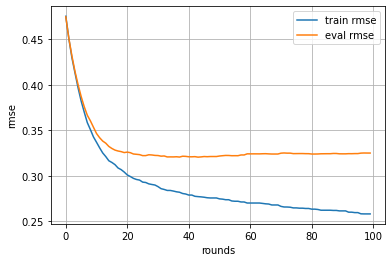

[0]	train-rmse:0.475585	eval-rmse:0.474966
[1]	train-rmse:0.450799	eval-rmse:0.451024
[2]	train-rmse:0.429755	eval-rmse:0.431721
[3]	train-rmse:0.413095	eval-rmse:0.414601
[4]	train-rmse:0.39662	eval-rmse:0.400253
[5]	train-rmse:0.382343	eval-rmse:0.387094
[6]	train-rmse:0.370154	eval-rmse:0.375881
[7]	train-rmse:0.358716	eval-rmse:0.366629
[8]	train-rmse:0.351055	eval-rmse:0.360444
[9]	train-rmse:0.342936	eval-rmse:0.353398
[10]	train-rmse:0.337025	eval-rmse:0.34649
[11]	train-rmse:0.330982	eval-rmse:0.341883
[12]	train-rmse:0.325391	eval-rmse:0.338317
[13]	train-rmse:0.321341	eval-rmse:0.335953
[14]	train-rmse:0.316718	eval-rmse:0.332379
[15]	train-rmse:0.314846	eval-rmse:0.330128
[16]	train-rmse:0.312471	eval-rmse:0.328344
[17]	train-rmse:0.308958	eval-rmse:0.327322
[18]	train-rmse:0.307148	eval-rmse:0.326652
[19]	train-rmse:0.304493	eval-rmse:0.325586
[20]	train-rmse:0.301283	eval-rmse:0.326113
[21]	train-rmse:0.29925	eval-rmse:0.325332
[22]	train-rmse:0.297564	eval-rmse:0.324703
[

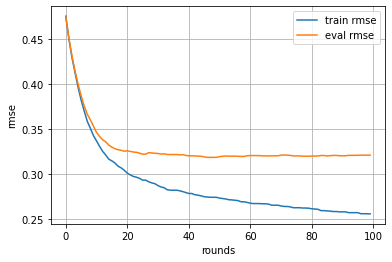

[0]	train-rmse:0.475585	eval-rmse:0.474966
[1]	train-rmse:0.450799	eval-rmse:0.451024
[2]	train-rmse:0.429755	eval-rmse:0.431721
[3]	train-rmse:0.413095	eval-rmse:0.414601
[4]	train-rmse:0.39662	eval-rmse:0.400253
[5]	train-rmse:0.382343	eval-rmse:0.387094
[6]	train-rmse:0.370154	eval-rmse:0.375881
[7]	train-rmse:0.358716	eval-rmse:0.366629
[8]	train-rmse:0.351055	eval-rmse:0.360444
[9]	train-rmse:0.342936	eval-rmse:0.353398
[10]	train-rmse:0.337025	eval-rmse:0.34649
[11]	train-rmse:0.330982	eval-rmse:0.341883
[12]	train-rmse:0.325391	eval-rmse:0.338317
[13]	train-rmse:0.321341	eval-rmse:0.335953
[14]	train-rmse:0.316718	eval-rmse:0.332379
[15]	train-rmse:0.314846	eval-rmse:0.330128
[16]	train-rmse:0.312617	eval-rmse:0.328372
[17]	train-rmse:0.309418	eval-rmse:0.327078
[18]	train-rmse:0.307608	eval-rmse:0.326411
[19]	train-rmse:0.304949	eval-rmse:0.325347
[20]	train-rmse:0.301922	eval-rmse:0.325695
[21]	train-rmse:0.299881	eval-rmse:0.324906
[22]	train-rmse:0.298524	eval-rmse:0.324688


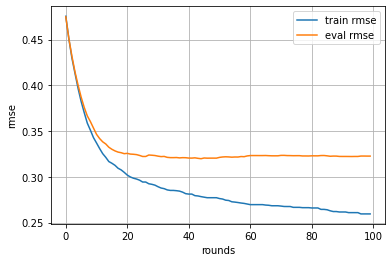

[0]	train-rmse:0.475585	eval-rmse:0.474966
[1]	train-rmse:0.450799	eval-rmse:0.451024
[2]	train-rmse:0.429755	eval-rmse:0.431721
[3]	train-rmse:0.413095	eval-rmse:0.414601
[4]	train-rmse:0.396691	eval-rmse:0.4003
[5]	train-rmse:0.382417	eval-rmse:0.387149
[6]	train-rmse:0.37036	eval-rmse:0.375741
[7]	train-rmse:0.358952	eval-rmse:0.366516
[8]	train-rmse:0.351305	eval-rmse:0.360668
[9]	train-rmse:0.3432	eval-rmse:0.35367
[10]	train-rmse:0.337294	eval-rmse:0.346743
[11]	train-rmse:0.331384	eval-rmse:0.34211
[12]	train-rmse:0.32567	eval-rmse:0.338797
[13]	train-rmse:0.321747	eval-rmse:0.336483
[14]	train-rmse:0.317075	eval-rmse:0.332866
[15]	train-rmse:0.315219	eval-rmse:0.33064
[16]	train-rmse:0.313	eval-rmse:0.328901
[17]	train-rmse:0.309791	eval-rmse:0.327629
[18]	train-rmse:0.307985	eval-rmse:0.326951
[19]	train-rmse:0.305339	eval-rmse:0.325911
[20]	train-rmse:0.302036	eval-rmse:0.326308
[21]	train-rmse:0.300436	eval-rmse:0.325894
[22]	train-rmse:0.298781	eval-rmse:0.324844
[23]	train

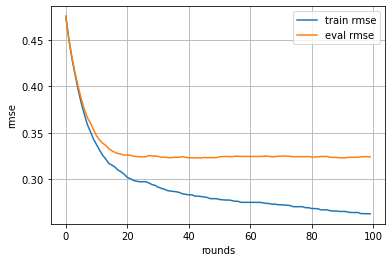

[0]	train-rmse:0.475585	eval-rmse:0.474966
[1]	train-rmse:0.450799	eval-rmse:0.451024
[2]	train-rmse:0.429755	eval-rmse:0.431721
[3]	train-rmse:0.413095	eval-rmse:0.414601
[4]	train-rmse:0.396691	eval-rmse:0.4003
[5]	train-rmse:0.382417	eval-rmse:0.387149
[6]	train-rmse:0.370491	eval-rmse:0.37607
[7]	train-rmse:0.359081	eval-rmse:0.366865
[8]	train-rmse:0.35143	eval-rmse:0.36101
[9]	train-rmse:0.343318	eval-rmse:0.354007
[10]	train-rmse:0.3374	eval-rmse:0.347061
[11]	train-rmse:0.331666	eval-rmse:0.342526
[12]	train-rmse:0.326117	eval-rmse:0.339264
[13]	train-rmse:0.322187	eval-rmse:0.336952
[14]	train-rmse:0.31756	eval-rmse:0.333029
[15]	train-rmse:0.315695	eval-rmse:0.330795
[16]	train-rmse:0.313468	eval-rmse:0.32905
[17]	train-rmse:0.310258	eval-rmse:0.327801
[18]	train-rmse:0.308438	eval-rmse:0.327094
[19]	train-rmse:0.305769	eval-rmse:0.326063
[20]	train-rmse:0.303001	eval-rmse:0.326321
[21]	train-rmse:0.301411	eval-rmse:0.325852
[22]	train-rmse:0.29973	eval-rmse:0.324751
[23]	tra

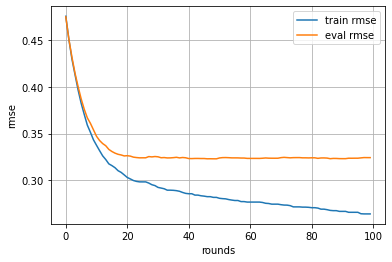

[0]	train-rmse:0.475585	eval-rmse:0.474966
[1]	train-rmse:0.450799	eval-rmse:0.451024
[2]	train-rmse:0.429755	eval-rmse:0.431721
[3]	train-rmse:0.413095	eval-rmse:0.414601
[4]	train-rmse:0.396691	eval-rmse:0.4003
[5]	train-rmse:0.382417	eval-rmse:0.387149
[6]	train-rmse:0.370491	eval-rmse:0.37607
[7]	train-rmse:0.359081	eval-rmse:0.366865
[8]	train-rmse:0.35143	eval-rmse:0.36101
[9]	train-rmse:0.343421	eval-rmse:0.354185
[10]	train-rmse:0.337502	eval-rmse:0.347233
[11]	train-rmse:0.331764	eval-rmse:0.342692
[12]	train-rmse:0.326406	eval-rmse:0.339221
[13]	train-rmse:0.322479	eval-rmse:0.336902
[14]	train-rmse:0.317867	eval-rmse:0.332967
[15]	train-rmse:0.316001	eval-rmse:0.330733
[16]	train-rmse:0.313774	eval-rmse:0.32898
[17]	train-rmse:0.310566	eval-rmse:0.327723
[18]	train-rmse:0.308746	eval-rmse:0.327013
[19]	train-rmse:0.306066	eval-rmse:0.325986
[20]	train-rmse:0.303289	eval-rmse:0.326252
[21]	train-rmse:0.301694	eval-rmse:0.32579
[22]	train-rmse:0.300001	eval-rmse:0.324685
[23]	

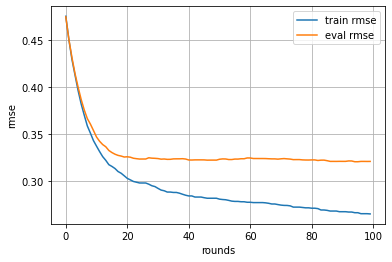

[0]	train-rmse:0.475585	eval-rmse:0.474966
[1]	train-rmse:0.450799	eval-rmse:0.451024
[2]	train-rmse:0.429755	eval-rmse:0.431721
[3]	train-rmse:0.413095	eval-rmse:0.414601
[4]	train-rmse:0.396691	eval-rmse:0.4003
[5]	train-rmse:0.382417	eval-rmse:0.387149
[6]	train-rmse:0.370614	eval-rmse:0.376154
[7]	train-rmse:0.35921	eval-rmse:0.366959
[8]	train-rmse:0.351564	eval-rmse:0.361111
[9]	train-rmse:0.34356	eval-rmse:0.354298
[10]	train-rmse:0.337761	eval-rmse:0.347451
[11]	train-rmse:0.33202	eval-rmse:0.342914
[12]	train-rmse:0.326837	eval-rmse:0.339558
[13]	train-rmse:0.322921	eval-rmse:0.337257
[14]	train-rmse:0.318241	eval-rmse:0.333596
[15]	train-rmse:0.316373	eval-rmse:0.331373
[16]	train-rmse:0.314345	eval-rmse:0.329757
[17]	train-rmse:0.311119	eval-rmse:0.328473
[18]	train-rmse:0.30929	eval-rmse:0.327753
[19]	train-rmse:0.306609	eval-rmse:0.326708
[20]	train-rmse:0.303297	eval-rmse:0.327113
[21]	train-rmse:0.301343	eval-rmse:0.32657
[22]	train-rmse:0.299994	eval-rmse:0.326399
[23]	

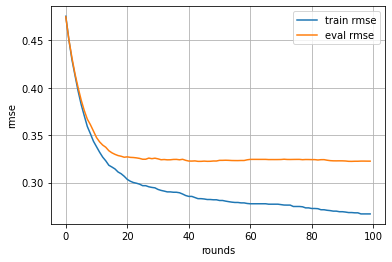

[0]	train-rmse:0.475585	eval-rmse:0.474966
[1]	train-rmse:0.450929	eval-rmse:0.45116
[2]	train-rmse:0.42989	eval-rmse:0.431852
[3]	train-rmse:0.413251	eval-rmse:0.415156
[4]	train-rmse:0.396808	eval-rmse:0.400843
[5]	train-rmse:0.382531	eval-rmse:0.387661
[6]	train-rmse:0.370728	eval-rmse:0.376665
[7]	train-rmse:0.359457	eval-rmse:0.36708
[8]	train-rmse:0.351763	eval-rmse:0.361239
[9]	train-rmse:0.343861	eval-rmse:0.354359
[10]	train-rmse:0.338193	eval-rmse:0.347559
[11]	train-rmse:0.332503	eval-rmse:0.343035
[12]	train-rmse:0.327554	eval-rmse:0.339968
[13]	train-rmse:0.323676	eval-rmse:0.337652
[14]	train-rmse:0.318988	eval-rmse:0.333976
[15]	train-rmse:0.317115	eval-rmse:0.33173
[16]	train-rmse:0.315048	eval-rmse:0.330015
[17]	train-rmse:0.311946	eval-rmse:0.328637
[18]	train-rmse:0.310154	eval-rmse:0.327955
[19]	train-rmse:0.307721	eval-rmse:0.326903
[20]	train-rmse:0.304876	eval-rmse:0.326682
[21]	train-rmse:0.302733	eval-rmse:0.326664
[22]	train-rmse:0.301564	eval-rmse:0.326503
[2

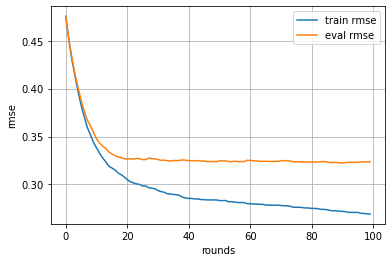

[0]	train-rmse:0.475585	eval-rmse:0.474966
[1]	train-rmse:0.450929	eval-rmse:0.45116
[2]	train-rmse:0.42989	eval-rmse:0.431852
[3]	train-rmse:0.413251	eval-rmse:0.415156
[4]	train-rmse:0.396808	eval-rmse:0.400843
[5]	train-rmse:0.382734	eval-rmse:0.387702
[6]	train-rmse:0.370918	eval-rmse:0.376705
[7]	train-rmse:0.359608	eval-rmse:0.367096
[8]	train-rmse:0.351884	eval-rmse:0.36124
[9]	train-rmse:0.344138	eval-rmse:0.354344
[10]	train-rmse:0.338457	eval-rmse:0.347547
[11]	train-rmse:0.33299	eval-rmse:0.343453
[12]	train-rmse:0.328016	eval-rmse:0.340373
[13]	train-rmse:0.324752	eval-rmse:0.337886
[14]	train-rmse:0.319403	eval-rmse:0.334308
[15]	train-rmse:0.317523	eval-rmse:0.332113
[16]	train-rmse:0.31564	eval-rmse:0.330561
[17]	train-rmse:0.3125	eval-rmse:0.329203
[18]	train-rmse:0.31066	eval-rmse:0.328502
[19]	train-rmse:0.308045	eval-rmse:0.327421
[20]	train-rmse:0.305019	eval-rmse:0.327486
[21]	train-rmse:0.303518	eval-rmse:0.32642
[22]	train-rmse:0.302269	eval-rmse:0.325351
[23]	tr

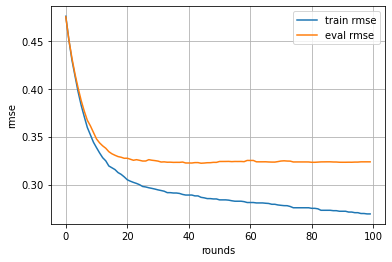

[0]	train-rmse:0.475585	eval-rmse:0.474966
[1]	train-rmse:0.450929	eval-rmse:0.45116
[2]	train-rmse:0.42989	eval-rmse:0.431852
[3]	train-rmse:0.413251	eval-rmse:0.415156
[4]	train-rmse:0.396808	eval-rmse:0.400843
[5]	train-rmse:0.382734	eval-rmse:0.387702
[6]	train-rmse:0.370918	eval-rmse:0.376705
[7]	train-rmse:0.359608	eval-rmse:0.367096
[8]	train-rmse:0.351884	eval-rmse:0.36124
[9]	train-rmse:0.344138	eval-rmse:0.354344
[10]	train-rmse:0.338457	eval-rmse:0.347547
[11]	train-rmse:0.33299	eval-rmse:0.343453
[12]	train-rmse:0.328016	eval-rmse:0.340373
[13]	train-rmse:0.324752	eval-rmse:0.337886
[14]	train-rmse:0.319403	eval-rmse:0.334308
[15]	train-rmse:0.317523	eval-rmse:0.332113
[16]	train-rmse:0.31564	eval-rmse:0.330561
[17]	train-rmse:0.3125	eval-rmse:0.329203
[18]	train-rmse:0.31066	eval-rmse:0.328502
[19]	train-rmse:0.308045	eval-rmse:0.327421
[20]	train-rmse:0.305125	eval-rmse:0.327204
[21]	train-rmse:0.304118	eval-rmse:0.326605
[22]	train-rmse:0.30284	eval-rmse:0.325488
[23]	tr

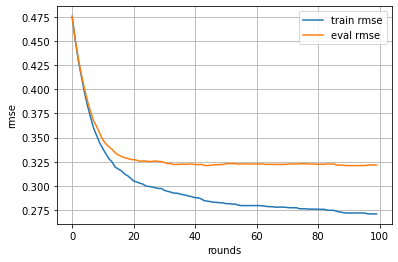

[0]	train-rmse:0.475585	eval-rmse:0.474966
[1]	train-rmse:0.450929	eval-rmse:0.45116
[2]	train-rmse:0.42989	eval-rmse:0.431852
[3]	train-rmse:0.413322	eval-rmse:0.41526
[4]	train-rmse:0.396627	eval-rmse:0.400487
[5]	train-rmse:0.382735	eval-rmse:0.387369
[6]	train-rmse:0.370906	eval-rmse:0.376334
[7]	train-rmse:0.359386	eval-rmse:0.366767
[8]	train-rmse:0.351674	eval-rmse:0.3609
[9]	train-rmse:0.3441	eval-rmse:0.354008
[10]	train-rmse:0.338651	eval-rmse:0.347171
[11]	train-rmse:0.333302	eval-rmse:0.343513
[12]	train-rmse:0.328419	eval-rmse:0.340033
[13]	train-rmse:0.3254	eval-rmse:0.336759
[14]	train-rmse:0.320891	eval-rmse:0.33289
[15]	train-rmse:0.31903	eval-rmse:0.330733
[16]	train-rmse:0.317134	eval-rmse:0.329173
[17]	train-rmse:0.314005	eval-rmse:0.327797
[18]	train-rmse:0.311949	eval-rmse:0.326912
[19]	train-rmse:0.309359	eval-rmse:0.325849
[20]	train-rmse:0.306852	eval-rmse:0.325748
[21]	train-rmse:0.305779	eval-rmse:0.325548
[22]	train-rmse:0.305032	eval-rmse:0.324861
[23]	trai

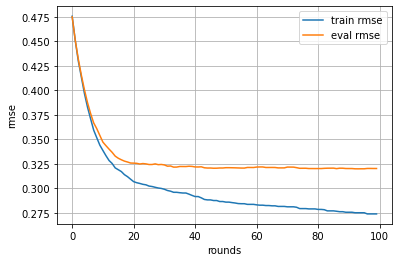

[0]	train-rmse:0.475585	eval-rmse:0.474966
[1]	train-rmse:0.450929	eval-rmse:0.45116
[2]	train-rmse:0.42989	eval-rmse:0.431852
[3]	train-rmse:0.413322	eval-rmse:0.41526
[4]	train-rmse:0.396743	eval-rmse:0.400585
[5]	train-rmse:0.383093	eval-rmse:0.387021
[6]	train-rmse:0.371129	eval-rmse:0.375876
[7]	train-rmse:0.359871	eval-rmse:0.366339
[8]	train-rmse:0.352166	eval-rmse:0.360477
[9]	train-rmse:0.344587	eval-rmse:0.353606
[10]	train-rmse:0.33915	eval-rmse:0.346775
[11]	train-rmse:0.333962	eval-rmse:0.343246
[12]	train-rmse:0.329088	eval-rmse:0.339727
[13]	train-rmse:0.326033	eval-rmse:0.336434
[14]	train-rmse:0.320963	eval-rmse:0.332912
[15]	train-rmse:0.319109	eval-rmse:0.330778
[16]	train-rmse:0.316635	eval-rmse:0.328682
[17]	train-rmse:0.31356	eval-rmse:0.327412
[18]	train-rmse:0.311554	eval-rmse:0.326523
[19]	train-rmse:0.309419	eval-rmse:0.325349
[20]	train-rmse:0.306079	eval-rmse:0.325081
[21]	train-rmse:0.304169	eval-rmse:0.324331
[22]	train-rmse:0.303081	eval-rmse:0.324396
[23

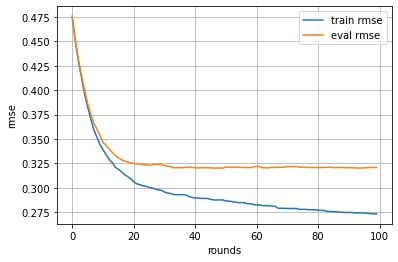

max_depth : (3, 0.40656275)
------------------------------
colsample_bytree : (0.7500000000000001, 0.42257878)
------------------------------
min_child_weight : (8.1, 0.41636238)
------------------------------
subsample : (0.6, 0.42269263)
------------------------------
gamma : (0.39000001, 0.40516517)
------------------------------


In [33]:
tune_param(dtrain, dvalid, dtest, target_variable, b_params)

[0]	train-rmse:0.475585	eval-rmse:0.474966
[1]	train-rmse:0.450929	eval-rmse:0.45116
[2]	train-rmse:0.42989	eval-rmse:0.431852
[3]	train-rmse:0.413322	eval-rmse:0.41526
[4]	train-rmse:0.396743	eval-rmse:0.400585
[5]	train-rmse:0.383093	eval-rmse:0.387021
[6]	train-rmse:0.371129	eval-rmse:0.375876
[7]	train-rmse:0.359871	eval-rmse:0.366339
[8]	train-rmse:0.352166	eval-rmse:0.360477
[9]	train-rmse:0.344587	eval-rmse:0.353606
[10]	train-rmse:0.33915	eval-rmse:0.346775
[11]	train-rmse:0.333962	eval-rmse:0.343246
[12]	train-rmse:0.329088	eval-rmse:0.339727
[13]	train-rmse:0.326033	eval-rmse:0.336434
[14]	train-rmse:0.320962	eval-rmse:0.332912
[15]	train-rmse:0.319109	eval-rmse:0.330778
[16]	train-rmse:0.316635	eval-rmse:0.328682
[17]	train-rmse:0.31356	eval-rmse:0.327412
[18]	train-rmse:0.311554	eval-rmse:0.326523
[19]	train-rmse:0.309419	eval-rmse:0.325349
[20]	train-rmse:0.306079	eval-rmse:0.325081
[21]	train-rmse:0.304169	eval-rmse:0.324331
[22]	train-rmse:0.303081	eval-rmse:0.324396
[23

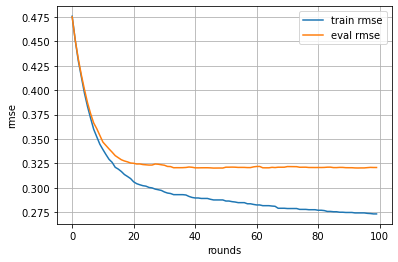

0.40516517

In [34]:
e_params = {
            'objective': 'reg:squarederror',
            'eta': 0.1,
            'gamma': 0.39,
            'alpha': 0.0,
            'lambda': 1.0,
            'eval_metric': 'rmse',
            'min_child_weight': 1,
            'max_depth': 5,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': 42
            }
e_model, evals_result = create_xg_model(dtrain, dvalid, target_variable, e_params, num_round=100)
model_learning_curve(e_model, dtest, evals_result)

- 反応しやすいハイパーパラメータの傾向を確認しました。
- 次は 'Hyperopt' を使ったチューニングを実施する予定です。

#### translate
- I have confirmed the hyperparameters that are responsive.
- Next, we plan to perform tuning using 'Hyperopt'.